In [11]:
# -*- coding: utf-8 -*-
"""
@author: lrhao
@software: jupyter
@file: baseline.ipynb
@time: 2020-12-11
@description：
"""
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import seaborn as sns
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
import catboost

In [13]:
train = pd.read_csv('../../../train.csv')
test = pd.read_csv('../../../test.csv')
submit = pd.read_csv('../../../submit.csv')
train.shape, test.shape, submit.shape

((40000, 21), (15000, 20), (15000, 2))

In [14]:
df = pd.concat([train, test], axis = 0).reset_index(drop = True)
#ZHIWU=1数据无意义，剔除该类数据
df = df[df['ZHIWU']!=1]
#剔除无效指标
del df['ZHIWU']
del df['XUELI']
del df['HYZK']
del df['ZHIYE']
del df['ZHICHEN']
del df['DWYJCE']

In [5]:
#对数值类的进行转化：
df['GRYJCE'] = df['GRYJCE'] - 237
df['GRJCJS'] = df['GRJCJS'] -237 
df['GRZHYE'] = df['GRZHYE'] - 237
df['GRZHSNJZYE'] = df ['GRZHSNJZYE'] -237
df['GRZHDNGJYE'] = (df ['GRZHDNGJYE'] -237)*3
df['DKFFE'] = df['DKFFE'] - 237
df['DKYE'] = df['DKYE']-237

In [15]:
cate_2_cols = ['XINGBIE']
cate_cols = [ 'DWJJLX', 'DWSSHY', 'GRZHZT']
# 记录需要做embedding的变量
cEmb = ['DWJJLX','DWSSHY']

In [16]:
num_cols = ['GRJCJS', 'GRZHYE', 'GRZHSNJZYE', 'GRZHDNGJYE', 'GRYJCE','DKFFE', 'DKYE', 'DKLL']

特征工程

In [17]:
df['missing_rate'] = (df.shape[1] - df.count(axis = 1)) / df.shape[1]

df['DKFFE_DKYE'] = df['DKFFE'] + df['DKYE']
df['DKFFE_DKY_multi_DKLL'] = (df['DKFFE'] + df['DKYE']) * df['DKLL']
df['GRZHDNGJYE_GRZHSNJZYE'] = df['GRZHDNGJYE'] + df['GRZHSNJZYE']
df['GRZHDNGJYE_GRZHSNJZYE1'] = df['GRZHDNGJYE'] - df['GRZHSNJZYE']
df['GRZHDNGJYE_GRZHSNJZYE2'] = df['GRZHDNGJYE']*df['GRZHDNGJYE'] + df['GRZHSNJZYE'] * df['GRZHSNJZYE']

df['DKFFE_multi_DKLL_ratio'] = df['DKFFE'] * df['DKLL'] / df['DKFFE_DKY_multi_DKLL']
df['DKYE_multi_DKLL_ratio'] = df['DKYE'] * df['DKLL'] / df['DKFFE_DKY_multi_DKLL']

df['GRZHYE_diff_GRZHDNGJYE'] = df['GRZHYE'] - df['GRZHDNGJYE']*12
df['GRZHYE_diff_GRZHSNJZYE'] = df['GRZHYE'] - df['GRZHSNJZYE']*1.3
df['GRZHYE_diff_GRZHDNGJYE1'] = df['GRZHYE'] - df['GRZHDNGJYE']
df['GRZHYE_diff_GRZHSNJZYE1'] = df['GRZHYE'] - df['GRZHSNJZYE']
#鬼知道，可能反应收入？
df['YEARPURINCM'] = df['GRZHYE']-df['GRZHSNJZYE']-df['GRZHDNGJYE']
#应还贷款月份，剩余需还贷款月份,已还贷款月份
df['HDZYF'] = df['DKFFE']*(df['DKLL']/100+1)/(df['GRYJCE']*2)
df['HDSYYF'] = df['DKYE']*(df['DKLL']/100+1)/(df['GRYJCE']*2)
df['HDYF'] = (df['DKFFE']-df['DKYE'])/(df['GRYJCE']*2)

#应还总额
df['HDZYFZE'] = df['DKFFE']*(df['DKLL']/100+1)
#待还总额
df['HDSYYFZE'] = df['DKYE']*(df['DKLL']/100+1)

#特征工程衍生的代码
# 图形旋转指标
df ['JS_YE'] = df['GRZHSNJZYE'] -20000* df['GRZHYE'].apply(lambda x: math.log(x+1))
df ['HDSYYF_HDZYF'] =df['HDSYYF'] -  df['HDZYF']*0.8
df ['GYE_GJC'] =df['GRZHYE'] -  (500-abs(df['GRYJCE']-1000))*100
df ['USAGE_RATE']=df['DKYE']/df['DKFFE']
df ['YE_USAGE'] = df['GRZHYE'] - df ['USAGE_RATE']*50000-50000
df ['YJCE2GRZHDNGJYE'] = df['GRYJCE']/ df ['GRZHDNGJYE']
df ['GRYJCE_RATE'] = df['GRYJCE']*df['GRYJCE']/2000/2000 + df ['USAGE_RATE']*df ['USAGE_RATE']
df ['GJJRATE'] = (df['GRYJCE'])/df['GRJCJS']                                                        # OKOKOK
df ['GJJRATE_GEN'] = df['GRJCJS'] - 60000*df['GJJRATE']                                             # OKOKOK
df ['GJJRATE_GEN3'] = df['GRJCJS'] - 200000*df['GJJRATE']                                           # OKOKOK
df ['GJJRATE_GEN2'] = df['GRYJCE'] - (600-df['GJJRATE']*2000)                                       # OKOKOK  
df ['DKFFE_DKYE251']= df['DKFFE'] - df['DKFFE']/df['DKYE']*251

# 金额取整取余指标
df ['DKLT']= df['DKFFE']%100000
df ['DKZS']= df['DKFFE']//100000  
df ['YELT']= df['DKYE']%100000
df ['YEZS']= df['DKYE']//100000
df ['ZHLT']= df['GRZHYE']%10000
df ['ZHZS']= df['GRZHYE']//10000
df ['GJLT']= df['GRZHDNGJYE']%100000
df ['GJZS']= df['GRZHDNGJYE']//100000
df ['SNLT']= df['GRZHSNJZYE']%10000
df ['SNZS']= df['GRZHSNJZYE']//10000
df ['YJLT']= df['GRYJCE']%500
df ['YJZS']= df['GRYJCE']//500
df['SUBMONTH'] =  (df['GRZHYE']/df['GRYJCE']).apply(lambda x: math.log(x+1))                        # NEW NEW NEW
df['YJCE_LOG'] = (df['GRYJCE']).apply(lambda x: math.log(x+1))                                      # NEW NEW NEW
df['MONTH_LOG'] = df['SUBMONTH']-df['YJCE_LOG']                                                     # NEW NEW NEW

df['USAGEOVER'] = df['DKYE']==0 
df['USAGE_AMOUNT']  = df['DKFFE']-df['DKYE']

df ['WITHDRAW'] =  df ['GRYJCE']*12*2 - df['GRZHDNGJYE']
df ['WITHSIGN'] =  df ['WITHDRAW'].apply(lambda x: 1 if x>0 else 0 if x==0 else -1  )
# 上年结转与余额的关系？

df['USAGEOVER'] = df['DKYE'] == 0 
df['NOUSAGE'] = df['DKYE'] == df['DKFFE']

df ['GRZHYE_CMP_GRZHYE'] = df['GRZHYE']/df['GRJCJS'] +df['GRJCJS']*25/12000
df ['TOP_USER'] = df['DKFFE'].apply(lambda x: x if (x%50000==0 or x==125000) else 0)
df ['TOP_USER1'] = df['DKFFE'].apply(lambda x: 1 if (x%50000==0 or x==125000) else x)

gen_feats = ['DKFFE_DKYE', 'DKFFE_DKY_multi_DKLL','GRZHDNGJYE_GRZHSNJZYE','GRZHDNGJYE_GRZHSNJZYE1',  'GRZHDNGJYE_GRZHSNJZYE2',
             'DKFFE_multi_DKLL_ratio', 'DKYE_multi_DKLL_ratio', 'GRZHYE_diff_GRZHDNGJYE',
            'GRZHYE_diff_GRZHSNJZYE', 'GRZHYE_diff_GRZHDNGJYE1',
            'GRZHYE_diff_GRZHSNJZYE1', 'YEARPURINCM','HDZYF',
            'HDSYYF','HDYF','HDZYFZE','HDSYYFZE','JS_YE','HDSYYF_HDZYF',
             'GYE_GJC','USAGE_RATE','YE_USAGE','YJCE2GRZHDNGJYE',
            'GRYJCE_RATE','GJJRATE','GJJRATE_GEN','GJJRATE_GEN2','DKFFE_DKYE251',
            'TOP_USER','TOP_USER1','WITHDRAW','USAGE_AMOUNT'
            ]

cate_cols += ['DKZS','YEZS','ZHZS','GJZS','SNZS','YJZS','USAGEOVER','WITHSIGN','NOUSAGE','TOP_USER']



df.head()

,id,XINGBIE,CSNY,DWJJLX,DWSSHY,GRJCJS,GRZHZT,GRZHYE,GRZHSNJZYE,GRZHDNGJYE,...,YJCE_LOG,MONTH_LOG,USAGEOVER,USAGE_AMOUNT,WITHDRAW,WITHSIGN,NOUSAGE,GRZHYE_CMP_GRZHYE,TOP_USER,TOP_USER1
0,train_0,1,1038672000,150,12,1737.0,1,3223.515,801.310,837.000,...,5.746203,-3.318592,False,21124.065,6651.000,1,False,5.474544,0,175237
1,train_1,2,504892800,110,0,4894.0,1,18055.195,53213.220,1065.200,...,6.680654,-3.515729,False,1984.055,18034.960,1,False,13.885084,0,300237
2,train_2,1,736185600,150,9,10297.0,1,27426.600,13963.140,7230.020,...,7.276003,-4.280728,False,2897.870,27430.780,1,False,24.115636,0,150237
3,train_3,1,428515200,150,7,10071.5,1,111871.130,99701.265,2271.295,...,7.257101,-2.875807,False,49583.220,31740.065,1,False,32.089985,0,350237
4,train_4,2,544204800,900,14,2007.0,1,237.000,11028.875,35.780,...,5.788430,-5.241401,False,5051.990,7776.220,1,False,4.299337,0,150237


/home/ubuntu/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/ubuntu/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/ubuntu/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


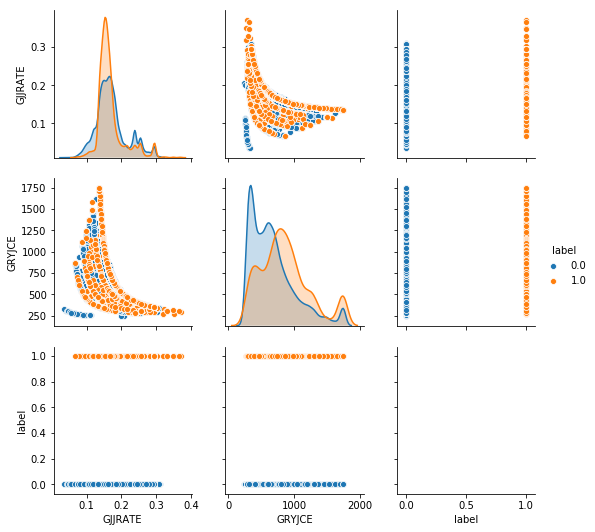

In [18]:
import seaborn as sns

sns.pairplot(df[['GJJRATE','GRYJCE','label']],hue='label')


In [9]:
import time
def get_age(df,col = 'age'):
    df[col+"_genFeat1"]=(df['age'] > 18).astype(int)
    df[col+"_genFeat2"]=(df['age'] > 25).astype(int)
    df[col+"_genFeat3"]=(df['age'] > 30).astype(int)
    df[col+"_genFeat4"]=(df['age'] > 35).astype(int)
    df[col+"_genFeat5"]=(df['age'] > 40).astype(int)
    df[col+"_genFeat6"]=(df['age'] > 45).astype(int)
    return df, [col + f'_genFeat{i}' for i in range(1, 7)]

# BORN MONTH
tNow = time.mktime(time.strptime( '2021-01-12 00:00:00','%Y-%m-%d %H:%M:%S'))
df['bornmonth'] = df['CSNY'].apply(lambda x: time.localtime(x)[1])

#这个怎么换算出来的啊，超哥
df['age'] = ((1609430399 - df['CSNY']) / (365 * 24 * 3600)).astype(int)
df, genFeats1 = get_age(df, col = 'age')

#sns.distplot(df['age'][df['age'] > 0])

In [10]:
def get_daikuanYE(df,col):
    df[col + '_genFeat1'] = (df[col] > 100000).astype(int)
    df[col + '_genFeat2'] = (df[col] > 120000).astype(int)
    df[col + '_genFeat3'] = (df[col] > 140000).astype(int)
    df[col + '_genFeat4'] = (df[col] > 180000).astype(int)
    df[col + '_genFeat5'] = (df[col] > 220000).astype(int)
    df[col + '_genFeat6'] = (df[col] > 260000).astype(int)
    df[col + '_genFeat7'] = (df[col] > 300000).astype(int)
    return df, [col + f'_genFeat{i}' for i in range(1, 8)]

df, genFeats2 = get_daikuanYE(df, col = 'DKYE')
df, genFeats3 = get_daikuanYE(df, col = 'DKFFE')

In [11]:
from tqdm import tqdm

In [12]:
# 建立关键指标表，降低计算量！
delIndics0 = [  'DWSSHY_DKYE_min',  'DKFFE_DKY_multi_DKLL_DKFFE_DKYE_std',  'GRZHDNGJYE_GRZHSNJZYE2_GRZHSNJZYE_std',  'GRZHDNGJYE_GRZHSNJZYE2_GRZHDNGJYE_std',  'GRZHDNGJYE_GRZHSNJZYE2_GRZHDNGJYE_GRZHSNJZYE_std',  'GRZHDNGJYE_GRZHSNJZYE2_GRZHDNGJYE_GRZHSNJZYE1_std', 'DKFFE_multi_DKLL_ratio_USAGE_RATE_std',  'DKYE_multi_DKLL_ratio_USAGE_RATE_std',  'HDZYF_GRYJCE_std',  'HDZYF_DKFFE_std',  'HDZYF_HDZYFZE_std',  'HDSYYF_GRYJCE_std',  'HDSYYF_DKYE_std',  'HDSYYF_HDSYYFZE_std',  'HDZYFZE_DKFFE_std',  'HDSYYFZE_DKYE_std',  'JS_YE_GRJCJS_std',  'JS_YE_GRZHYE_std',  'HDSYYF_HDZYF_GRYJCE_std',  'HDSYYF_HDZYF_DKFFE_std',  'HDSYYF_HDZYF_DKYE_std',  'HDSYYF_HDZYF_DKFFE_DKYE_std',  'HDSYYF_HDZYF_DKFFE_multi_DKLL_ratio_std',  'HDSYYF_HDZYF_HDZYF_std',  'HDSYYF_HDZYF_HDSYYF_std',  'HDSYYF_HDZYF_HDYF_std',  'HDSYYF_HDZYF_HDZYFZE_std',  'HDSYYF_HDZYF_HDSYYFZE_std',  'HDSYYF_HDZYF_USAGE_RATE_std',  'HDSYYF_HDZYF_GRYJCE_RATE_std',  'YE_USAGE_GRZHYE_std',  'YE_USAGE_USAGE_RATE_std',  'GRYJCE_RATE_GRYJCE_std',  'GRYJCE_RATE_HDYF_std',  'GRYJCE_RATE_USAGE_RATE_std',  'GJJRATE_GEN_GRJCJS_std',  'GJJRATE_GEN_GRYJCE_std',  'GJJRATE_GEN_GJJRATE_std',  'GJJRATE_GEN_GJJRATE_GEN2_std',  'GJJRATE_GEN2_GRJCJS_std',  'GJJRATE_GEN2_GRYJCE_std',  'GJJRATE_GEN2_GJJRATE_std',  'GJJRATE_GEN2_GJJRATE_GEN_std',    'numsOf_GRZHDNGJYE_DKYE_multi_DKLL_ratio_diff', 'DWJJLX_DKFFE_genFeat3_sum', 'numsOf_GRZHDNGJYE_DKYE_multi_DKLL_ratio_add', 'numsOf_GRYJCE_DKLL_diff', 'numsOf_DKFFE_DKYE_add', 'DWJJLX_5', 'DWJJLX_0', 'DWJJLX_9', 'DWJJLX_21', 'numsOf_GRYJCE_DKFFE_DKY_multi_DKLL_diff', 'DWJJLX_10', 'DWSSHY_DKFFE_max', 'DKFFE_genFeat7', 'DWJJLX_13', 'DWJJLX_DKFFE_genFeat6_sum', 'numsOf_GRZHDNGJYE_DKLL_diff', 'GRZHYE_DKFFE_DKYE_std', 'DWJJLX_19', 'numsOf_DKFFE_DKLL_add', 'numsOf_GRYJCE_DKYE_diff', 'DWSSHY_GRZHSNJZYE_min', 'GRZHYE_GRZHYE_diff_GRZHSNJZYE_std', 'numsOf_GRZHDNGJYE_GRZHDNGJYE_GRZHSNJZYE2_diff', 'DWJJLX_12', 'numsOf_GRZHDNGJYE_GRZHDNGJYE_GRZHSNJZYE2_add', 'numsOf_GRYJCE_GRZHDNGJYE_GRZHSNJZYE2_diff', 'GRZHSNJZYE_GRZHDNGJYE_GRZHSNJZYE1_std', 'numsOf_GRZHDNGJYE_GRZHDNGJYE_GRZHSNJZYE1_diff', 'numsOf_GRYJCE_GRZHDNGJYE_GRZHSNJZYE2_add', 'DWJJLX_20', 'numsOf_GRZHDNGJYE_GRZHDNGJYE_GRZHSNJZYE_diff', 'DWSSHY_GRJCJS_max', 'GRZHSNJZYE_DKLL_max', 'numsOf_GRZHDNGJYE_GRZHYE_diff_GRZHDNGJYE1_add', 'DWJJLX_11', 'numsOf_GRZHDNGJYE_DKFFE_multi_DKLL_ratio_add', 'DWJJLX_DKFFE_genFeat4_sum', 'DWSSHY_GRYJCE_sum', 'DWSSHY_GRYJCE_max', 'DWJJLX_16', 'DWJJLX_17', 'DWJJLX_15', 'numsOf_DKFFE_DKFFE_DKYE_div', 'DWJJLX_14', 'DWJJLX_18', 'numsOf_GRYJCE_DKFFE_DKYE_add', 'DWJJLX_6', 'DWJJLX_DKFFE_genFeat7_sum', 'DWSSHY_GRZHYE_min', 'DWJJLX_DKFFE_genFeat5_sum', 'numsOf_DKFFE_DKYE_div', 'DWJJLX_7', 'numsOf_DKLL_GRZHYE_diff_GRZHDNGJYE_add', 'DWSSHY_DKLL_sum', 'GRZHZT_DKYE_max', 'GRZHZT_DKFFE_DKYE_std', 'GRZHZT_DKFFE_DKYE_mean', 'numsOf_GRZHDNGJYE_GRZHSNJZYE_DKFFE_multi_DKLL_ratio_add', 'numsOf_GRZHDNGJYE_GRZHSNJZYE_DKFFE_multi_DKLL_ratio_diff', 'GRZHZT_DKFFE_DKYE_sum', 'numsOf_GRZHDNGJYE_GRZHSNJZYE_DKYE_multi_DKLL_ratio_add', 'numsOf_GRZHDNGJYE_GRZHSNJZYE_DKYE_multi_DKLL_ratio_diff', 'GRZHZT_DKLL_max', 'GRZHZT_DKLL_std', 'GRZHZT_DKLL_mean', 'GRZHZT_DKLL_sum', 'GRZHZT_DKYE_std', 'numsOf_GRZHDNGJYE_GRZHSNJZYE_GRZHDNGJYE_GRZHSNJZYE2_add', 'GRZHZT_DKYE_mean', 'GRZHZT_DKYE_sum', 'GRZHYE_diff_GRZHDNGJYE', 'numsOf_GRZHDNGJYE_GRZHSNJZYE1_GRZHDNGJYE_GRZHSNJZYE2_add', 'numsOf_GRZHDNGJYE_GRZHSNJZYE1_GRZHDNGJYE_GRZHSNJZYE2_diff', 'GRZHZT_DKFFE_max', 'numsOf_GRZHDNGJYE_GRZHSNJZYE1_DKFFE_multi_DKLL_ratio_add', 'numsOf_GRZHDNGJYE_GRZHSNJZYE1_DKFFE_multi_DKLL_ratio_diff', 'GRZHZT_DKFFE_mean', 'numsOf_GRZHDNGJYE_GRZHSNJZYE1_DKYE_multi_DKLL_ratio_add', 'numsOf_GRZHDNGJYE_GRZHSNJZYE1_DKYE_multi_DKLL_ratio_diff', 'numsOf_GRZHDNGJYE_GRZHSNJZYE_GRZHDNGJYE_GRZHSNJZYE2_diff', 'GRZHZT_DKFFE_DKYE_max', 'GRZHZT_GRYJCE_min', 'GRZHZT_GRZHDNGJYE_GRZHSNJZYE1_sum', 'GRZHZT_GRZHDNGJYE_GRZHSNJZYE2_mean', 'GRZHZT_GRZHDNGJYE_GRZHSNJZYE2_sum', 'GRZHZT_GRZHDNGJYE_GRZHSNJZYE1_min', 'GRZHZT_GRZHDNGJYE_GRZHSNJZYE1_max', 'GRZHZT_GRZHDNGJYE_GRZHSNJZYE1_std', 'numsOf_DKFFE_DKY_multi_DKLL_DKFFE_multi_DKLL_ratio_add', 'numsOf_DKFFE_DKY_multi_DKLL_DKFFE_multi_DKLL_ratio_diff', 'GRZHZT_GRZHDNGJYE_GRZHSNJZYE1_mean', 'numsOf_DKFFE_DKY_multi_DKLL_DKYE_multi_DKLL_ratio_add', 'numsOf_DKFFE_DKY_multi_DKLL_DKYE_multi_DKLL_ratio_diff', 'HDZYFZE', 'GRZHZT_GRZHDNGJYE_GRZHSNJZYE_min', 'GRZHZT_DKFFE_DKYE_min', 'GRZHZT_GRZHDNGJYE_GRZHSNJZYE_max', 'GRZHZT_GRZHDNGJYE_GRZHSNJZYE_std', 'GRZHZT_GRZHDNGJYE_GRZHSNJZYE_mean', 'GRZHZT_GRZHDNGJYE_GRZHSNJZYE_sum', 'GRZHZT_DKFFE_DKY_multi_DKLL_min', 'GRZHZT_DKFFE_DKY_multi_DKLL_max', 'GRZHZT_DKFFE_DKY_multi_DKLL_std', 'GRZHZT_DKFFE_DKY_multi_DKLL_mean', 'GRZHZT_DKFFE_DKY_multi_DKLL_sum', 'numsOf_GRZHDNGJYE_GRZHSNJZYE_GRZHDNGJYE_GRZHSNJZYE1_add', 'numsOf_GRZHDNGJYE_GRZHSNJZYE_GRZHDNGJYE_GRZHSNJZYE1_diff', 'GRZHZT_DKFFE_sum', 'GRZHZT_GRYJCE_max', 'DWSSHY_DKLL_max', 'GRZHZT_GRJCJS_max', 'numsOf_DKFFE_multi_DKLL_ratio_DKYE_multi_DKLL_ratio_diff', 'numsOf_DKFFE_multi_DKLL_ratio_DKYE_multi_DKLL_ratio_multi', 'numsOf_DKFFE_multi_DKLL_ratio_DKYE_multi_DKLL_ratio_div', 'numsOf_DKFFE_multi_DKLL_ratio_GRZHYE_diff_GRZHDNGJYE_add', 'DKYE', 'numsOf_DKFFE_multi_DKLL_ratio_GRZHYE_diff_GRZHSNJZYE_add', 'numsOf_DKFFE_multi_DKLL_ratio_GRZHYE_diff_GRZHSNJZYE_diff', 'GRZHZT_GRZHYE_sum', 'DKFFE', 'numsOf_DKFFE_multi_DKLL_ratio_GRZHYE_diff_GRZHDNGJYE1_add', 'GRZHZT_GRJCJS_min', 'numsOf_DKYE_multi_DKLL_ratio_GRZHYE_diff_GRZHDNGJYE_add', 'DKLL', 'numsOf_DKYE_multi_DKLL_ratio_GRZHYE_diff_GRZHDNGJYE_diff', 'numsOf_DKYE_multi_DKLL_ratio_GRZHYE_diff_GRZHSNJZYE_add', 'numsOf_DKYE_multi_DKLL_ratio_GRZHYE_diff_GRZHSNJZYE_diff', 'numsOf_DKYE_multi_DKLL_ratio_GRZHYE_diff_GRZHDNGJYE1_add', 'numsOf_DKYE_multi_DKLL_ratio_GRZHYE_diff_GRZHDNGJYE1_diff', 'GRZHZT_GRJCJS_std', 'GRZHZT_GRJCJS_sum', 'DWSSHY_DKFFE_genFeat4_sum', 'numsOf_GRZHYE_diff_GRZHDNGJYE_GRZHYE_diff_GRZHDNGJYE1_diff', 'DWSSHY_DKFFE_genFeat2_sum', 'DWSSHY_DKFFE_genFeat1_sum', 'numsOf_DKFFE_multi_DKLL_ratio_DKYE_multi_DKLL_ratio_add', 'GRZHZT_GRZHYE_std', 'GRZHZT_GRYJCE_std', 'numsOf_GRZHDNGJYE_GRZHSNJZYE2_DKYE_multi_DKLL_ratio_add', 'GRZHZT_GRYJCE_mean', 'GRZHDNGJYE_GRZHSNJZYE2', 'GRZHZT_GRYJCE_sum', 'GRZHZT_GRZHDNGJYE_max', 'GRZHDNGJYE_GRZHSNJZYE1', 'GRZHZT_GRZHSNJZYE_min', 'GRZHDNGJYE_GRZHSNJZYE', 'numsOf_GRZHDNGJYE_GRZHSNJZYE2_DKFFE_multi_DKLL_ratio_add', 'numsOf_GRZHDNGJYE_GRZHSNJZYE2_DKFFE_multi_DKLL_ratio_diff', 'GRZHZT_GRZHSNJZYE_max', 'GRZHZT_GRZHSNJZYE_std', 'numsOf_GRZHDNGJYE_GRZHSNJZYE2_DKYE_multi_DKLL_ratio_diff', 'numsOf_GRZHDNGJYE_GRZHSNJZYE2_GRZHYE_diff_GRZHDNGJYE1_diff', 'GRZHZT_GRZHSNJZYE_mean', 'GRZHZT_GRZHSNJZYE_sum', 'numsOf_GRZHDNGJYE_GRZHSNJZYE2_GRZHYE_diff_GRZHDNGJYE_add', 'numsOf_GRZHDNGJYE_GRZHSNJZYE2_GRZHYE_diff_GRZHDNGJYE_diff', 'GRZHZT_GRZHYE_min', 'DKFFE_DKY_multi_DKLL', 'numsOf_GRZHDNGJYE_GRZHSNJZYE2_GRZHYE_diff_GRZHSNJZYE_add', 'numsOf_GRZHDNGJYE_GRZHSNJZYE2_GRZHYE_diff_GRZHSNJZYE_diff', 'GRZHZT_GRZHYE_max', 'DKFFE_DKYE', 'numsOf_GRZHDNGJYE_GRZHSNJZYE2_GRZHYE_diff_GRZHDNGJYE1_add', 'GRZHZT_GRZHDNGJYE_GRZHSNJZYE2_std', 'GRZHZT_GRZHDNGJYE_GRZHSNJZYE2_max', 'GRZHZT_GRZHDNGJYE_GRZHSNJZYE2_min', 'DKYE_genFeat4', 'numsOf_DKYE_GRZHDNGJYE_GRZHSNJZYE2_diff', 'GRZHZT_DKFFE_genFeat5_sum', 'GRZHZT_DKFFE_genFeat4_mean', 'numsOf_DKYE_DKFFE_multi_DKLL_ratio_add', 'numsOf_DKYE_DKFFE_multi_DKLL_ratio_diff', 'numsOf_DKYE_DKFFE_multi_DKLL_ratio_multi', 'GRZHZT_DKFFE_genFeat4_sum', 'numsOf_DKYE_DKYE_multi_DKLL_ratio_add', 'numsOf_DKYE_DKYE_multi_DKLL_ratio_diff', 'GRZHZT_DKFFE_genFeat3_mean', 'numsOf_DKYE_DKYE_multi_DKLL_ratio_div', 'DKYE_genFeat3', 'GRZHZT_DKFFE_genFeat5_mean', 'DKYE_genFeat2', 'DKYE_genFeat1', 'GRZHZT_DKFFE_genFeat3_sum', 'GRZHZT_DKFFE_genFeat2_mean', 'GRZHZT_DKFFE_genFeat2_sum', 'GRZHZT_DKFFE_genFeat1_mean', 'GRZHZT_DKFFE_genFeat1_sum', 'numsOf_DKLL_DKFFE_DKYE_add', 'numsOf_DKLL_DKFFE_DKYE_diff', 'numsOf_DKLL_DKFFE_DKYE_multi', 'GRZHZT_DKYE_genFeat7_mean', 'DKYE_genFeat5', 'GRZHZT_DKFFE_genFeat6_sum', 'GRZHZT_DKFFE_multi_DKLL_ratio_sum', 'DWSSHY_GRZHDNGJYE_GRZHSNJZYE_sum', 'DWSSHY_DKLL_min', 'DKFFE_genFeat6', 'numsOf_DKFFE_DKFFE_multi_DKLL_ratio_div', 'DWSSHY_DKFFE_DKYE_sum', 'DKFFE_genFeat5', 'DKFFE_genFeat4', 'DKFFE_genFeat3', 'DWSSHY_DKFFE_DKY_multi_DKLL_sum', 'DKFFE_genFeat2', 'DKFFE_genFeat1', 'DWSSHY_DKFFE_DKY_multi_DKLL_max', 'DKYE_genFeat7', 'GRZHZT_DKFFE_genFeat6_mean', 'DKYE_genFeat6', 'numsOf_DKYE_DKLL_add', 'numsOf_DKYE_DKLL_diff', 'numsOf_DKYE_DKFFE_DKYE_diff', 'DWSSHY_DKFFE_multi_DKLL_ratio_min', 'numsOf_DKYE_DKFFE_DKYE_div', 'DWSSHY_DKYE_multi_DKLL_ratio_sum', 'DWSSHY_DKYE_multi_DKLL_ratio_max', 'DWSSHY_GRZHYE_diff_GRZHDNGJYE1_sum', 'GRZHZT_DKFFE_genFeat7_mean', 'GRZHZT_DKFFE_genFeat7_sum', 'numsOf_DKLL_DKFFE_DKY_multi_DKLL_add', 'GRZHZT_DKYE_genFeat7_sum', 'numsOf_DKLL_DKFFE_DKY_multi_DKLL_div', 'numsOf_DKFFE_DKYE_DKYE_multi_DKLL_ratio_multi', 'GRZHZT_GRZHYE_diff_GRZHSNJZYE_min', 'GRZHZT_GRZHYE_diff_GRZHSNJZYE_max', 'GRZHZT_GRZHYE_diff_GRZHSNJZYE_std', 'USAGE_RATE', 'GRZHZT_GRZHYE_diff_GRZHSNJZYE_mean', 'GRZHZT_GRZHYE_diff_GRZHSNJZYE_sum', 'numsOf_DKFFE_DKYE_DKFFE_multi_DKLL_ratio_add', 
             'numsOf_DKFFE_DKYE_DKFFE_multi_DKLL_ratio_diff', 'numsOf_DKFFE_DKYE_DKFFE_multi_DKLL_ratio_multi', 'numsOf_DKFFE_DKYE_DKYE_multi_DKLL_ratio_add', 'numsOf_DKFFE_DKYE_DKYE_multi_DKLL_ratio_diff', 'GRZHZT_GRZHYE_diff_GRZHDNGJYE_max', 'numsOf_DKLL_GRZHDNGJYE_GRZHSNJZYE_add', 'GRZHZT_GRZHYE_diff_GRZHDNGJYE_std', 'GRZHZT_GRZHYE_diff_GRZHDNGJYE_mean', 'GRZHZT_GRZHYE_diff_GRZHDNGJYE_sum', 'GRZHZT_DKYE_multi_DKLL_ratio_max', 'GRZHZT_DKYE_multi_DKLL_ratio_std', 'GRZHZT_DKYE_multi_DKLL_ratio_mean', 'GRZHZT_DKYE_multi_DKLL_ratio_sum', 'GRZHZT_DKFFE_multi_DKLL_ratio_min', 'GRZHZT_DKFFE_multi_DKLL_ratio_max', 'GRZHZT_DKFFE_multi_DKLL_ratio_std', 'GRZHZT_DKFFE_multi_DKLL_ratio_mean', 'GRZHZT_GRZHYE_diff_GRZHDNGJYE1_sum', 'GRZHZT_GRZHYE_diff_GRZHDNGJYE1_mean', 'GRZHZT_GRZHYE_diff_GRZHDNGJYE1_std', 'GRZHZT_GRZHYE_diff_GRZHDNGJYE1_max', 'GRZHZT_DKYE_genFeat6_mean', 'numsOf_DKLL_GRZHDNGJYE_GRZHSNJZYE1_add', 'numsOf_DKLL_GRZHDNGJYE_GRZHSNJZYE1_diff', 'numsOf_DKLL_GRZHDNGJYE_GRZHSNJZYE2_add', 'numsOf_DKLL_GRZHDNGJYE_GRZHSNJZYE2_diff', 'numsOf_DKLL_GRZHDNGJYE_GRZHSNJZYE2_multi', 'age_genFeat1', 'GRZHZT_DKYE_genFeat6_sum', 'GRZHZT_DKYE_genFeat5_mean', 'GRZHZT_DKYE_genFeat5_sum', 'GRZHZT_DKYE_genFeat4_mean', 'GRZHZT_DKYE_genFeat4_sum', 'GRZHZT_DKYE_genFeat3_mean', 'numsOf_DKLL_GRZHYE_diff_GRZHDNGJYE_diff', 'GRZHZT_DKYE_genFeat3_sum', 'numsOf_DKLL_GRZHYE_diff_GRZHSNJZYE_add', 'GRZHZT_DKYE_genFeat2_mean', 'GRZHZT_DKYE_genFeat2_sum', 'numsOf_DKLL_GRZHYE_diff_GRZHDNGJYE1_add', 'GRZHZT_DKYE_genFeat1_mean', 'GRZHZT_DKYE_genFeat1_sum', 'GRZHZT_GRZHYE_diff_GRZHDNGJYE1_min', 'numsOf_DKFFE_DKYE_DKFFE_DKY_multi_DKLL_multi', 'GRZHDNGJYE_GRZHDNGJYE_GRZHSNJZYE1_std', 'DKLL_DKYE_max', 'DWJJLX_DKFFE_genFeat2_sum', 'DKYE_multi_DKLL_ratio_DKYE_max', 'DKFFE_DKY_multi_DKLL_DKFFE_DKYE_max', 'DKFFE_DKY_multi_DKLL_DKFFE_DKYE_mean', 'DKFFE_DKY_multi_DKLL_DKLL_min', 'DKFFE_DKY_multi_DKLL_DKLL_max', 'DKYE_multi_DKLL_ratio_DKFFE_mean', 'DKYE_multi_DKLL_ratio_DKFFE_std', 'DKYE_multi_DKLL_ratio_DKFFE_max', 'DKFFE_DKY_multi_DKLL_DKLL_std', 'DKYE_multi_DKLL_ratio_DKYE_mean', 'DKYE_multi_DKLL_ratio_DKYE_std', 'DKYE_multi_DKLL_ratio_DKYE_min', 'DWJJLX_GRZHSNJZYE_sum', 'DKYE_multi_DKLL_ratio_DKLL_min', 'DKYE_multi_DKLL_ratio_DKFFE_DKYE_mean', 'DKYE_multi_DKLL_ratio_DKFFE_DKYE_std', 'DKYE_multi_DKLL_ratio_DKFFE_DKYE_max', 'DKYE_multi_DKLL_ratio_DKFFE_DKYE_min', 'DKFFE_DKY_multi_DKLL_DKYE_std', 'DKFFE_DKY_multi_DKLL_DKYE_mean', 'DKFFE_DKY_multi_DKLL_DKFFE_max', 'DKFFE_DKYE_DKFFE_DKY_multi_DKLL_mean', 'DKYE_multi_DKLL_ratio_DKFFE_multi_DKLL_ratio_mean', 'DKFFE_DKY_multi_DKLL_DKFFE_DKYE_min', 'DWJJLX_GRZHYE_min', 'GRZHDNGJYE_GRZHSNJZYE_GRZHDNGJYE_GRZHSNJZYE1_min', 'GRZHDNGJYE_GRZHSNJZYE_DKLL_min', 'DKFFE_multi_DKLL_ratio_DKFFE_mean', 'DKFFE_multi_DKLL_ratio_DKFFE_std', 'DKFFE_multi_DKLL_ratio_DKFFE_max', 'GRZHDNGJYE_GRZHSNJZYE_GRZHDNGJYE_GRZHSNJZYE1_std', 'DKFFE_multi_DKLL_ratio_DKYE_mean', 'DKFFE_multi_DKLL_ratio_DKYE_std', 'DKFFE_multi_DKLL_ratio_DKFFE_DKYE_mean', 'DKFFE_multi_DKLL_ratio_DKFFE_DKYE_std', 'DKFFE_multi_DKLL_ratio_DKFFE_DKYE_min', 'GRZHDNGJYE_GRZHSNJZYE_DKFFE_DKY_multi_DKLL_std', 'GRZHDNGJYE_GRZHSNJZYE_DKLL_max', 'DKFFE_DKY_multi_DKLL_DKYE_multi_DKLL_ratio_std', 'GRZHDNGJYE_GRZHSNJZYE_DKLL_std', 'GRZHDNGJYE_GRZHSNJZYE_DKLL_mean', 'GRZHDNGJYE_GRZHSNJZYE_DKYE_std', 'DKFFE_multi_DKLL_ratio_DKYE_multi_DKLL_ratio_mean', 'DKFFE_multi_DKLL_ratio_DKYE_multi_DKLL_ratio_max', 'DKFFE_multi_DKLL_ratio_DKYE_multi_DKLL_ratio_min', 'GRZHDNGJYE_GRZHSNJZYE_GRZHDNGJYE_std', 'GRZHDNGJYE_GRZHSNJZYE_GRZHSNJZYE_std', 'GRZHDNGJYE_GRZHSNJZYE_GRZHYE_min', 'GRZHDNGJYE_GRZHSNJZYE_GRZHYE_max', 'DKYE_multi_DKLL_ratio_DKFFE_multi_DKLL_ratio_max', 'DKYE_multi_DKLL_ratio_DKFFE_multi_DKLL_ratio_min', 'DKFFE_DKYE_DKFFE_std', 'GRZHYE_diff_GRZHDNGJYE_GRZHDNGJYE_GRZHSNJZYE2_max', 'GRZHYE_diff_GRZHDNGJYE_DKFFE_DKYE_mean', 'GRZHYE_diff_GRZHDNGJYE_DKFFE_DKYE_std', 'GRZHYE_diff_GRZHDNGJYE_DKFFE_DKY_multi_DKLL_std', 'GRZHYE_diff_GRZHDNGJYE_DKFFE_DKY_multi_DKLL_max', 'GRZHYE_diff_GRZHDNGJYE_GRZHDNGJYE_GRZHSNJZYE_mean', 'GRZHYE_diff_GRZHDNGJYE_GRZHDNGJYE_GRZHSNJZYE_min', 'GRZHYE_diff_GRZHDNGJYE_GRZHDNGJYE_GRZHSNJZYE1_mean', 'GRZHYE_diff_GRZHDNGJYE_GRZHDNGJYE_GRZHSNJZYE1_max', 'GRZHYE_diff_GRZHDNGJYE_GRZHDNGJYE_GRZHSNJZYE1_min', 'GRZHYE_diff_GRZHDNGJYE_GRZHDNGJYE_GRZHSNJZYE2_mean', 'DKLL_GRZHYE_diff_GRZHDNGJYE_std', 'DKFFE_DKYE_DKFFE_mean', 'GRZHYE_diff_GRZHDNGJYE_DKFFE_multi_DKLL_ratio_std', 'DKLL_GRZHYE_diff_GRZHDNGJYE_sum', 'DKLL_DKYE_multi_DKLL_ratio_min', 'GRZHYE_diff_GRZHDNGJYE_DKYE_multi_DKLL_ratio_std', 'GRZHYE_diff_GRZHDNGJYE_GRZHYE_diff_GRZHSNJZYE_std', 'GRZHYE_diff_GRZHDNGJYE_GRZHYE_diff_GRZHSNJZYE_min', 'GRZHYE_diff_GRZHDNGJYE_GRZHYE_diff_GRZHDNGJYE1_std', 'GRZHYE_diff_GRZHSNJZYE_GRJCJS_mean', 'GRZHYE_diff_GRZHSNJZYE_GRJCJS_std', 'GRZHYE_diff_GRZHSNJZYE_GRJCJS_max', 'GRZHYE_diff_GRZHDNGJYE_DKLL_min', 'GRZHYE_diff_GRZHDNGJYE_DKLL_max', 'GRZHYE_diff_GRZHDNGJYE_DKLL_std', 'DKLL_GRZHYE_diff_GRZHDNGJYE_max', 'DKLL_GRZHYE_diff_GRZHDNGJYE1_min', 'DKLL_GRZHYE_diff_GRZHDNGJYE1_max', 'DKLL_GRZHYE_diff_GRZHDNGJYE1_mean', 'DKLL_GRZHYE_diff_GRZHDNGJYE1_sum', 'GRZHYE_diff_GRZHDNGJYE_GRJCJS_std', 'DKLL_GRZHYE_diff_GRZHSNJZYE_min', 'GRZHYE_diff_GRZHDNGJYE_GRZHYE_max', 'GRZHYE_diff_GRZHDNGJYE_GRZHSNJZYE_mean', 'DKLL_GRZHYE_diff_GRZHSNJZYE_max', 'GRZHYE_diff_GRZHDNGJYE_GRZHDNGJYE_mean', 'GRZHYE_diff_GRZHDNGJYE_GRZHDNGJYE_std', 'GRZHYE_diff_GRZHDNGJYE_GRZHDNGJYE_max', 'GRZHYE_diff_GRZHDNGJYE_GRZHDNGJYE_min', 'DKLL_GRZHYE_diff_GRZHSNJZYE_std', 'DKLL_GRZHYE_diff_GRZHSNJZYE_mean', 'GRZHYE_diff_GRZHDNGJYE_GRYJCE_std', 'DKLL_GRZHYE_diff_GRZHSNJZYE_sum', 'GRZHYE_diff_GRZHDNGJYE_DKFFE_mean', 'GRZHYE_diff_GRZHDNGJYE_DKFFE_min', 'DKLL_GRZHYE_diff_GRZHDNGJYE_min', 'GRZHYE_diff_GRZHDNGJYE_DKYE_std', 'GRZHDNGJYE_GRZHSNJZYE_GRZHDNGJYE_GRZHSNJZYE1_max', 'GRZHDNGJYE_GRZHSNJZYE_GRZHDNGJYE_GRZHSNJZYE2_mean', 'GRZHYE_diff_GRZHSNJZYE_GRZHYE_sum', 'GRZHDNGJYE_GRZHSNJZYE2_GRJCJS_max', 'DWSSHY_DKYE_genFeat2_sum', 'GRZHDNGJYE_GRZHSNJZYE1_DKFFE_multi_DKLL_ratio_max', 'GRZHDNGJYE_GRZHSNJZYE1_GRJCJS_std', 'GRZHDNGJYE_GRZHSNJZYE1_DKYE_multi_DKLL_ratio_mean', 'GRZHDNGJYE_GRZHSNJZYE1_GRZHYE_diff_GRZHDNGJYE_mean', 'GRZHDNGJYE_GRZHSNJZYE1_GRZHYE_diff_GRZHDNGJYE_min', 'GRZHDNGJYE_GRZHSNJZYE1_GRZHYE_diff_GRZHSNJZYE_std', 'GRZHDNGJYE_GRZHSNJZYE1_GRZHYE_diff_GRZHDNGJYE1_std', 'GRZHDNGJYE_GRZHSNJZYE2_GRJCJS_mean', 'GRZHDNGJYE_GRZHSNJZYE2_GRJCJS_std', 'GRZHDNGJYE_GRZHSNJZYE2_GRJCJS_min', 'GRZHDNGJYE_GRZHSNJZYE1_GRZHDNGJYE_GRZHSNJZYE2_max', 'GRZHDNGJYE_GRZHSNJZYE2_GRZHYE_mean', 'GRZHDNGJYE_GRZHSNJZYE2_GRZHYE_std', 'GRZHDNGJYE_GRZHSNJZYE2_GRZHYE_max', 'GRZHDNGJYE_GRZHSNJZYE2_GRZHSNJZYE_sum', 'GRZHDNGJYE_GRZHSNJZYE2_GRZHSNJZYE_mean', 'GRZHDNGJYE_GRZHSNJZYE2_GRZHSNJZYE_max', 'GRZHDNGJYE_GRZHSNJZYE2_GRZHSNJZYE_min', 'GRZHDNGJYE_GRZHSNJZYE2_GRZHDNGJYE_mean', 'GRZHDNGJYE_GRZHSNJZYE2_GRZHDNGJYE_max', 'GRZHDNGJYE_GRZHSNJZYE2_GRZHDNGJYE_min', 'GRZHDNGJYE_GRZHSNJZYE1_GRZHDNGJYE_GRZHSNJZYE2_min', 'GRZHDNGJYE_GRZHSNJZYE1_GRZHDNGJYE_GRZHSNJZYE2_mean', 'GRZHDNGJYE_GRZHSNJZYE_GRZHDNGJYE_GRZHSNJZYE2_std', 'GRZHDNGJYE_GRZHSNJZYE1_DKFFE_min', 'GRZHDNGJYE_GRZHSNJZYE1_GRZHSNJZYE_mean', 'GRZHDNGJYE_GRZHSNJZYE1_GRZHSNJZYE_std', 'GRZHDNGJYE_GRZHSNJZYE1_GRZHSNJZYE_max', 'GRZHDNGJYE_GRZHSNJZYE1_GRZHSNJZYE_min', 'GRZHDNGJYE_GRZHSNJZYE1_GRZHDNGJYE_mean', 'GRZHDNGJYE_GRZHSNJZYE1_GRZHDNGJYE_std', 'GRZHDNGJYE_GRZHSNJZYE1_GRZHDNGJYE_max', 'GRZHDNGJYE_GRZHSNJZYE1_GRZHYE_std', 'GRZHDNGJYE_GRZHSNJZYE1_GRYJCE_std', 'GRZHDNGJYE_GRZHSNJZYE1_DKFFE_std', 'GRZHDNGJYE_GRZHSNJZYE1_DKYE_std', 'GRZHDNGJYE_GRZHSNJZYE1_GRZHDNGJYE_GRZHSNJZYE_max', 'GRZHDNGJYE_GRZHSNJZYE1_DKLL_mean', 'GRZHDNGJYE_GRZHSNJZYE1_DKLL_std', 'GRZHDNGJYE_GRZHSNJZYE1_DKLL_max', 'GRZHDNGJYE_GRZHSNJZYE1_DKLL_min', 'GRZHDNGJYE_GRZHSNJZYE1_DKFFE_DKYE_mean', 'GRZHDNGJYE_GRZHSNJZYE1_DKFFE_DKYE_std', 'GRZHDNGJYE_GRZHSNJZYE1_DKFFE_DKYE_max', 'GRZHDNGJYE_GRZHSNJZYE1_DKFFE_DKY_multi_DKLL_mean', 'GRZHDNGJYE_GRZHSNJZYE1_DKFFE_DKY_multi_DKLL_std', 'GRZHDNGJYE_GRZHSNJZYE1_GRZHDNGJYE_GRZHSNJZYE_std', 'GRZHDNGJYE_GRZHSNJZYE2_GRYJCE_mean', 'GRZHDNGJYE_GRZHSNJZYE2_GRYJCE_std', 'GRZHDNGJYE_GRZHSNJZYE2_GRYJCE_min', 'GRZHDNGJYE_GRZHSNJZYE2_GRZHYE_diff_GRZHSNJZYE_max', 'GRZHDNGJYE_GRZHSNJZYE2_DKFFE_multi_DKLL_ratio_min', 'GRZHDNGJYE_GRZHSNJZYE2_DKYE_multi_DKLL_ratio_std', 'GRZHDNGJYE_GRZHSNJZYE2_DKYE_multi_DKLL_ratio_max', 'GRZHDNGJYE_GRZHSNJZYE2_DKYE_multi_DKLL_ratio_min', 'GRZHDNGJYE_GRZHSNJZYE2_GRZHYE_diff_GRZHDNGJYE_mean', 'GRZHDNGJYE_GRZHSNJZYE2_GRZHYE_diff_GRZHDNGJYE_std', 'GRZHDNGJYE_GRZHSNJZYE2_GRZHYE_diff_GRZHDNGJYE_max', 'GRZHDNGJYE_GRZHSNJZYE2_GRZHYE_diff_GRZHDNGJYE_min', 'GRZHDNGJYE_GRZHSNJZYE2_GRZHYE_diff_GRZHSNJZYE_mean', 'GRZHDNGJYE_GRZHSNJZYE2_GRZHYE_diff_GRZHSNJZYE_std', 'GRZHDNGJYE_GRZHSNJZYE2_GRZHYE_diff_GRZHSNJZYE_min', 'GRZHDNGJYE_GRZHSNJZYE2_DKFFE_mean', 'GRZHDNGJYE_GRZHSNJZYE2_GRZHYE_diff_GRZHDNGJYE1_mean', 'GRZHDNGJYE_GRZHSNJZYE2_GRZHYE_diff_GRZHDNGJYE1_std', 'GRZHDNGJYE_GRZHSNJZYE2_GRZHYE_diff_GRZHDNGJYE1_min', 'GRZHDNGJYE_GRZHSNJZYE_GRZHYE_diff_GRZHDNGJYE1_mean', 'GRZHDNGJYE_GRZHSNJZYE_GRZHYE_diff_GRZHSNJZYE_min', 'GRZHDNGJYE_GRZHSNJZYE_GRZHYE_diff_GRZHDNGJYE_max', 'GRZHDNGJYE_GRZHSNJZYE_GRZHYE_diff_GRZHDNGJYE_std', 'GRZHDNGJYE_GRZHSNJZYE_DKYE_multi_DKLL_ratio_std', 'GRZHDNGJYE_GRZHSNJZYE_GRZHDNGJYE_GRZHSNJZYE2_min', 'GRZHDNGJYE_GRZHSNJZYE_GRZHDNGJYE_GRZHSNJZYE2_max', 'GRZHDNGJYE_GRZHSNJZYE2_DKFFE_multi_DKLL_ratio_max', 'GRZHDNGJYE_GRZHSNJZYE2_DKFFE_multi_DKLL_ratio_std', 'GRZHDNGJYE_GRZHSNJZYE2_GRZHDNGJYE_GRZHSNJZYE1_min', 'GRZHDNGJYE_GRZHSNJZYE2_GRZHDNGJYE_GRZHSNJZYE1_max', 'GRZHDNGJYE_GRZHSNJZYE2_DKFFE_std', 'GRZHDNGJYE_GRZHSNJZYE2_DKFFE_max', 'GRZHDNGJYE_GRZHSNJZYE2_DKFFE_min', 'GRZHDNGJYE_GRZHSNJZYE2_DKYE_mean', 'GRZHDNGJYE_GRZHSNJZYE2_DKYE_std', 'GRZHDNGJYE_GRZHSNJZYE2_DKLL_mean', 'GRZHDNGJYE_GRZHSNJZYE2_DKLL_std', 'GRZHDNGJYE_GRZHSNJZYE2_DKLL_max', 'GRZHDNGJYE_GRZHSNJZYE2_DKLL_min', 'GRZHDNGJYE_GRZHSNJZYE2_DKFFE_DKYE_mean',
             'GRZHDNGJYE_GRZHSNJZYE2_DKFFE_DKYE_std', 'GRZHDNGJYE_GRZHSNJZYE2_DKFFE_DKYE_max', 'GRZHDNGJYE_GRZHSNJZYE2_DKFFE_DKYE_min', 'GRZHDNGJYE_GRZHSNJZYE2_DKFFE_DKY_multi_DKLL_mean', 'GRZHDNGJYE_GRZHSNJZYE2_DKFFE_DKY_multi_DKLL_std', 'GRZHDNGJYE_GRZHSNJZYE2_DKFFE_DKY_multi_DKLL_max', 'GRZHDNGJYE_GRZHSNJZYE2_DKFFE_DKY_multi_DKLL_min', 'GRZHDNGJYE_GRZHSNJZYE2_GRZHDNGJYE_GRZHSNJZYE_mean', 'GRZHDNGJYE_GRZHSNJZYE2_GRZHDNGJYE_GRZHSNJZYE_max', 'GRZHDNGJYE_GRZHSNJZYE2_GRZHDNGJYE_GRZHSNJZYE_min', 'GRZHDNGJYE_GRZHSNJZYE2_GRZHDNGJYE_GRZHSNJZYE1_mean', 'GRZHYE_diff_GRZHSNJZYE_GRJCJS_min', 'GRZHYE_diff_GRZHSNJZYE_GRZHYE_mean', 'DWJJLX_DKFFE_genFeat1_sum', 'DKLL_GRJCJS_min', 'DKLL_GRZHSNJZYE_min', 'DKLL_GRZHSNJZYE_max', 'DWSSHY_19', 'DWSSHY_18', 'DKLL_GRZHSNJZYE_std', 'DKLL_GRZHSNJZYE_sum', 'DKLL_GRZHYE_min', 'DKLL_GRZHYE_max', 'DWSSHY_14', 'DKLL_GRZHYE_sum', 'DKLL_GRJCJS_max', 'numsOf_GRJCJS_GRZHDNGJYE_GRZHSNJZYE2_diff', 'DWJJLX_GRZHSNJZYE_min', 'numsOf_GRZHYE_GRZHDNGJYE_diff', 'DWSSHY_7', 'numsOf_GRZHYE_DKLL_diff', 'DKYE_DKFFE_DKYE_std', 'DKYE_DKFFE_std', 'DWJJLX_GRYJCE_sum', 'DWSSHY_5', 'DWJJLX_GRYJCE_max', 'numsOf_GRZHYE_GRZHDNGJYE_GRZHSNJZYE2_diff', 'DKLL_GRZHDNGJYE_sum', 'numsOf_GRJCJS_GRZHDNGJYE_GRZHSNJZYE2_add', 'DKLL_DKFFE_DKYE_mean', 'DKLL_DKFFE_sum', 'DKLL_DKFFE_DKYE_sum', 'DKLL_DKYE_min', 'DKLL_DKYE_std', 'DKLL_DKYE_mean', 'DKLL_DKYE_sum', 'DKLL_DKFFE_min', 'DWJJLX_GRJCJS_sum', 'DKLL_DKFFE_max', 'DKLL_DKFFE_std', 'DKLL_DKFFE_mean', 'DKLL_GRYJCE_min', 'DWSSHY_20', 'DKLL_GRYJCE_max', 'GRZHZT_4', 'GRZHZT_3', 'GRZHZT_2', 'GRZHZT_1', 'DKLL_GRYJCE_std', 'DKLL_GRYJCE_sum', 'DKLL_GRZHDNGJYE_min', 'DKLL_GRZHDNGJYE_max', 'DKLL_GRZHDNGJYE_std', 'DKFFE_DKFFE_DKYE_max', 'DKFFE_DKFFE_DKYE_mean', 'numsOf_GRZHYE_DKYE_multi_DKLL_ratio_add', 'DWJJLX_GRZHYE_diff_GRZHDNGJYE1_sum', 'DWJJLX_GRZHYE_diff_GRZHDNGJYE_std', 'DWJJLX_27', 'numsOf_GRZHSNJZYE_GRZHDNGJYE_GRZHSNJZYE2_add', 'numsOf_GRZHSNJZYE_GRZHDNGJYE_GRZHSNJZYE2_diff', 'DWJJLX_26', 'numsOf_GRZHSNJZYE_DKFFE_multi_DKLL_ratio_add', 'numsOf_GRZHSNJZYE_DKFFE_multi_DKLL_ratio_diff', 'DWJJLX_GRZHYE_diff_GRZHSNJZYE_sum', 'numsOf_GRZHSNJZYE_DKYE_multi_DKLL_ratio_add', 'numsOf_GRZHSNJZYE_DKYE_multi_DKLL_ratio_diff', 'DWJJLX_GRZHYE_diff_GRZHDNGJYE1_mean', 'DKFFE_DKYE_max', 'DWJJLX_25', 'DWJJLX_DKYE_genFeat1_sum', 'DWJJLX_24', 'DWJJLX_DKYE_genFeat2_sum', 'DWJJLX_DKYE_genFeat3_sum', 'DWJJLX_DKYE_genFeat4_sum', 'DWJJLX_DKYE_genFeat5_sum', 'DWJJLX_23', 'DWJJLX_DKYE_genFeat6_sum', 'DWJJLX_22', 'numsOf_GRZHSNJZYE_GRZHDNGJYE_GRZHSNJZYE1_add', 'DWJJLX_DKYE_multi_DKLL_ratio_min', 'DWJJLX_DKYE_multi_DKLL_ratio_max', 'DWJJLX_DKYE_multi_DKLL_ratio_sum', 'numsOf_GRZHYE_GRZHYE_diff_GRZHDNGJYE_diff', 'DWJJLX_DKFFE_max', 'numsOf_GRZHYE_GRZHYE_diff_GRZHSNJZYE_diff', 'DWJJLX_DKYE_sum', 'DWJJLX_DKYE_min', 'DWJJLX_DKLL_sum', 'numsOf_GRZHYE_GRZHYE_diff_GRZHDNGJYE1_diff', 'DWJJLX_DKLL_max', 'numsOf_GRZHSNJZYE_GRZHDNGJYE_add', 'numsOf_GRZHSNJZYE_GRZHDNGJYE_diff', 'DWJJLX_DKLL_min', 'DWJJLX_DKFFE_DKYE_sum', 'DWJJLX_DKFFE_DKY_multi_DKLL_sum', 'DWJJLX_DKFFE_DKY_multi_DKLL_max', 'DWJJLX_GRZHDNGJYE_GRZHSNJZYE_sum', 'DWJJLX_GRZHDNGJYE_GRZHSNJZYE2_mean', 'numsOf_GRZHSNJZYE_DKLL_add', 'numsOf_GRZHSNJZYE_DKLL_diff', 'DWJJLX_DKFFE_multi_DKLL_ratio_sum', 'DWJJLX_DKFFE_multi_DKLL_ratio_max', 'DWJJLX_DKFFE_multi_DKLL_ratio_min', 'DWJJLX_GRJCJS_max', 'DKLL_DKFFE_DKYE_std', 'GRZHYE_diff_GRZHSNJZYE_GRZHYE_std', 'GRZHYE_diff_GRZHSNJZYE_GRZHDNGJYE_GRZHSNJZYE_mean', 'GRZHYE_diff_GRZHSNJZYE_DKFFE_DKYE_mean', 'GRZHYE_diff_GRZHSNJZYE_DKFFE_DKYE_std', 'GRZHYE_diff_GRZHSNJZYE_DKFFE_DKYE_max', 'GRZHYE_diff_GRZHSNJZYE_DKFFE_DKYE_min', 'GRZHYE_diff_GRZHSNJZYE_DKFFE_DKY_multi_DKLL_sum', 'GRZHYE_diff_GRZHSNJZYE_DKFFE_DKY_multi_DKLL_mean', 'GRZHYE_diff_GRZHSNJZYE_DKFFE_DKY_multi_DKLL_std', 'GRZHYE_diff_GRZHSNJZYE_DKFFE_DKY_multi_DKLL_max', 'GRZHYE_diff_GRZHSNJZYE_DKFFE_DKY_multi_DKLL_min', 'GRZHYE_diff_GRZHSNJZYE_GRZHDNGJYE_GRZHSNJZYE_sum', 'GRZHYE_diff_GRZHSNJZYE_GRZHDNGJYE_GRZHSNJZYE_std', 'GRZHYE_diff_GRZHSNJZYE_DKLL_max', 'GRZHYE_diff_GRZHSNJZYE_GRZHDNGJYE_GRZHSNJZYE_max', 'GRZHYE_diff_GRZHSNJZYE_GRZHDNGJYE_GRZHSNJZYE1_sum', 'GRZHYE_diff_GRZHSNJZYE_GRZHDNGJYE_GRZHSNJZYE1_mean', 'GRZHYE_diff_GRZHSNJZYE_GRZHDNGJYE_GRZHSNJZYE1_std', 'GRZHYE_diff_GRZHSNJZYE_GRZHDNGJYE_GRZHSNJZYE1_min', 'GRZHYE_diff_GRZHSNJZYE_GRZHDNGJYE_GRZHSNJZYE2_mean', 'GRZHYE_diff_GRZHSNJZYE_GRZHDNGJYE_GRZHSNJZYE2_std', 'GRZHYE_diff_GRZHSNJZYE_GRZHDNGJYE_GRZHSNJZYE2_max', 'GRZHYE_diff_GRZHSNJZYE_GRZHDNGJYE_GRZHSNJZYE2_min', 'GRZHYE_diff_GRZHSNJZYE_DKFFE_multi_DKLL_ratio_mean', 'GRZHYE_diff_GRZHSNJZYE_DKLL_min', 'GRZHYE_diff_GRZHSNJZYE_DKLL_std', 'DWJJLX_GRZHYE_sum', 'GRZHYE_diff_GRZHSNJZYE_GRZHDNGJYE_min', 'GRZHYE_diff_GRZHSNJZYE_GRZHYE_max', 'GRZHYE_diff_GRZHSNJZYE_GRZHYE_min', 'GRZHYE_diff_GRZHSNJZYE_GRZHSNJZYE_mean', 'GRZHYE_diff_GRZHSNJZYE_GRZHSNJZYE_std', 'GRZHYE_diff_GRZHSNJZYE_GRZHSNJZYE_max', 'GRZHYE_diff_GRZHSNJZYE_GRZHSNJZYE_min', 'GRZHYE_diff_GRZHSNJZYE_GRZHDNGJYE_sum', 'GRZHYE_diff_GRZHSNJZYE_GRZHDNGJYE_mean', 'GRZHYE_diff_GRZHSNJZYE_GRZHDNGJYE_std', 'GRZHYE_diff_GRZHSNJZYE_GRZHDNGJYE_max', 'GRZHYE_diff_GRZHSNJZYE_GRYJCE_mean', 'GRZHYE_diff_GRZHSNJZYE_DKLL_mean', 'GRZHYE_diff_GRZHSNJZYE_GRYJCE_std', 'GRZHYE_diff_GRZHSNJZYE_GRYJCE_max', 'GRZHYE_diff_GRZHSNJZYE_DKFFE_mean', 'GRZHYE_diff_GRZHSNJZYE_DKFFE_std', 'GRZHYE_diff_GRZHSNJZYE_DKFFE_max', 'GRZHYE_diff_GRZHSNJZYE_DKFFE_min', 'GRZHYE_diff_GRZHSNJZYE_DKYE_mean', 'GRZHYE_diff_GRZHSNJZYE_DKYE_std', 'GRZHYE_diff_GRZHSNJZYE_DKYE_max', 'GRZHYE_diff_GRZHSNJZYE_DKYE_min', 'GRZHYE_diff_GRZHSNJZYE_DKFFE_multi_DKLL_ratio_std', 'GRZHYE_diff_GRZHSNJZYE_DKFFE_multi_DKLL_ratio_max', 'GRZHYE_diff_GRZHSNJZYE_DKYE_multi_DKLL_ratio_std', 'GRZHYE_diff_GRZHDNGJYE1_GRZHYE_diff_GRZHDNGJYE_std', 'GRZHYE_diff_GRZHDNGJYE1_DKFFE_DKYE_max', 'GRZHYE_diff_GRZHDNGJYE1_DKFFE_DKY_multi_DKLL_std', 'DKLL_GRZHDNGJYE_GRZHSNJZYE2_sum', 'DKLL_GRZHDNGJYE_GRZHSNJZYE1_min', 'DKLL_GRZHDNGJYE_GRZHSNJZYE1_max', 'DKLL_GRZHDNGJYE_GRZHSNJZYE1_std', 'DKLL_GRZHDNGJYE_GRZHSNJZYE1_sum', 'GRZHYE_diff_GRZHDNGJYE1_DKYE_multi_DKLL_ratio_std', 'DKLL_GRZHDNGJYE_GRZHSNJZYE_min', 'DKLL_GRZHDNGJYE_GRZHSNJZYE_max', 'DKLL_GRZHDNGJYE_GRZHSNJZYE_std', 'GRZHYE_diff_GRZHSNJZYE_DKYE_multi_DKLL_ratio_min', 'GRZHYE_diff_GRZHDNGJYE1_GRZHYE_diff_GRZHSNJZYE_std', 'DKLL_GRZHDNGJYE_GRZHSNJZYE_mean', 'DKLL_GRZHDNGJYE_GRZHSNJZYE_sum', 'DKLL_DKFFE_DKY_multi_DKLL_min', 'DKLL_DKFFE_DKY_multi_DKLL_max', 'DKLL_DKFFE_DKY_multi_DKLL_std', 'DKLL_DKFFE_DKY_multi_DKLL_mean', 'DKLL_DKFFE_DKY_multi_DKLL_sum', 'DKLL_DKFFE_DKYE_min', 'DKLL_DKFFE_DKYE_max', 'DKLL_GRZHDNGJYE_GRZHSNJZYE2_std', 'GRZHYE_diff_GRZHDNGJYE1_DKLL_min', 'GRZHYE_diff_GRZHDNGJYE1_DKLL_max', 'DKLL_GRZHDNGJYE_GRZHSNJZYE2_max', 'GRZHYE_diff_GRZHSNJZYE_GRZHYE_diff_GRZHDNGJYE_sum', 'GRZHYE_diff_GRZHSNJZYE_GRZHYE_diff_GRZHDNGJYE_mean', 'GRZHYE_diff_GRZHSNJZYE_GRZHYE_diff_GRZHDNGJYE_std', 'GRZHYE_diff_GRZHSNJZYE_GRZHYE_diff_GRZHDNGJYE_max', 'GRZHYE_diff_GRZHSNJZYE_GRZHYE_diff_GRZHDNGJYE_min', 'GRZHYE_diff_GRZHSNJZYE_GRZHYE_diff_GRZHDNGJYE1_mean', 'GRZHYE_diff_GRZHSNJZYE_GRZHYE_diff_GRZHDNGJYE1_std', 'GRZHYE_diff_GRZHSNJZYE_GRZHYE_diff_GRZHDNGJYE1_min', 'DKLL_DKYE_multi_DKLL_ratio_std', 'DKLL_DKYE_multi_DKLL_ratio_mean', 'DKLL_DKYE_multi_DKLL_ratio_sum', 'DKLL_DKFFE_multi_DKLL_ratio_min', 'DKLL_DKFFE_multi_DKLL_ratio_max', 'GRZHYE_diff_GRZHDNGJYE1_GRZHYE_mean', 'GRZHYE_diff_GRZHDNGJYE1_GRZHYE_max', 'DKLL_DKFFE_multi_DKLL_ratio_std', 'DKLL_DKFFE_multi_DKLL_ratio_mean', 'GRZHYE_diff_GRZHDNGJYE1_GRZHDNGJYE_std', 'DKLL_DKFFE_multi_DKLL_ratio_sum', 'GRZHYE_diff_GRZHDNGJYE1_DKFFE_std', 'GRZHYE_diff_GRZHDNGJYE1_DKYE_std', 'DWSSHY_DKYE_genFeat1_sum',    'DWJJLX_9', 'HDZYFZE', 'GRZHYE', 'HDSYYFZE', 'YEARPURINCM',       'DKYE_genFeat3',       'numsOf_DKYE_multi_DKLL_ratio_GRZHYE_diff_GRZHSNJZYE1_diff',       'DKYE_genFeat4', 'DWJJLX_12',       'numsOf_DKFFE_DKY_multi_DKLL_HDZYF_add',       'numsOf_DKFFE_DKY_multi_DKLL_HDZYF_diff',       'numsOf_DKYE_multi_DKLL_ratio_YEARPURINCM_add', 'DWJJLX_13',       'DKYE_genFeat5', 'DWJJLX_16', 'DWJJLX_14',       'numsOf_DKYE_multi_DKLL_ratio_YEARPURINCM_diff', 'DKFFE_genFeat2',       'numsOf_DKFFE_DKYE_HDZYF_diff', 'DKYE_genFeat6', 'DKFFE_genFeat1',       'DKYE_genFeat7',       'numsOf_DKFFE_multi_DKLL_ratio_GRZHYE_diff_GRZHDNGJYE1_diff',       'GRZHYE_diff_GRZHDNGJYE', 'DWJJLX_7', 'age_genFeat2',       'GRZHDNGJYE_GRZHSNJZYE',       'numsOf_GRZHDNGJYE_GRZHSNJZYE2_GRZHYE_diff_GRZHSNJZYE1_diff',       'DWJJLX_3', 'numsOf_GRZHDNGJYE_GRZHSNJZYE_YEARPURINCM_add',       'DKYE_genFeat2',       'numsOf_DKFFE_multi_DKLL_ratio_GRZHYE_diff_GRZHSNJZYE1_add',       'age_genFeat1',       'numsOf_DKFFE_multi_DKLL_ratio_GRZHYE_diff_GRZHSNJZYE1_diff',       'DKFFE_genFeat5', 'DKFFE_DKYE',       'numsOf_GRZHDNGJYE_GRZHSNJZYE_HDZYF_add',       'numsOf_GRZHDNGJYE_GRZHSNJZYE2_YEARPURINCM_add', 'DKFFE_genFeat6',       'GRZHDNGJYE_GRZHSNJZYE2', 'DKFFE_genFeat7',       'numsOf_DKFFE_multi_DKLL_ratio_YEARPURINCM_diff',       'numsOf_DKFFE_multi_DKLL_ratio_YEARPURINCM_add',       'numsOf_GRZHYE_diff_GRZHDNGJYE_HDZYF_add', 'DKFFE_DKY_multi_DKLL',       'DKFFE_genFeat4',       'numsOf_GRZHDNGJYE_GRZHSNJZYE1_GRZHYE_diff_GRZHSNJZYE1_diff',       'numsOf_GRZHDNGJYE_GRZHSNJZYE2_HDZYF_add',       'numsOf_GRZHYE_diff_GRZHSNJZYE1_YEARPURINCM_diff', 'DWJJLX_11',       'DKFFE_genFeat3',       'numsOf_DKFFE_multi_DKLL_ratio_GRZHYE_diff_GRZHDNGJYE_diff',       'numsOf_GRZHYE_diff_GRZHDNGJYE1_YEARPURINCM_diff', 'DKFFE',       'numsOf_GRZHDNGJYE_GRZHSNJZYE2_HDZYF_diff',       'GRZHYE_diff_GRZHSNJZYE1', 'DKYE_multi_DKLL_ratio', 'DKLL',       'DWJJLX_10', 'USAGE_RATE', 'DKYE_genFeat1',       'numsOf_GRZHDNGJYE_GRZHSNJZYE2_GRZHYE_diff_GRZHSNJZYE1_add',       'DWJJLX_6', 'numsOf_GRZHDNGJYE_GRZHSNJZYE2_YEARPURINCM_diff',       'numsOf_GRZHDNGJYE_GRZHSNJZYE1_GRZHYE_diff_GRZHDNGJYE1_add',       'numsOf_DKFFE_DKYE_HDZYF_add',       'numsOf_DKFFE_DKY_multi_DKLL_DKFFE_multi_DKLL_ratio_multi',    
             'GRZHYE_diff_GRZHSNJZYE_YEARPURINCM_std', 'numsOf_DKLL_HDZYF_add',       'GRZHDNGJYE_GRZHSNJZYE1_HDZYF_std',       'GRZHYE_diff_GRZHDNGJYE_GRZHYE_std',       'GRZHYE_diff_GRZHDNGJYE_GRZHYE_mean',       'DKYE_multi_DKLL_ratio_DKFFE_multi_DKLL_ratio_std',       'DKYE_multi_DKLL_ratio_DKFFE_DKY_multi_DKLL_mean',       'DKYE_multi_DKLL_ratio_DKFFE_min',       'DKFFE_multi_DKLL_ratio_DKFFE_DKYE_max',       'GRZHDNGJYE_GRZHSNJZYE2_HDZYF_max',       'GRZHDNGJYE_GRZHSNJZYE2_HDZYF_std',       'GRZHDNGJYE_GRZHSNJZYE2_HDZYF_mean',       'GRZHDNGJYE_GRZHSNJZYE2_YEARPURINCM_min',       'GRZHDNGJYE_GRZHSNJZYE2_YEARPURINCM_std',       'GRZHDNGJYE_GRZHSNJZYE2_YEARPURINCM_mean',       'GRZHDNGJYE_GRZHSNJZYE2_YEARPURINCM_sum',       'GRZHDNGJYE_GRZHSNJZYE2_GRZHYE_diff_GRZHSNJZYE1_min',       'GRZHDNGJYE_GRZHSNJZYE2_GRZHYE_diff_GRZHSNJZYE1_max',       'GRZHDNGJYE_GRZHSNJZYE2_GRZHYE_diff_GRZHSNJZYE1_std',       'GRZHDNGJYE_GRZHSNJZYE2_GRZHYE_diff_GRZHSNJZYE1_mean',       'GRZHDNGJYE_GRZHSNJZYE2_GRZHYE_diff_GRZHSNJZYE1_sum',       'GRZHDNGJYE_GRZHSNJZYE2_GRZHYE_diff_GRZHDNGJYE1_max',       'GRZHDNGJYE_GRZHSNJZYE2_DKYE_multi_DKLL_ratio_mean',       'GRZHDNGJYE_GRZHSNJZYE2_DKFFE_multi_DKLL_ratio_mean',       'GRZHDNGJYE_GRZHSNJZYE2_GRZHDNGJYE_GRZHSNJZYE1_sum',       'GRZHDNGJYE_GRZHSNJZYE2_DKFFE_DKYE_sum',       'GRZHDNGJYE_GRZHSNJZYE2_DKLL_sum',       'GRZHDNGJYE_GRZHSNJZYE2_DKYE_max',       'GRZHDNGJYE_GRZHSNJZYE2_DKFFE_sum',       'GRZHDNGJYE_GRZHSNJZYE2_GRYJCE_max',       'GRZHDNGJYE_GRZHSNJZYE2_GRZHDNGJYE_sum',       'GRZHDNGJYE_GRZHSNJZYE2_GRZHYE_min',       'GRZHYE_diff_GRZHDNGJYE_GRZHYE_min',       'GRZHYE_diff_GRZHDNGJYE_GRZHDNGJYE_GRZHSNJZYE_std',       'GRZHYE_diff_GRZHDNGJYE_GRZHDNGJYE_GRZHSNJZYE2_std',       'GRZHYE_diff_GRZHSNJZYE_GRZHDNGJYE_GRZHSNJZYE_min',       'GRZHYE_diff_GRZHSNJZYE_HDZYF_std',       'GRZHYE_diff_GRZHSNJZYE_HDZYF_mean',       'GRZHYE_diff_GRZHSNJZYE_YEARPURINCM_min',       'GRZHYE_diff_GRZHSNJZYE_YEARPURINCM_max',       'GRZHYE_diff_GRZHSNJZYE_YEARPURINCM_mean',       'GRZHYE_diff_GRZHSNJZYE_YEARPURINCM_sum',       'GRZHYE_diff_GRZHSNJZYE_GRZHYE_diff_GRZHSNJZYE1_min',       'GRZHYE_diff_GRZHSNJZYE_GRZHYE_diff_GRZHSNJZYE1_max',       'GRZHYE_diff_GRZHSNJZYE_GRZHYE_diff_GRZHSNJZYE1_std',       'GRZHYE_diff_GRZHSNJZYE_GRZHYE_diff_GRZHSNJZYE1_mean',       'GRZHYE_diff_GRZHSNJZYE_GRZHYE_diff_GRZHDNGJYE1_max',       'GRZHYE_diff_GRZHSNJZYE_GRZHYE_diff_GRZHDNGJYE1_sum',       'GRZHYE_diff_GRZHSNJZYE_DKYE_multi_DKLL_ratio_mean',       'GRZHYE_diff_GRZHSNJZYE_DKFFE_DKYE_sum',       'GRZHYE_diff_GRZHDNGJYE_GRZHDNGJYE_GRZHSNJZYE2_min',       'GRZHYE_diff_GRZHSNJZYE_DKLL_sum',       'GRZHYE_diff_GRZHSNJZYE_GRYJCE_min',       'GRZHYE_diff_GRZHSNJZYE_GRZHSNJZYE_sum',       'GRZHYE_diff_GRZHDNGJYE_HDZYF_std',       'GRZHYE_diff_GRZHDNGJYE_YEARPURINCM_max',       'GRZHYE_diff_GRZHDNGJYE_YEARPURINCM_std',       'GRZHYE_diff_GRZHDNGJYE_YEARPURINCM_mean',       'GRZHYE_diff_GRZHDNGJYE_GRZHYE_diff_GRZHSNJZYE1_max',       'GRZHYE_diff_GRZHDNGJYE_GRZHYE_diff_GRZHSNJZYE1_mean',       'GRZHYE_diff_GRZHDNGJYE_GRZHYE_diff_GRZHDNGJYE1_min',       'GRZHYE_diff_GRZHDNGJYE_GRZHYE_diff_GRZHDNGJYE1_max',       'GRZHYE_diff_GRZHDNGJYE_GRZHYE_diff_GRZHSNJZYE_max',       'GRZHYE_diff_GRZHDNGJYE_GRZHYE_diff_GRZHSNJZYE_mean',       'GRZHDNGJYE_GRZHSNJZYE2_GRJCJS_sum',       'GRZHDNGJYE_GRZHSNJZYE1_YEARPURINCM_mean',       'GRZHYE_diff_GRZHDNGJYE1_GRJCJS_std',       'GRZHDNGJYE_GRZHSNJZYE1_GRZHYE_diff_GRZHSNJZYE1_std',       'DKLL_GRZHYE_diff_GRZHDNGJYE1_std',       'DKLL_DKYE_multi_DKLL_ratio_max',       'DKLL_GRZHDNGJYE_GRZHSNJZYE2_min', 'GRZHZT_DKFFE_min',       'GRZHZT_DKLL_min', 'GRZHZT_DKYE_multi_DKLL_ratio_min',       'GRZHZT_GRZHYE_diff_GRZHDNGJYE_min',       'GRZHZT_GRZHYE_diff_GRZHSNJZYE1_sum',       'GRZHZT_GRZHYE_diff_GRZHSNJZYE1_std',       'GRZHZT_GRZHYE_diff_GRZHSNJZYE1_max',       'GRZHZT_GRZHYE_diff_GRZHSNJZYE1_min', 'GRZHZT_YEARPURINCM_sum',       'GRZHZT_YEARPURINCM_std', 'GRZHZT_YEARPURINCM_max',       'GRZHZT_YEARPURINCM_min', 'GRZHZT_HDZYF_sum', 'GRZHZT_HDZYF_mean',       'GRZHZT_HDZYF_std', 'GRZHZT_HDZYF_max', 'GRZHZT_HDZYF_min',       'GRZHYE_DKLL_max', 'GRZHYE_GRZHYE_diff_GRZHDNGJYE1_std',       'GRZHSNJZYE_GRYJCE_std', 'GRZHDNGJYE_GRZHYE_diff_GRZHDNGJYE1_std',       'GRZHSNJZYE_DKLL_mean', 'GRZHSNJZYE_DKLL_std',       'GRZHSNJZYE_GRZHYE_diff_GRZHSNJZYE1_std',       'GRZHSNJZYE_GRZHYE_diff_GRZHSNJZYE_std',       'GRZHSNJZYE_GRZHDNGJYE_GRZHSNJZYE_std',       'DKLL_GRZHYE_diff_GRZHSNJZYE1_std',       'DKLL_GRZHYE_diff_GRZHSNJZYE1_min', 'DKLL_YEARPURINCM_std',       'GRZHDNGJYE_GRZHSNJZYE_GRZHDNGJYE_GRZHSNJZYE1_mean',       'GRZHDNGJYE_GRZHSNJZYE1_GRZHYE_diff_GRZHDNGJYE1_min',       'GRZHDNGJYE_GRZHSNJZYE1_GRZHYE_diff_GRZHDNGJYE1_max',       'GRZHDNGJYE_GRZHSNJZYE1_DKYE_multi_DKLL_ratio_min',       'GRZHDNGJYE_GRZHSNJZYE1_DKYE_min',       'GRZHDNGJYE_GRZHSNJZYE1_DKFFE_max',       'GRZHDNGJYE_GRZHSNJZYE1_DKFFE_mean',       'GRZHDNGJYE_GRZHSNJZYE_HDZYF_std',       'GRZHDNGJYE_GRZHSNJZYE_YEARPURINCM_min',       'GRZHDNGJYE_GRZHSNJZYE_YEARPURINCM_std',       'GRZHDNGJYE_GRZHSNJZYE_GRZHYE_diff_GRZHSNJZYE1_min',       'GRZHDNGJYE_GRZHSNJZYE_GRZHYE_diff_GRZHSNJZYE1_std',       'GRZHDNGJYE_GRZHSNJZYE_GRZHYE_diff_GRZHSNJZYE1_mean',       'GRZHDNGJYE_GRZHSNJZYE_GRZHYE_diff_GRZHDNGJYE1_max',       'GRZHDNGJYE_GRZHSNJZYE_DKFFE_DKY_multi_DKLL_max',       'DKLL_YEARPURINCM_max',       'GRZHDNGJYE_GRZHSNJZYE_DKFFE_DKY_multi_DKLL_mean',       'GRZHDNGJYE_GRZHSNJZYE_GRYJCE_std',       'GRZHDNGJYE_GRZHSNJZYE_GRZHDNGJYE_min',       'GRZHDNGJYE_GRZHSNJZYE_GRZHDNGJYE_max',       'GRZHDNGJYE_GRZHSNJZYE_GRZHDNGJYE_mean',       'GRZHDNGJYE_GRZHSNJZYE_GRZHSNJZYE_max',       'GRZHDNGJYE_GRZHSNJZYE_GRZHYE_mean',       'DKFFE_DKY_multi_DKLL_DKFFE_std', 'DKLL_HDZYF_max',       'DKLL_HDZYF_std', 'DKLL_HDZYF_mean', 'DKLL_HDZYF_sum',       'DKLL_YEARPURINCM_min', 'GRZHYE_diff_GRZHSNJZYE_HDZYF_max',       'GRZHYE_diff_GRZHDNGJYE1_GRZHDNGJYE_mean', 'DWJJLX_17',       'YEARPURINCM_GRZHYE_diff_GRZHSNJZYE_mean',       'numsOf_GRYJCE_DKYE_multi_DKLL_ratio_diff',       'numsOf_GRZHDNGJYE_YEARPURINCM_add',       'numsOf_GRZHDNGJYE_GRZHYE_diff_GRZHSNJZYE1_diff',       'numsOf_GRZHSNJZYE_YEARPURINCM_add',       'numsOf_GRZHSNJZYE_GRZHYE_diff_GRZHSNJZYE1_add',       'numsOf_GRZHSNJZYE_GRZHYE_diff_GRZHDNGJYE1_diff',       'DWJJLX_GRZHYE_diff_GRZHDNGJYE1_max',       'numsOf_GRZHYE_YEARPURINCM_diff',       'numsOf_GRZHYE_GRZHYE_diff_GRZHSNJZYE1_diff',       'numsOf_GRZHYE_DKFFE_multi_DKLL_ratio_diff',       'numsOf_GRZHYE_GRZHDNGJYE_GRZHSNJZYE2_add',       'numsOf_GRZHYE_GRZHDNGJYE_GRZHSNJZYE_diff',       'numsOf_GRZHYE_DKLL_add', 'DWJJLX_HDZYF_sum',       'numsOf_GRZHYE_GRZHSNJZYE_diff',       'numsOf_GRJCJS_DKFFE_DKY_multi_DKLL_diff',       'numsOf_GRJCJS_DKFFE_DKY_multi_DKLL_add', 'HDZYF_DKLL_min',       'HDZYF_DKLL_max', 'HDZYF_DKFFE_min', 'HDZYF_DKFFE_max',       'HDZYF_DKFFE_mean', 'HDZYF_GRYJCE_min', 'HDZYF_GRYJCE_max',       'YEARPURINCM_GRZHYE_diff_GRZHSNJZYE1_min',       'YEARPURINCM_GRZHYE_diff_GRZHSNJZYE1_std',       'YEARPURINCM_GRZHYE_diff_GRZHDNGJYE1_min',       'YEARPURINCM_GRZHYE_diff_GRZHDNGJYE1_max',       'YEARPURINCM_GRZHYE_diff_GRZHDNGJYE1_std', 'DWJJLX_GRYJCE_mean',       'numsOf_GRYJCE_HDZYF_multi', 'numsOf_DKFFE_DKFFE_DKYE_diff',       'DWJJLX_25', 'numsOf_DKLL_YEARPURINCM_diff',       'numsOf_DKLL_YEARPURINCM_add', 'DWJJLX_18',       'numsOf_DKLL_GRZHYE_diff_GRZHSNJZYE1_diff',       'numsOf_DKLL_GRZHYE_diff_GRZHSNJZYE1_add',       'numsOf_DKLL_GRZHYE_diff_GRZHDNGJYE1_diff', 'DWJJLX_19',       'numsOf_DKLL_GRZHYE_diff_GRZHSNJZYE_diff', 'DWJJLX_20',       'DWJJLX_21', 'DWJJLX_22', 'DWJJLX_23', 'DWJJLX_24',       'numsOf_DKLL_GRZHDNGJYE_GRZHSNJZYE_diff', 'GRZHZT_4',       'numsOf_DKLL_DKFFE_DKY_multi_DKLL_diff', 'DWJJLX_26', 'DWJJLX_27',       'DWSSHY_2', 'DWSSHY_7', 'DWSSHY_14', 'DWSSHY_17', 'DWSSHY_18',       'DWSSHY_19', 'DWSSHY_20', 'GRZHZT_1', 'GRZHZT_2', 'GRZHZT_3',       'YEARPURINCM_GRZHYE_diff_GRZHSNJZYE_max',       'YEARPURINCM_GRZHYE_diff_GRZHDNGJYE_min',       'GRZHYE_diff_GRZHDNGJYE1_GRZHDNGJYE_min',       'YEARPURINCM_GRZHYE_diff_GRZHDNGJYE_std',       'GRZHYE_diff_GRZHSNJZYE1_GRZHYE_diff_GRZHSNJZYE_max',       'GRZHYE_diff_GRZHSNJZYE1_GRZHYE_diff_GRZHSNJZYE_std',       'GRZHYE_diff_GRZHSNJZYE1_GRZHYE_diff_GRZHSNJZYE_mean',       'GRZHYE_diff_GRZHSNJZYE1_GRZHYE_diff_GRZHDNGJYE_min',       'GRZHYE_diff_GRZHSNJZYE1_GRZHDNGJYE_GRZHSNJZYE2_max',       'GRZHYE_diff_GRZHSNJZYE1_GRZHDNGJYE_GRZHSNJZYE1_min',       'GRZHYE_diff_GRZHSNJZYE1_GRZHDNGJYE_GRZHSNJZYE1_max',       'GRZHYE_diff_GRZHSNJZYE1_GRZHDNGJYE_GRZHSNJZYE1_std',       'GRZHYE_diff_GRZHSNJZYE1_GRZHDNGJYE_GRZHSNJZYE1_mean',       'GRZHYE_diff_GRZHSNJZYE1_GRZHDNGJYE_GRZHSNJZYE_std',       'GRZHYE_diff_GRZHSNJZYE1_DKFFE_DKY_multi_DKLL_std',       'GRZHYE_diff_GRZHSNJZYE1_DKFFE_DKYE_std',       'GRZHYE_diff_GRZHSNJZYE1_DKLL_min',       'GRZHYE_diff_GRZHSNJZYE1_DKLL_max',       'GRZHYE_diff_GRZHSNJZYE1_DKLL_std',       'GRZHYE_diff_GRZHSNJZYE1_DKLL_mean',       'GRZHYE_diff_GRZHSNJZYE1_DKLL_sum',       'GRZHYE_diff_GRZHSNJZYE1_DKYE_std',       'GRZHYE_diff_GRZHSNJZYE1_DKFFE_max',       'GRZHYE_diff_GRZHSNJZYE1_DKFFE_mean',       'GRZHYE_diff_GRZHSNJZYE1_GRZHDNGJYE_min',       'GRZHYE_diff_GRZHSNJZYE1_GRZHSNJZYE_min',       'GRZHYE_diff_GRZHSNJZYE1_GRZHSNJZYE_max',       'GRZHYE_diff_GRZHSNJZYE1_GRJCJS_std',       'GRZHYE_diff_GRZHDNGJYE1_GRZHYE_diff_GRZHSNJZYE1_max',       'GRZHYE_diff_GRZHDNGJYE1_GRZHYE_diff_GRZHSNJZYE1_std',       'GRZHYE_diff_GRZHDNGJYE1_GRZHDNGJYE_GRZHSNJZYE_mean',       'GRZHYE_diff_GRZHDNGJYE1_DKLL_mean',       'GRZHYE_diff_GRZHDNGJYE1_GRYJCE_std',       'GRZHYE_diff_GRZHSNJZYE1_GRZHYE_diff_GRZHSNJZYE_min',       'GRZHYE_diff_GRZHSNJZYE1_GRZHYE_diff_GRZHDNGJYE1_std',       'GRZHYE_diff_GRZHSNJZYE1_GRZHYE_diff_GRZHDNGJYE1_max',       'YEARPURINCM_DKFFE_min', 'YEARPURINCM_DKYE_multi_DKLL_ratio_min',       'YEARPURINCM_DKYE_multi_DKLL_ratio_std',       'YEARPURINCM_DKFFE_multi_DKLL_ratio_max', 
             'YEARPURINCM_DKFFE_multi_DKLL_ratio_std',       'YEARPURINCM_GRZHDNGJYE_GRZHSNJZYE2_min',       'YEARPURINCM_GRZHDNGJYE_GRZHSNJZYE2_max',       'YEARPURINCM_GRZHDNGJYE_GRZHSNJZYE2_std',       'YEARPURINCM_GRZHDNGJYE_GRZHSNJZYE_max',       'YEARPURINCM_GRZHDNGJYE_GRZHSNJZYE_mean',       'YEARPURINCM_DKFFE_DKY_multi_DKLL_std',       'YEARPURINCM_DKFFE_DKYE_std', 'YEARPURINCM_DKLL_min',       'YEARPURINCM_DKLL_std', 'YEARPURINCM_DKFFE_max',       'GRZHYE_diff_GRZHSNJZYE1_GRZHYE_diff_GRZHDNGJYE1_min',       'YEARPURINCM_DKFFE_std', 'YEARPURINCM_DKFFE_mean',       'YEARPURINCM_DKFFE_sum', 'YEARPURINCM_GRYJCE_std',       'YEARPURINCM_GRZHDNGJYE_std', 'YEARPURINCM_GRZHSNJZYE_mean',       'YEARPURINCM_GRZHYE_mean', 'YEARPURINCM_GRJCJS_max',       'YEARPURINCM_GRJCJS_std', 'GRZHYE_diff_GRZHSNJZYE1_HDZYF_std',       'GRZHYE_diff_GRZHSNJZYE1_YEARPURINCM_min',       'GRZHYE_diff_GRZHSNJZYE1_YEARPURINCM_max',       'GRZHYE_diff_GRZHSNJZYE1_YEARPURINCM_std',       'GRZHDNGJYE_GRZHSNJZYE2_DKYE_min',    'numsOf_GRZHYE_diff_GRZHSNJZYE_HDZYF_add', 'HDZYF', 'numsOf_YEARPURINCM_HDSYYF_HDZYF_diff', 'numsOf_GRZHYE_diff_GRZHSNJZYE_HDZYF_diff', 'numsOf_HDSYYFZE_JS_YE_multi', 'HDSYYF_HDZYF_JS_YE_min', 'HDSYYF', 'numsOf_GRZHYE_GRYJCE_diff', 'DKFFE_DKY_multi_DKLL', 'GRZHSNJZYE', 'numsOf_HDYF_HDSYYFZE_diff', 'numsOf_GRJCJS_DKYE_diff', 'numsOf_HDYF_HDSYYFZE_add', 'DKFFE_DKYE', 'HDSYYF_HDZYF_JS_YE_max', 'GRZHYE', 'numsOf_GRZHYE_diff_GRZHSNJZYE_HDSYYF_add', 'numsOf_YEARPURINCM_HDSYYF_HDZYF_add', 'numsOf_HDZYFZE_HDSYYF_HDZYF_add', 'numsOf_HDSYYFZE_HDSYYF_HDZYF_add', 'YEARPURINCM', 'numsOf_HDSYYFZE_JS_YE_diff', 'HDYF', 'numsOf_HDSYYFZE_JS_YE_add', 'DKFFE', 'numsOf_YEARPURINCM_HDYF_diff', 'numsOf_HDZYFZE_HDSYYF_HDZYF_diff', 'numsOf_YEARPURINCM_JS_YE_add', 'numsOf_YEARPURINCM_JS_YE_diff', 'numsOf_GRZHYE_GRYJCE_div', 'numsOf_HDZYFZE_HDSYYFZE_add', 'numsOf_GRZHYE_diff_GRZHSNJZYE_HDYF_add', 'numsOf_GRJCJS_GRYJCE_add', 'numsOf_YEARPURINCM_HDZYF_add', 'DKLL', 'numsOf_HDZYFZE_HDSYYFZE_div', 'numsOf_YEARPURINCM_HDSYYF_add', 'numsOf_GRZHYE_diff_GRZHSNJZYE_HDYF_diff', 'numsOf_YEARPURINCM_HDYF_add', 'DKYE', 'GRJCJS', 'GRZHZT_0', 'numsOf_GRJCJS_DKFFE_DKYE_add', 'GRZHDNGJYE_GRZHSNJZYE', 'numsOf_GRZHYE_diff_GRZHSNJZYE1_HDSYYF_HDZYF_diff', 'GRZHZT_4', 'numsOf_HDZYF_HDSYYFZE_add', 'numsOf_GRZHYE_diff_GRZHDNGJYE1_HDSYYFZE_multi', 'numsOf_HDZYF_HDZYFZE_div', 'numsOf_GRZHYE_diff_GRZHSNJZYE1_HDZYFZE_multi', 'numsOf_GRJCJS_GRZHYE_diff_GRZHDNGJYE_add', 'GRZHYE_diff_GRZHDNGJYE', 'numsOf_GRZHYE_diff_GRZHDNGJYE1_HDYF_diff', 'numsOf_GRZHYE_diff_GRZHSNJZYE1_HDSYYFZE_diff', 'numsOf_GRJCJS_DKYE_multi_DKLL_ratio_diff', 'DWSSHY_13', 'numsOf_GRJCJS_DKYE_multi_DKLL_ratio_add', 'numsOf_GRZHYE_GRZHDNGJYE_GRZHSNJZYE2_multi', 'numsOf_HDSYYF_HDYF_div', 'numsOf_HDZYF_HDZYFZE_diff', 'GRZHZT_3', 'numsOf_GRZHYE_diff_GRZHDNGJYE1_JS_YE_add', 'GRZHZT_2', 'DKYE_multi_DKLL_ratio', 'numsOf_GRZHYE_diff_GRZHSNJZYE1_HDZYF_diff', 'numsOf_GRZHYE_diff_GRZHSNJZYE1_HDZYF_add', 'numsOf_GRZHYE_DKFFE_DKYE_diff', 'DKFFE_multi_DKLL_ratio', 'numsOf_GRZHYE_diff_GRZHSNJZYE1_HDSYYF_add', 'numsOf_GRZHYE_diff_GRZHDNGJYE1_HDSYYF_HDZYF_diff', 'numsOf_GRZHYE_diff_GRZHSNJZYE1_HDSYYF_diff', 'numsOf_GRZHYE_diff_GRZHDNGJYE1_JS_YE_diff', 'GRZHZT_1', 'numsOf_GRZHYE_diff_GRZHSNJZYE1_HDYF_add', 'numsOf_GRZHYE_DKLL_div', 'numsOf_GRZHYE_DKLL_multi', 'numsOf_GRZHYE_diff_GRZHSNJZYE1_HDYF_diff', 'numsOf_HDZYF_HDSYYFZE_diff', 'numsOf_HDSYYF_HDZYFZE_add', 'DWSSHY_20', 'numsOf_GRZHYE_DKYE_multi_DKLL_ratio_diff', 'numsOf_GRJCJS_DKLL_diff', 'numsOf_HDZYF_HDSYYF_diff', 'GRZHDNGJYE_GRZHSNJZYE1', 'numsOf_HDSYYF_HDSYYFZE_div', 'numsOf_GRJCJS_DKFFE_DKYE_diff', 'numsOf_GRZHYE_diff_GRZHSNJZYE1_HDSYYF_HDZYF_add', 'GRZHDNGJYE', 'numsOf_HDSYYF_HDSYYF_HDZYF_diff', 'numsOf_HDSYYF_HDSYYFZE_diff', 'GRZHYE_diff_GRZHDNGJYE1', 'DWSSHY_11', 'numsOf_GRZHYE_diff_GRZHSNJZYE_HDSYYF_HDZYF_diff', 'numsOf_GRZHYE_diff_GRZHSNJZYE_HDSYYF_HDZYF_add', 'numsOf_GRZHYE_diff_GRZHSNJZYE_JS_YE_diff', 'numsOf_GRZHYE_diff_GRZHSNJZYE_JS_YE_add', 'DWSSHY_17', 'numsOf_GRJCJS_HDSYYF_HDZYF_diff', 'numsOf_GRZHYE_diff_GRZHDNGJYE1_HDSYYF_diff', 'numsOf_HDSYYF_HDZYFZE_multi', 'DWSSHY_19', 'numsOf_GRJCJS_HDZYFZE_diff', 'numsOf_HDZYF_HDYF_diff', 'numsOf_GRJCJS_HDZYFZE_div', 'numsOf_GRJCJS_HDSYYFZE_add', 'numsOf_GRZHYE_diff_GRZHDNGJYE1_HDZYF_diff', 'numsOf_GRJCJS_HDSYYFZE_diff', 'numsOf_GRZHYE_diff_GRZHDNGJYE1_GRZHYE_diff_GRZHSNJZYE1_diff', 'numsOf_GRZHYE_diff_GRZHSNJZYE1_JS_YE_add', 'numsOf_GRZHYE_diff_GRZHDNGJYE1_GRZHYE_diff_GRZHSNJZYE1_multi', 'numsOf_GRJCJS_JS_YE_diff', 'DWSSHY_18', 'numsOf_GRZHYE_diff_GRZHSNJZYE1_JS_YE_diff', 'numsOf_HDSYYF_HDSYYFZE_add', 'numsOf_HDSYYF_HDYF_add', 'numsOf_DKFFE_multi_DKLL_ratio_GRZHYE_diff_GRZHSNJZYE_multi', 'HDZYFZE', 'DWJJLX_24', 'numsOf_DKLL_GRZHYE_diff_GRZHDNGJYE1_multi', 'numsOf_DKLL_GRZHYE_diff_GRZHSNJZYE1_multi', 'DWJJLX_25', 'numsOf_DKLL_HDZYF_diff', 'numsOf_DKLL_HDSYYF_add', 'numsOf_DKLL_HDSYYF_diff', 'numsOf_DKLL_HDSYYF_multi', 'numsOf_DKLL_HDSYYF_div', 'DWJJLX_26', 'numsOf_DKLL_HDYF_diff', 'numsOf_DKLL_HDYF_multi', 'numsOf_DKLL_HDZYFZE_add', 'numsOf_DKLL_HDZYFZE_diff', 'numsOf_DKLL_HDZYFZE_multi', 'numsOf_DKLL_HDZYFZE_div', 'numsOf_GRZHDNGJYE_GRZHYE_diff_GRZHSNJZYE1_add', 'DWJJLX_23', 'numsOf_DKLL_HDSYYFZE_diff', 'DWJJLX_22', 'numsOf_GRZHDNGJYE_HDSYYFZE_add', 'numsOf_DKYE_JS_YE_add', 'numsOf_DKYE_JS_YE_diff', 'DWJJLX_9', 'numsOf_DKYE_HDSYYF_HDZYF_add', 'numsOf_DKYE_HDSYYF_HDZYF_diff', 'numsOf_DKLL_GRZHDNGJYE_GRZHSNJZYE_multi', 'numsOf_GRZHDNGJYE_HDYF_diff', 'numsOf_DKLL_GRZHDNGJYE_GRZHSNJZYE2_div', 'numsOf_GRZHDNGJYE_HDYF_add', 'DWJJLX_21', 'numsOf_GRZHDNGJYE_HDSYYF_diff', 'DWJJLX_7', 'DWJJLX_6', 'numsOf_GRZHDNGJYE_HDZYF_add', 'numsOf_DKLL_HDSYYFZE_add', 'numsOf_GRZHDNGJYE_DKFFE_multi_DKLL_ratio_div', 'numsOf_DKYE_HDSYYFZE_multi', 'numsOf_DKFFE_DKYE_HDYF_diff', 'numsOf_GRZHDNGJYE_DKLL_div', 'numsOf_GRZHDNGJYE_DKLL_multi', 'numsOf_DKFFE_DKYE_HDZYFZE_add', 'numsOf_GRZHDNGJYE_DKLL_add', 'numsOf_DKFFE_DKYE_HDZYFZE_diff', 'numsOf_DKFFE_DKYE_HDZYFZE_multi', 'numsOf_DKFFE_DKYE_HDSYYFZE_add', 'numsOf_GRZHDNGJYE_DKYE_diff', 'numsOf_DKFFE_DKYE_HDSYYFZE_diff', 'numsOf_DKFFE_DKYE_JS_YE_add', 'numsOf_DKFFE_DKYE_JS_YE_diff', 'numsOf_DKFFE_DKYE_HDSYYF_HDZYF_add', 'numsOf_DKFFE_DKYE_HDSYYF_HDZYF_diff', 'DWJJLX_27', 'numsOf_DKFFE_DKY_multi_DKLL_GRZHDNGJYE_GRZHSNJZYE_add', 'numsOf_GRZHDNGJYE_DKFFE_DKYE_add', 'numsOf_DKFFE_DKYE_HDYF_add', 'numsOf_DKLL_JS_YE_add', 'numsOf_DKFFE_DKYE_HDSYYF_multi', 'numsOf_DKLL_JS_YE_diff', 'numsOf_GRZHDNGJYE_DKFFE_multi_DKLL_ratio_diff', 'numsOf_DKLL_HDSYYF_HDZYF_diff', 'numsOf_DKFFE_DKYE_DKFFE_DKY_multi_DKLL_add', 'numsOf_DKFFE_DKYE_DKFFE_DKY_multi_DKLL_diff', 'numsOf_DKFFE_DKYE_DKFFE_DKY_multi_DKLL_div', 'numsOf_DKFFE_DKYE_GRZHDNGJYE_GRZHSNJZYE_diff', 'numsOf_DKFFE_DKYE_GRZHDNGJYE_GRZHSNJZYE2_add', 'numsOf_DKFFE_DKYE_GRZHDNGJYE_GRZHSNJZYE2_diff', 'numsOf_DKFFE_DKYE_GRZHYE_diff_GRZHDNGJYE1_diff', 'numsOf_DKFFE_DKYE_GRZHYE_diff_GRZHSNJZYE1_add', 'numsOf_GRZHDNGJYE_DKFFE_DKY_multi_DKLL_diff', 'numsOf_DKFFE_DKYE_YEARPURINCM_diff', 'numsOf_DKFFE_DKYE_HDSYYF_add', 'numsOf_DKFFE_DKYE_HDSYYF_diff', 'numsOf_GRZHDNGJYE_HDSYYFZE_diff', 'numsOf_GRZHDNGJYE_HDSYYFZE_div', 'numsOf_DKFFE_DKY_multi_DKLL_GRZHDNGJYE_GRZHSNJZYE2_diff', 'numsOf_DKFFE_DKLL_multi', 'numsOf_DKFFE_DKFFE_DKYE_multi', 'numsOf_DKFFE_DKFFE_DKY_multi_DKLL_add', 'numsOf_DKFFE_DKFFE_DKY_multi_DKLL_diff', 'numsOf_DKFFE_GRZHDNGJYE_GRZHSNJZYE2_diff', 'numsOf_DKFFE_DKFFE_multi_DKLL_ratio_diff', 'numsOf_DKFFE_DKYE_multi_DKLL_ratio_add', 'numsOf_DKFFE_DKYE_multi_DKLL_ratio_diff', 'numsOf_DKFFE_DKYE_multi_DKLL_ratio_multi', 'DWJJLX_13', 'numsOf_DKFFE_HDZYF_add', 'numsOf_DKFFE_HDZYF_diff', 'numsOf_DKFFE_HDZYF_div', 'numsOf_DKFFE_HDYF_diff', 'numsOf_DKFFE_HDZYFZE_add', 'numsOf_DKFFE_HDZYFZE_diff', 'numsOf_DKFFE_DKLL_div', 'numsOf_DKFFE_DKLL_diff', 'numsOf_DKFFE_HDZYFZE_div', 'numsOf_DKFFE_DKYE_multi', 'numsOf_GRYJCE_GRZHDNGJYE_GRZHSNJZYE2_multi', 'numsOf_GRYJCE_DKYE_multi_DKLL_ratio_add', 'numsOf_GRYJCE_GRZHYE_diff_GRZHDNGJYE_add', 'numsOf_GRYJCE_GRZHYE_diff_GRZHSNJZYE_add', 'DWJJLX_17', 'numsOf_GRYJCE_YEARPURINCM_add', 'numsOf_GRYJCE_YEARPURINCM_diff', 'DWJJLX_16', 'DWJJLX_15', 'numsOf_GRYJCE_HDSYYF_multi', 'numsOf_GRYJCE_HDZYFZE_div', 'numsOf_GRYJCE_HDSYYFZE_add', 'numsOf_GRYJCE_HDSYYFZE_diff', 'numsOf_GRYJCE_HDSYYFZE_div', 'DWJJLX_14', 'numsOf_DKFFE_HDZYFZE_multi', 'numsOf_DKFFE_HDSYYFZE_add', 'numsOf_GRZHDNGJYE_JS_YE_add', 'numsOf_DKYE_HDSYYF_diff', 'numsOf_GRYJCE_DKYE_add', 'numsOf_DKYE_HDSYYF_multi', 'numsOf_DKYE_HDSYYF_div', 'numsOf_DKYE_HDYF_add', 'numsOf_DKYE_HDYF_diff', 'numsOf_GRYJCE_DKFFE_diff', 'numsOf_DKYE_HDZYFZE_add', 'DWJJLX_18', 'numsOf_DKYE_HDZYFZE_multi', 'numsOf_DKYE_HDSYYFZE_add', 'numsOf_GRZHDNGJYE_HDSYYF_HDZYF_diff', 'numsOf_GRZHDNGJYE_HDSYYF_HDZYF_add', 'DWJJLX_19', 'DWJJLX_20', 'numsOf_GRZHDNGJYE_JS_YE_diff', 'numsOf_GRYJCE_DKYE_div', 'numsOf_GRYJCE_DKLL_add', 'numsOf_DKFFE_HDSYYFZE_multi', 'numsOf_DKYE_HDSYYF_add', 'numsOf_DKFFE_JS_YE_add', 'numsOf_DKYE_DKLL_multi', 'numsOf_DKYE_DKLL_div', 'numsOf_GRYJCE_GRZHDNGJYE_GRZHSNJZYE_diff', 'numsOf_DKYE_DKFFE_DKYE_add', 'numsOf_DKYE_DKFFE_DKY_multi_DKLL_add', 'numsOf_DKYE_GRZHDNGJYE_GRZHSNJZYE1_diff', 'numsOf_DKYE_GRZHDNGJYE_GRZHSNJZYE2_add', 'DWJJLX_12', 'numsOf_GRYJCE_DKFFE_DKY_multi_DKLL_add', 'DWJJLX_11', 'numsOf_DKYE_HDZYF_add', 'numsOf_GRYJCE_DKFFE_DKYE_diff', 'numsOf_DKYE_HDZYF_diff', 'DWJJLX_10', 'numsOf_DKFFE_DKY_multi_DKLL_GRZHDNGJYE_GRZHSNJZYE1_diff', 'numsOf_GRZHSNJZYE_HDSYYF_HDZYF_diff', 'numsOf_GRZHYE_diff_GRZHSNJZYE_GRZHYE_diff_GRZHSNJZYE1_diff', 'numsOf_DKFFE_multi_DKLL_ratio_HDSYYF_multi', 'numsOf_DKFFE_multi_DKLL_ratio_HDYF_diff', 'numsOf_DKFFE_multi_DKLL_ratio_HDYF_multi', 'numsOf_DKFFE_multi_DKLL_ratio_HDZYFZE_div', 'numsOf_DKFFE_multi_DKLL_ratio_HDSYYFZE_add', 'numsOf_DKFFE_multi_DKLL_ratio_HDSYYFZE_diff', 'numsOf_DKFFE_multi_DKLL_ratio_HDSYYFZE_multi', 'numsOf_DKFFE_multi_DKLL_ratio_JS_YE_add', 'numsOf_DKFFE_multi_DKLL_ratio_JS_YE_diff', 'numsOf_DKFFE_multi_DKLL_ratio_HDSYYF_HDZYF_add', 'numsOf_DKFFE_multi_DKLL_ratio_HDSYYF_HDZYF_multi', 'numsOf_DKYE_multi_DKLL_ratio_GRZHYE_diff_GRZHSNJZYE1_add',
             'age_genFeat4', 'numsOf_DKYE_multi_DKLL_ratio_HDZYF_add', 'numsOf_DKYE_multi_DKLL_ratio_HDZYF_diff', 'numsOf_GRZHYE_HDSYYF_HDZYF_diff', 'numsOf_DKFFE_multi_DKLL_ratio_HDYF_add', 'numsOf_DKFFE_multi_DKLL_ratio_HDSYYF_diff', 'DWSSHY_7', 'numsOf_DKFFE_multi_DKLL_ratio_HDSYYF_add', 'numsOf_GRZHDNGJYE_GRZHSNJZYE2_HDSYYF_diff', 'numsOf_GRZHDNGJYE_GRZHSNJZYE2_HDYF_add', 'numsOf_GRZHDNGJYE_GRZHSNJZYE2_HDYF_diff', 'numsOf_GRZHDNGJYE_GRZHSNJZYE2_HDZYFZE_diff', 'numsOf_GRZHDNGJYE_GRZHSNJZYE2_HDZYFZE_multi', 'numsOf_GRZHDNGJYE_GRZHSNJZYE2_HDSYYFZE_add', 'numsOf_GRZHDNGJYE_GRZHSNJZYE2_HDSYYFZE_diff', 'numsOf_GRZHDNGJYE_GRZHSNJZYE2_JS_YE_add', 'numsOf_GRZHDNGJYE_GRZHSNJZYE2_JS_YE_diff', 'numsOf_GRZHDNGJYE_GRZHSNJZYE2_HDSYYF_HDZYF_add', 'numsOf_GRZHDNGJYE_GRZHSNJZYE2_HDSYYF_HDZYF_diff', 'DKYE_genFeat1', 'numsOf_DKFFE_multi_DKLL_ratio_GRZHYE_diff_GRZHSNJZYE1_multi', 'numsOf_DKFFE_multi_DKLL_ratio_YEARPURINCM_multi', 'numsOf_DKFFE_multi_DKLL_ratio_HDZYF_add', 'numsOf_GRZHYE_HDSYYF_HDZYF_add',    'numsOf_DKYE_multi_DKLL_ratio_HDZYF_multi', 'DKYE_genFeat2', 'numsOf_GRZHYE_diff_GRZHDNGJYE_HDZYF_diff', 'numsOf_GRZHYE_diff_GRZHDNGJYE_HDSYYF_diff', 'numsOf_GRZHYE_diff_GRZHDNGJYE_HDYF_add', 'numsOf_GRZHYE_diff_GRZHDNGJYE_HDYF_diff', 'numsOf_GRZHYE_HDSYYF_diff', 'USAGE_RATE', 'HDSYYF_HDZYF', 'numsOf_GRZHYE_diff_GRZHDNGJYE_HDZYFZE_multi', 'numsOf_GRZHYE_HDSYYF_add', 'numsOf_GRZHYE_diff_GRZHDNGJYE_JS_YE_add', 'numsOf_GRZHYE_diff_GRZHDNGJYE_JS_YE_diff', 'JS_YE', 'numsOf_GRZHYE_diff_GRZHDNGJYE_HDSYYF_HDZYF_add', 'numsOf_GRZHYE_diff_GRZHDNGJYE_HDSYYF_HDZYF_diff', 'HDSYYFZE', 'numsOf_GRZHYE_HDZYF_diff', 'numsOf_GRZHYE_diff_GRZHDNGJYE_HDSYYF_add', 'age_genFeat1', 'numsOf_GRZHYE_JS_YE_diff', 'numsOf_GRZHYE_HDYF_add', 'age_genFeat3', 'numsOf_DKYE_multi_DKLL_ratio_HDSYYF_add', 'numsOf_DKYE_multi_DKLL_ratio_HDSYYF_diff', 'numsOf_DKYE_multi_DKLL_ratio_HDYF_add', 'numsOf_DKYE_multi_DKLL_ratio_HDYF_diff', 'numsOf_DKYE_multi_DKLL_ratio_HDZYFZE_add', 'numsOf_DKYE_multi_DKLL_ratio_HDZYFZE_multi', 'numsOf_DKYE_multi_DKLL_ratio_HDSYYFZE_add', 'numsOf_DKYE_multi_DKLL_ratio_HDSYYFZE_div', 'numsOf_DKYE_multi_DKLL_ratio_JS_YE_add', 'numsOf_DKYE_multi_DKLL_ratio_JS_YE_diff', 'numsOf_DKYE_multi_DKLL_ratio_HDSYYF_HDZYF_add', 'numsOf_DKYE_multi_DKLL_ratio_HDSYYF_HDZYF_diff', 'age_genFeat2', 'DWSSHY_8', 'numsOf_GRZHDNGJYE_GRZHSNJZYE2_HDSYYF_add', 'DKYE_genFeat3', 'DWSSHY_0', 'numsOf_DKFFE_DKY_multi_DKLL_HDYF_diff', 'numsOf_DKFFE_DKY_multi_DKLL_HDSYYFZE_add', 'numsOf_DKFFE_DKY_multi_DKLL_HDSYYFZE_diff', 'numsOf_DKFFE_DKY_multi_DKLL_HDSYYFZE_multi', 'numsOf_DKFFE_DKY_multi_DKLL_HDSYYFZE_div', 'numsOf_DKFFE_DKY_multi_DKLL_JS_YE_add', 'numsOf_DKFFE_DKY_multi_DKLL_JS_YE_diff', 'numsOf_DKFFE_DKY_multi_DKLL_HDSYYF_HDZYF_add', 'numsOf_DKFFE_DKY_multi_DKLL_HDSYYF_HDZYF_diff', 'numsOf_GRZHSNJZYE_GRZHDNGJYE_GRZHSNJZYE2_multi', 'HDSYYF_HDZYF_JS_YE_mean', 'DWJJLX_4', 'numsOf_GRZHSNJZYE_GRZHDNGJYE_GRZHSNJZYE_diff', 'numsOf_GRZHDNGJYE_GRZHSNJZYE_GRZHYE_diff_GRZHDNGJYE1_add', 'numsOf_GRZHDNGJYE_GRZHSNJZYE_GRZHYE_diff_GRZHDNGJYE1_diff', 'numsOf_GRZHDNGJYE_GRZHSNJZYE_GRZHYE_diff_GRZHSNJZYE1_diff', 'numsOf_DKFFE_DKY_multi_DKLL_HDZYFZE_diff', 'DWSSHY_2', 'numsOf_GRZHDNGJYE_GRZHSNJZYE_HDSYYF_add', 'numsOf_DKFFE_DKY_multi_DKLL_HDYF_add', 'numsOf_GRZHSNJZYE_JS_YE_diff', 'numsOf_GRZHSNJZYE_JS_YE_add', 'numsOf_GRZHSNJZYE_HDSYYFZE_multi', 'numsOf_DKFFE_DKY_multi_DKLL_GRZHDNGJYE_GRZHSNJZYE2_div', 'numsOf_DKFFE_DKY_multi_DKLL_DKFFE_multi_DKLL_ratio_div', 'numsOf_DKFFE_DKY_multi_DKLL_DKYE_multi_DKLL_ratio_multi', 'numsOf_DKFFE_DKY_multi_DKLL_GRZHYE_diff_GRZHSNJZYE_diff', 'numsOf_GRZHSNJZYE_HDYF_diff', 'numsOf_GRZHSNJZYE_HDYF_add', 'numsOf_GRZHSNJZYE_HDSYYF_diff', 'numsOf_DKFFE_DKY_multi_DKLL_GRZHYE_diff_GRZHSNJZYE1_diff', 'numsOf_DKFFE_DKY_multi_DKLL_YEARPURINCM_add', 'numsOf_DKFFE_DKY_multi_DKLL_HDSYYF_add', 'numsOf_DKFFE_DKY_multi_DKLL_HDSYYF_diff', 'numsOf_GRZHSNJZYE_HDZYF_add', 'numsOf_GRZHDNGJYE_GRZHSNJZYE_HDZYF_diff', 'numsOf_GRZHDNGJYE_GRZHSNJZYE_HDSYYF_diff', 'DKYE_genFeat4', 'numsOf_GRZHSNJZYE_DKLL_multi', 'numsOf_GRZHDNGJYE_GRZHSNJZYE1_HDYF_diff', 'DKFFE_genFeat2', 'numsOf_GRZHDNGJYE_GRZHSNJZYE1_HDZYFZE_multi', 'numsOf_GRZHDNGJYE_GRZHSNJZYE1_HDSYYFZE_add', 'numsOf_GRZHDNGJYE_GRZHSNJZYE1_JS_YE_add', 'numsOf_GRZHDNGJYE_GRZHSNJZYE1_JS_YE_diff', 'DKFFE_genFeat1', 'numsOf_GRZHDNGJYE_GRZHSNJZYE1_HDSYYF_HDZYF_add', 'numsOf_GRZHDNGJYE_GRZHSNJZYE1_HDSYYF_HDZYF_diff', 'DKYE_genFeat7', 'DKYE_genFeat6', 'numsOf_GRZHDNGJYE_GRZHSNJZYE2_DKFFE_multi_DKLL_ratio_multi', 'numsOf_GRZHDNGJYE_GRZHSNJZYE2_DKFFE_multi_DKLL_ratio_div', 'DWSSHY_5', 'DKYE_genFeat5', 'numsOf_GRZHDNGJYE_GRZHSNJZYE1_HDYF_add', 'numsOf_GRZHDNGJYE_GRZHSNJZYE1_HDSYYF_diff', 'numsOf_GRZHDNGJYE_GRZHSNJZYE_HDYF_add', 'numsOf_GRZHDNGJYE_GRZHSNJZYE1_HDZYF_diff', 'numsOf_GRZHDNGJYE_GRZHSNJZYE_HDYF_diff', 'numsOf_GRZHDNGJYE_GRZHSNJZYE_HDSYYFZE_diff', 'numsOf_GRZHDNGJYE_GRZHSNJZYE_JS_YE_add', 'numsOf_GRZHDNGJYE_GRZHSNJZYE_JS_YE_diff', 'DWJJLX_0', 'numsOf_GRZHDNGJYE_GRZHSNJZYE_HDSYYF_HDZYF_add', 'numsOf_GRZHDNGJYE_GRZHSNJZYE_HDSYYF_HDZYF_diff', 'numsOf_GRZHDNGJYE_GRZHSNJZYE1_GRZHDNGJYE_GRZHSNJZYE2_multi', 'DKFFE_genFeat7', 'DKFFE_genFeat6', 'DKFFE_genFeat5', 'DKFFE_genFeat4', 'numsOf_GRZHDNGJYE_GRZHSNJZYE1_YEARPURINCM_add', 'DKFFE_genFeat3', 'numsOf_GRZHDNGJYE_GRZHSNJZYE1_HDZYF_add', 'DWSSHY_HDZYFZE_std', 'YEARPURINCM_HDZYFZE_min', 'HDSYYF_HDZYF_JS_YE_sum', 'GRZHDNGJYE_GRZHSNJZYE1_HDYF_max', 'GRZHDNGJYE_GRZHSNJZYE1_HDZYF_mean', 'GRZHDNGJYE_GRZHSNJZYE1_HDZYF_max', 'GRZHDNGJYE_GRZHSNJZYE1_HDZYF_min', 'GRZHDNGJYE_GRZHSNJZYE1_HDSYYF_mean', 'GRZHDNGJYE_GRZHSNJZYE1_HDSYYF_std', 'GRZHDNGJYE_GRZHSNJZYE1_HDSYYF_max', 'GRZHDNGJYE_GRZHSNJZYE1_HDYF_std', 'GRZHDNGJYE_GRZHSNJZYE1_HDZYFZE_sum', 'GRZHDNGJYE_GRZHSNJZYE1_HDSYYFZE_min', 'GRZHDNGJYE_GRZHSNJZYE1_HDZYFZE_mean', 'GRZHDNGJYE_GRZHSNJZYE1_HDZYFZE_std', 'GRZHDNGJYE_GRZHSNJZYE1_HDZYFZE_max', 'GRZHDNGJYE_GRZHSNJZYE1_HDZYFZE_min', 'GRZHDNGJYE_GRZHSNJZYE1_HDSYYFZE_sum', 'GRZHDNGJYE_GRZHSNJZYE1_HDSYYFZE_mean', 'GRZHDNGJYE_GRZHSNJZYE1_HDSYYFZE_std', 'GRZHDNGJYE_GRZHSNJZYE1_HDZYF_sum', 'GRZHDNGJYE_GRZHSNJZYE1_YEARPURINCM_max', 'GRZHDNGJYE_GRZHSNJZYE1_YEARPURINCM_std', 'GRZHDNGJYE_GRZHSNJZYE1_YEARPURINCM_sum', 'GRZHDNGJYE_GRZHSNJZYE1_GRZHDNGJYE_GRZHSNJZYE_mean', 'GRZHDNGJYE_GRZHSNJZYE1_GRZHDNGJYE_GRZHSNJZYE_min', 'GRZHDNGJYE_GRZHSNJZYE1_GRZHDNGJYE_GRZHSNJZYE2_std', 'GRZHDNGJYE_GRZHSNJZYE1_DKFFE_multi_DKLL_ratio_sum', 'GRZHDNGJYE_GRZHSNJZYE1_DKFFE_multi_DKLL_ratio_std', 'GRZHDNGJYE_GRZHSNJZYE1_DKYE_multi_DKLL_ratio_std', 'GRZHDNGJYE_GRZHSNJZYE1_GRZHYE_diff_GRZHDNGJYE_sum', 'GRZHDNGJYE_GRZHSNJZYE1_GRZHYE_diff_GRZHSNJZYE_sum', 'GRZHDNGJYE_GRZHSNJZYE1_GRZHYE_diff_GRZHSNJZYE_mean', 'GRZHDNGJYE_GRZHSNJZYE1_GRZHYE_diff_GRZHSNJZYE_max', 'GRZHDNGJYE_GRZHSNJZYE1_GRZHYE_diff_GRZHDNGJYE1_mean', 'GRZHDNGJYE_GRZHSNJZYE1_GRZHYE_diff_GRZHSNJZYE1_sum', 'GRZHDNGJYE_GRZHSNJZYE1_GRZHYE_diff_GRZHSNJZYE1_mean', 'GRZHDNGJYE_GRZHSNJZYE1_GRZHYE_diff_GRZHSNJZYE1_max', 'GRZHDNGJYE_GRZHSNJZYE1_GRZHYE_diff_GRZHSNJZYE1_min', 'GRZHDNGJYE_GRZHSNJZYE1_HDSYYFZE_max', 'GRZHDNGJYE_GRZHSNJZYE1_JS_YE_sum', 'GRZHDNGJYE_GRZHSNJZYE2_HDSYYFZE_max', 'GRZHDNGJYE_GRZHSNJZYE2_HDYF_max', 'GRZHDNGJYE_GRZHSNJZYE2_HDSYYF_mean', 'GRZHDNGJYE_GRZHSNJZYE2_HDSYYF_std', 'GRZHDNGJYE_GRZHSNJZYE2_HDSYYF_max', 'GRZHDNGJYE_GRZHSNJZYE2_HDSYYF_min', 'GRZHDNGJYE_GRZHSNJZYE2_HDYF_sum', 'GRZHDNGJYE_GRZHSNJZYE2_HDYF_mean', 'GRZHDNGJYE_GRZHSNJZYE2_HDYF_std', 'GRZHDNGJYE_GRZHSNJZYE2_HDYF_min', 'GRZHDNGJYE_GRZHSNJZYE1_JS_YE_mean', 'GRZHDNGJYE_GRZHSNJZYE2_HDZYFZE_sum', 'GRZHDNGJYE_GRZHSNJZYE2_HDZYFZE_mean', 'GRZHDNGJYE_GRZHSNJZYE2_HDZYFZE_std', 'GRZHDNGJYE_GRZHSNJZYE2_HDZYFZE_max', 'GRZHDNGJYE_GRZHSNJZYE2_HDZYFZE_min', 'GRZHDNGJYE_GRZHSNJZYE2_HDSYYFZE_sum', 'GRZHDNGJYE_GRZHSNJZYE2_HDSYYFZE_mean', 'GRZHDNGJYE_GRZHSNJZYE2_HDSYYF_sum', 'GRZHDNGJYE_GRZHSNJZYE2_HDZYF_min', 'GRZHDNGJYE_GRZHSNJZYE2_HDZYF_sum', 'GRZHDNGJYE_GRZHSNJZYE2_YEARPURINCM_max', 'GRZHDNGJYE_GRZHSNJZYE1_JS_YE_std', 'GRZHDNGJYE_GRZHSNJZYE1_JS_YE_max', 'GRZHDNGJYE_GRZHSNJZYE1_JS_YE_min', 'GRZHDNGJYE_GRZHSNJZYE1_HDSYYF_HDZYF_sum', 'GRZHDNGJYE_GRZHSNJZYE1_HDSYYF_HDZYF_std', 'GRZHDNGJYE_GRZHSNJZYE1_HDSYYF_HDZYF_max', 'GRZHDNGJYE_GRZHSNJZYE1_HDSYYF_HDZYF_min', 'GRZHDNGJYE_GRZHSNJZYE2_GRZHYE_sum', 'GRZHDNGJYE_GRZHSNJZYE2_DKFFE_DKY_multi_DKLL_sum', 'GRZHDNGJYE_GRZHSNJZYE2_GRZHDNGJYE_GRZHSNJZYE_sum', 'GRZHDNGJYE_GRZHSNJZYE2_DKFFE_multi_DKLL_ratio_sum', 'GRZHDNGJYE_GRZHSNJZYE2_DKYE_multi_DKLL_ratio_sum', 'GRZHDNGJYE_GRZHSNJZYE2_GRZHYE_diff_GRZHDNGJYE_sum', 'GRZHDNGJYE_GRZHSNJZYE2_GRZHYE_diff_GRZHSNJZYE_sum', 'GRZHDNGJYE_GRZHSNJZYE2_GRZHYE_diff_GRZHDNGJYE1_sum', 'GRZHDNGJYE_GRZHSNJZYE1_GRZHDNGJYE_GRZHSNJZYE_sum', 'GRZHDNGJYE_GRZHSNJZYE1_DKFFE_DKY_multi_DKLL_min', 'GRZHDNGJYE_GRZHSNJZYE1_DKFFE_DKY_multi_DKLL_max', 'GRZHDNGJYE_GRZHSNJZYE_HDZYF_max', 'GRZHDNGJYE_GRZHSNJZYE_GRZHYE_diff_GRZHSNJZYE_max', 'GRZHDNGJYE_GRZHSNJZYE_GRZHYE_diff_GRZHDNGJYE1_sum', 'GRZHDNGJYE_GRZHSNJZYE_GRZHYE_diff_GRZHDNGJYE1_std', 'GRZHDNGJYE_GRZHSNJZYE_GRZHYE_diff_GRZHDNGJYE1_min', 'GRZHDNGJYE_GRZHSNJZYE_GRZHYE_diff_GRZHSNJZYE1_max', 'GRZHDNGJYE_GRZHSNJZYE_YEARPURINCM_mean', 'GRZHDNGJYE_GRZHSNJZYE_YEARPURINCM_max', 'GRZHDNGJYE_GRZHSNJZYE_HDSYYF_mean', 'GRZHDNGJYE_GRZHSNJZYE1_DKFFE_DKY_multi_DKLL_sum', 'GRZHDNGJYE_GRZHSNJZYE_HDSYYF_std', 'GRZHDNGJYE_GRZHSNJZYE_HDSYYF_max', 'GRZHDNGJYE_GRZHSNJZYE_HDSYYF_min', 'GRZHDNGJYE_GRZHSNJZYE_HDYF_mean', 'GRZHDNGJYE_GRZHSNJZYE_HDYF_std', 'GRZHDNGJYE_GRZHSNJZYE_HDYF_max', 'GRZHDNGJYE_GRZHSNJZYE_HDYF_min',    'GRZHDNGJYE_GRZHSNJZYE_GRZHYE_diff_GRZHSNJZYE_std', 'GRZHDNGJYE_GRZHSNJZYE_GRZHYE_diff_GRZHSNJZYE_mean', 'GRZHDNGJYE_GRZHSNJZYE_GRZHYE_diff_GRZHSNJZYE_sum', 'GRZHDNGJYE_GRZHSNJZYE_GRZHYE_diff_GRZHDNGJYE_min', 'GRZHDNGJYE_GRZHSNJZYE_DKYE_min', 'GRZHDNGJYE_GRZHSNJZYE_DKLL_sum', 'GRZHDNGJYE_GRZHSNJZYE_DKFFE_DKYE_mean', 'GRZHDNGJYE_GRZHSNJZYE_DKFFE_DKYE_std', 'GRZHDNGJYE_GRZHSNJZYE_DKFFE_DKYE_max', 'GRZHDNGJYE_GRZHSNJZYE_DKFFE_DKYE_min', 'GRZHDNGJYE_GRZHSNJZYE_DKFFE_DKY_multi_DKLL_min', 'GRZHDNGJYE_GRZHSNJZYE_GRZHDNGJYE_GRZHSNJZYE1_sum', 'GRZHDNGJYE_GRZHSNJZYE_GRZHDNGJYE_GRZHSNJZYE2_sum', 
             'GRZHDNGJYE_GRZHSNJZYE_DKFFE_multi_DKLL_ratio_std', 'GRZHDNGJYE_GRZHSNJZYE_DKFFE_multi_DKLL_ratio_max', 'GRZHDNGJYE_GRZHSNJZYE_DKYE_multi_DKLL_ratio_max', 'GRZHDNGJYE_GRZHSNJZYE_DKYE_multi_DKLL_ratio_min', 'GRZHDNGJYE_GRZHSNJZYE_GRZHYE_diff_GRZHDNGJYE_sum', 'GRZHDNGJYE_GRZHSNJZYE_GRZHYE_diff_GRZHDNGJYE_mean', 'GRZHDNGJYE_GRZHSNJZYE_HDZYFZE_sum', 'GRZHDNGJYE_GRZHSNJZYE_HDZYFZE_mean', 'GRZHDNGJYE_GRZHSNJZYE_HDZYFZE_std', 'GRZHDNGJYE_GRZHSNJZYE1_GRJCJS_mean', 'GRZHDNGJYE_GRZHSNJZYE1_GRJCJS_min', 'GRZHDNGJYE_GRZHSNJZYE1_GRZHYE_sum', 'GRZHDNGJYE_GRZHSNJZYE1_GRZHYE_mean', 'GRZHDNGJYE_GRZHSNJZYE1_GRZHYE_max', 'GRZHDNGJYE_GRZHSNJZYE1_GRZHYE_min', 'GRZHDNGJYE_GRZHSNJZYE1_GRZHSNJZYE_sum', 'GRZHDNGJYE_GRZHSNJZYE1_GRZHDNGJYE_sum', 'GRZHDNGJYE_GRZHSNJZYE1_GRZHDNGJYE_min', 'GRZHDNGJYE_GRZHSNJZYE1_GRYJCE_mean', 'GRZHDNGJYE_GRZHSNJZYE1_GRYJCE_max', 'GRZHDNGJYE_GRZHSNJZYE1_GRYJCE_min', 'GRZHDNGJYE_GRZHSNJZYE1_DKFFE_sum', 'GRZHDNGJYE_GRZHSNJZYE1_DKYE_max', 'GRZHDNGJYE_GRZHSNJZYE1_DKLL_sum', 'GRZHDNGJYE_GRZHSNJZYE1_DKFFE_DKYE_min', 'GRZHDNGJYE_GRZHSNJZYE1_GRJCJS_max', 'GRZHDNGJYE_GRZHSNJZYE1_GRJCJS_sum', 'GRZHDNGJYE_GRZHSNJZYE_HDZYFZE_max', 'GRZHDNGJYE_GRZHSNJZYE_HDSYYF_HDZYF_min', 'GRZHDNGJYE_GRZHSNJZYE_HDZYFZE_min', 'GRZHDNGJYE_GRZHSNJZYE_HDSYYFZE_sum', 'GRZHDNGJYE_GRZHSNJZYE_HDSYYFZE_mean', 'GRZHDNGJYE_GRZHSNJZYE_HDSYYFZE_std', 'GRZHDNGJYE_GRZHSNJZYE_HDSYYFZE_max', 'GRZHDNGJYE_GRZHSNJZYE_HDSYYFZE_min', 'GRZHDNGJYE_GRZHSNJZYE_JS_YE_sum', 'GRZHDNGJYE_GRZHSNJZYE_JS_YE_mean', 'GRZHDNGJYE_GRZHSNJZYE_JS_YE_std', 'GRZHDNGJYE_GRZHSNJZYE_JS_YE_max', 'GRZHDNGJYE_GRZHSNJZYE_JS_YE_min', 'GRZHDNGJYE_GRZHSNJZYE_HDSYYF_HDZYF_sum', 'GRZHDNGJYE_GRZHSNJZYE_HDSYYF_HDZYF_mean', 'GRZHDNGJYE_GRZHSNJZYE_HDSYYF_HDZYF_std', 'GRZHDNGJYE_GRZHSNJZYE_HDSYYF_HDZYF_max', 'GRZHDNGJYE_GRZHSNJZYE2_HDSYYFZE_std', 'GRZHDNGJYE_GRZHSNJZYE2_HDSYYFZE_min', 'GRZHDNGJYE_GRZHSNJZYE_DKYE_mean', 'GRZHYE_diff_GRZHDNGJYE_HDZYF_sum', 'GRZHYE_diff_GRZHDNGJYE_GRZHYE_diff_GRZHDNGJYE1_sum', 'GRZHYE_diff_GRZHDNGJYE_GRZHYE_diff_GRZHDNGJYE1_mean', 'GRZHYE_diff_GRZHDNGJYE_GRZHYE_diff_GRZHSNJZYE1_sum', 'GRZHYE_diff_GRZHDNGJYE_GRZHYE_diff_GRZHSNJZYE1_std', 'GRZHYE_diff_GRZHDNGJYE_GRZHYE_diff_GRZHSNJZYE1_min', 'GRZHYE_diff_GRZHDNGJYE_YEARPURINCM_sum', 'GRZHYE_diff_GRZHDNGJYE_YEARPURINCM_min', 'GRZHYE_diff_GRZHDNGJYE_HDZYF_mean', 'GRZHYE_diff_GRZHDNGJYE_HDZYFZE_sum', 'GRZHYE_diff_GRZHDNGJYE_HDZYF_min', 'GRZHYE_diff_GRZHDNGJYE_HDSYYF_mean', 'GRZHYE_diff_GRZHDNGJYE_HDSYYF_std', 'GRZHYE_diff_GRZHDNGJYE_HDSYYF_max', 'GRZHYE_diff_GRZHDNGJYE_HDSYYF_min', 'GRZHYE_diff_GRZHDNGJYE_HDYF_mean', 'GRZHYE_diff_GRZHDNGJYE_HDYF_std', 'GRZHYE_diff_GRZHDNGJYE_GRZHYE_diff_GRZHSNJZYE_sum', 'GRZHYE_diff_GRZHDNGJYE_DKYE_multi_DKLL_ratio_min', 'GRZHYE_diff_GRZHDNGJYE_DKYE_multi_DKLL_ratio_max', 'GRZHYE_diff_GRZHDNGJYE_DKFFE_multi_DKLL_ratio_min', 'GRZHYE_diff_GRZHDNGJYE_DKYE_mean', 'GRZHYE_diff_GRZHDNGJYE_DKYE_max', 'GRZHYE_diff_GRZHDNGJYE_DKLL_mean', 'GRZHYE_diff_GRZHDNGJYE_DKFFE_DKYE_max', 'GRZHYE_diff_GRZHDNGJYE_DKFFE_DKYE_min', 'GRZHYE_diff_GRZHDNGJYE_DKFFE_DKY_multi_DKLL_sum', 'GRZHYE_diff_GRZHDNGJYE_DKFFE_DKY_multi_DKLL_mean', 'GRZHYE_diff_GRZHDNGJYE_DKFFE_DKY_multi_DKLL_min', 'GRZHYE_diff_GRZHDNGJYE_GRZHDNGJYE_GRZHSNJZYE_sum', 'GRZHYE_diff_GRZHDNGJYE_GRZHDNGJYE_GRZHSNJZYE_max', 'GRZHYE_diff_GRZHDNGJYE_GRZHDNGJYE_GRZHSNJZYE1_sum', 'GRZHYE_diff_GRZHDNGJYE_GRZHDNGJYE_GRZHSNJZYE1_std', 'GRZHYE_diff_GRZHDNGJYE_GRZHDNGJYE_GRZHSNJZYE2_sum', 'GRZHYE_diff_GRZHDNGJYE_DKFFE_multi_DKLL_ratio_sum', 'GRZHYE_diff_GRZHDNGJYE_DKFFE_multi_DKLL_ratio_max', 'GRZHYE_diff_GRZHDNGJYE_HDYF_max', 'GRZHYE_diff_GRZHDNGJYE_HDZYFZE_mean', 'GRZHDNGJYE_GRZHSNJZYE2_JS_YE_sum', 'GRZHYE_diff_GRZHSNJZYE_HDSYYF_mean', 'GRZHYE_diff_GRZHSNJZYE_GRZHDNGJYE_GRZHSNJZYE2_sum', 'GRZHYE_diff_GRZHSNJZYE_DKFFE_multi_DKLL_ratio_min', 'GRZHYE_diff_GRZHSNJZYE_DKYE_multi_DKLL_ratio_sum', 'GRZHYE_diff_GRZHSNJZYE_DKYE_multi_DKLL_ratio_max', 'GRZHYE_diff_GRZHSNJZYE_GRZHYE_diff_GRZHSNJZYE1_sum', 'GRZHYE_diff_GRZHSNJZYE_HDZYF_sum', 'GRZHYE_diff_GRZHSNJZYE_HDZYF_min', 'GRZHYE_diff_GRZHSNJZYE_HDSYYF_std', 'GRZHYE_diff_GRZHDNGJYE_HDZYFZE_std', 'GRZHYE_diff_GRZHSNJZYE_HDSYYF_max', 'GRZHYE_diff_GRZHSNJZYE_HDSYYF_min', 'GRZHYE_diff_GRZHSNJZYE_HDYF_mean', 'GRZHYE_diff_GRZHSNJZYE_HDYF_std', 'GRZHYE_diff_GRZHSNJZYE_HDYF_max', 'GRZHYE_diff_GRZHSNJZYE_HDYF_min', 'GRZHYE_diff_GRZHSNJZYE_HDZYFZE_sum', 'GRZHYE_diff_GRZHSNJZYE_GRZHDNGJYE_GRZHSNJZYE1_max', 'GRZHYE_diff_GRZHSNJZYE_DKYE_sum', 'GRZHYE_diff_GRZHSNJZYE_DKFFE_sum', 'GRZHYE_diff_GRZHSNJZYE_GRJCJS_sum', 'GRZHYE_diff_GRZHDNGJYE_HDZYFZE_max', 'GRZHYE_diff_GRZHDNGJYE_HDZYFZE_min', 'GRZHYE_diff_GRZHDNGJYE_HDSYYFZE_sum', 'GRZHYE_diff_GRZHDNGJYE_HDSYYFZE_mean', 'GRZHYE_diff_GRZHDNGJYE_HDSYYFZE_std', 'GRZHYE_diff_GRZHDNGJYE_HDSYYFZE_max', 'GRZHYE_diff_GRZHDNGJYE_HDSYYFZE_min', 'GRZHYE_diff_GRZHDNGJYE_JS_YE_mean', 'GRZHYE_diff_GRZHDNGJYE_JS_YE_std', 'GRZHYE_diff_GRZHDNGJYE_JS_YE_max', 'GRZHYE_diff_GRZHDNGJYE_JS_YE_min', 'GRZHYE_diff_GRZHDNGJYE_HDSYYF_HDZYF_sum', 'GRZHYE_diff_GRZHDNGJYE_HDSYYF_HDZYF_mean', 'GRZHYE_diff_GRZHDNGJYE_HDSYYF_HDZYF_std', 'GRZHYE_diff_GRZHDNGJYE_HDSYYF_HDZYF_max', 'GRZHYE_diff_GRZHDNGJYE_DKYE_sum', 'GRZHYE_diff_GRZHDNGJYE_DKFFE_std', 'GRZHYE_diff_GRZHDNGJYE_DKFFE_sum', 'DKFFE_multi_DKLL_ratio_HDSYYF_std', 'DKFFE_multi_DKLL_ratio_GRZHDNGJYE_GRZHSNJZYE_sum', 'DKFFE_multi_DKLL_ratio_GRZHDNGJYE_GRZHSNJZYE_std', 'DKFFE_multi_DKLL_ratio_GRZHDNGJYE_GRZHSNJZYE_max', 'DKFFE_multi_DKLL_ratio_GRZHDNGJYE_GRZHSNJZYE1_std', 'DKFFE_multi_DKLL_ratio_GRZHDNGJYE_GRZHSNJZYE2_sum', 'DKFFE_multi_DKLL_ratio_DKYE_multi_DKLL_ratio_std', 'DKFFE_multi_DKLL_ratio_GRZHYE_diff_GRZHDNGJYE1_max', 'DKFFE_multi_DKLL_ratio_HDSYYF_max', 'GRZHYE_diff_GRZHDNGJYE_GRYJCE_max', 'DKFFE_multi_DKLL_ratio_HDZYFZE_sum', 'DKFFE_multi_DKLL_ratio_HDZYFZE_mean', 'DKFFE_multi_DKLL_ratio_HDZYFZE_max', 'DKFFE_multi_DKLL_ratio_HDZYFZE_min', 'DKFFE_multi_DKLL_ratio_HDSYYFZE_sum', 'DKFFE_multi_DKLL_ratio_HDSYYFZE_mean', 'DKFFE_multi_DKLL_ratio_HDSYYFZE_max', 'DKFFE_multi_DKLL_ratio_DKFFE_DKY_multi_DKLL_mean', 'DKFFE_multi_DKLL_ratio_DKLL_min', 'DKFFE_multi_DKLL_ratio_DKLL_sum', 'DKFFE_multi_DKLL_ratio_DKYE_min', 'GRZHDNGJYE_GRZHSNJZYE2_JS_YE_mean', 'GRZHDNGJYE_GRZHSNJZYE2_JS_YE_std', 'GRZHDNGJYE_GRZHSNJZYE2_JS_YE_max', 'GRZHDNGJYE_GRZHSNJZYE2_JS_YE_min', 'GRZHDNGJYE_GRZHSNJZYE2_HDSYYF_HDZYF_sum', 'GRZHDNGJYE_GRZHSNJZYE2_HDSYYF_HDZYF_mean', 'GRZHDNGJYE_GRZHSNJZYE2_HDSYYF_HDZYF_std', 'GRZHDNGJYE_GRZHSNJZYE2_HDSYYF_HDZYF_max', 'GRZHDNGJYE_GRZHSNJZYE2_HDSYYF_HDZYF_min', 'DKFFE_multi_DKLL_ratio_GRJCJS_max', 'DKFFE_multi_DKLL_ratio_GRZHYE_sum', 'DKFFE_multi_DKLL_ratio_GRZHYE_max', 'DKFFE_multi_DKLL_ratio_GRZHSNJZYE_sum', 'DKFFE_multi_DKLL_ratio_DKFFE_sum', 'DKFFE_multi_DKLL_ratio_DKFFE_min', 'DKFFE_multi_DKLL_ratio_HDSYYFZE_min', 'DKYE_multi_DKLL_ratio_GRZHYE_sum', 'DKYE_multi_DKLL_ratio_GRZHYE_min', 'DKYE_multi_DKLL_ratio_HDZYFZE_mean', 'DKYE_multi_DKLL_ratio_HDZYFZE_max', 'DKYE_multi_DKLL_ratio_HDZYFZE_min', 'DKYE_multi_DKLL_ratio_HDSYYFZE_sum', 'DKYE_multi_DKLL_ratio_HDSYYFZE_mean', 'DKYE_multi_DKLL_ratio_HDSYYFZE_std', 'DKYE_multi_DKLL_ratio_HDSYYFZE_max', 'DKYE_multi_DKLL_ratio_HDSYYFZE_min', 'DKYE_multi_DKLL_ratio_HDSYYF_HDZYF_sum', 'DKYE_multi_DKLL_ratio_HDSYYF_HDZYF_min', 'GRZHYE_diff_GRZHDNGJYE_GRJCJS_mean', 'GRZHYE_diff_GRZHDNGJYE_GRZHSNJZYE_sum', 'GRZHYE_diff_GRZHDNGJYE_GRZHSNJZYE_std', 'GRZHYE_diff_GRZHDNGJYE_GRZHSNJZYE_max', 'GRZHYE_diff_GRZHDNGJYE_GRZHSNJZYE_min', 'GRZHYE_diff_GRZHDNGJYE_GRZHDNGJYE_sum', 'DKYE_multi_DKLL_ratio_HDZYFZE_std', 'DKYE_multi_DKLL_ratio_HDYF_max', 'DKYE_multi_DKLL_ratio_GRZHSNJZYE_sum', 'DKYE_multi_DKLL_ratio_HDSYYF_max', 'DKYE_multi_DKLL_ratio_GRYJCE_min', 'DKYE_multi_DKLL_ratio_DKYE_sum', 'DKYE_multi_DKLL_ratio_DKLL_sum', 'DKYE_multi_DKLL_ratio_DKFFE_DKYE_sum', 'DKYE_multi_DKLL_ratio_DKFFE_DKY_multi_DKLL_max', 'DKYE_multi_DKLL_ratio_DKFFE_DKY_multi_DKLL_min', 'DKYE_multi_DKLL_ratio_GRZHDNGJYE_GRZHSNJZYE_sum', 'DKYE_multi_DKLL_ratio_GRZHDNGJYE_GRZHSNJZYE1_sum', 'DKYE_multi_DKLL_ratio_GRZHDNGJYE_GRZHSNJZYE1_min', 'DKYE_multi_DKLL_ratio_GRZHDNGJYE_GRZHSNJZYE2_sum', 'DKYE_multi_DKLL_ratio_GRZHDNGJYE_GRZHSNJZYE2_max', 'DKYE_multi_DKLL_ratio_DKFFE_multi_DKLL_ratio_sum', 'DKYE_multi_DKLL_ratio_GRZHYE_diff_GRZHDNGJYE1_std', 'DKYE_multi_DKLL_ratio_GRZHYE_diff_GRZHSNJZYE1_std', 'DKYE_multi_DKLL_ratio_YEARPURINCM_std', 'GRZHDNGJYE_GRZHSNJZYE_DKYE_max', 'GRZHDNGJYE_GRZHSNJZYE_DKFFE_min', 'GRZHYE_diff_GRZHSNJZYE_HDZYFZE_std', 'GRZHSNJZYE_GRZHYE_diff_GRZHDNGJYE1_std', 'GRZHSNJZYE_GRZHDNGJYE_GRZHSNJZYE1_max', 'GRZHSNJZYE_GRZHDNGJYE_GRZHSNJZYE2_mean', 'GRZHSNJZYE_GRZHDNGJYE_GRZHSNJZYE2_std', 'GRZHSNJZYE_GRZHDNGJYE_GRZHSNJZYE2_min', 'GRZHSNJZYE_DKYE_multi_DKLL_ratio_std', 'GRZHSNJZYE_DKYE_multi_DKLL_ratio_max', 'GRZHSNJZYE_GRZHYE_diff_GRZHDNGJYE_std', 'GRZHSNJZYE_GRZHYE_diff_GRZHSNJZYE1_sum', 'GRZHSNJZYE_HDSYYFZE_min', 'GRZHSNJZYE_GRZHYE_diff_GRZHSNJZYE1_mean', 'GRZHSNJZYE_GRZHYE_diff_GRZHSNJZYE1_min',    'GRZHSNJZYE_YEARPURINCM_std', 'GRZHSNJZYE_HDZYF_std', 'GRZHSNJZYE_HDYF_max', 'GRZHSNJZYE_HDZYFZE_max', 'GRZHSNJZYE_HDSYYFZE_mean', 'GRZHSNJZYE_GRZHDNGJYE_GRZHSNJZYE1_mean', 'GRZHSNJZYE_GRZHDNGJYE_GRZHSNJZYE_mean', 'GRZHSNJZYE_DKLL_min', 'GRZHSNJZYE_DKLL_sum', 'GRZHYE_HDZYF_std', 'GRZHYE_HDZYFZE_std', 'GRZHYE_HDZYFZE_max', 'GRZHYE_HDZYFZE_min', 'GRZHYE_HDSYYFZE_mean', 'GRZHYE_JS_YE_std', 'GRZHSNJZYE_GRJCJS_std', 'GRZHSNJZYE_GRZHYE_std', 'GRZHSNJZYE_DKFFE_sum', 'GRZHSNJZYE_DKFFE_mean', 'GRZHSNJZYE_DKFFE_std', 'GRZHSNJZYE_DKFFE_max', 'GRZHSNJZYE_DKYE_mean', 'GRZHSNJZYE_DKYE_std', 'GRZHSNJZYE_DKYE_min', 'GRZHSNJZYE_HDSYYFZE_max', 'GRZHSNJZYE_JS_YE_mean', 'DWJJLX_GRZHDNGJYE_GRZHSNJZYE1_mean', 'DWJJLX_GRZHYE_diff_GRZHSNJZYE1_min', 'DWJJLX_HDYF_sum', 'DWJJLX_HDSYYF_std', 'GRYJCE_DKLL_min', 'DWJJLX_HDSYYF_mean', 'DWJJLX_HDSYYF_sum', 'DWJJLX_HDZYF_max', 'DWJJLX_HDZYF_mean', 'DWJJLX_GRZHYE_diff_GRZHSNJZYE1_std', 'GRZHSNJZYE_JS_YE_std', 'DWJJLX_GRZHYE_diff_GRZHDNGJYE1_std', 'DWJJLX_GRZHYE_diff_GRZHSNJZYE_min', 'DWJJLX_GRZHYE_diff_GRZHSNJZYE_std', 'DWJJLX_GRZHYE_diff_GRZHSNJZYE_mean', 'DWJJLX_DKYE_multi_DKLL_ratio_std', 
             'DWJJLX_DKYE_multi_DKLL_ratio_mean', 'DWJJLX_GRZHDNGJYE_GRZHSNJZYE2_std', 'DWJJLX_HDYF_max', 'DWJJLX_HDYF_min', 'DWJJLX_HDZYFZE_sum', 'DWJJLX_HDZYFZE_std', 'GRZHSNJZYE_HDSYYF_HDZYF_max', 'DWJJLX_DKYE_genFeat6_mean', 'GRZHDNGJYE_GRZHSNJZYE_min', 'DWJJLX_DKYE_genFeat2_mean', 'GRZHDNGJYE_DKLL_max', 'GRZHDNGJYE_DKYE_multi_DKLL_ratio_std', 'GRZHDNGJYE_GRZHYE_diff_GRZHDNGJYE_std', 'GRZHDNGJYE_YEARPURINCM_std', 'DWJJLX_JS_YE_min', 'DWJJLX_JS_YE_max', 'DWJJLX_HDSYYFZE_min', 'DWJJLX_HDSYYFZE_max', 'DWJJLX_HDSYYFZE_mean', 'DWJJLX_HDSYYFZE_sum', 'DWJJLX_HDZYFZE_max', 'GRZHYE_YEARPURINCM_min', 'GRZHYE_YEARPURINCM_std', 'GRZHYE_YEARPURINCM_sum', 'GRZHZT_HDYF_min', 'GRZHZT_HDSYYF_std', 'GRZHZT_HDSYYF_max', 'GRZHZT_HDSYYF_min', 'GRZHZT_HDYF_sum', 'GRZHZT_HDYF_mean', 'GRZHZT_HDYF_std', 'GRZHZT_HDYF_max', 'GRZHZT_HDZYFZE_sum', 'GRZHYE_GRZHYE_diff_GRZHSNJZYE1_min', 'GRZHZT_HDZYFZE_mean', 'GRZHZT_HDZYFZE_std', 'GRZHZT_HDZYFZE_max', 'GRZHZT_HDZYFZE_min', 'GRZHZT_HDSYYFZE_sum', 'GRZHZT_HDSYYFZE_mean', 'GRZHZT_HDSYYFZE_std', 'GRZHZT_HDSYYF_mean', 'GRZHZT_HDSYYF_sum', 'GRZHZT_YEARPURINCM_mean', 'GRZHZT_GRZHYE_diff_GRZHSNJZYE1_mean', 'DWSSHY_HDSYYFZE_sum', 'DWSSHY_HDSYYFZE_max', 'DWSSHY_HDSYYFZE_min', 'DWSSHY_JS_YE_max', 'DWSSHY_DKYE_genFeat3_sum', 'DWSSHY_DKYE_genFeat4_sum', 'DWSSHY_DKYE_genFeat5_sum', 'DWSSHY_DKFFE_genFeat3_sum', 'DWSSHY_HDZYFZE_sum', 'DWSSHY_HDYF_min', 'DWSSHY_DKFFE_genFeat5_sum', 'DWSSHY_DKFFE_genFeat7_sum', 'GRZHZT_GRJCJS_mean', 'GRZHZT_GRZHDNGJYE_min', 'GRZHZT_DKYE_min', 'GRZHZT_HDSYYFZE_max', 'GRZHZT_HDSYYFZE_min', 'GRZHZT_JS_YE_sum', 'GRZHYE_GRZHSNJZYE_std', 'GRZHYE_GRYJCE_std', 'GRZHYE_DKYE_mean', 'GRZHYE_DKLL_sum', 'GRZHYE_DKLL_min', 'GRZHYE_DKFFE_DKY_multi_DKLL_std', 'GRZHYE_GRZHDNGJYE_GRZHSNJZYE_min', 'GRZHYE_GRZHDNGJYE_GRZHSNJZYE1_mean', 'GRZHYE_GRZHDNGJYE_GRZHSNJZYE1_std', 'GRZHYE_GRZHDNGJYE_GRZHSNJZYE2_std', 'GRZHYE_DKYE_multi_DKLL_ratio_std', 'GRZHYE_DKYE_multi_DKLL_ratio_max', 'GRZHYE_GRZHYE_diff_GRZHDNGJYE_std', 'GRZHYE_GRZHYE_diff_GRZHSNJZYE_min', 'GRZHYE_GRZHYE_diff_GRZHDNGJYE1_min', 'GRZHYE_GRZHYE_diff_GRZHSNJZYE1_std', 'GRZHYE_GRZHDNGJYE_mean', 'DWJJLX_DKFFE_genFeat2_mean', 'GRZHZT_JS_YE_mean', 'DWJJLX_DKFFE_genFeat6_mean', 'GRZHZT_JS_YE_std', 'GRZHZT_JS_YE_max', 'GRZHZT_JS_YE_min', 'GRZHZT_HDSYYF_HDZYF_sum', 'GRZHZT_HDSYYF_HDZYF_mean', 'GRZHZT_HDSYYF_HDZYF_std', 'GRZHZT_HDSYYF_HDZYF_max', 'GRZHZT_HDSYYF_HDZYF_min', 'DWSSHY_YEARPURINCM_std', 'DWSSHY_GRZHYE_diff_GRZHSNJZYE1_std', 'GRJCJS_DKLL_min', 'DWSSHY_GRZHYE_diff_GRZHDNGJYE1_mean', 'DWSSHY_DKYE_multi_DKLL_ratio_min', 'DWSSHY_DKFFE_multi_DKLL_ratio_sum', 'DWSSHY_GRZHDNGJYE_GRZHSNJZYE_mean', 'DWJJLX_GRZHDNGJYE_GRZHSNJZYE1_std', 'DWJJLX_GRZHDNGJYE_GRZHSNJZYE1_sum', 'GRZHDNGJYE_GRZHSNJZYE_DKFFE_max', 'DKFFE_DKYE_DKFFE_max', 'DKLL_HDSYYF_HDZYF_sum', 'DKLL_HDSYYF_HDZYF_mean', 'DKLL_HDSYYF_HDZYF_std', 'DKLL_HDSYYF_HDZYF_max', 'DKLL_HDSYYF_HDZYF_min', 'DKFFE_DKYE_GRZHYE_sum', 'DKFFE_DKYE_GRZHSNJZYE_max', 'DKFFE_DKYE_DKFFE_min', 'DKFFE_DKYE_HDZYFZE_mean', 'DKFFE_DKYE_DKLL_min', 'DKFFE_DKYE_GRZHDNGJYE_GRZHSNJZYE2_std', 'DKFFE_DKYE_DKFFE_multi_DKLL_ratio_mean', 'DKFFE_DKYE_DKFFE_multi_DKLL_ratio_std', 'DKFFE_DKYE_DKYE_multi_DKLL_ratio_std', 'DKFFE_DKYE_DKYE_multi_DKLL_ratio_min', 'DKFFE_DKYE_GRZHYE_diff_GRZHSNJZYE_min', 'DKLL_JS_YE_min', 'DKLL_JS_YE_max', 'DKLL_JS_YE_std', 'DKLL_JS_YE_mean', 'DKLL_HDYF_mean', 'DKLL_HDYF_std', 'DKLL_HDYF_max', 'DKLL_HDYF_min', 'DKLL_HDZYFZE_sum', 'DKLL_HDZYFZE_mean', 'DKLL_HDZYFZE_std', 'DKLL_HDZYFZE_max', 'DKLL_HDZYFZE_min', 'DKLL_HDSYYFZE_sum', 'DKLL_HDSYYFZE_mean', 'DKLL_HDSYYFZE_std', 'DKLL_HDSYYFZE_max', 'DKLL_HDSYYFZE_min', 'DKLL_JS_YE_sum', 'DKFFE_DKYE_GRZHYE_diff_GRZHSNJZYE1_std', 'DKFFE_DKYE_HDZYFZE_std', 'DWJJLX_GRZHDNGJYE_GRZHSNJZYE_max', 'GRZHDNGJYE_GRZHSNJZYE_GRJCJS_min', 'DKFFE_DKY_multi_DKLL_HDZYFZE_min', 'DKFFE_DKY_multi_DKLL_HDSYYFZE_sum', 'DKFFE_DKY_multi_DKLL_HDSYYFZE_std', 'DKFFE_DKY_multi_DKLL_HDSYYFZE_min', 'GRZHDNGJYE_GRZHSNJZYE_GRJCJS_mean', 'GRZHDNGJYE_GRZHSNJZYE_GRJCJS_std', 'GRZHDNGJYE_GRZHSNJZYE_GRJCJS_max', 'GRZHDNGJYE_GRZHSNJZYE_GRZHYE_std', 'DKFFE_DKYE_HDZYFZE_max', 'GRZHDNGJYE_GRZHSNJZYE_GRZHSNJZYE_sum', 'GRZHDNGJYE_GRZHSNJZYE_GRZHSNJZYE_mean', 'GRZHDNGJYE_GRZHSNJZYE_GRZHDNGJYE_sum', 'GRZHDNGJYE_GRZHSNJZYE_GRYJCE_min', 'GRZHDNGJYE_GRZHSNJZYE_DKFFE_sum', 'GRZHDNGJYE_GRZHSNJZYE_DKFFE_mean', 'GRZHDNGJYE_GRZHSNJZYE_DKFFE_std', 'DKFFE_DKY_multi_DKLL_HDZYFZE_max', 'DKFFE_DKY_multi_DKLL_HDZYFZE_std', 'DKFFE_DKY_multi_DKLL_DKYE_multi_DKLL_ratio_min', 'DKFFE_DKY_multi_DKLL_DKYE_multi_DKLL_ratio_max', 'DKFFE_DKYE_HDSYYFZE_mean', 'DKFFE_DKYE_HDSYYFZE_std', 'DKFFE_DKYE_HDSYYFZE_min', 'DKFFE_DKYE_JS_YE_std', 'DKFFE_DKY_multi_DKLL_GRZHYE_sum', 'DKFFE_DKY_multi_DKLL_GRZHSNJZYE_sum', 'DKFFE_DKY_multi_DKLL_GRZHSNJZYE_std', 'DKFFE_DKY_multi_DKLL_GRZHDNGJYE_std', 'DKFFE_DKY_multi_DKLL_DKFFE_mean', 'DKFFE_DKY_multi_DKLL_DKFFE_min', 'DKFFE_DKY_multi_DKLL_DKYE_min', 'DKFFE_DKY_multi_DKLL_GRZHDNGJYE_GRZHSNJZYE_sum', 'DKFFE_DKY_multi_DKLL_DKFFE_multi_DKLL_ratio_std', 'DKFFE_DKY_multi_DKLL_DKFFE_multi_DKLL_ratio_max', 'DKFFE_DKY_multi_DKLL_DKFFE_multi_DKLL_ratio_min', 'DKLL_HDYF_sum', 'DKLL_HDSYYF_min', 'DKLL_HDSYYF_max', 'DKFFE_HDZYFZE_mean', 'DKFFE_DKYE_multi_DKLL_ratio_sum', 'DKFFE_GRZHYE_diff_GRZHDNGJYE1_sum', 'DKFFE_HDZYF_max', 'DKFFE_HDSYYF_mean', 'DKFFE_HDSYYF_std', 'DKFFE_HDSYYF_max', 'DKFFE_HDZYFZE_sum', 'DKFFE_HDZYFZE_max', 'DKLL_HDSYYF_std', 'DKFFE_HDZYFZE_min', 'DKFFE_HDSYYFZE_sum', 'DKFFE_HDSYYFZE_mean', 'DKFFE_HDSYYFZE_max', 'DKYE_GRZHSNJZYE_sum', 'DKYE_GRZHSNJZYE_std', 'DKYE_GRZHSNJZYE_max', 'DKFFE_DKFFE_multi_DKLL_ratio_min', 'DKFFE_DKFFE_multi_DKLL_ratio_sum', 'DKFFE_GRZHDNGJYE_GRZHSNJZYE2_std', 'DKFFE_GRZHDNGJYE_GRZHSNJZYE2_sum', 'GRYJCE_HDZYFZE_max', 'DWJJLX_GRZHDNGJYE_GRZHSNJZYE_mean', 'DWJJLX_DKFFE_DKY_multi_DKLL_min', 'DWJJLX_DKFFE_DKY_multi_DKLL_mean', 'DWJJLX_DKFFE_DKYE_max', 'DKFFE_GRZHYE_sum', 'DKFFE_GRZHSNJZYE_sum', 'DKFFE_GRZHDNGJYE_min', 'DKFFE_DKLL_sum', 'DKFFE_DKLL_min', 'DKFFE_DKFFE_DKYE_std', 'DKFFE_DKFFE_DKY_multi_DKLL_sum', 'DKFFE_GRZHDNGJYE_GRZHSNJZYE_std', 'DKFFE_GRZHDNGJYE_GRZHSNJZYE_max', 'DKFFE_GRZHDNGJYE_GRZHSNJZYE1_sum', 'DKYE_GRYJCE_std', 'DKYE_DKFFE_mean', 'DKYE_DKFFE_min', 'DKYE_HDSYYFZE_std', 'DKYE_HDSYYFZE_min', 'DKLL_GRJCJS_sum', 'DKLL_GRJCJS_std', 'DKLL_GRZHDNGJYE_mean', 'DKLL_GRYJCE_mean', 'DKLL_GRZHDNGJYE_GRZHSNJZYE2_mean', 'DKLL_GRZHYE_diff_GRZHDNGJYE_mean', 'DKLL_GRZHYE_diff_GRZHSNJZYE1_sum', 'DKLL_GRZHYE_diff_GRZHSNJZYE1_mean', 'DKLL_GRZHYE_diff_GRZHSNJZYE1_max', 'DKLL_YEARPURINCM_sum', 'DKLL_YEARPURINCM_mean', 'DKLL_HDZYF_min', 'DKLL_HDSYYF_sum', 'DKLL_HDSYYF_mean', 'DKYE_HDSYYFZE_max', 'DKYE_HDSYYFZE_mean', 'DKYE_DKLL_sum', 'DKYE_HDZYFZE_min', 'DWJJLX_DKYE_mean', 'DKYE_DKLL_std', 'DKYE_DKLL_min', 'DKYE_DKFFE_DKYE_mean', 'DKYE_DKFFE_DKYE_min', 'DKYE_DKFFE_DKY_multi_DKLL_min', 'DKYE_GRZHDNGJYE_GRZHSNJZYE1_mean', 'DKYE_DKFFE_multi_DKLL_ratio_mean', 'DKYE_DKFFE_multi_DKLL_ratio_max', 'DKYE_DKYE_multi_DKLL_ratio_mean', 'DKYE_DKYE_multi_DKLL_ratio_std', 'DKYE_DKYE_multi_DKLL_ratio_max', 'DKYE_DKYE_multi_DKLL_ratio_min', 'DKYE_HDZYFZE_mean', 'DKYE_HDZYFZE_std', 'GRZHYE_diff_GRZHSNJZYE_HDZYFZE_mean', 'GRZHYE_diff_GRZHSNJZYE_HDZYFZE_min', 'HDSYYF_HDZYF_HDSYYFZE_min', 'HDZYFZE_GRYJCE_sum', 'HDYF_HDSYYFZE_std', 'HDYF_HDSYYFZE_max', 'HDYF_HDSYYFZE_min', 'HDYF_JS_YE_min', 'HDYF_HDSYYF_HDZYF_sum', 'HDYF_HDSYYF_HDZYF_std', 'HDZYFZE_GRZHSNJZYE_sum', 'HDZYFZE_DKFFE_mean', 'HDZYFZE_DKFFE_DKYE_max', 'HDZYFZE_DKFFE_max', 'HDZYFZE_DKFFE_min', 'HDZYFZE_DKYE_max', 'HDZYFZE_DKYE_min', 'HDZYFZE_DKLL_max', 'HDZYFZE_DKLL_min', 'HDZYFZE_DKFFE_DKYE_sum', 'HDYF_HDSYYFZE_mean', 'HDYF_HDZYFZE_min', 'HDYF_HDZYFZE_max', 'HDYF_HDZYFZE_std', 'HDYF_GRZHYE_diff_GRZHDNGJYE1_max', 'HDYF_GRZHYE_diff_GRZHDNGJYE1_min', 'HDYF_GRZHYE_diff_GRZHSNJZYE1_mean', 'HDYF_GRZHYE_diff_GRZHSNJZYE1_std', 'HDYF_GRZHYE_diff_GRZHSNJZYE1_max', 'HDYF_YEARPURINCM_sum', 'HDYF_YEARPURINCM_std', 'HDYF_YEARPURINCM_max', 'HDYF_HDZYF_mean', 'HDYF_HDZYF_std', 'HDYF_HDZYF_min', 'HDYF_HDSYYF_mean', 'HDYF_HDSYYF_std', 'HDYF_HDSYYF_max', 'HDYF_HDZYFZE_mean', 'HDZYFZE_DKFFE_DKYE_mean', 'HDZYFZE_DKFFE_DKY_multi_DKLL_sum', 'HDSYYFZE_GRZHYE_diff_GRZHDNGJYE1_sum', 'HDSYYFZE_GRZHDNGJYE_GRZHSNJZYE2_sum', 'HDSYYFZE_DKLL_mean', 'HDSYYFZE_DKLL_std', 'HDSYYFZE_DKLL_max', 'HDSYYFZE_DKLL_min', 'HDSYYFZE_DKFFE_DKYE_std', 'HDSYYFZE_DKFFE_DKY_multi_DKLL_min', 'HDSYYFZE_GRZHDNGJYE_GRZHSNJZYE_max', 'HDSYYFZE_GRZHDNGJYE_GRZHSNJZYE2_std', 'HDZYFZE_DKFFE_DKY_multi_DKLL_mean', 'HDSYYFZE_DKFFE_multi_DKLL_ratio_mean', 'HDSYYFZE_DKFFE_multi_DKLL_ratio_std', 'HDSYYFZE_DKFFE_multi_DKLL_ratio_max', 'HDSYYFZE_DKFFE_multi_DKLL_ratio_min', 'HDSYYFZE_DKYE_multi_DKLL_ratio_mean', 'HDSYYFZE_DKYE_multi_DKLL_ratio_std', 'HDSYYFZE_DKYE_multi_DKLL_ratio_max', 'HDSYYFZE_DKLL_sum', 'HDSYYFZE_DKYE_min', 'HDSYYFZE_DKYE_max', 'HDSYYFZE_DKYE_mean', 'HDZYFZE_DKFFE_DKY_multi_DKLL_max', 'HDZYFZE_GRZHDNGJYE_GRZHSNJZYE_std', 'HDZYFZE_DKFFE_multi_DKLL_ratio_sum', 'HDZYFZE_YEARPURINCM_std',    'HDZYFZE_HDSYYFZE_sum', 'HDZYFZE_HDSYYFZE_mean', 'HDZYFZE_HDSYYFZE_std', 'HDZYFZE_HDSYYFZE_max', 'HDZYFZE_HDSYYFZE_min', 'HDZYFZE_JS_YE_min', 'HDSYYFZE_GRZHYE_sum', 'HDSYYFZE_GRZHSNJZYE_std', 'HDSYYFZE_DKFFE_std', 'HDSYYFZE_DKFFE_max', 'HDSYYFZE_DKFFE_min', 'HDYF_GRZHYE_diff_GRZHDNGJYE1_std', 'HDYF_GRZHYE_diff_GRZHSNJZYE_min', 'HDYF_GRZHYE_diff_GRZHSNJZYE_max', 'HDYF_GRZHYE_sum', 'HDSYYF_HDSYYF_HDZYF_mean', 'HDSYYF_HDSYYF_HDZYF_std', 'HDSYYF_HDSYYF_HDZYF_max', 'HDSYYF_HDSYYF_HDZYF_min', 'HDYF_GRJCJS_mean', 'HDYF_GRJCJS_std', 'HDYF_GRJCJS_max', 'HDYF_GRZHYE_mean', 'HDYF_GRZHYE_diff_GRZHSNJZYE_std', 'HDYF_GRZHSNJZYE_sum', 'HDYF_GRZHSNJZYE_std', 'HDYF_GRZHSNJZYE_max', 'HDYF_GRZHSNJZYE_min', 'HDYF_GRZHDNGJYE_mean', 'HDYF_GRZHDNGJYE_std', 'HDYF_GRYJCE_mean', 'HDSYYF_HDSYYF_HDZYF_sum', 'HDSYYF_JS_YE_max', 'HDSYYF_HDSYYFZE_min', 'HDSYYF_HDSYYFZE_max', 'HDSYYF_GRZHYE_diff_GRZHDNGJYE1_mean', 'HDSYYF_GRZHYE_diff_GRZHDNGJYE1_max', 'HDSYYF_GRZHYE_diff_GRZHSNJZYE1_min', 'HDSYYF_YEARPURINCM_mean', 'HDSYYF_YEARPURINCM_std', 'HDSYYF_YEARPURINCM_min', 'HDSYYF_HDZYF_std', 'HDSYYF_HDZYF_min', 
             'HDSYYF_HDYF_mean', 'HDSYYF_HDYF_std', 'HDSYYF_HDYF_max', 'HDSYYF_HDZYFZE_mean', 'HDSYYF_HDZYFZE_std', 'HDSYYF_HDZYFZE_max', 'HDSYYF_HDSYYFZE_mean', 'HDYF_GRYJCE_std', 'HDYF_GRYJCE_max', 'HDYF_GRYJCE_min', 'HDYF_DKFFE_DKY_multi_DKLL_mean', 'HDYF_DKFFE_DKY_multi_DKLL_max', 'HDYF_GRZHDNGJYE_GRZHSNJZYE_std', 'HDYF_GRZHDNGJYE_GRZHSNJZYE1_std', 'HDYF_GRZHDNGJYE_GRZHSNJZYE2_mean', 'HDYF_GRZHDNGJYE_GRZHSNJZYE2_std', 'HDYF_GRZHDNGJYE_GRZHSNJZYE2_max', 'HDYF_GRZHDNGJYE_GRZHSNJZYE2_min', 'HDYF_DKFFE_multi_DKLL_ratio_mean', 'HDYF_DKFFE_multi_DKLL_ratio_std', 'HDYF_DKFFE_multi_DKLL_ratio_max', 'HDYF_DKFFE_multi_DKLL_ratio_min', 'HDYF_DKYE_multi_DKLL_ratio_std', 'HDYF_DKYE_multi_DKLL_ratio_max', 'HDYF_DKYE_multi_DKLL_ratio_min', 'HDYF_GRZHYE_diff_GRZHDNGJYE_mean', 'HDYF_DKFFE_DKY_multi_DKLL_std', 'HDYF_DKFFE_DKYE_max', 'HDYF_DKFFE_sum', 'HDYF_DKFFE_DKYE_std', 'HDYF_DKFFE_mean', 'HDYF_DKFFE_std', 'HDYF_DKFFE_max', 'HDYF_DKFFE_min', 'HDYF_DKYE_sum', 'HDYF_DKYE_mean', 'HDYF_DKYE_std', 'HDYF_DKYE_max', 'HDYF_DKYE_min', 'HDYF_DKLL_sum', 'HDYF_DKLL_mean', 'HDYF_DKLL_std', 'HDYF_DKLL_max', 'HDYF_DKLL_min', 'HDYF_DKFFE_DKYE_mean', 'HDSYYFZE_DKYE_multi_DKLL_ratio_min', 'HDSYYFZE_HDZYF_max', 'HDSYYF_GRZHYE_diff_GRZHSNJZYE_min', 'HDSYYF_HDZYF_GRZHDNGJYE_GRZHSNJZYE2_mean', 'HDSYYF_HDZYF_GRZHDNGJYE_GRZHSNJZYE_max', 'HDSYYF_HDZYF_GRZHDNGJYE_GRZHSNJZYE_min', 'HDSYYF_HDZYF_GRZHDNGJYE_GRZHSNJZYE1_mean', 'HDSYYF_HDZYF_GRZHDNGJYE_GRZHSNJZYE1_std', 'HDSYYF_HDZYF_GRZHDNGJYE_GRZHSNJZYE1_max', 'HDSYYF_HDZYF_GRZHDNGJYE_GRZHSNJZYE1_min', 'HDSYYF_HDZYF_GRZHDNGJYE_GRZHSNJZYE2_sum', 'HDSYYF_HDZYF_GRZHDNGJYE_GRZHSNJZYE2_std', 'HDSYYF_HDZYF_DKYE_multi_DKLL_ratio_std', 'HDSYYF_HDZYF_GRZHDNGJYE_GRZHSNJZYE2_max', 'HDSYYF_HDZYF_GRZHDNGJYE_GRZHSNJZYE2_min', 'HDSYYF_HDZYF_DKFFE_multi_DKLL_ratio_sum', 'HDSYYF_HDZYF_DKFFE_multi_DKLL_ratio_mean', 'HDSYYF_HDZYF_DKFFE_multi_DKLL_ratio_max', 'HDSYYF_HDZYF_DKFFE_multi_DKLL_ratio_min', 'HDSYYF_HDZYF_DKYE_multi_DKLL_ratio_sum', 'HDSYYF_HDZYF_GRZHDNGJYE_GRZHSNJZYE_std', 'HDSYYF_HDZYF_GRZHDNGJYE_GRZHSNJZYE_mean', 'HDSYYF_HDZYF_GRZHDNGJYE_GRZHSNJZYE_sum', 'HDSYYF_HDZYF_DKFFE_DKY_multi_DKLL_min', 'HDSYYF_HDZYF_DKYE_max', 'HDSYYF_HDZYF_DKYE_min', 'HDSYYF_HDZYF_DKLL_sum', 'HDSYYF_HDZYF_DKLL_mean', 'HDSYYF_HDZYF_DKLL_std', 'HDSYYF_HDZYF_DKLL_max', 'HDSYYF_HDZYF_DKLL_min', 'HDSYYF_HDZYF_DKFFE_DKYE_sum', 'HDSYYF_HDZYF_DKFFE_DKYE_mean', 'HDSYYF_HDZYF_DKFFE_DKYE_max', 'HDSYYF_HDZYF_DKFFE_DKYE_min', 'HDSYYF_HDZYF_DKFFE_DKY_multi_DKLL_sum', 'HDSYYF_HDZYF_DKFFE_DKY_multi_DKLL_mean', 'HDSYYF_HDZYF_DKFFE_DKY_multi_DKLL_std', 'HDSYYF_HDZYF_DKFFE_DKY_multi_DKLL_max', 'HDSYYF_HDZYF_DKYE_multi_DKLL_ratio_mean', 'HDSYYF_HDZYF_DKYE_multi_DKLL_ratio_max', 'HDSYYFZE_HDSYYF_std', 'HDSYYF_HDZYF_HDYF_max', 'HDSYYF_HDZYF_HDZYF_max', 'HDSYYF_HDZYF_HDZYF_min', 'HDSYYF_HDZYF_HDSYYF_sum', 'HDSYYF_HDZYF_HDSYYF_mean', 'HDSYYF_HDZYF_HDSYYF_max', 'HDSYYF_HDZYF_HDSYYF_min', 'HDSYYF_HDZYF_HDYF_mean', 'HDSYYF_HDZYF_HDYF_min', 'HDSYYF_HDZYF_DKYE_multi_DKLL_ratio_min', 'HDSYYF_HDZYF_HDZYFZE_sum', 'HDSYYF_HDZYF_HDZYFZE_mean', 'HDSYYF_HDZYF_HDZYFZE_max', 'HDSYYF_HDZYF_HDZYFZE_min', 'HDSYYF_HDZYF_HDSYYFZE_sum', 'HDSYYF_HDZYF_HDSYYFZE_mean', 'HDSYYF_HDZYF_HDSYYFZE_max', 'HDSYYF_HDZYF_HDZYF_mean', 'HDSYYF_HDZYF_HDZYF_sum', 'HDSYYF_HDZYF_YEARPURINCM_min', 'HDSYYF_HDZYF_YEARPURINCM_max', 'HDSYYF_HDZYF_GRZHYE_diff_GRZHDNGJYE_mean', 'HDSYYF_HDZYF_GRZHYE_diff_GRZHDNGJYE_std', 'HDSYYF_HDZYF_GRZHYE_diff_GRZHDNGJYE_max', 'HDSYYF_HDZYF_GRZHYE_diff_GRZHSNJZYE_mean', 'HDSYYF_HDZYF_GRZHYE_diff_GRZHSNJZYE_std', 'HDSYYF_HDZYF_GRZHYE_diff_GRZHDNGJYE1_sum', 'HDSYYF_HDZYF_GRZHYE_diff_GRZHDNGJYE1_mean', 'HDSYYF_HDZYF_GRZHYE_diff_GRZHDNGJYE1_max', 'HDSYYF_HDZYF_GRZHYE_diff_GRZHSNJZYE1_sum', 'HDSYYF_HDZYF_GRZHYE_diff_GRZHSNJZYE1_mean', 'HDSYYF_HDZYF_GRZHYE_diff_GRZHSNJZYE1_max', 'HDSYYF_HDZYF_GRZHYE_diff_GRZHSNJZYE1_min', 'HDSYYF_HDZYF_YEARPURINCM_sum', 'HDSYYF_HDZYF_YEARPURINCM_mean', 'HDSYYF_HDZYF_YEARPURINCM_std', 'HDSYYF_HDZYF_DKYE_mean', 'HDSYYF_HDZYF_DKYE_sum', 'HDSYYF_HDZYF_DKFFE_min', 'JS_YE_DKFFE_DKYE_sum', 'JS_YE_DKFFE_sum', 'JS_YE_DKFFE_mean', 'JS_YE_DKFFE_std', 'JS_YE_DKFFE_min', 'JS_YE_DKYE_max', 'JS_YE_DKLL_max', 'JS_YE_DKLL_min', 'JS_YE_DKFFE_DKYE_max', 'HDSYYF_HDZYF_DKFFE_max', 'JS_YE_DKFFE_DKYE_min', 'JS_YE_DKFFE_DKY_multi_DKLL_std', 'JS_YE_DKFFE_DKY_multi_DKLL_max', 'JS_YE_GRZHDNGJYE_GRZHSNJZYE1_mean', 'JS_YE_GRZHDNGJYE_GRZHSNJZYE2_min', 'JS_YE_DKYE_multi_DKLL_ratio_std', 'JS_YE_DKYE_multi_DKLL_ratio_min', 'JS_YE_GRYJCE_min', 'JS_YE_GRYJCE_std', 'JS_YE_GRZHDNGJYE_min', 'JS_YE_GRZHDNGJYE_max', 'HDSYYFZE_HDYF_mean', 'HDSYYFZE_HDZYFZE_std', 'HDSYYFZE_HDZYFZE_max', 'HDSYYFZE_HDZYFZE_min', 'HDSYYFZE_JS_YE_min', 'JS_YE_GRJCJS_mean', 'JS_YE_GRJCJS_max', 'JS_YE_GRJCJS_min', 'JS_YE_GRZHYE_mean', 'JS_YE_GRZHYE_max', 'JS_YE_GRZHYE_min', 'JS_YE_GRZHSNJZYE_sum', 'JS_YE_GRZHSNJZYE_mean', 'JS_YE_GRZHSNJZYE_max', 'JS_YE_GRZHDNGJYE_mean', 'JS_YE_GRZHYE_diff_GRZHDNGJYE_std', 'JS_YE_GRZHYE_diff_GRZHSNJZYE_sum', 'JS_YE_GRZHYE_diff_GRZHSNJZYE_mean', 'HDSYYF_HDZYF_GRZHYE_mean', 'HDSYYF_HDZYF_GRZHYE_max', 'HDSYYF_HDZYF_GRZHYE_min', 'HDSYYF_HDZYF_GRZHSNJZYE_mean', 'HDSYYF_HDZYF_GRZHSNJZYE_std', 'HDSYYF_HDZYF_GRZHSNJZYE_max', 'HDSYYF_HDZYF_GRZHSNJZYE_min', 'HDSYYF_HDZYF_GRZHDNGJYE_sum', 'HDSYYF_HDZYF_GRZHDNGJYE_mean', 'HDSYYF_HDZYF_GRZHDNGJYE_max', 'HDSYYF_HDZYF_GRZHDNGJYE_min', 'HDSYYF_HDZYF_GRYJCE_mean', 'HDSYYF_HDZYF_GRYJCE_max', 'HDSYYF_HDZYF_GRYJCE_min', 'HDSYYF_HDZYF_DKFFE_sum', 'HDSYYF_HDZYF_DKFFE_mean', 'HDSYYF_HDZYF_GRZHYE_std', 'HDSYYF_HDZYF_GRZHYE_sum', 'JS_YE_GRZHYE_diff_GRZHSNJZYE_min', 'HDSYYF_HDZYF_GRJCJS_min', 'JS_YE_GRZHYE_diff_GRZHDNGJYE1_std', 'JS_YE_GRZHYE_diff_GRZHDNGJYE1_min', 'JS_YE_GRZHYE_diff_GRZHSNJZYE1_std', 'JS_YE_YEARPURINCM_mean', 'JS_YE_YEARPURINCM_std', 'JS_YE_HDZYF_std', 'JS_YE_HDZYFZE_max', 'JS_YE_HDZYFZE_min', 'JS_YE_HDSYYFZE_sum', 'JS_YE_HDSYYFZE_max', 'JS_YE_HDSYYF_HDZYF_std', 'HDSYYF_HDZYF_GRJCJS_sum', 'HDSYYF_HDZYF_GRJCJS_mean', 'HDSYYF_HDZYF_GRJCJS_std', 'HDSYYF_HDZYF_GRJCJS_max', 'HDSYYF_GRZHYE_diff_GRZHDNGJYE1_sum', 'HDSYYF_GRZHYE_diff_GRZHSNJZYE_mean', 'GRZHYE_diff_GRZHSNJZYE_HDSYYFZE_sum', 'GRZHYE_diff_GRZHSNJZYE1_DKYE_sum', 'GRZHYE_diff_GRZHSNJZYE1_GRYJCE_mean', 'GRZHYE_diff_GRZHSNJZYE1_GRYJCE_std', 'GRZHYE_diff_GRZHSNJZYE1_GRYJCE_max', 'GRZHYE_diff_GRZHSNJZYE1_GRYJCE_min', 'GRZHYE_diff_GRZHSNJZYE1_DKFFE_sum', 'GRZHYE_diff_GRZHSNJZYE1_DKFFE_std', 'GRZHYE_diff_GRZHSNJZYE1_DKFFE_min', 'GRZHYE_diff_GRZHSNJZYE1_DKYE_mean', 'GRZHYE_diff_GRZHSNJZYE1_GRZHDNGJYE_GRZHSNJZYE_mean', 'GRZHYE_diff_GRZHSNJZYE1_DKYE_min', 'GRZHYE_diff_GRZHSNJZYE1_DKFFE_DKYE_sum', 'GRZHYE_diff_GRZHSNJZYE1_DKFFE_DKYE_max', 'GRZHYE_diff_GRZHSNJZYE1_DKFFE_DKYE_min', 'GRZHYE_diff_GRZHSNJZYE1_DKFFE_DKY_multi_DKLL_mean', 'GRZHYE_diff_GRZHSNJZYE1_DKFFE_DKY_multi_DKLL_max', 'GRZHYE_diff_GRZHSNJZYE1_DKFFE_DKY_multi_DKLL_min', 'GRZHYE_diff_GRZHSNJZYE1_GRYJCE_sum', 'GRZHYE_diff_GRZHSNJZYE1_GRZHDNGJYE_max', 'GRZHYE_diff_GRZHSNJZYE1_GRZHDNGJYE_std', 'GRZHYE_diff_GRZHSNJZYE1_GRZHDNGJYE_mean', 'GRZHYE_diff_GRZHDNGJYE1_JS_YE_max', 'GRZHYE_diff_GRZHDNGJYE1_HDSYYF_HDZYF_sum', 'GRZHYE_diff_GRZHDNGJYE1_HDSYYF_HDZYF_mean', 'GRZHYE_diff_GRZHDNGJYE1_HDSYYF_HDZYF_std', 'GRZHYE_diff_GRZHSNJZYE1_GRJCJS_sum', 'GRZHYE_diff_GRZHSNJZYE1_GRJCJS_max', 'GRZHYE_diff_GRZHSNJZYE1_GRJCJS_min', 'GRZHYE_diff_GRZHSNJZYE1_GRZHYE_sum', 'GRZHYE_diff_GRZHSNJZYE1_GRZHYE_mean', 'GRZHYE_diff_GRZHSNJZYE1_GRZHYE_std', 'GRZHYE_diff_GRZHSNJZYE1_GRZHYE_min', 'GRZHYE_diff_GRZHSNJZYE1_GRZHSNJZYE_sum', 'GRZHYE_diff_GRZHSNJZYE1_GRZHSNJZYE_mean', 'GRZHYE_diff_GRZHSNJZYE1_GRZHSNJZYE_std', 'GRZHYE_diff_GRZHSNJZYE1_GRZHDNGJYE_sum', 'GRZHYE_diff_GRZHSNJZYE1_GRZHDNGJYE_GRZHSNJZYE_sum', 'GRZHYE_diff_GRZHSNJZYE1_GRZHDNGJYE_GRZHSNJZYE_max', 'GRZHYE_diff_GRZHSNJZYE1_HDZYFZE_min', 'GRZHYE_diff_GRZHSNJZYE1_HDSYYF_mean', 'GRZHYE_diff_GRZHSNJZYE1_GRZHYE_diff_GRZHSNJZYE_sum', 'GRZHYE_diff_GRZHSNJZYE1_GRZHYE_diff_GRZHDNGJYE1_mean', 'GRZHYE_diff_GRZHSNJZYE1_YEARPURINCM_mean', 'GRZHYE_diff_GRZHSNJZYE1_HDZYF_mean', 'GRZHYE_diff_GRZHSNJZYE1_HDZYF_max', 'GRZHYE_diff_GRZHSNJZYE1_HDZYF_min', 'GRZHYE_diff_GRZHSNJZYE1_HDSYYF_sum', 'GRZHYE_diff_GRZHSNJZYE1_HDSYYF_std', 'GRZHYE_diff_GRZHSNJZYE1_GRZHDNGJYE_GRZHSNJZYE_min', 'GRZHYE_diff_GRZHSNJZYE1_HDSYYF_max', 'GRZHYE_diff_GRZHSNJZYE1_HDYF_mean', 'GRZHYE_diff_GRZHSNJZYE1_HDYF_std', 'GRZHYE_diff_GRZHSNJZYE1_HDYF_max', 'GRZHYE_diff_GRZHSNJZYE1_HDZYFZE_sum', 'GRZHYE_diff_GRZHSNJZYE1_HDZYFZE_mean', 'GRZHYE_diff_GRZHSNJZYE1_HDZYFZE_std', 'GRZHYE_diff_GRZHSNJZYE1_GRZHYE_diff_GRZHDNGJYE_max', 'GRZHYE_diff_GRZHSNJZYE1_GRZHYE_diff_GRZHDNGJYE_std', 'GRZHYE_diff_GRZHSNJZYE1_GRZHYE_diff_GRZHDNGJYE_mean', 'GRZHYE_diff_GRZHSNJZYE1_GRZHYE_diff_GRZHDNGJYE_sum', 'GRZHYE_diff_GRZHSNJZYE1_GRZHDNGJYE_GRZHSNJZYE1_sum',     'GRZHYE_diff_GRZHSNJZYE1_GRZHDNGJYE_GRZHSNJZYE2_sum', 'GRZHYE_diff_GRZHSNJZYE1_GRZHDNGJYE_GRZHSNJZYE2_mean', 'GRZHYE_diff_GRZHSNJZYE1_GRZHDNGJYE_GRZHSNJZYE2_std', 'GRZHYE_diff_GRZHSNJZYE1_GRZHDNGJYE_GRZHSNJZYE2_min', 'GRZHYE_diff_GRZHSNJZYE1_DKFFE_multi_DKLL_ratio_sum', 'GRZHYE_diff_GRZHSNJZYE1_DKFFE_multi_DKLL_ratio_mean', 'GRZHYE_diff_GRZHSNJZYE1_DKFFE_multi_DKLL_ratio_std', 'GRZHYE_diff_GRZHSNJZYE1_DKFFE_multi_DKLL_ratio_max', 'GRZHYE_diff_GRZHSNJZYE1_DKFFE_multi_DKLL_ratio_min', 'GRZHYE_diff_GRZHSNJZYE1_DKYE_multi_DKLL_ratio_sum', 'GRZHYE_diff_GRZHSNJZYE1_DKYE_multi_DKLL_ratio_mean', 'GRZHYE_diff_GRZHSNJZYE1_DKYE_multi_DKLL_ratio_std', 'GRZHYE_diff_GRZHSNJZYE1_DKYE_multi_DKLL_ratio_max', 'GRZHYE_diff_GRZHSNJZYE1_DKYE_multi_DKLL_ratio_min', 'GRZHYE_diff_GRZHDNGJYE1_JS_YE_std', 'GRZHYE_diff_GRZHDNGJYE1_JS_YE_mean', 'GRZHYE_diff_GRZHDNGJYE1_JS_YE_sum', 'GRZHYE_diff_GRZHDNGJYE1_DKYE_max', 'GRZHYE_diff_GRZHDNGJYE1_GRZHDNGJYE_sum', 'GRZHYE_diff_GRZHDNGJYE1_GRYJCE_max', 'GRZHYE_diff_GRZHDNGJYE1_DKFFE_sum', 'GRZHYE_diff_GRZHDNGJYE1_DKFFE_mean', 'GRZHYE_diff_GRZHDNGJYE1_DKFFE_max', 'GRZHYE_diff_GRZHDNGJYE1_DKFFE_min', 'GRZHYE_diff_GRZHDNGJYE1_DKYE_mean', 'GRZHYE_diff_GRZHDNGJYE1_DKYE_min', 'GRZHYE_diff_GRZHDNGJYE1_HDSYYFZE_min', 'GRZHYE_diff_GRZHDNGJYE1_DKFFE_DKYE_sum', 
             'GRZHYE_diff_GRZHDNGJYE1_DKFFE_DKYE_mean', 'GRZHYE_diff_GRZHDNGJYE1_DKFFE_DKYE_std', 'GRZHYE_diff_GRZHDNGJYE1_DKFFE_DKY_multi_DKLL_mean', 'GRZHYE_diff_GRZHDNGJYE1_DKFFE_DKY_multi_DKLL_min', 'GRZHYE_diff_GRZHDNGJYE1_GRZHDNGJYE_GRZHSNJZYE_max', 'GRZHYE_diff_GRZHDNGJYE1_GRZHDNGJYE_GRZHSNJZYE_min', 'GRZHYE_diff_GRZHDNGJYE1_GRZHSNJZYE_max', 'GRZHYE_diff_GRZHDNGJYE1_GRZHSNJZYE_std', 'GRZHYE_diff_GRZHDNGJYE1_GRZHSNJZYE_mean', 'GRZHYE_diff_GRZHDNGJYE1_GRZHYE_min', 'GRZHYE_diff_GRZHSNJZYE_HDSYYFZE_mean', 'GRZHYE_diff_GRZHSNJZYE_HDSYYFZE_std', 'GRZHYE_diff_GRZHSNJZYE_HDSYYFZE_max', 'GRZHYE_diff_GRZHSNJZYE_HDSYYFZE_min', 'GRZHYE_diff_GRZHSNJZYE_JS_YE_sum', 'GRZHYE_diff_GRZHSNJZYE_JS_YE_mean', 'GRZHYE_diff_GRZHSNJZYE_JS_YE_std', 'GRZHYE_diff_GRZHSNJZYE_JS_YE_max', 'GRZHYE_diff_GRZHSNJZYE_JS_YE_min', 'GRZHYE_diff_GRZHSNJZYE_HDSYYF_HDZYF_sum', 'GRZHYE_diff_GRZHSNJZYE_HDSYYF_HDZYF_std', 'GRZHYE_diff_GRZHSNJZYE_HDSYYF_HDZYF_max', 'GRZHYE_diff_GRZHSNJZYE_HDSYYF_HDZYF_min', 'GRZHYE_diff_GRZHDNGJYE1_GRJCJS_max', 'GRZHYE_diff_GRZHDNGJYE1_GRZHYE_std', 'GRZHYE_diff_GRZHDNGJYE1_GRZHDNGJYE_GRZHSNJZYE1_mean', 'GRZHYE_diff_GRZHDNGJYE1_GRZHDNGJYE_GRZHSNJZYE1_std', 'GRZHYE_diff_GRZHDNGJYE1_GRZHDNGJYE_GRZHSNJZYE1_max', 'GRZHYE_diff_GRZHDNGJYE1_YEARPURINCM_max', 'GRZHYE_diff_GRZHDNGJYE1_HDZYF_mean', 'GRZHYE_diff_GRZHDNGJYE1_HDZYF_std', 'GRZHYE_diff_GRZHDNGJYE1_HDSYYF_std', 'GRZHYE_diff_GRZHDNGJYE1_HDSYYF_max', 'GRZHYE_diff_GRZHDNGJYE1_HDYF_mean', 'GRZHYE_diff_GRZHDNGJYE1_HDYF_std', 'GRZHYE_diff_GRZHDNGJYE1_HDYF_max', 'GRZHYE_diff_GRZHDNGJYE1_HDZYFZE_sum', 'GRZHYE_diff_GRZHDNGJYE1_HDZYFZE_mean', 'GRZHYE_diff_GRZHDNGJYE1_HDZYFZE_std', 'GRZHYE_diff_GRZHDNGJYE1_HDZYFZE_max', 'GRZHYE_diff_GRZHDNGJYE1_HDZYFZE_min', 'GRZHYE_diff_GRZHDNGJYE1_HDSYYFZE_mean', 'GRZHYE_diff_GRZHDNGJYE1_HDSYYFZE_std', 'GRZHYE_diff_GRZHDNGJYE1_HDSYYFZE_max', 'GRZHYE_diff_GRZHDNGJYE1_YEARPURINCM_min', 'GRZHYE_diff_GRZHDNGJYE1_YEARPURINCM_std', 'GRZHYE_diff_GRZHDNGJYE1_GRZHDNGJYE_GRZHSNJZYE2_mean', 'GRZHYE_diff_GRZHDNGJYE1_GRZHYE_diff_GRZHSNJZYE1_min', 'GRZHYE_diff_GRZHDNGJYE1_GRZHDNGJYE_GRZHSNJZYE2_max', 'GRZHYE_diff_GRZHDNGJYE1_GRZHDNGJYE_GRZHSNJZYE2_min', 'GRZHYE_diff_GRZHDNGJYE1_DKFFE_multi_DKLL_ratio_mean', 'GRZHYE_diff_GRZHDNGJYE1_DKFFE_multi_DKLL_ratio_std', 'GRZHYE_diff_GRZHDNGJYE1_DKFFE_multi_DKLL_ratio_max', 'GRZHYE_diff_GRZHDNGJYE1_DKYE_multi_DKLL_ratio_mean', 'GRZHYE_diff_GRZHDNGJYE1_DKYE_multi_DKLL_ratio_min', 'GRZHYE_diff_GRZHDNGJYE1_GRZHYE_diff_GRZHDNGJYE_max', 'GRZHYE_diff_GRZHDNGJYE1_GRZHYE_diff_GRZHDNGJYE_min', 'GRZHYE_diff_GRZHDNGJYE1_GRZHYE_diff_GRZHSNJZYE_sum', 'GRZHYE_diff_GRZHDNGJYE1_GRZHYE_diff_GRZHSNJZYE_mean', 'GRZHYE_diff_GRZHDNGJYE1_GRZHYE_diff_GRZHSNJZYE_max', 'GRZHYE_diff_GRZHDNGJYE1_GRZHYE_diff_GRZHSNJZYE_min', 'GRZHYE_diff_GRZHDNGJYE1_GRZHYE_diff_GRZHSNJZYE1_sum', 'GRZHYE_diff_GRZHDNGJYE1_GRZHYE_diff_GRZHSNJZYE1_mean', 'GRZHYE_diff_GRZHSNJZYE1_HDZYFZE_max', 'GRZHYE_diff_GRZHSNJZYE1_HDSYYFZE_sum', 'HDSYYF_GRZHYE_diff_GRZHSNJZYE_sum', 'HDSYYF_GRZHSNJZYE_sum', 'HDZYF_HDSYYF_HDZYF_std', 'HDSYYF_GRJCJS_mean', 'HDSYYF_GRJCJS_std', 'HDSYYF_GRJCJS_max', 'HDSYYF_GRJCJS_min', 'HDSYYF_GRZHYE_mean', 'HDSYYF_GRZHYE_max', 'HDSYYF_GRZHSNJZYE_mean', 'HDSYYF_DKFFE_std', 'HDSYYF_GRZHSNJZYE_max', 'HDSYYF_GRZHDNGJYE_std', 'HDSYYF_GRZHDNGJYE_max', 'HDSYYF_GRZHDNGJYE_min', 'HDSYYF_GRYJCE_mean', 'HDSYYF_GRYJCE_max', 'HDSYYF_GRYJCE_min', 'DWJJLX_GRZHDNGJYE_min', 'HDZYF_HDZYFZE_min', 'HDZYF_HDZYFZE_max', 'HDZYF_HDZYFZE_mean', 'YEARPURINCM_HDSYYFZE_std', 'YEARPURINCM_HDSYYFZE_max', 'YEARPURINCM_HDSYYFZE_min', 'YEARPURINCM_JS_YE_mean', 'YEARPURINCM_JS_YE_std', 'YEARPURINCM_JS_YE_max', 'YEARPURINCM_JS_YE_min', 'YEARPURINCM_HDSYYF_HDZYF_sum', 'YEARPURINCM_HDSYYF_HDZYF_mean', 'YEARPURINCM_HDSYYF_HDZYF_std', 'YEARPURINCM_HDSYYF_HDZYF_max', 'DWJJLX_DKFFE_sum', 'HDZYF_GRYJCE_mean', 'HDZYF_DKLL_mean', 'HDZYF_DKFFE_DKYE_max', 'HDSYYF_DKFFE_mean', 'HDSYYF_DKFFE_max', 'GRZHYE_diff_GRZHSNJZYE1_HDSYYFZE_mean', 'HDSYYF_DKFFE_multi_DKLL_ratio_max', 'HDSYYF_GRZHDNGJYE_GRZHSNJZYE1_min', 'HDSYYF_GRZHDNGJYE_GRZHSNJZYE2_sum', 'HDSYYF_GRZHDNGJYE_GRZHSNJZYE2_mean', 'HDSYYF_GRZHDNGJYE_GRZHSNJZYE2_std', 'HDSYYF_GRZHDNGJYE_GRZHSNJZYE2_max', 'HDSYYF_DKFFE_multi_DKLL_ratio_mean', 'HDSYYF_DKFFE_multi_DKLL_ratio_std', 'HDSYYF_DKFFE_multi_DKLL_ratio_min', 'HDSYYF_DKFFE_min', 'HDSYYF_DKYE_multi_DKLL_ratio_sum', 'HDSYYF_DKYE_multi_DKLL_ratio_mean', 'HDSYYF_DKYE_multi_DKLL_ratio_std', 'HDSYYF_DKYE_multi_DKLL_ratio_max', 'HDSYYF_DKYE_multi_DKLL_ratio_min', 'HDSYYF_GRZHYE_diff_GRZHDNGJYE_max', 'HDSYYF_GRZHYE_diff_GRZHDNGJYE_min', 'HDSYYF_GRZHDNGJYE_GRZHSNJZYE1_std', 'HDSYYF_GRZHDNGJYE_GRZHSNJZYE1_sum', 'HDSYYF_GRZHDNGJYE_GRZHSNJZYE_min', 'HDSYYF_GRZHDNGJYE_GRZHSNJZYE_max', 'HDSYYF_DKYE_mean', 'HDSYYF_DKYE_max', 'HDSYYF_DKYE_min', 'HDSYYF_DKLL_mean', 'HDSYYF_DKLL_std', 'HDSYYF_DKLL_max', 'HDSYYF_DKLL_min', 'HDSYYF_DKFFE_DKYE_mean', 'HDSYYF_DKFFE_DKYE_std', 'HDSYYF_DKFFE_DKY_multi_DKLL_mean', 'HDSYYF_DKFFE_DKY_multi_DKLL_std', 'HDSYYF_DKFFE_DKY_multi_DKLL_max', 'HDSYYF_DKFFE_DKY_multi_DKLL_min', 'HDSYYF_GRZHDNGJYE_GRZHSNJZYE_mean', 'HDSYYF_GRZHDNGJYE_GRZHSNJZYE_std', 'YEARPURINCM_HDSYYFZE_mean', 'DWSSHY_HDZYFZE_max', 'YEARPURINCM_HDZYFZE_max', 'YEARPURINCM_DKYE_mean', 'YEARPURINCM_GRZHSNJZYE_min', 'YEARPURINCM_GRZHDNGJYE_sum', 'YEARPURINCM_GRZHDNGJYE_max', 'YEARPURINCM_GRYJCE_sum', 'YEARPURINCM_GRYJCE_mean', 'YEARPURINCM_GRYJCE_max', 'YEARPURINCM_DKYE_sum', 'YEARPURINCM_DKYE_std', 'YEARPURINCM_HDZYFZE_std', 'YEARPURINCM_DKYE_max', 'YEARPURINCM_DKYE_min', 'YEARPURINCM_DKLL_mean', 'YEARPURINCM_DKLL_max', 'YEARPURINCM_DKFFE_DKYE_sum', 'YEARPURINCM_DKFFE_DKYE_mean', 'YEARPURINCM_DKFFE_DKYE_max', 'YEARPURINCM_GRZHSNJZYE_max', 'YEARPURINCM_GRZHSNJZYE_std', 'YEARPURINCM_GRZHYE_min', 'YEARPURINCM_GRZHYE_max', 'GRZHYE_diff_GRZHSNJZYE1_HDSYYFZE_std', 'GRZHYE_diff_GRZHSNJZYE1_HDSYYFZE_max', 'GRZHYE_diff_GRZHSNJZYE1_HDSYYFZE_min', 'GRZHYE_diff_GRZHSNJZYE1_JS_YE_sum', 'GRZHYE_diff_GRZHSNJZYE1_JS_YE_mean', 'GRZHYE_diff_GRZHSNJZYE1_JS_YE_std', 'GRZHYE_diff_GRZHSNJZYE1_JS_YE_max', 'GRZHYE_diff_GRZHSNJZYE1_JS_YE_min', 'GRZHYE_diff_GRZHSNJZYE1_HDSYYF_HDZYF_sum', 'GRZHYE_diff_GRZHSNJZYE1_HDSYYF_HDZYF_mean', 'GRZHYE_diff_GRZHSNJZYE1_HDSYYF_HDZYF_std', 'GRZHYE_diff_GRZHSNJZYE1_HDSYYF_HDZYF_max', 'GRZHYE_diff_GRZHSNJZYE1_HDSYYF_HDZYF_min', 'YEARPURINCM_GRJCJS_mean', 'YEARPURINCM_GRZHYE_sum', 'YEARPURINCM_DKFFE_DKY_multi_DKLL_mean', 'YEARPURINCM_DKFFE_DKY_multi_DKLL_max', 'YEARPURINCM_DKFFE_DKY_multi_DKLL_min', 'YEARPURINCM_GRZHYE_diff_GRZHDNGJYE1_sum', 'YEARPURINCM_GRZHYE_diff_GRZHSNJZYE1_sum', 'YEARPURINCM_GRZHYE_diff_GRZHSNJZYE1_mean', 'YEARPURINCM_HDZYF_sum', 'YEARPURINCM_HDZYF_std', 'YEARPURINCM_HDZYF_max', 'YEARPURINCM_HDZYF_min', 'YEARPURINCM_HDSYYF_mean', 'YEARPURINCM_HDSYYF_std', 'YEARPURINCM_HDYF_sum', 'YEARPURINCM_HDYF_mean', 'YEARPURINCM_HDYF_std', 'YEARPURINCM_HDYF_max', 'YEARPURINCM_HDYF_min', 'YEARPURINCM_HDZYFZE_sum', 'YEARPURINCM_HDZYFZE_mean', 'YEARPURINCM_GRZHYE_diff_GRZHDNGJYE1_mean', 'YEARPURINCM_GRZHYE_diff_GRZHSNJZYE_min', 'YEARPURINCM_GRZHDNGJYE_GRZHSNJZYE_sum', 'YEARPURINCM_GRZHYE_diff_GRZHSNJZYE_std', 'YEARPURINCM_GRZHDNGJYE_GRZHSNJZYE_std', 'YEARPURINCM_GRZHDNGJYE_GRZHSNJZYE_min', 'YEARPURINCM_GRZHDNGJYE_GRZHSNJZYE1_sum', 'YEARPURINCM_GRZHDNGJYE_GRZHSNJZYE1_mean', 'YEARPURINCM_GRZHDNGJYE_GRZHSNJZYE1_std', 'YEARPURINCM_GRZHDNGJYE_GRZHSNJZYE1_max', 'YEARPURINCM_GRZHDNGJYE_GRZHSNJZYE1_min', 'YEARPURINCM_GRZHDNGJYE_GRZHSNJZYE2_sum', 'YEARPURINCM_GRZHDNGJYE_GRZHSNJZYE2_mean', 'YEARPURINCM_DKFFE_multi_DKLL_ratio_sum', 'YEARPURINCM_DKFFE_multi_DKLL_ratio_mean', 'YEARPURINCM_DKFFE_multi_DKLL_ratio_min', 'YEARPURINCM_DKYE_multi_DKLL_ratio_mean', 'YEARPURINCM_GRZHYE_diff_GRZHDNGJYE_mean', 'YEARPURINCM_GRZHYE_diff_GRZHDNGJYE_max', 'GRZHYE_diff_GRZHSNJZYE1_GRZHYE_max',
]
delIndics1 = ['numsOf_DKFFE_multi_DKLL_ratio_GYE_GJC_multi', 'numsOf_GRZHDNGJYE_GRZHSNJZYE_GRZHDNGJYE_GRZHSNJZYE2_div', 'DKFFE_multi_DKLL_ratio_GRZHYE_diff_GRZHDNGJYE_sum', 'HDSYYFZE_YJCE2GRZHDNGJYE_max', 'DKFFE_GRZHDNGJYE_sum', 'numsOf_GRZHYE_GYE_GJC_add', 'GRZHYE_GRYJCE_min', 'USAGE_RATE_GRJCJS_mean', 'numsOf_DKFFE_multi_DKLL_ratio_GRZHYE_diff_GRZHDNGJYE1_div', 'GYE_GJC_GRJCJS_sum', 'DKYE_multi_DKLL_ratio_GYE_GJC_min', 'DKFFE_multi_DKLL_ratio_GYE_GJC_mean', 'numsOf_YEARPURINCM_USAGE_RATE_multi', 'DKFFE_GRZHDNGJYE_GRZHSNJZYE1_mean', 'DKFFE_multi_DKLL_ratio_YEARPURINCM_sum', 'DWSSHY_DKFFE_genFeat5_mean', 'numsOf_HDZYF_JS_YE_multi', 'YJCE2GRZHDNGJYE_HDSYYF_HDZYF_sum', 'YJCE2GRZHDNGJYE_HDSYYF_HDZYF_std', 'HDZYF_GRZHDNGJYE_GRZHSNJZYE_std', 'GRZHYE_GRYJCE_mean', 'numsOf_DKFFE_DKYE_GRZHDNGJYE_GRZHSNJZYE_div', 'numsOf_GRZHSNJZYE_GRZHYE_diff_GRZHDNGJYE_diff', 'numsOf_GRZHDNGJYE_GRZHSNJZYE_YEARPURINCM_multi', 'JS_YE_GYE_GJC_sum', 'numsOf_DKFFE_DKYE_YE_USAGE_multi', 'HDSYYFZE_HDZYF_min', 'HDSYYFZE_HDYF_min', 'DWJJLX_DKFFE_min', 'numsOf_DKFFE_DKY_multi_DKLL_YE_USAGE_multi', 'DKFFE_YEARPURINCM_min', 'GRZHYE_HDYF_sum', 'GRZHYE_HDYF_mean', 'numsOf_GRZHYE_diff_GRZHSNJZYE1_HDZYFZE_div', 'numsOf_GRZHDNGJYE_DKYE_multi_DKLL_ratio_multi', 'YJCE2GRZHDNGJYE_DKFFE_DKY_multi_DKLL_sum', 'HDSYYFZE_GRJCJS_sum', 'DKFFE_DKYE_GRZHYE_diff_GRZHSNJZYE1_sum', 'DKFFE_DKY_multi_DKLL_YEARPURINCM_mean', 'DKFFE_HDSYYF_HDZYF_sum', 'DKFFE_DKYE_GRZHYE_diff_GRZHSNJZYE1_min', 'DKFFE_DKY_multi_DKLL_GRZHYE_diff_GRZHSNJZYE1_max', 'DKFFE_GYE_GJC_sum', 'numsOf_GRZHDNGJYE_DKYE_multi', 'DKFFE_DKYE_HDYF_sum', 'DKFFE_DKY_multi_DKLL_GRZHYE_diff_GRZHSNJZYE_min', 'HDSYYFZE_GRZHYE_diff_GRZHSNJZYE_sum', 'numsOf_GRZHDNGJYE_DKFFE_multi', 'DKFFE_GRZHYE_diff_GRZHDNGJYE_max', 'HDSYYFZE_GRZHDNGJYE_sum', 'DKFFE_DKYE_HDSYYF_HDZYF_sum', 'numsOf_GRZHYE_diff_GRZHDNGJYE_GRZHYE_diff_GRZHSNJZYE_diff', 'DKYE_DKFFE_DKY_multi_DKLL_sum', 'numsOf_GRJCJS_DKLL_multi', 'numsOf_GRZHYE_diff_GRZHDNGJYE_GRZHYE_diff_GRZHDNGJYE1_multi', 'numsOf_GRYJCE_DKYE_multi_DKLL_ratio_div', 'DKFFE_DKYE_YJCE2GRZHDNGJYE_sum', 'HDSYYFZE_DKYE_sum', 'numsOf_GRZHDNGJYE_DKFFE_DKYE_multi', 'GRZHZT', 'numsOf_GRZHYE_diff_GRZHDNGJYE1_JS_YE_multi', 'DKFFE_DKYE_GRJCJS_min', 'numsOf_GRZHYE_GRYJCE_multi', 'DKFFE_DKYE_GRZHDNGJYE_mean', 'numsOf_GRJCJS_GRZHYE_diff_GRZHDNGJYE_multi', 'DKFFE_GRZHYE_diff_GRZHDNGJYE1_std', 'numsOf_GRJCJS_YEARPURINCM_add', 'numsOf_GRZHYE_DKYE_multi', 'GRZHDNGJYE_YEARPURINCM_max', 'GRZHYE_GRZHDNGJYE_GRZHSNJZYE1_sum', 'HDZYFZE_HDSYYF_std', 'DKFFE_multi_DKLL_ratio_GRZHYE_diff_GRZHDNGJYE1_min', 'DKYE_multi_DKLL_ratio_GRZHYE_diff_GRZHSNJZYE_mean', 'DWJJLX_GRZHDNGJYE_GRZHSNJZYE_std', 'numsOf_GRZHYE_diff_GRZHDNGJYE1_HDSYYF_div', 'DKYE_HDYF_max', 'DWJJLX_DKFFE_genFeat4_mean', 'DKYE_multi_DKLL_ratio_YEARPURINCM_max', 'GRZHYE_GRZHDNGJYE_GRZHSNJZYE2_sum', 'numsOf_GRZHYE_HDZYF_div', 'DKYE_GRYJCE_min', 'DKYE_multi_DKLL_ratio_GYE_GJC_sum', 'DKFFE_multi_DKLL_ratio_GRZHDNGJYE_GRZHSNJZYE1_max', 'GRJCJS_HDSYYFZE_min', 'DKYE_GRYJCE_sum', 'HDSYYFZE_JS_YE_max', 'numsOf_HDSYYFZE_GYE_GJC_multi', 'YEARPURINCM_GRJCJS_sum', 'DKYE_multi_DKLL_ratio_JS_YE_sum', 'DKFFE_DKY_multi_DKLL_GRZHYE_mean', 'DKFFE_multi_DKLL_ratio_GRYJCE_min', 'DKFFE_DKYE_HDYF_mean', 'numsOf_GRJCJS_GRZHYE_diff_GRZHDNGJYE1_multi', 'DWSSHY_DKFFE_multi_DKLL_ratio_std', 'numsOf_DKYE_GRZHDNGJYE_GRZHSNJZYE1_multi', 'numsOf_DKFFE_DKYE_GRZHYE_diff_GRZHDNGJYE1_multi', 'numsOf_GRZHYE_diff_GRZHSNJZYE_YEARPURINCM_add', 'DKFFE_multi_DKLL_ratio_YJCE2GRZHDNGJYE_max', 'GRZHDNGJYE_GYE_GJC_max', 'DWJJLX_DKFFE_genFeat5_mean', 'DKYE_HDZYF_mean', 'GRZHDNGJYE_GYE_GJC_mean', 'GRZHYE_HDSYYF_max', 'DKFFE_DKYE_GRYJCE_std', 'numsOf_DKFFE_DKYE_JS_YE_multi', 'numsOf_DKFFE_DKYE_YJCE2GRZHDNGJYE_multi', 'numsOf_HDZYF_JS_YE_add', 'DWSSHY_GRZHYE_diff_GRZHDNGJYE_min', 'YJCE2GRZHDNGJYE_DKFFE_DKY_multi_DKLL_mean', 'HDZYFZE_GRZHYE_diff_GRZHDNGJYE1_std', 'USAGE_RATE_GRJCJS_std', 'HDSYYFZE_YE_USAGE_max', 'numsOf_GRZHSNJZYE_GRZHYE_diff_GRZHSNJZYE_multi', 'numsOf_DKLL_DKYE_multi_DKLL_ratio_multi', 'numsOf_GRJCJS_GRZHYE_diff_GRZHSNJZYE1_diff', 'HDSYYFZE_GYE_GJC_mean', 'DKFFE_DKYE_YEARPURINCM_mean', 'DKFFE_DKYE_YEARPURINCM_std', 'GRZHYE_GRZHYE_diff_GRZHDNGJYE1_mean', 'numsOf_GRJCJS_USAGE_RATE_div', 'GRZHSNJZYE_DKFFE_DKYE_sum', 'DKFFE_DKY_multi_DKLL_DKFFE_DKYE_sum', 'numsOf_DKFFE_YE_USAGE_diff', 'YJCE2GRZHDNGJYE_HDZYF_sum', 'numsOf_HDZYFZE_GYE_GJC_diff', 'DKFFE_DKYE_std', 'DKFFE_YEARPURINCM_max', 'DKYE_GRJCJS_min', 'numsOf_DKFFE_JS_YE_multi', 'HDSYYFZE_HDYF_max', 'DWSSHY_HDSYYF_HDZYF_sum', 'numsOf_GRJCJS_YE_USAGE_diff', 'HDZYF_HDSYYF_max', 'DKFFE_DKY_multi_DKLL_GRZHYE_diff_GRZHSNJZYE1_min', 'numsOf_GRJCJS_GRZHSNJZYE_diff', 'GRZHSNJZYE_GYE_GJC_min', 'DWSSHY_USAGE_RATE_std', 'GRZHDNGJYE_DKFFE_DKYE_max', 'numsOf_GRZHYE_diff_GRZHDNGJYE_GRZHYE_diff_GRZHSNJZYE1_diff', 'HDSYYFZE_GRZHYE_diff_GRZHSNJZYE1_min', 'GRZHDNGJYE_DKFFE_DKY_multi_DKLL_max', 'GRZHDNGJYE_GRZHDNGJYE_GRZHSNJZYE1_mean', 'HDZYF_GYE_GJC_max', 'HDZYF_GRZHDNGJYE_GRZHSNJZYE1_std', 'numsOf_GRZHDNGJYE_GRZHSNJZYE1_GRZHYE_diff_GRZHSNJZYE_add', 'numsOf_GRZHDNGJYE_GRZHSNJZYE2_YE_USAGE_div', 'DWJJLX_HDSYYF_max', 'HDZYF_GRZHYE_diff_GRZHDNGJYE1_std', 'GRZHSNJZYE_HDYF_std', 'numsOf_GRZHDNGJYE_GRZHSNJZYE2_USAGE_RATE_multi', 'HDSYYF_GRYJCE_sum', 'DKFFE_DKY_multi_DKLL_YEARPURINCM_max', 'numsOf_GRZHSNJZYE_DKFFE_DKYE_multi', 'numsOf_GRZHYE_DKFFE_DKYE_add', 'DKFFE_multi_DKLL_ratio_GRZHDNGJYE_mean', 'numsOf_DKFFE_DKYE_GRZHDNGJYE_GRZHSNJZYE1_add', 'GRZHYE_DKYE_min', 'numsOf_GRZHDNGJYE_GRZHSNJZYE_HDZYFZE_add', 'HDSYYFZE_GRZHYE_diff_GRZHDNGJYE1_min', 'numsOf_GRZHDNGJYE_GRZHSNJZYE2_GRZHYE_diff_GRZHSNJZYE_multi', 'GRZHZT_USAGE_RATE_min', 'DKYE_GRZHYE_diff_GRZHSNJZYE1_min', 'GRZHSNJZYE_YE_USAGE_sum', 'USAGE_RATE_GYE_GJC_sum', 'GRZHSNJZYE_HDSYYF_HDZYF_min', 'HDZYF_USAGE_RATE_sum', 'DKFFE_JS_YE_sum', 'HDZYFZE_GRZHDNGJYE_GRZHSNJZYE2_std', 'HDZYFZE_GRZHYE_diff_GRZHDNGJYE_std', 'HDZYFZE_YE_USAGE_max', 'numsOf_GRZHSNJZYE_DKFFE_add', 'numsOf_DKFFE_YEARPURINCM_add', 'DKYE_HDYF_mean', 'YJCE2GRZHDNGJYE_HDSYYF_sum', 'GRZHYE_GRZHSNJZYE_sum', 'numsOf_GRZHYE_DKFFE_div', 'GRZHYE_GRZHSNJZYE_max', 'numsOf_GRZHYE_GRZHDNGJYE_GRZHSNJZYE_multi', 'numsOf_DKFFE_DKY_multi_DKLL_GRZHYE_diff_GRZHSNJZYE1_multi', 'DKYE_HDSYYF_sum', 'GRZHYE_GRJCJS_mean', 'numsOf_DKYE_multi_DKLL_ratio_GRZHYE_diff_GRZHSNJZYE1_multi', 'DKYE_multi_DKLL_ratio_GRZHDNGJYE_sum', 'DKFFE_DKYE_GRYJCE_mean', 'YJCE2GRZHDNGJYE_HDZYF_mean', 'numsOf_GRZHYE_diff_GRZHSNJZYE_YE_USAGE_add', 'numsOf_YEARPURINCM_HDSYYF_div', 'numsOf_GRZHDNGJYE_GRZHSNJZYE2_YJCE2GRZHDNGJYE_div', 'DKYE_JS_YE_max', 'GRYJCE_DKFFE_max', 'numsOf_GRZHYE_diff_GRZHSNJZYE_HDSYYF_div', 'numsOf_GRZHYE_diff_GRZHDNGJYE_HDSYYFZE_div', 'numsOf_GRZHDNGJYE_GRZHSNJZYE_GRZHYE_diff_GRZHSNJZYE_multi', 'DKFFE_DKY_multi_DKLL_HDZYF_mean', 'DKYE_multi_DKLL_ratio_JS_YE_mean', 'DWSSHY_GYE_GJC_std', 'GRZHDNGJYE_JS_YE_sum', 'numsOf_DKYE_JS_YE_multi', 'DWJJLX_USAGE_RATE_std', 'DKFFE_YJCE2GRZHDNGJYE_min', 'GRZHDNGJYE_DKYE_mean', 'GRYJCE_HDZYFZE_sum', 'DWJJLX_DKFFE_genFeat3_mean', 'DWJJLX_USAGE_RATE_mean', 'GRZHDNGJYE_DKYE_sum', 'DKFFE_multi_DKLL_ratio_GRYJCE_mean', 'DKFFE_DKYE_JS_YE_sum', 'DWSSHY_DKYE_genFeat5_mean', 'numsOf_DKFFE_GRZHDNGJYE_GRZHSNJZYE1_add', 'numsOf_GRYJCE_GRZHYE_diff_GRZHDNGJYE1_multi', 'numsOf_DKYE_GRZHYE_diff_GRZHSNJZYE1_multi', 'DKYE_GRZHDNGJYE_min', 'GRZHDNGJYE_GRZHYE_diff_GRZHSNJZYE1_sum', 'GRZHDNGJYE_GRZHYE_diff_GRZHDNGJYE1_max', 'numsOf_GRYJCE_HDSYYF_HDZYF_multi', 'numsOf_DKYE_GRZHDNGJYE_GRZHSNJZYE_add', 'GRZHDNGJYE_GRZHYE_diff_GRZHDNGJYE1_mean', 'numsOf_GRZHYE_HDSYYF_div', 'numsOf_GRZHDNGJYE_GRZHSNJZYE_USAGE_RATE_multi', 'HDZYF_DKYE_multi_DKLL_ratio_min', 'DKYE_GRZHDNGJYE_GRZHSNJZYE1_min', 'GRZHDNGJYE_DKFFE_multi_DKLL_ratio_mean', 'HDZYF_GRZHYE_min', 'GRZHDNGJYE_GRZHYE_diff_GRZHSNJZYE_std', 'numsOf_GRZHSNJZYE_JS_YE_multi', 'DKFFE_DKYE_GRZHYE_diff_GRZHSNJZYE1_mean', 'DKYE_multi_DKLL_ratio_YEARPURINCM_sum', 'DKYE_GRZHYE_diff_GRZHSNJZYE_sum', 'HDSYYFZE_GYE_GJC_min', 'JS_YE_YJCE2GRZHDNGJYE_sum', 'DKFFE_multi_DKLL_ratio_HDZYF_min', 'numsOf_DKFFE_YEARPURINCM_multi', 'DKFFE_DKY_multi_DKLL_GRYJCE_max', 'HDZYFZE_GRZHYE_max', 'HDSYYF_GRJCJS_sum', 'GRZHYE_YJCE2GRZHDNGJYE_min', 'YJCE2GRZHDNGJYE_GRZHDNGJYE_GRZHSNJZYE1_sum', 'numsOf_DKYE_YE_USAGE_multi', 'numsOf_DKFFE_GRZHYE_diff_GRZHDNGJYE1_add', 'GRZHDNGJYE_HDSYYF_max', 'GRZHDNGJYE_DKYE_multi_DKLL_ratio_mean', 'DKFFE_DKY_multi_DKLL_GRZHSNJZYE_max', 'YJCE2GRZHDNGJYE_HDSYYF_HDZYF_mean', 'YJCE2GRZHDNGJYE_GRJCJS_max', 'numsOf_DKFFE_DKY_multi_DKLL_GRZHYE_diff_GRZHDNGJYE1_multi', 'GRZHYE_DKFFE_DKY_multi_DKLL_mean', 'numsOf_DKFFE_DKY_multi_DKLL_GRZHYE_diff_GRZHDNGJYE1_div', 'GRZHYE_GRZHDNGJYE_GRZHSNJZYE1_min', 'GRZHYE_GRZHDNGJYE_GRZHSNJZYE_max', 'GRZHYE_GRZHDNGJYE_GRZHSNJZYE1_max', 'GRZHDNGJYE_DKFFE_DKYE_mean', 'DKYE_multi_DKLL_ratio_YJCE2GRZHDNGJYE_mean', 'HDZYF_GRZHDNGJYE_GRZHSNJZYE2_max', 'numsOf_GRYJCE_HDSYYFZE_multi', 'HDZYFZE_YEARPURINCM_min', 'numsOf_GRZHDNGJYE_GRZHYE_diff_GRZHSNJZYE_add', 'HDSYYFZE_JS_YE_sum', 'GRZHSNJZYE_DKFFE_multi_DKLL_ratio_mean', 'GRZHSNJZYE_HDZYF_max', 'USAGE_RATE_GRZHYE_diff_GRZHSNJZYE1_mean', 'numsOf_DKFFE_YJCE2GRZHDNGJYE_diff', 'numsOf_GRYJCE_GRZHDNGJYE_GRZHSNJZYE1_multi', 'HDSYYFZE_HDSYYF_min', 'numsOf_DKFFE_HDSYYF_HDZYF_multi', 'DWSSHY_GRZHYE_diff_GRZHSNJZYE_std', 'GRZHDNGJYE_DKFFE_multi_DKLL_ratio_std', 'HDSYYFZE_YE_USAGE_mean', 'YJCE2GRZHDNGJYE_HDSYYF_HDZYF_min', 'HDSYYFZE_GRZHYE_diff_GRZHSNJZYE_max', 'numsOf_HDSYYF_HDZYF_YJCE2GRZHDNGJYE_diff', 'HDZYF_HDSYYFZE_mean', 'GRZHYE_GRZHDNGJYE_GRZHSNJZYE2_max', 'GRZHYE_HDSYYF_sum', 'HDZYFZE_GRZHDNGJYE_GRZHSNJZYE1_std', 'GRZHDNGJYE_GRZHDNGJYE_GRZHSNJZYE1_sum', 'GRZHDNGJYE_USAGE_RATE_std', 'GRZHDNGJYE_GRZHDNGJYE_GRZHSNJZYE_max', 'numsOf_GRZHSNJZYE_GRZHYE_diff_GRZHDNGJYE1_multi', 'numsOf_DKFFE_DKYE_HDZYF_multi', 'GRZHDNGJYE_GRZHDNGJYE_GRZHSNJZYE_mean', 'numsOf_DKFFE_DKYE_HDSYYF_HDZYF_div', 'numsOf_GRZHDNGJYE_DKFFE_DKYE_div', 'DWSSHY_GRZHDNGJYE_GRZHSNJZYE1_std', 'GRZHDNGJYE_GRJCJS_mean', 'HDZYFZE_GRZHYE_diff_GRZHDNGJYE1_max', 'numsOf_DKFFE_DKY_multi_DKLL_GRZHDNGJYE_GRZHSNJZYE_div', 'GRZHDNGJYE_HDSYYF_HDZYF_std', 'numsOf_DKFFE_DKY_multi_DKLL_HDYF_div',
              'DWSSHY_DKYE_genFeat6_sum', 'numsOf_GRJCJS_YEARPURINCM_multi', 'DKFFE_DKYE_HDZYF_max', 'DWJJLX_GRJCJS_mean', 'DKFFE_multi_DKLL_ratio_YE_USAGE_mean', 'numsOf_GRZHYE_YE_USAGE_div', 'numsOf_GRZHYE_DKFFE_add', 'DWSSHY_GRZHYE_mean', 'DKFFE_GRZHYE_diff_GRZHSNJZYE1_max', 'GRJCJS_DKYE_multi_DKLL_ratio_std', 'numsOf_GRJCJS_GRZHYE_diff_GRZHSNJZYE1_add', 'DKFFE_DKY_multi_DKLL_GYE_GJC_std', 'JS_YE_YEARPURINCM_sum', 'numsOf_GRZHYE_diff_GRZHSNJZYE1_HDSYYFZE_div', 'DKFFE_DKY_multi_DKLL_HDZYF_sum', 'DKFFE_DKY_multi_DKLL_GRZHYE_max', 'HDZYFZE_GYE_GJC_max', 'numsOf_GRJCJS_GRZHDNGJYE_GRZHSNJZYE2_div', 'numsOf_GRZHDNGJYE_GRZHSNJZYE_GRZHYE_diff_GRZHSNJZYE1_multi', 'DKFFE_DKYE_YEARPURINCM_max', 'DKYE_GRZHYE_diff_GRZHDNGJYE_max', 'DKYE_multi_DKLL_ratio_GRYJCE_mean', 'DKFFE_DKY_multi_DKLL_GRJCJS_std', 'DKFFE_DKYE_GRZHYE_diff_GRZHSNJZYE_max', 'DKFFE_DKY_multi_DKLL_GRYJCE_std', 'GRYJCE_DKYE_multi_DKLL_ratio_std', 'DKFFE_DKY_multi_DKLL_GRZHDNGJYE_GRZHSNJZYE_std', 'DKFFE_DKYE_GRZHYE_diff_GRZHSNJZYE_sum', 'numsOf_DKYE_multi_DKLL_ratio_YJCE2GRZHDNGJYE_diff', 'numsOf_DKYE_multi_DKLL_ratio_YJCE2GRZHDNGJYE_add', 'numsOf_GRZHYE_diff_GRZHSNJZYE_USAGE_RATE_multi', 'DKFFE_DKY_multi_DKLL_GRZHDNGJYE_GRZHSNJZYE_mean', 'numsOf_GRZHYE_diff_GRZHDNGJYE1_YEARPURINCM_add', 'DKYE_GYE_GJC_max', 'DKFFE_GRZHYE_diff_GRZHDNGJYE_std', 'GYE_GJC_YJCE2GRZHDNGJYE_sum', 'DWJJLX_GRZHYE_max', 'numsOf_GRZHYE_DKYE_div', 'DKYE_YE_USAGE_max', 'numsOf_GRZHDNGJYE_GRZHSNJZYE1_GRZHYE_diff_GRZHSNJZYE1_multi', 'DKFFE_multi_DKLL_ratio_JS_YE_sum', 'DKFFE_DKYE_JS_YE_max', 'DKFFE_multi_DKLL_ratio_GRZHYE_diff_GRZHDNGJYE_max', 'DKFFE_multi_DKLL_ratio_GRZHYE_diff_GRZHSNJZYE1_sum', 'DKFFE_DKYE_HDSYYF_sum', 'DKFFE_multi_DKLL_ratio_HDSYYF_HDZYF_min', 'DKFFE_GRZHYE_std', 'numsOf_GRZHDNGJYE_GRZHSNJZYE_HDZYFZE_div', 'DKYE_multi_DKLL_ratio_GRZHYE_diff_GRZHSNJZYE1_sum', 'GRZHYE_HDSYYF_HDZYF_max', 'DKFFE_GRZHSNJZYE_mean', 'DKYE_multi_DKLL_ratio_GRZHYE_std', 'numsOf_DKFFE_DKYE_GRZHYE_diff_GRZHDNGJYE1_div', 'HDSYYFZE_GRZHYE_diff_GRZHDNGJYE1_mean', 'numsOf_GRZHSNJZYE_HDZYF_div', 'DKYE_DKFFE_DKYE_sum', 'HDSYYFZE_GRZHYE_diff_GRZHDNGJYE_min', 'HDZYFZE_GRZHSNJZYE_min', 'DKFFE_DKYE_GRZHYE_diff_GRZHDNGJYE1_mean', 'numsOf_DKFFE_YE_USAGE_multi', 'YJCE2GRZHDNGJYE_GRZHDNGJYE_GRZHSNJZYE2_min', 'USAGE_RATE_GRYJCE_min', 'GRZHDNGJYE_DKYE_multi_DKLL_ratio_sum', 'HDSYYFZE_DKYE_multi_DKLL_ratio_sum', 'DKFFE_GYE_GJC_max', 'GRZHYE_diff_GRZHDNGJYE1_GRYJCE_sum', 'numsOf_DKYE_multi_DKLL_ratio_GRZHYE_diff_GRZHDNGJYE1_multi', 'numsOf_GRZHDNGJYE_DKFFE_add', 'numsOf_DKFFE_DKYE_GRZHDNGJYE_GRZHSNJZYE2_multi', 'GYE_GJC_HDZYF_min', 'DWJJLX_YE_USAGE_min', 'GRZHSNJZYE_GRZHDNGJYE_GRZHSNJZYE_sum', 'USAGE_RATE_GRZHDNGJYE_GRZHSNJZYE1_max', 'numsOf_DKLL_DKYE_multi_DKLL_ratio_add', 'DKFFE_DKYE_JS_YE_mean', 'DKFFE_DKY_multi_DKLL_GRJCJS_sum', 'HDZYFZE_DKYE_mean', 'numsOf_HDZYF_HDSYYF_HDZYF_multi', 'YJCE2GRZHDNGJYE_DKFFE_multi_DKLL_ratio_mean', 'GRZHDNGJYE_YE_USAGE_std', 'YJCE2GRZHDNGJYE_GRZHYE_diff_GRZHSNJZYE_min', 'numsOf_GRZHYE_HDZYFZE_add', 'DKYE_GRZHDNGJYE_max', 'YJCE2GRZHDNGJYE_HDZYF_max', 'numsOf_GRZHYE_GRZHDNGJYE_GRZHSNJZYE_add', 'DKFFE_DKY_multi_DKLL_YJCE2GRZHDNGJYE_std', 'GRJCJS_HDSYYFZE_sum', 'DKYE_multi_DKLL_ratio_GRZHYE_diff_GRZHSNJZYE1_mean', 'GRZHDNGJYE_GRZHSNJZYE_GRYJCE_sum', 'numsOf_DKFFE_GRZHDNGJYE_GRZHSNJZYE_diff', 'GYE_GJC_YJCE2GRZHDNGJYE_mean', 'GRZHSNJZYE_GRZHYE_diff_GRZHDNGJYE_sum', 'GRJCJS_USAGE_RATE_max', 'GRZHDNGJYE_GRZHSNJZYE_mean', 'numsOf_GRZHDNGJYE_GRZHSNJZYE_DKYE_multi_DKLL_ratio_multi', 'DKFFE_multi_DKLL_ratio_GRZHYE_diff_GRZHDNGJYE_min', 'DKYE_multi_DKLL_ratio_GYE_GJC_std', 'DKYE_multi_DKLL_ratio_HDZYF_mean', 'GRZHDNGJYE_DKFFE_DKYE_sum', 'GRZHDNGJYE_DKYE_max', 'numsOf_GRZHSNJZYE_GRZHDNGJYE_GRZHSNJZYE1_multi', 'DKFFE_DKYE_multi_DKLL_ratio_mean', 'numsOf_GRZHDNGJYE_GRZHSNJZYE_GRZHDNGJYE_GRZHSNJZYE1_multi', 'DWSSHY_10', 'JS_YE_DKFFE_multi_DKLL_ratio_min', 'HDZYFZE_HDZYF_mean', 'JS_YE_GRZHYE_diff_GRZHDNGJYE1_sum', 'DKYE_DKFFE_DKYE_max', 'DKYE_GRZHYE_diff_GRZHSNJZYE1_mean', 'HDZYFZE_GRZHDNGJYE_GRZHSNJZYE1_min', 'DKFFE_multi_DKLL_ratio_GRZHSNJZYE_mean', 'numsOf_GRZHDNGJYE_GRZHSNJZYE2_DKYE_multi_DKLL_ratio_multi', 'numsOf_GRZHYE_diff_GRZHSNJZYE_GRZHYE_diff_GRZHDNGJYE1_add', 'HDZYFZE_DKFFE_DKY_multi_DKLL_min', 'numsOf_DKYE_multi_DKLL_ratio_YE_USAGE_multi', 'GRZHDNGJYE_GRZHDNGJYE_GRZHSNJZYE2_max', 'USAGE_RATE_YJCE2GRZHDNGJYE_sum', 'DKFFE_DKYE_DKYE_sum', 'DKFFE_multi_DKLL_ratio_YEARPURINCM_std', 'numsOf_DKFFE_DKY_multi_DKLL_GRZHDNGJYE_GRZHSNJZYE1_multi', 'GRZHYE_GRZHSNJZYE_mean', 'numsOf_DKYE_YE_USAGE_diff', 'GRZHDNGJYE_GRZHDNGJYE_GRZHSNJZYE2_min', 'DKYE_HDSYYF_min', 'numsOf_GRJCJS_GRZHYE_diff_GRZHSNJZYE1_multi', 'numsOf_GRZHSNJZYE_DKYE_add', 'DKFFE_DKY_multi_DKLL_HDSYYF_HDZYF_max', 'DKFFE_GRYJCE_min', 'DKYE_GRZHYE_sum', 'numsOf_DKYE_GRZHDNGJYE_GRZHSNJZYE1_add', 'numsOf_DKYE_GRZHDNGJYE_GRZHSNJZYE_multi', 'numsOf_GRZHYE_diff_GRZHDNGJYE_GRZHYE_diff_GRZHDNGJYE1_add', 'numsOf_DKYE_YEARPURINCM_add', 'numsOf_GRZHDNGJYE_GRZHSNJZYE1_DKFFE_multi_DKLL_ratio_div', 'GRZHSNJZYE_YEARPURINCM_min', 'numsOf_GRZHDNGJYE_GRZHSNJZYE_YE_USAGE_div', 'numsOf_GRZHYE_YEARPURINCM_add', 'HDSYYFZE_GRZHDNGJYE_GRZHSNJZYE2_mean', 'GRZHSNJZYE_HDSYYF_min', 'numsOf_GRZHYE_diff_GRZHDNGJYE1_HDZYFZE_diff', 'HDSYYF_DKFFE_DKYE_sum', 'numsOf_GRJCJS_GRZHDNGJYE_multi', 'DWSSHY_GRZHYE_diff_GRZHSNJZYE1_max', 'HDZYF_HDSYYFZE_sum', 'HDZYF_DKYE_min', 'numsOf_GRZHYE_GRZHDNGJYE_multi', 'HDSYYFZE_GRZHYE_diff_GRZHSNJZYE1_mean', 'DKFFE_DKY_multi_DKLL_YE_USAGE_sum', 'numsOf_GRZHYE_DKFFE_diff', 'GRZHDNGJYE_GRZHYE_std', 'DKFFE_multi_DKLL_ratio_GRJCJS_std', 'DKFFE_GRZHDNGJYE_GRZHSNJZYE1_min', 'GRZHDNGJYE_GRZHYE_min', 'GRZHDNGJYE_GRZHSNJZYE_sum', 'GRZHDNGJYE_GRYJCE_mean', 'YJCE2GRZHDNGJYE_HDSYYF_max', 'numsOf_DKYE_multi_DKLL_ratio_YEARPURINCM_multi', 'YJCE2GRZHDNGJYE_HDSYYF_min', 'numsOf_GRZHYE_GRZHDNGJYE_GRZHSNJZYE1_multi', 'GRZHDNGJYE_GRZHDNGJYE_GRZHSNJZYE2_sum', 'numsOf_YEARPURINCM_HDZYFZE_add', 'GRZHDNGJYE_GRZHDNGJYE_GRZHSNJZYE2_std', 'numsOf_DKFFE_YJCE2GRZHDNGJYE_div', 'numsOf_GRZHYE_diff_GRZHSNJZYE1_HDZYF_div', 'numsOf_DKFFE_GRZHYE_diff_GRZHDNGJYE1_diff', 'YJCE2GRZHDNGJYE_GRZHYE_diff_GRZHDNGJYE1_mean', 'YJCE2GRZHDNGJYE_JS_YE_std', 'DKFFE_GRJCJS_mean', 'DWJJLX_GRJCJS_std', 'DKFFE_DKY_multi_DKLL_GRZHYE_diff_GRZHSNJZYE1_mean', 'GRZHDNGJYE_DKFFE_multi_DKLL_ratio_min', 'DKFFE_DKY_multi_DKLL_HDSYYF_sum', 'DKFFE_HDYF_max', 'numsOf_DKYE_multi_DKLL_ratio_YJCE2GRZHDNGJYE_multi', 'YJCE2GRZHDNGJYE_YEARPURINCM_mean', 'DKFFE_GRZHSNJZYE_min', 'DKFFE_GRZHDNGJYE_std', 'DKFFE_GRZHYE_min', 'numsOf_DKYE_multi_DKLL_ratio_GRZHYE_diff_GRZHSNJZYE_multi', 'numsOf_DKYE_HDZYF_div', 'DKYE_multi_DKLL_ratio_YJCE2GRZHDNGJYE_sum', 'numsOf_GRZHDNGJYE_GRZHYE_diff_GRZHDNGJYE1_multi', 'DKFFE_DKYE_YEARPURINCM_min', 'HDZYFZE_GRJCJS_sum', 'numsOf_DKFFE_DKYE_GRZHDNGJYE_GRZHSNJZYE2_div', 'YJCE2GRZHDNGJYE_YE_USAGE_max', 'USAGE_RATE_HDYF_sum', 'numsOf_DKFFE_DKYE_GRZHDNGJYE_GRZHSNJZYE1_diff', 'YJCE2GRZHDNGJYE_GRZHDNGJYE_GRZHSNJZYE1_mean', 'numsOf_DKFFE_DKY_multi_DKLL_YEARPURINCM_multi', 'JS_YE_GRZHYE_sum', 'YJCE2GRZHDNGJYE_GRZHDNGJYE_GRZHSNJZYE1_max', 'DKYE_HDYF_std', 'GRZHSNJZYE_GRYJCE_max', 'numsOf_GRZHSNJZYE_DKYE_multi_DKLL_ratio_div', 'DWSSHY_GRJCJS_sum', 'DKFFE_DKYE_GRJCJS_sum', 'GRZHDNGJYE_GRZHYE_diff_GRZHSNJZYE1_min', 'HDZYFZE_GRZHYE_diff_GRZHSNJZYE1_max', 'numsOf_DKFFE_DKY_multi_DKLL_GRZHYE_diff_GRZHDNGJYE_multi', 'DKYE_multi_DKLL_ratio_GRYJCE_std', 'numsOf_GRZHYE_diff_GRZHSNJZYE_HDZYF_div', 'numsOf_DKFFE_DKYE_YE_USAGE_add', 'HDZYFZE_GRZHDNGJYE_GRZHSNJZYE2_mean', 'GRZHYE_DKYE_multi_DKLL_ratio_sum', 'DKYE_HDSYYF_std', 'YJCE2GRZHDNGJYE_GRZHSNJZYE_std', 'DKYE_GRZHYE_diff_GRZHDNGJYE1_sum', 'YJCE2GRZHDNGJYE_USAGE_RATE_mean', 'numsOf_GRZHYE_diff_GRZHDNGJYE_YE_USAGE_diff', 'numsOf_DKFFE_DKYE_HDSYYF_div', 'DKFFE_DKYE_GRZHYE_mean', 'DKYE_GRZHYE_diff_GRZHDNGJYE1_mean', 'USAGE_RATE_GRZHDNGJYE_sum', 'numsOf_HDSYYF_HDSYYF_HDZYF_div', 'HDZYFZE_DKYE_multi_DKLL_ratio_mean', 'numsOf_GRJCJS_GRZHDNGJYE_GRZHSNJZYE_diff', 'DKFFE_multi_DKLL_ratio_HDSYYF_min', 'numsOf_DKYE_HDYF_div', 'numsOf_DKFFE_DKY_multi_DKLL_YJCE2GRZHDNGJYE_multi', 'DKYE_GRZHSNJZYE_mean', 'GRZHYE_DKLL_std', 'HDSYYFZE_GRZHDNGJYE_GRZHSNJZYE_min', 'USAGE_RATE_GRZHYE_diff_GRZHSNJZYE_mean', 'GRZHSNJZYE_DKYE_multi_DKLL_ratio_sum', 'numsOf_GRZHDNGJYE_GRZHSNJZYE_GRZHDNGJYE_GRZHSNJZYE1_div', 'DKFFE_DKY_multi_DKLL_GRJCJS_max', 'numsOf_DKLL_DKFFE_DKY_multi_DKLL_multi', 'DKYE_multi_DKLL_ratio_HDZYF_max', 'YJCE2GRZHDNGJYE_DKFFE_multi_DKLL_ratio_std', 'numsOf_GRZHSNJZYE_GRZHDNGJYE_GRZHSNJZYE_add', 'numsOf_DKLL_DKYE_multi_DKLL_ratio_diff', 'DKYE_YE_USAGE_min', 'DKYE_multi_DKLL_ratio_YE_USAGE_mean', 'GRZHDNGJYE_HDSYYFZE_mean', 'DKYE_multi_DKLL_ratio_YEARPURINCM_mean', 'numsOf_DKLL_GRZHYE_diff_GRZHDNGJYE1_div', 'DKFFE_multi_DKLL_ratio_HDYF_sum', 'numsOf_GRZHDNGJYE_DKFFE_diff', 'numsOf_GRZHSNJZYE_DKFFE_DKY_multi_DKLL_div', 'GYE_GJC_HDSYYF_min', 'HDYF_GRZHYE_diff_GRZHDNGJYE_sum', 'DKFFE_GRZHYE_diff_GRZHSNJZYE1_std', 'DKYE_HDSYYF_HDZYF_sum', 'DKYE_HDSYYF_HDZYF_min', 'numsOf_GRJCJS_GRZHYE_diff_GRZHSNJZYE_multi', 'DKFFE_DKY_multi_DKLL_HDSYYF_HDZYF_sum', 'HDZYFZE_YEARPURINCM_max', 'GRZHYE_DKFFE_DKYE_min', 'YJCE2GRZHDNGJYE_GRZHSNJZYE_sum', 'YJCE2GRZHDNGJYE_GRZHYE_std', 'numsOf_DKYE_multi_DKLL_ratio_GRZHYE_diff_GRZHDNGJYE1_div', 'numsOf_GRZHDNGJYE_DKFFE_DKY_multi_DKLL_multi', 'DKFFE_DKYE_GRYJCE_min', 'YJCE2GRZHDNGJYE_GRZHYE_min', 'numsOf_GRZHYE_diff_GRZHSNJZYE_HDSYYFZE_div', 'numsOf_GRZHYE_diff_GRZHDNGJYE_HDSYYFZE_multi', 'numsOf_GRZHYE_GRZHDNGJYE_add', 'DKFFE_DKYE_GRZHDNGJYE_GRZHSNJZYE_mean', 'numsOf_DKFFE_GRZHYE_diff_GRZHSNJZYE_multi', 'DKFFE_DKYE_YE_USAGE_mean', 'numsOf_GRYJCE_GRZHDNGJYE_GRZHSNJZYE2_div', 'numsOf_GRYJCE_GRZHYE_diff_GRZHDNGJYE_multi', 'DKFFE_DKY_multi_DKLL_DKYE_multi_DKLL_ratio_sum', 'HDSYYF_DKFFE_multi_DKLL_ratio_sum', 'DKFFE_DKY_multi_DKLL_GRZHDNGJYE_GRZHSNJZYE2_mean', 'DKFFE_DKY_multi_DKLL_GRZHDNGJYE_GRZHSNJZYE1_std', 'numsOf_GRZHDNGJYE_GRYJCE_multi', 'numsOf_GRZHSNJZYE_YJCE2GRZHDNGJYE_div', 'DKFFE_DKY_multi_DKLL_GRZHDNGJYE_GRZHSNJZYE_max', 'GRZHSNJZYE_DKFFE_multi_DKLL_ratio_max', 'DKYE_GRZHDNGJYE_sum', 
    'numsOf_GRZHSNJZYE_USAGE_RATE_div', 'USAGE_RATE_GRZHYE_diff_GRZHDNGJYE_mean', 'GRZHSNJZYE_DKFFE_DKY_multi_DKLL_sum', 'GRZHSNJZYE_HDYF_min', 'GRZHSNJZYE_DKFFE_DKYE_min', 'DKFFE_DKYE_GRZHYE_diff_GRZHSNJZYE_std', 'DWSSHY_GRZHDNGJYE_GRZHSNJZYE2_sum', 'DKFFE_DKYE_GRZHDNGJYE_GRZHSNJZYE2_mean', 'numsOf_GRJCJS_DKFFE_diff', 'GRZHSNJZYE_USAGE_RATE_mean', 'GYE_GJC_GRZHDNGJYE_GRZHSNJZYE2_sum', 'YJCE2GRZHDNGJYE_YEARPURINCM_max', 'GRZHYE_GYE_GJC_min', 'DKFFE_DKYE_JS_YE_min', 'numsOf_JS_YE_YE_USAGE_div', 'numsOf_DKFFE_GRZHYE_diff_GRZHSNJZYE1_add', 'numsOf_GRZHDNGJYE_HDZYF_div', 'numsOf_HDSYYFZE_YJCE2GRZHDNGJYE_multi', 'DKFFE_DKYE_HDSYYF_min', 'USAGE_RATE_GRZHDNGJYE_GRZHSNJZYE2_min', 'HDYF_GRYJCE_sum', 'GRZHDNGJYE_GRZHSNJZYE_std', 'numsOf_DKLL_HDZYF_multi', 'DWJJLX_GRJCJS_min', 'JS_YE_HDSYYF_sum', 'HDSYYFZE_YEARPURINCM_min', 'numsOf_HDSYYF_HDSYYFZE_multi', 'numsOf_GRZHDNGJYE_GRZHSNJZYE_HDZYF_div', 'GRZHDNGJYE_GRZHSNJZYE1_YE_USAGE_sum', 'numsOf_GRZHDNGJYE_GRZHSNJZYE1_USAGE_RATE_multi', 'DWSSHY_in_GRZHZT_prop', 'GRZHDNGJYE_YJCE2GRZHDNGJYE_max', 'numsOf_HDSYYF_HDSYYF_HDZYF_add', 'numsOf_DKFFE_HDSYYF_div', 'HDSYYFZE_YJCE2GRZHDNGJYE_min', 'GRZHDNGJYE_JS_YE_mean', 'HDSYYFZE_HDSYYF_max', 'DKFFE_multi_DKLL_ratio_HDYF_max', 'DWJJLX_GRZHYE_mean', 'numsOf_GRZHYE_GRZHDNGJYE_GRZHSNJZYE1_add', 'numsOf_DKFFE_YJCE2GRZHDNGJYE_add', 'HDSYYFZE_YE_USAGE_sum', 'YJCE2GRZHDNGJYE_HDSYYF_HDZYF_max', 'GYE_GJC_YE_USAGE_max', 'DKFFE_multi_DKLL_ratio_GRZHYE_min', 'DWJJLX_GRZHDNGJYE_max', 'HDSYYFZE_GYE_GJC_max', 'DKFFE_multi_DKLL_ratio_DKYE_sum', 'DKFFE_multi_DKLL_ratio_HDZYF_mean', 'DKFFE_multi_DKLL_ratio_YEARPURINCM_max', 'YJCE2GRZHDNGJYE_YE_USAGE_min', 'numsOf_DKYE_YE_USAGE_add', 'DKFFE_multi_DKLL_ratio_GRZHYE_diff_GRZHSNJZYE1_max', 'DKFFE_multi_DKLL_ratio_GRZHYE_diff_GRZHSNJZYE1_mean', 'numsOf_DKFFE_DKYE_YE_USAGE_diff', 'numsOf_DKYE_GRZHYE_diff_GRZHSNJZYE1_diff', 'numsOf_GRZHYE_diff_GRZHDNGJYE1_HDZYFZE_add', 'numsOf_YEARPURINCM_HDZYF_div', 'numsOf_GRZHDNGJYE_GRZHSNJZYE2_USAGE_RATE_div', 'GRZHDNGJYE_GRZHSNJZYE1_GRYJCE_sum', 'numsOf_GRZHYE_DKFFE_DKY_multi_DKLL_div', 'numsOf_GRZHSNJZYE_DKFFE_multi_DKLL_ratio_div', 'numsOf_GRZHYE_DKFFE_DKYE_div', 'DKYE_multi_DKLL_ratio_YJCE2GRZHDNGJYE_max', 'DKFFE_DKFFE_DKY_multi_DKLL_std', 'numsOf_DKFFE_DKY_multi_DKLL_HDZYFZE_div', 'DKYE_multi_DKLL_ratio_GRZHDNGJYE_GRZHSNJZYE_max', 'DKYE_multi_DKLL_ratio_GYE_GJC_mean', 'numsOf_DKFFE_DKY_multi_DKLL_GRZHYE_diff_GRZHDNGJYE_add', 'GRZHYE_diff_GRZHDNGJYE_DKFFE_DKYE_sum', 'GRZHDNGJYE_DKYE_std', 'numsOf_GRZHSNJZYE_GRZHYE_diff_GRZHSNJZYE_add', 'DWJJLX_DKFFE_DKY_multi_DKLL_std', 'YJCE2GRZHDNGJYE_GRZHYE_diff_GRZHDNGJYE_max', 'DKFFE_multi_DKLL_ratio_GRZHYE_diff_GRZHSNJZYE_min', 'numsOf_GRYJCE_DKFFE_DKY_multi_DKLL_div', 'DKYE_multi_DKLL_ratio_GRZHYE_diff_GRZHDNGJYE_std', 'DWSSHY_DKFFE_genFeat6_mean', 'numsOf_DKFFE_DKY_multi_DKLL_YEARPURINCM_diff', 'HDZYFZE_GYE_GJC_sum', 'HDSYYFZE_GRZHDNGJYE_GRZHSNJZYE_mean', 'GYE_GJC_DKLL_mean', 'GRZHSNJZYE_DKFFE_DKY_multi_DKLL_max', 'DWJJLX_DKFFE_multi_DKLL_ratio_std', 'DWJJLX_GRZHYE_diff_GRZHDNGJYE_mean', 'HDSYYFZE_GRYJCE_min', 'DWJJLX_HDSYYF_HDZYF_std', 'HDYF_DKFFE_DKYE_sum', 'USAGE_RATE_GRZHYE_diff_GRZHSNJZYE1_sum', 'numsOf_GRYJCE_YEARPURINCM_multi', 'DKYE_HDSYYF_HDZYF_mean', 'GRZHYE_diff_GRZHDNGJYE1_HDYF_min', 'HDZYFZE_HDSYYF_HDZYF_max', 'DKFFE_multi_DKLL_ratio_HDZYF_max', 'DWJJLX_GRZHDNGJYE_std', 'GRZHSNJZYE_GRZHDNGJYE_GRZHSNJZYE1_min', 'DKYE_multi_DKLL_ratio_GYE_GJC_max', 'USAGE_RATE_YJCE2GRZHDNGJYE_mean', 'GRZHDNGJYE_HDSYYFZE_max', 'DKFFE_DKYE_GYE_GJC_max', 'GRZHYE_GRZHYE_diff_GRZHSNJZYE_max', 'numsOf_DKFFE_DKY_multi_DKLL_GRZHDNGJYE_GRZHSNJZYE_multi', 'HDZYFZE_DKFFE_multi_DKLL_ratio_max', 'DKFFE_DKYE_GRYJCE_sum', 'DKYE_multi_DKLL_ratio_GRZHDNGJYE_max', 'numsOf_HDSYYF_HDZYFZE_div', 'USAGE_RATE_GRZHSNJZYE_min', 'YJCE2GRZHDNGJYE_DKFFE_sum', 'JS_YE_HDSYYF_min', 'HDZYFZE_GRZHYE_diff_GRZHSNJZYE_min', 'YJCE2GRZHDNGJYE_DKFFE_DKYE_min', 'numsOf_DKFFE_DKYE_GRZHYE_diff_GRZHSNJZYE1_multi', 'numsOf_GRZHSNJZYE_GRYJCE_diff', 'numsOf_DKFFE_DKY_multi_DKLL_GRZHYE_diff_GRZHDNGJYE_diff', 'numsOf_GRZHSNJZYE_GRYJCE_add', 'GRZHSNJZYE_GRZHYE_diff_GRZHDNGJYE1_sum', 'DKYE_multi_DKLL_ratio_GRZHDNGJYE_GRZHSNJZYE_min', 'USAGE_RATE_GRYJCE_mean', 'YJCE2GRZHDNGJYE_YE_USAGE_mean', 'numsOf_DKFFE_DKYE_GRZHDNGJYE_GRZHSNJZYE_add', 'GRZHYE_diff_GRZHDNGJYE1_GRZHDNGJYE_GRZHSNJZYE2_std', 'DKFFE_DKYE_HDSYYF_std', 'numsOf_GRZHDNGJYE_GRZHSNJZYE_HDSYYFZE_add', 'DKYE_GRZHYE_diff_GRZHDNGJYE_std', 'GRZHYE_DKFFE_multi_DKLL_ratio_sum', 'numsOf_DKLL_USAGE_RATE_div', 'JS_YE_GRZHDNGJYE_GRZHSNJZYE_mean', 'numsOf_HDSYYFZE_YE_USAGE_add', 'numsOf_HDZYF_HDZYFZE_multi', 'DKFFE_DKYE_HDSYYF_HDZYF_std', 'numsOf_DKFFE_DKYE_GRZHYE_diff_GRZHSNJZYE_diff', 'DKYE_multi_DKLL_ratio_HDSYYF_min', 'numsOf_DKFFE_GRZHYE_diff_GRZHSNJZYE1_multi', 'numsOf_GRJCJS_YJCE2GRZHDNGJYE_div', 'numsOf_GRZHDNGJYE_GRZHSNJZYE1_DKYE_multi_DKLL_ratio_div', 'numsOf_GRZHYE_GRZHYE_diff_GRZHSNJZYE1_add', 'numsOf_GRZHDNGJYE_GRZHSNJZYE1_GRZHYE_diff_GRZHDNGJYE_diff', 'DKFFE_multi_DKLL_ratio_GRZHDNGJYE_min', 'DKFFE_YE_USAGE_max', 'DWSSHY_HDSYYF_HDZYF_mean', 'DKFFE_DKY_multi_DKLL_GRZHYE_diff_GRZHDNGJYE_std', 'HDSYYFZE_GRZHYE_diff_GRZHDNGJYE_max', 'DKFFE_DKY_multi_DKLL_GRZHYE_diff_GRZHSNJZYE_sum', 'DKFFE_DKY_multi_DKLL_GRZHYE_diff_GRZHDNGJYE1_mean', 'DWSSHY_HDZYFZE_min', 'HDSYYFZE_YEARPURINCM_std', 'numsOf_GRZHYE_DKYE_add', 'DKFFE_GRZHDNGJYE_GRZHSNJZYE2_mean', 'DKFFE_GRZHSNJZYE_std', 'DWSSHY_GRZHYE_diff_GRZHDNGJYE1_max', 'YJCE2GRZHDNGJYE_YEARPURINCM_sum', 'HDSYYFZE_HDZYF_std', 'numsOf_GRZHDNGJYE_GRZHSNJZYE1_HDSYYFZE_diff', 'DKFFE_GRZHDNGJYE_GRZHSNJZYE_mean', 'YJCE2GRZHDNGJYE_GRZHYE_diff_GRZHSNJZYE1_min', 'DKFFE_DKY_multi_DKLL_HDSYYF_max', 'HDSYYFZE_GRZHDNGJYE_GRZHSNJZYE2_min', 'GRZHDNGJYE_GRZHSNJZYE_max', 'HDSYYFZE_YEARPURINCM_mean', 'numsOf_GRZHDNGJYE_GRZHSNJZYE2_YEARPURINCM_multi', 'numsOf_GRZHSNJZYE_USAGE_RATE_multi', 'YJCE2GRZHDNGJYE_GRZHYE_diff_GRZHSNJZYE_max', 'numsOf_HDYF_HDSYYF_HDZYF_add', 'numsOf_DKFFE_multi_DKLL_ratio_HDYF_div', 'DKYE_GRZHYE_min', 'numsOf_GRZHDNGJYE_GRZHSNJZYE1_DKYE_multi_DKLL_ratio_multi', 'numsOf_GRZHDNGJYE_GRZHSNJZYE2_HDZYF_div', 'GRZHSNJZYE_YJCE2GRZHDNGJYE_max', 'GRZHDNGJYE_GRZHYE_diff_GRZHSNJZYE1_mean', 'numsOf_GRJCJS_GRYJCE_multi', 'DKFFE_DKY_multi_DKLL_DKYE_sum', 'YJCE2GRZHDNGJYE_HDSYYF_mean', 'GYE_GJC_GRZHDNGJYE_GRZHSNJZYE_min', 'USAGE_RATE_JS_YE_sum', 'YJCE2GRZHDNGJYE_YEARPURINCM_min', 'DKFFE_DKYE_GRZHYE_diff_GRZHDNGJYE_std', 'numsOf_GRZHYE_diff_GRZHSNJZYE_USAGE_RATE_div', 'numsOf_DKFFE_DKYE_YEARPURINCM_multi', 'DWSSHY_HDSYYFZE_mean', 'numsOf_GRZHSNJZYE_GRYJCE_multi', 'numsOf_DKFFE_DKYE_YEARPURINCM_add', 'GRZHDNGJYE_GRZHSNJZYE1_DKYE_multi_DKLL_ratio_sum', 'USAGE_RATE_HDSYYFZE_std', 'numsOf_GRZHDNGJYE_GRZHSNJZYE2_HDZYFZE_div', 'DKFFE_DKYE_DKYE_multi_DKLL_ratio_sum', 'numsOf_DKFFE_DKYE_GRZHYE_diff_GRZHDNGJYE1_add', 'DKFFE_GRZHYE_max', 'numsOf_DKFFE_DKYE_GRZHYE_diff_GRZHSNJZYE_add', 'GYE_GJC_GRZHDNGJYE_GRZHSNJZYE_max', 'numsOf_HDSYYF_JS_YE_diff', 'numsOf_GRZHDNGJYE_GRZHDNGJYE_GRZHSNJZYE_add', 'numsOf_HDZYF_YJCE2GRZHDNGJYE_add', 'YJCE2GRZHDNGJYE_GRZHYE_diff_GRZHSNJZYE_mean', 'DWJJLX_DKFFE_DKYE_std', 'GRZHSNJZYE_GRJCJS_min', 'HDZYF_DKFFE_DKY_multi_DKLL_max', 'numsOf_GRZHDNGJYE_GRZHSNJZYE2_HDSYYF_div', 'DKYE_multi_DKLL_ratio_GRZHYE_diff_GRZHSNJZYE_sum', 'JS_YE_DKYE_std', 'GRZHYE_GRZHYE_diff_GRZHDNGJYE_sum', 'JS_YE_HDZYF_sum', 'GRZHSNJZYE_YE_USAGE_max', 'HDZYFZE_DKYE_multi_DKLL_ratio_std', 'numsOf_GRZHSNJZYE_DKFFE_diff', 'DKYE_multi_DKLL_ratio_GRZHYE_diff_GRZHDNGJYE_max', 'HDZYF_HDZYFZE_sum', 'HDZYF_DKYE_max', 'numsOf_GRZHYE_diff_GRZHSNJZYE_HDZYFZE_diff', 'GRZHDNGJYE_DKFFE_DKYE_std', 'numsOf_GRZHYE_diff_GRZHSNJZYE_GRZHYE_diff_GRZHSNJZYE1_add', 'DKFFE_DKYE_DKFFE_DKY_multi_DKLL_sum', 'numsOf_GRZHDNGJYE_GRZHSNJZYE2_GRZHYE_diff_GRZHDNGJYE1_multi', 'GRZHYE_GRZHSNJZYE_min', 'GYE_GJC_YEARPURINCM_max', 'numsOf_GRJCJS_HDZYF_add', 'DKFFE_DKYE_GRZHDNGJYE_max', 'JS_YE_DKYE_multi_DKLL_ratio_max', 'USAGE_RATE_GYE_GJC_mean', 'DKFFE_HDZYF_min', 'numsOf_GRJCJS_HDYF_add', 'numsOf_GRZHYE_diff_GRZHSNJZYE_HDZYFZE_div', 'DKYE_multi_DKLL_ratio_GRZHDNGJYE_mean', 'DKFFE_DKYE_GRZHDNGJYE_GRZHSNJZYE1_std', 'DKFFE_DKYE_GRZHDNGJYE_GRZHSNJZYE1_min', 'JS_YE_GRZHYE_diff_GRZHDNGJYE1_mean', 'GRJCJS_DKLL_sum', 'numsOf_GRZHYE_DKFFE_DKY_multi_DKLL_multi', 'GRZHSNJZYE_USAGE_RATE_std', 'USAGE_RATE_DKYE_multi_DKLL_ratio_sum', 'DKFFE_multi_DKLL_ratio_GYE_GJC_max', 'DKFFE_DKYE_HDZYF_sum', 'DKFFE_multi_DKLL_ratio_YE_USAGE_min', 'numsOf_GRYJCE_GRZHYE_diff_GRZHSNJZYE1_multi', 'DKFFE_multi_DKLL_ratio_GRZHDNGJYE_max', 'HDSYYFZE_USAGE_RATE_sum', 'DKFFE_multi_DKLL_ratio_GRZHDNGJYE_std', 'DKFFE_DKYE_YJCE2GRZHDNGJYE_std', 'numsOf_GRYJCE_GRZHYE_diff_GRZHDNGJYE1_diff', 'numsOf_GRYJCE_GRZHYE_diff_GRZHDNGJYE1_add', 'DKFFE_multi_DKLL_ratio_GRZHSNJZYE_min', 'numsOf_GRZHSNJZYE_HDZYFZE_add', 'DKYE_GRYJCE_max', 'HDSYYFZE_GRYJCE_max', 'GRYJCE_DKLL_max', 'DWJJLX_DKYE_genFeat5_mean', 'HDYF_DKFFE_multi_DKLL_ratio_sum', 'numsOf_GRZHYE_GRZHYE_diff_GRZHSNJZYE_add', 'HDYF_GRZHDNGJYE_sum', 'HDSYYFZE_GYE_GJC_std', 'DWJJLX_GRZHYE_diff_GRZHDNGJYE1_min', 'HDSYYF_YEARPURINCM_sum', 'GRZHSNJZYE_GRZHYE_diff_GRZHSNJZYE_sum', 'GRZHDNGJYE_GRZHYE_diff_GRZHSNJZYE1_max', 'YE_USAGE_GYE_GJC_max', 'HDSYYFZE_GRZHDNGJYE_GRZHSNJZYE1_min', 'numsOf_GRJCJS_DKLL_div', 'numsOf_HDYF_HDZYFZE_multi', 'DKFFE_DKY_multi_DKLL_GRZHDNGJYE_min', 'HDSYYFZE_HDSYYF_HDZYF_min', 'HDZYFZE_HDSYYF_HDZYF_min', 'DKFFE_multi_DKLL_ratio_GRZHYE_diff_GRZHSNJZYE1_std', 'numsOf_GRZHDNGJYE_GRZHSNJZYE1_DKFFE_multi_DKLL_ratio_multi', 'numsOf_DKYE_GRZHYE_diff_GRZHSNJZYE_diff', 'USAGE_RATE_GRZHYE_diff_GRZHSNJZYE_min', 'numsOf_GRZHYE_GRZHYE_diff_GRZHSNJZYE1_multi', 'GRZHYE_diff_GRZHDNGJYE1_HDSYYF_HDZYF_max', 'GYE_GJC_YE_USAGE_mean', 'numsOf_GRZHSNJZYE_GRZHDNGJYE_GRZHSNJZYE1_diff', 'GRZHSNJZYE_GRYJCE_min', 'DKYE_multi_DKLL_ratio_YE_USAGE_max', 'DKFFE_DKYE_HDZYF_std', 'JS_YE_HDSYYF_HDZYF_mean', 'numsOf_GRZHYE_DKYE_diff', 'HDYF_YE_USAGE_sum', 'numsOf_GRZHDNGJYE_GRZHSNJZYE1_HDZYFZE_add', 'numsOf_GRZHDNGJYE_HDSYYF_div', 'YJCE2GRZHDNGJYE_USAGE_RATE_std', 'GYE_GJC_GRZHYE_diff_GRZHDNGJYE1_sum', 'numsOf_HDZYFZE_HDSYYF_HDZYF_div', 'GRZHSNJZYE_JS_YE_max', 
    'numsOf_DKFFE_HDYF_add', 'GRZHYE_diff_GRZHDNGJYE1_DKYE_multi_DKLL_ratio_sum', 'numsOf_GRZHYE_diff_GRZHSNJZYE1_HDSYYF_div', 'DKFFE_DKY_multi_DKLL_HDZYF_std', 'DWJJLX_YE_USAGE_mean', 'HDSYYFZE_GRZHSNJZYE_min', 'numsOf_DKFFE_multi_DKLL_ratio_HDSYYF_div', 'numsOf_HDZYF_HDSYYF_add', 'HDSYYFZE_GRYJCE_sum', 'DKFFE_HDSYYF_HDZYF_min', 'DKYE_GRZHDNGJYE_GRZHSNJZYE1_sum', 'YJCE2GRZHDNGJYE_JS_YE_max', 'YJCE2GRZHDNGJYE_GRZHDNGJYE_GRZHSNJZYE2_mean', 'numsOf_HDYF_HDSYYFZE_div', 'HDSYYFZE_HDSYYF_sum', 'HDZYF_GRZHDNGJYE_GRZHSNJZYE2_std', 'USAGE_RATE_YEARPURINCM_min', 'HDSYYFZE_GRZHSNJZYE_max', 'DKYE_multi_DKLL_ratio_GRZHDNGJYE_GRZHSNJZYE2_min', 'numsOf_GRZHSNJZYE_DKFFE_multi_DKLL_ratio_multi', 'YJCE2GRZHDNGJYE_GRZHSNJZYE_mean', 'GYE_GJC_GRZHYE_diff_GRZHSNJZYE_min', 'GYE_GJC_HDSYYF_HDZYF_sum', 'numsOf_GRZHSNJZYE_GRZHDNGJYE_GRZHSNJZYE_multi', 'YJCE2GRZHDNGJYE_GRZHDNGJYE_GRZHSNJZYE_mean', 'JS_YE_GRZHDNGJYE_GRZHSNJZYE_sum', 'numsOf_GRZHYE_YE_USAGE_add', 'USAGE_RATE_GRZHYE_diff_GRZHDNGJYE_sum', 'numsOf_GRZHSNJZYE_HDZYFZE_diff', 'USAGE_RATE_GRZHYE_diff_GRZHDNGJYE_max', 'HDSYYFZE_JS_YE_std', 'JS_YE_YJCE2GRZHDNGJYE_min', 'GYE_GJC_GRZHYE_sum', 'YJCE2GRZHDNGJYE_DKFFE_multi_DKLL_ratio_sum', 'JS_YE_YE_USAGE_max', 'USAGE_RATE_DKYE_sum', 'USAGE_RATE_YEARPURINCM_mean', 'numsOf_GRZHYE_USAGE_RATE_multi', 'USAGE_RATE_HDZYF_min', 'HDSYYFZE_GRZHYE_diff_GRZHSNJZYE_min', 'HDSYYFZE_GRJCJS_min', 'USAGE_RATE_HDSYYF_std', 'JS_YE_HDZYF_mean', 'JS_YE_HDSYYF_HDZYF_sum', 'GYE_GJC_GRZHDNGJYE_GRZHSNJZYE_sum', 'numsOf_GRZHYE_GRZHSNJZYE_add', 'USAGE_RATE_HDYF_min', 'YJCE2GRZHDNGJYE_DKFFE_DKY_multi_DKLL_min', 'USAGE_RATE_GRZHDNGJYE_mean', 'YJCE2GRZHDNGJYE_DKFFE_DKYE_mean', 'YJCE2GRZHDNGJYE_DKFFE_DKYE_sum', 'JS_YE_HDYF_sum', 'numsOf_GRZHYE_GRZHDNGJYE_GRZHSNJZYE1_diff', 'numsOf_GRJCJS_GRZHDNGJYE_GRZHSNJZYE2_multi', 'YJCE2GRZHDNGJYE_DKYE_std', 'USAGE_RATE_YE_USAGE_mean', 'HDSYYFZE_YEARPURINCM_max', 'YJCE2GRZHDNGJYE_HDYF_sum', 'YE_USAGE_GRZHDNGJYE_GRZHSNJZYE_sum', 'DKFFE_DKY_multi_DKLL_HDSYYF_HDZYF_mean', 'HDZYF_DKLL_sum', 'DWJJLX_GRZHYE_std', 'GRZHYE_diff_GRZHDNGJYE1_YE_USAGE_sum', 'numsOf_DKYE_YEARPURINCM_diff', 'numsOf_DKYE_GRZHYE_diff_GRZHSNJZYE1_add', 'numsOf_HDSYYF_USAGE_RATE_multi', 'numsOf_DKYE_GRZHYE_diff_GRZHSNJZYE_add', 'GRZHSNJZYE_DKYE_multi_DKLL_ratio_min', 'numsOf_DKYE_GRZHDNGJYE_GRZHSNJZYE_diff', 'numsOf_HDZYFZE_YJCE2GRZHDNGJYE_multi', 'numsOf_HDZYF_HDSYYF_HDZYF_add', 'numsOf_DKFFE_HDSYYF_multi', 'DWSSHY_HDZYFZE_mean', 'DKFFE_DKY_multi_DKLL_YE_USAGE_std', 'numsOf_HDZYFZE_YJCE2GRZHDNGJYE_add', 'GRZHSNJZYE_HDSYYFZE_std', 'HDZYF_DKFFE_DKYE_mean', 'numsOf_JS_YE_USAGE_RATE_div', 'DKFFE_DKY_multi_DKLL_JS_YE_min', 'DKFFE_DKY_multi_DKLL_HDYF_mean', 'HDZYF_HDSYYF_mean', 'DWSSHY_HDZYF_sum', 'GRZHYE_GRZHYE_diff_GRZHSNJZYE_mean', 'DKFFE_DKY_multi_DKLL_HDSYYF_mean', 'DKFFE_DKY_multi_DKLL_GRZHYE_diff_GRZHDNGJYE1_max', 'GRZHYE_DKYE_multi_DKLL_ratio_mean', 'numsOf_DKFFE_GRZHYE_diff_GRZHSNJZYE1_diff', 'DWSSHY_GRZHYE_diff_GRZHSNJZYE_sum', 'GRZHYE_DKFFE_multi_DKLL_ratio_mean', 'DKFFE_multi_DKLL_ratio_GRYJCE_max', 'DKFFE_multi_DKLL_ratio_GRZHDNGJYE_GRZHSNJZYE_mean', 'GRZHYE_diff_GRZHDNGJYE1_HDYF_sum', 'GRZHYE_diff_GRZHDNGJYE1_HDSYYF_sum', 'numsOf_DKFFE_DKY_multi_DKLL_JS_YE_multi', 'DKYE_multi_DKLL_ratio_GRZHYE_diff_GRZHDNGJYE_min', 'DKYE_multi_DKLL_ratio_GRZHYE_diff_GRZHDNGJYE_mean', 'numsOf_GRZHDNGJYE_GRZHSNJZYE_GRZHYE_diff_GRZHDNGJYE1_multi', 'GRZHSNJZYE_GRZHDNGJYE_max', 'DKYE_multi_DKLL_ratio_DKLL_mean', 'GRZHYE_YE_USAGE_sum', 'DKYE_multi_DKLL_ratio_GRZHSNJZYE_min', 'GRZHSNJZYE_DKFFE_min', 'DKFFE_multi_DKLL_ratio_YJCE2GRZHDNGJYE_min', 'numsOf_GRZHDNGJYE_GRZHSNJZYE_HDZYFZE_diff', 'numsOf_HDSYYF_HDZYF_YJCE2GRZHDNGJYE_add', 'GRZHSNJZYE_DKYE_max', 'DKFFE_multi_DKLL_ratio_USAGE_RATE_sum', 'numsOf_HDSYYFZE_USAGE_RATE_multi', 'DWSSHY_GYE_GJC_max', 'DKFFE_multi_DKLL_ratio_JS_YE_min', 'GRZHYE_HDSYYF_HDZYF_sum', 'DKFFE_multi_DKLL_ratio_HDSYYFZE_std', 'GRZHYE_diff_GRZHDNGJYE1_DKYE_sum', 'GRZHSNJZYE_DKFFE_DKY_multi_DKLL_min', 'DKFFE_multi_DKLL_ratio_HDYF_mean', 'DKFFE_multi_DKLL_ratio_HDSYYF_mean', 'DKFFE_multi_DKLL_ratio_HDZYF_std', 'DKFFE_multi_DKLL_ratio_GRZHYE_diff_GRZHSNJZYE_max', 'DKFFE_GRJCJS_min', 'GRYJCE_GRJCJS_min', 'DKFFE_DKYE_USAGE_RATE_sum', 'DKYE_multi_DKLL_ratio_GRZHYE_diff_GRZHDNGJYE1_min', 'GRZHDNGJYE_DKFFE_min', 'GRZHDNGJYE_DKFFE_max', 'DKYE_GRZHDNGJYE_GRZHSNJZYE2_mean', 'DKFFE_DKYE_GRYJCE_max', 'DKYE_GRZHYE_diff_GRZHDNGJYE1_std', 'DKYE_GRZHYE_diff_GRZHSNJZYE1_std', 'HDSYYF_YJCE2GRZHDNGJYE_min', 'DKYE_GRZHYE_diff_GRZHSNJZYE1_max', 'DKFFE_DKYE_GRZHYE_min', 'DWJJLX_GYE_GJC_mean', 'numsOf_GRYJCE_GRZHYE_diff_GRZHSNJZYE_multi', 'HDZYFZE_GRZHDNGJYE_GRZHSNJZYE2_sum', 'numsOf_GRZHYE_diff_GRZHSNJZYE_HDZYFZE_add', 'DKYE_HDZYFZE_sum', 'GRZHYE_DKLL_mean', 'DKYE_JS_YE_std', 'GRZHDNGJYE_GRZHYE_diff_GRZHDNGJYE_mean', 'DKLL_GRJCJS_mean', 'numsOf_GRZHDNGJYE_HDSYYFZE_multi', 'GRZHSNJZYE_YJCE2GRZHDNGJYE_min', 'DWJJLX_HDSYYF_HDZYF_min', 'numsOf_GRZHYE_diff_GRZHDNGJYE1_HDSYYFZE_div', 'HDSYYF_HDZYF_sum', 'DWJJLX_HDSYYF_HDZYF_sum', 'DKFFE_DKYE_DKFFE_multi_DKLL_ratio_min', 'HDZYFZE_GRZHDNGJYE_GRZHSNJZYE2_max', 'DWJJLX_HDZYFZE_mean', 'numsOf_GRYJCE_JS_YE_add', 'GRZHDNGJYE_DKYE_min', 'DKYE_DKFFE_sum', 'GRZHYE_DKFFE_DKY_multi_DKLL_max', 'numsOf_GRZHYE_HDSYYFZE_multi', 'DKYE_JS_YE_min', 'JS_YE_YJCE2GRZHDNGJYE_mean', 'YJCE2GRZHDNGJYE_JS_YE_mean', 'numsOf_GRZHYE_HDZYFZE_diff', 'numsOf_GRZHDNGJYE_GRZHSNJZYE_GRZHYE_diff_GRZHDNGJYE_diff', 'DKFFE_multi_DKLL_ratio_HDZYF_sum', 'DKYE_multi_DKLL_ratio_GRZHYE_diff_GRZHSNJZYE_min', 'USAGE_RATE_GRZHDNGJYE_std', 'DKFFE_multi_DKLL_ratio_DKYE_multi_DKLL_ratio_sum', 'GRZHDNGJYE_GRZHYE_mean', 'DKYE_USAGE_RATE_sum', 'numsOf_GRZHYE_diff_GRZHSNJZYE1_HDZYFZE_add', 'numsOf_GRZHSNJZYE_GRZHDNGJYE_multi', 'DKYE_GRJCJS_std', 'DKYE_multi_DKLL_ratio_GRZHDNGJYE_GRZHSNJZYE1_mean', 'GRZHDNGJYE_DKFFE_mean', 'DKYE_DKFFE_DKY_multi_DKLL_max', 'numsOf_GRZHYE_JS_YE_multi', 'DKYE_GRZHYE_mean', 'DKFFE_multi_DKLL_ratio_JS_YE_std', 'DKFFE_multi_DKLL_ratio_JS_YE_max', 'DKYE_HDZYF_std', 'DWSSHY_DKYE_genFeat7_sum', 'GYE_GJC_HDYF_mean', 'GRZHSNJZYE_GRZHDNGJYE_GRZHSNJZYE2_sum', 'YJCE2GRZHDNGJYE_HDYF_max', 'DKYE_GRZHDNGJYE_GRZHSNJZYE_sum', 'GRZHSNJZYE_HDZYFZE_sum', 'numsOf_GRZHDNGJYE_GRZHSNJZYE1_YEARPURINCM_diff', 'GRZHSNJZYE_YJCE2GRZHDNGJYE_mean', 'numsOf_GRZHYE_GRZHSNJZYE_multi', 'numsOf_HDZYFZE_JS_YE_div', 'numsOf_GRZHYE_GRYJCE_add', 'numsOf_GRJCJS_HDSYYF_diff', 'DKFFE_DKYE_DKYE_max', 'DKFFE_GRZHYE_diff_GRZHSNJZYE_max', 'GYE_GJC_GRZHDNGJYE_GRZHSNJZYE1_mean', 'numsOf_GRZHYE_diff_GRZHDNGJYE_USAGE_RATE_div', 'YJCE2GRZHDNGJYE_GRZHYE_diff_GRZHSNJZYE1_mean', 'DKFFE_DKYE_GRZHYE_diff_GRZHDNGJYE1_max', 'numsOf_HDZYFZE_YJCE2GRZHDNGJYE_diff', 'DKFFE_DKYE_GRZHYE_diff_GRZHSNJZYE1_max', 'GYE_GJC_HDSYYF_HDZYF_max', 'DKFFE_DKY_multi_DKLL_GRZHYE_diff_GRZHDNGJYE1_sum', 'DKFFE_DKYE_HDZYF_mean', 'DKFFE_DKY_multi_DKLL_GRZHDNGJYE_GRZHSNJZYE1_sum', 'DKFFE_DKYE_YE_USAGE_max', 'USAGE_RATE_GRZHDNGJYE_GRZHSNJZYE2_mean', 'DKFFE_DKYE_YE_USAGE_std', 'DKFFE_DKY_multi_DKLL_YE_USAGE_min', 'DKFFE_GRZHYE_diff_GRZHSNJZYE_min', 'DWJJLX_GRZHSNJZYE_std', 'numsOf_GRZHDNGJYE_GRZHSNJZYE2_GRZHYE_diff_GRZHSNJZYE1_multi', 'DKFFE_multi_DKLL_ratio_DKFFE_DKY_multi_DKLL_sum', 'GRZHSNJZYE_YE_USAGE_min', 'DKFFE_multi_DKLL_ratio_GRZHYE_mean', 'numsOf_GRJCJS_GYE_GJC_diff', 'GRZHSNJZYE_YE_USAGE_mean', 'numsOf_GRZHYE_DKYE_multi_DKLL_ratio_div', 'YJCE2GRZHDNGJYE_DKFFE_multi_DKLL_ratio_min', 'GRZHDNGJYE_GRZHSNJZYE1_HDSYYF_HDZYF_mean', 'DWSSHY_DKFFE_DKYE_max', 'GRZHSNJZYE_GRZHYE_diff_GRZHSNJZYE_min', 'GRZHDNGJYE_GRZHSNJZYE1_HDSYYF_sum', 'GRZHDNGJYE_GRZHSNJZYE1_DKYE_sum', 'USAGE_RATE_GRZHYE_diff_GRZHSNJZYE_sum', 'USAGE_RATE_GRZHYE_diff_GRZHDNGJYE_min', 'GRZHDNGJYE_GRZHSNJZYE_YE_USAGE_sum', 'YJCE2GRZHDNGJYE_DKYE_multi_DKLL_ratio_mean', 'DKFFE_GRZHDNGJYE_GRZHSNJZYE1_std', 'GRZHDNGJYE_HDZYF_std', 'DWJJLX_DKFFE_std', 'numsOf_GRZHYE_diff_GRZHSNJZYE1_HDSYYFZE_add', 'numsOf_DKFFE_JS_YE_diff', 'GRZHYE_DKFFE_DKYE_sum', 'HDSYYFZE_GRZHDNGJYE_GRZHSNJZYE_std', 'HDSYYFZE_GRZHDNGJYE_GRZHSNJZYE_sum', 'numsOf_GRYJCE_HDZYFZE_diff', 'GRZHYE_HDYF_max', 'USAGE_RATE_GRJCJS_min', 'numsOf_DKLL_GYE_GJC_multi', 'GRZHYE_DKFFE_DKYE_mean', 'USAGE_RATE_JS_YE_max', 'numsOf_GRZHDNGJYE_USAGE_RATE_div', 'HDYF_GRJCJS_sum', 'HDYF_YEARPURINCM_min', 'numsOf_DKFFE_DKYE_HDYF_div', 'HDSYYFZE_GRZHDNGJYE_std', 'numsOf_DKFFE_DKY_multi_DKLL_GRZHDNGJYE_GRZHSNJZYE_diff', 'HDYF_HDZYF_sum', 'JS_YE_DKLL_mean', 'GRZHYE_DKFFE_DKY_multi_DKLL_sum', 'GRZHYE_YEARPURINCM_mean', 'GRZHYE_GRZHDNGJYE_GRZHSNJZYE2_min', 'YJCE2GRZHDNGJYE_GRZHSNJZYE_min', 'numsOf_DKFFE_YEARPURINCM_diff', 'HDSYYFZE_GRZHYE_diff_GRZHDNGJYE1_std', 'GRZHZT_YJCE2GRZHDNGJYE_mean', 'HDZYF_DKYE_mean', 'HDZYF_DKFFE_sum', 'numsOf_DKFFE_HDSYYF_diff', 'numsOf_DKFFE_DKY_multi_DKLL_USAGE_RATE_multi', 'DWJJLX_YEARPURINCM_max', 'HDSYYF_DKYE_sum', 'HDSYYF_DKFFE_DKY_multi_DKLL_sum', 'DWJJLX_HDSYYF_min', 'YJCE2GRZHDNGJYE_GRZHDNGJYE_sum', 'numsOf_DKYE_GRZHYE_diff_GRZHDNGJYE1_add', 'numsOf_GRZHSNJZYE_HDZYFZE_div', 'numsOf_DKYE_YJCE2GRZHDNGJYE_div', 'numsOf_DKFFE_DKY_multi_DKLL_GRZHDNGJYE_GRZHSNJZYE2_add', 'GRZHYE_GRZHYE_diff_GRZHSNJZYE_sum', 'YJCE2GRZHDNGJYE_DKFFE_DKY_multi_DKLL_max', 'numsOf_HDSYYF_JS_YE_add', 'YJCE2GRZHDNGJYE_GRZHDNGJYE_GRZHSNJZYE_sum', 'YE_USAGE_GRZHYE_diff_GRZHDNGJYE1_sum', 'HDZYFZE_GRYJCE_max', 'HDSYYFZE_GRJCJS_std', 'HDZYFZE_GRZHYE_diff_GRZHDNGJYE_max', 'HDZYFZE_GRZHYE_diff_GRZHSNJZYE1_min', 'HDSYYFZE_GRJCJS_max', 'HDZYFZE_GRZHDNGJYE_GRZHSNJZYE_sum', 'HDSYYFZE_GRZHYE_mean', 'numsOf_GRZHDNGJYE_HDZYFZE_div', 'HDZYFZE_HDZYF_std', 'numsOf_GRZHSNJZYE_DKYE_multi_DKLL_ratio_multi', 'numsOf_DKFFE_DKY_multi_DKLL_GRZHYE_diff_GRZHSNJZYE_multi', 'numsOf_GRZHDNGJYE_DKFFE_DKY_multi_DKLL_div', 'DKFFE_DKYE_HDSYYF_mean', 'DKFFE_DKYE_HDYF_std', 'HDZYFZE_DKYE_multi_DKLL_ratio_min', 'GRYJCE_DKLL_sum', 'numsOf_HDZYFZE_GYE_GJC_multi', 'numsOf_GRZHDNGJYE_GRZHDNGJYE_GRZHSNJZYE2_multi', 'YE_USAGE_GRZHDNGJYE_GRZHSNJZYE_min', 'GYE_GJC_DKFFE_DKY_multi_DKLL_mean', 'GYE_GJC_DKFFE_DKYE_mean', 'GYE_GJC_DKFFE_DKY_multi_DKLL_max', 'DKYE_GRZHDNGJYE_GRZHSNJZYE_max', 'numsOf_GRZHYE_diff_GRZHSNJZYE1_YEARPURINCM_add', 'DKFFE_DKYE_YE_USAGE_sum',
    'GRZHDNGJYE_GRZHYE_diff_GRZHDNGJYE_min', 'DKYE_GRZHDNGJYE_std', 'DKFFE_HDSYYFZE_std', 'HDZYFZE_HDZYF_sum', 'numsOf_GRJCJS_YJCE2GRZHDNGJYE_add', 'HDSYYFZE_GRZHYE_diff_GRZHSNJZYE_std', 'DKFFE_DKY_multi_DKLL_GRZHDNGJYE_GRZHSNJZYE2_sum', 'GRZHDNGJYE_GRZHDNGJYE_GRZHSNJZYE_std', 'YE_USAGE_GRJCJS_sum', 'GYE_GJC_HDYF_max', 'DKFFE_DKY_multi_DKLL_GRYJCE_sum', 'GRZHSNJZYE_HDZYF_mean', 'HDSYYF_GRZHDNGJYE_sum', 'GYE_GJC_HDYF_min', 'GRZHYE_GRZHDNGJYE_GRZHSNJZYE_mean', 'YJCE2GRZHDNGJYE_GRZHYE_diff_GRZHDNGJYE1_sum', 'DKYE_GRZHDNGJYE_GRZHSNJZYE2_sum', 'DKYE_HDSYYF_HDZYF_std', 'YJCE2GRZHDNGJYE_GRZHYE_diff_GRZHSNJZYE1_sum', 'USAGE_RATE_GRZHYE_min', 'numsOf_HDZYFZE_JS_YE_diff', 'HDYF_GRZHDNGJYE_GRZHSNJZYE_min', 'DKFFE_DKYE_GRJCJS_std', 'HDYF_GRZHYE_diff_GRZHDNGJYE1_sum', 'numsOf_HDZYFZE_HDSYYFZE_diff', 'numsOf_GRZHYE_diff_GRZHSNJZYE_HDSYYFZE_diff', 'USAGE_RATE_GRZHDNGJYE_GRZHSNJZYE_sum', 'HDYF_GRZHYE_diff_GRZHSNJZYE1_min', 'HDSYYFZE_GRZHDNGJYE_min', 'numsOf_GRZHDNGJYE_HDSYYF_add', 'numsOf_GRZHDNGJYE_DKYE_div', 'numsOf_GRZHDNGJYE_HDZYFZE_add', 'numsOf_GRYJCE_DKFFE_add', 'numsOf_GRZHDNGJYE_DKYE_add', 'YE_USAGE_HDYF_sum', 'USAGE_RATE_YE_USAGE_min', 'numsOf_HDZYFZE_JS_YE_multi', 'numsOf_GRYJCE_JS_YE_multi', 'DKFFE_DKYE_GRZHSNJZYE_std', 'HDZYFZE_DKFFE_DKYE_std', 'GRZHDNGJYE_GRZHYE_max', 'GYE_GJC_HDSYYF_HDZYF_mean', 'YJCE2GRZHDNGJYE_GRZHYE_diff_GRZHSNJZYE1_std', 'GRZHYE_DKFFE_DKYE_max', 'DKYE_GRZHDNGJYE_GRZHSNJZYE2_min', 'DKFFE_DKYE_GRZHDNGJYE_GRZHSNJZYE_std', 'HDZYFZE_DKFFE_sum', 'DKFFE_DKYE_GRZHDNGJYE_GRZHSNJZYE_sum', 'GYE_GJC_GRZHDNGJYE_GRZHSNJZYE2_max', 'HDSYYF_YJCE2GRZHDNGJYE_sum', 'DKFFE_GRZHYE_diff_GRZHDNGJYE1_max', 'numsOf_GRZHDNGJYE_GRYJCE_diff', 'HDSYYF_YJCE2GRZHDNGJYE_max', 'DKFFE_DKYE_GRZHDNGJYE_std', 'DKFFE_DKYE_GRZHSNJZYE_sum', 'YJCE2GRZHDNGJYE_GRZHDNGJYE_GRZHSNJZYE_max', 'DWSSHY_HDSYYF_std', 'YJCE2GRZHDNGJYE_DKFFE_DKYE_max', 'DKYE_multi_DKLL_ratio_GRZHYE_mean', 'DKYE_multi_DKLL_ratio_GRJCJS_min', 'JS_YE_HDYF_min', 'GRZHYE_diff_GRZHDNGJYE_HDSYYF_HDZYF_min', 'JS_YE_DKFFE_DKY_multi_DKLL_sum', 'USAGE_RATE_HDZYF_sum', 'numsOf_YEARPURINCM_HDSYYFZE_multi', 'GRZHDNGJYE_USAGE_RATE_sum', 'GRZHYE_diff_GRZHDNGJYE_GYE_GJC_sum', 'GRZHDNGJYE_HDSYYFZE_std', 'USAGE_RATE_GRZHSNJZYE_std', 'numsOf_HDZYF_HDSYYF_multi', 'GRZHYE_diff_GRZHDNGJYE1_GRJCJS_sum', 'JS_YE_USAGE_RATE_sum', 'numsOf_DKFFE_DKYE_DKFFE_multi_DKLL_ratio_div', 'DKFFE_multi_DKLL_ratio_JS_YE_mean', 'numsOf_GRZHSNJZYE_GRZHYE_diff_GRZHSNJZYE1_multi', 'DWJJLX_GRYJCE_std', 'numsOf_GRZHSNJZYE_GRZHYE_diff_GRZHSNJZYE1_div', 'GRZHYE_diff_GRZHDNGJYE1_DKFFE_DKY_multi_DKLL_sum', 'HDZYF_DKFFE_DKY_multi_DKLL_mean', 'YJCE2GRZHDNGJYE_GRZHDNGJYE_GRZHSNJZYE2_sum', 'DKYE_multi_DKLL_ratio_GRZHSNJZYE_std', 'GRZHSNJZYE_GRYJCE_mean', 'GRZHYE_YJCE2GRZHDNGJYE_std', 'USAGE_RATE_HDYF_max', 'YJCE2GRZHDNGJYE_GRZHDNGJYE_GRZHSNJZYE_min', 'numsOf_GRZHDNGJYE_GRZHSNJZYE_DKYE_multi_DKLL_ratio_div', 'DKYE_multi_DKLL_ratio_GRZHYE_diff_GRZHSNJZYE1_max', 'GRZHSNJZYE_GRJCJS_mean', 'DKYE_multi_DKLL_ratio_JS_YE_min', 'GYE_GJC_YJCE2GRZHDNGJYE_min', 'numsOf_GRZHSNJZYE_DKFFE_DKYE_add', 'DWJJLX_DKFFE_DKYE_mean', 'DKYE_multi_DKLL_ratio_YJCE2GRZHDNGJYE_min', 'GRZHYE_diff_GRZHDNGJYE_HDSYYF_sum', 'GRZHYE_diff_GRZHDNGJYE_GRJCJS_sum', 'numsOf_GRZHSNJZYE_DKYE_diff', 'DKYE_multi_DKLL_ratio_GRZHDNGJYE_GRZHSNJZYE2_mean', 'USAGE_RATE_HDSYYF_max', 'numsOf_DKFFE_DKY_multi_DKLL_HDSYYF_multi', 'JS_YE_YEARPURINCM_max', 'JS_YE_GRZHDNGJYE_GRZHSNJZYE_std', 'DKYE_multi_DKLL_ratio_GRYJCE_sum', 'GRZHDNGJYE_DKFFE_multi_DKLL_ratio_max', 'GRZHYE_JS_YE_max', 'GRZHSNJZYE_GRZHDNGJYE_GRZHSNJZYE_max', 'DWJJLX_GRZHDNGJYE_GRZHSNJZYE1_min', 'USAGE_RATE_YE_USAGE_sum', 'USAGE_RATE_GRZHYE_diff_GRZHDNGJYE1_min', 'numsOf_DKLL_DKFFE_DKYE_div', 'HDSYYFZE_HDSYYF_HDZYF_sum', 'GRZHDNGJYE_GRZHSNJZYE1_DKFFE_DKYE_sum', 'numsOf_DKYE_DKYE_multi_DKLL_ratio_multi', 'numsOf_DKFFE_multi_DKLL_ratio_GRZHYE_diff_GRZHDNGJYE_multi', 'numsOf_DKFFE_multi_DKLL_ratio_GRZHYE_diff_GRZHDNGJYE1_multi', 'YEARPURINCM_DKFFE_DKY_multi_DKLL_sum', 'USAGE_RATE_GYE_GJC_min', 'YEARPURINCM_HDSYYFZE_sum', 'GRZHYE_diff_GRZHDNGJYE1_YJCE2GRZHDNGJYE_sum', 'GRZHDNGJYE_GRZHSNJZYE_DKYE_multi_DKLL_ratio_sum', 'GRZHDNGJYE_GRZHSNJZYE_DKFFE_multi_DKLL_ratio_sum', 'HDSYYFZE_HDYF_std', 'GRZHYE_GRZHYE_diff_GRZHSNJZYE1_max', 'YJCE2GRZHDNGJYE_DKYE_mean', 'GYE_GJC_GRZHDNGJYE_sum', 'numsOf_DKYE_multi_DKLL_ratio_JS_YE_multi', 'numsOf_DKFFE_HDSYYF_add', 'numsOf_HDZYFZE_YE_USAGE_multi', 'DWSSHY_GRZHSNJZYE_mean', 'numsOf_GRZHDNGJYE_GRZHSNJZYE2_DKYE_multi_DKLL_ratio_div', 'DKFFE_GRYJCE_max', 'numsOf_DKLL_HDZYF_div', 'JS_YE_YJCE2GRZHDNGJYE_max', 'GRZHYE_JS_YE_sum', 'USAGE_RATE_GRZHYE_diff_GRZHDNGJYE1_max', 'GRZHYE_diff_GRZHDNGJYE1_DKFFE_multi_DKLL_ratio_min', 'GRZHYE_diff_GRZHDNGJYE1_HDZYF_sum', 'DKFFE_multi_DKLL_ratio_GRZHYE_diff_GRZHDNGJYE1_mean', 'HDSYYFZE_YJCE2GRZHDNGJYE_std', 'DKFFE_GRJCJS_max', 'USAGE_RATE_HDSYYF_HDZYF_sum', 'YJCE2GRZHDNGJYE_DKYE_max', 'GRZHZT_YE_USAGE_max', 'DKFFE_multi_DKLL_ratio_DKLL_std', 'GRZHYE_HDYF_std', 'DKFFE_multi_DKLL_ratio_GRZHYE_std', 'numsOf_GRZHYE_GRZHYE_diff_GRZHDNGJYE1_multi', 'GRZHYE_diff_GRZHDNGJYE1_USAGE_RATE_sum', 'DKFFE_multi_DKLL_ratio_GRJCJS_min', 'GRZHSNJZYE_DKFFE_multi_DKLL_ratio_std', 'GRZHYE_HDZYF_max', 'GRZHYE_DKYE_max', 'GRZHDNGJYE_HDZYFZE_mean', 'GRZHDNGJYE_YJCE2GRZHDNGJYE_min', 'YJCE2GRZHDNGJYE_GYE_GJC_max', 'GRZHYE_DKFFE_std', 'YJCE2GRZHDNGJYE_GYE_GJC_sum', 'USAGE_RATE_GRZHYE_diff_GRZHSNJZYE1_min', 'YJCE2GRZHDNGJYE_HDZYFZE_min', 'GRZHYE_HDSYYF_HDZYF_std', 'USAGE_RATE_HDSYYF_sum', 'GRZHSNJZYE_GRZHDNGJYE_sum', 'GRZHSNJZYE_GRZHYE_min', 'numsOf_JS_YE_USAGE_RATE_multi', 'GRZHSNJZYE_GRZHYE_sum', 'YJCE2GRZHDNGJYE_DKFFE_DKY_multi_DKLL_std', 'GRZHYE_HDSYYFZE_std', 'GRZHSNJZYE_DKYE_sum', 'GRZHYE_HDZYFZE_mean', 'USAGE_RATE_HDSYYF_HDZYF_max', 'YJCE2GRZHDNGJYE_DKYE_sum', 'GRZHYE_DKFFE_multi_DKLL_ratio_min', 'GRZHYE_GRZHDNGJYE_GRZHSNJZYE_std', 'YE_USAGE_HDSYYF_std', 'numsOf_HDSYYFZE_YE_USAGE_div', 'YJCE2GRZHDNGJYE_GRZHDNGJYE_GRZHSNJZYE2_max', 'USAGE_RATE_DKFFE_DKYE_sum', 'numsOf_HDZYFZE_YJCE2GRZHDNGJYE_div', 'GRZHDNGJYE_DKFFE_sum', 'GRZHSNJZYE_GYE_GJC_mean', 'YJCE2GRZHDNGJYE_GRZHYE_diff_GRZHSNJZYE1_max', 'GRZHSNJZYE_JS_YE_sum', 'GRZHSNJZYE_HDSYYF_mean', 'GRZHSNJZYE_YEARPURINCM_sum', 'GRZHSNJZYE_GRZHYE_diff_GRZHDNGJYE_min', 'GRZHSNJZYE_DKFFE_DKYE_mean', 'numsOf_HDSYYFZE_HDSYYF_HDZYF_multi', 'numsOf_HDSYYFZE_HDSYYF_HDZYF_div', 'YJCE2GRZHDNGJYE_DKFFE_multi_DKLL_ratio_max', 'USAGE_RATE_GRZHYE_diff_GRZHDNGJYE1_mean', 'GRZHSNJZYE_GRZHDNGJYE_GRZHSNJZYE1_sum', 'GRZHSNJZYE_DKFFE_DKY_multi_DKLL_mean', 'YJCE2GRZHDNGJYE_GYE_GJC_min', 'DWSSHY_DKFFE_multi_DKLL_ratio_max', 'USAGE_RATE_GRZHSNJZYE_mean', 'DKYE_multi_DKLL_ratio_GRZHSNJZYE_max', 'DWJJLX_GRZHDNGJYE_GRZHSNJZYE_min', 'JS_YE_GRZHDNGJYE_GRZHSNJZYE_min', 'JS_YE_GRZHDNGJYE_GRZHSNJZYE2_sum', 'numsOf_DKFFE_DKY_multi_DKLL_GYE_GJC_diff', 'JS_YE_DKFFE_multi_DKLL_ratio_sum', 'DWJJLX_DKFFE_DKYE_min', 'numsOf_DKFFE_DKY_multi_DKLL_YE_USAGE_diff', 'DKYE_multi_DKLL_ratio_HDYF_min', 'numsOf_GRZHSNJZYE_DKFFE_DKYE_div', 'JS_YE_GRZHYE_diff_GRZHDNGJYE1_max', 'DKYE_multi_DKLL_ratio_GRZHDNGJYE_GRZHSNJZYE1_max', 'DKYE_multi_DKLL_ratio_DKFFE_DKY_multi_DKLL_sum', 'DKYE_multi_DKLL_ratio_DKFFE_sum', 'JS_YE_HDSYYF_mean', 'DKYE_multi_DKLL_ratio_GRZHSNJZYE_mean', 'HDSYYF_HDZYF_YJCE2GRZHDNGJYE_min', 'DKYE_multi_DKLL_ratio_GRJCJS_std', 'DKFFE_multi_DKLL_ratio_YE_USAGE_max', 'DWJJLX_GRYJCE_min', 'DKFFE_multi_DKLL_ratio_YE_USAGE_sum', 'numsOf_GRZHDNGJYE_GRZHSNJZYE_HDZYFZE_multi', 'JS_YE_HDSYYF_HDZYF_max', 'numsOf_GRZHDNGJYE_GRZHSNJZYE_HDSYYFZE_div', 'numsOf_HDSYYF_HDZYFZE_diff', 'JS_YE_YE_USAGE_mean', 'numsOf_GRZHYE_HDZYFZE_multi', 'DKFFE_multi_DKLL_ratio_GRZHYE_diff_GRZHSNJZYE_std', 'DKFFE_multi_DKLL_ratio_GRZHDNGJYE_GRZHSNJZYE2_min', 'DKFFE_multi_DKLL_ratio_GRZHDNGJYE_GRZHSNJZYE1_min', 'DKFFE_multi_DKLL_ratio_GRJCJS_sum', 'GRZHYE_diff_GRZHDNGJYE_DKYE_multi_DKLL_ratio_sum', 'GRZHYE_diff_GRZHDNGJYE_YJCE2GRZHDNGJYE_sum', 'numsOf_DKFFE_DKYE_GRZHYE_diff_GRZHSNJZYE1_diff', 'numsOf_GRZHSNJZYE_YEARPURINCM_multi', 'HDZYFZE_GRZHDNGJYE_GRZHSNJZYE1_sum', 'HDZYFZE_GRZHYE_min', 'DWJJLX_YJCE2GRZHDNGJYE_std', 'HDYF_HDSYYF_sum', 'numsOf_GRYJCE_DKFFE_DKYE_div', 'HDSYYF_YE_USAGE_sum', 'HDSYYF_JS_YE_sum', 'HDSYYFZE_GRZHDNGJYE_GRZHSNJZYE1_max', 'numsOf_DKFFE_DKFFE_multi_DKLL_ratio_add', 'HDSYYF_GRZHYE_diff_GRZHDNGJYE_sum', 'HDSYYF_GRZHDNGJYE_GRZHSNJZYE1_max', 'HDSYYF_DKFFE_sum', 'HDSYYF_GRZHSNJZYE_min', 'DWSSHY_GRZHYE_diff_GRZHDNGJYE1_std', 'HDZYF_GYE_GJC_std', 'HDZYF_HDSYYFZE_min', 'HDZYF_HDSYYFZE_max', 'HDZYF_HDYF_std', 'DWJJLX_YEARPURINCM_min', 'DWJJLX_DKYE_genFeat4_mean', 'YEARPURINCM_DKYE_multi_DKLL_ratio_sum', 'numsOf_DKLL_DKYE_multi_DKLL_ratio_div', 'GRZHYE_diff_GRZHDNGJYE1_GYE_GJC_std', 'DWJJLX_DKFFE_multi_DKLL_ratio_mean', 'numsOf_GRZHSNJZYE_HDSYYF_add', 'GRZHYE_diff_GRZHDNGJYE1_HDZYF_min', 'GRZHYE_diff_GRZHDNGJYE1_GRZHDNGJYE_GRZHSNJZYE2_sum', 'DWJJLX_GRZHDNGJYE_GRZHSNJZYE2_sum', 'numsOf_DKLL_YJCE2GRZHDNGJYE_multi', 'numsOf_GRZHYE_DKYE_multi_DKLL_ratio_multi', 'DKFFE_multi_DKLL_ratio_HDSYYF_HDZYF_sum', 'numsOf_GRJCJS_GRZHYE_diff_GRZHDNGJYE_diff', 'numsOf_GRJCJS_HDSYYF_add', 'DKFFE_DKYE_GRZHSNJZYE_mean', 'DKFFE_DKYE_GRZHYE_std', 'numsOf_GRZHYE_diff_GRZHDNGJYE1_HDZYFZE_div', 'DKYE_GYE_GJC_std', 'GYE_GJC_GRZHYE_diff_GRZHDNGJYE1_max', 'GYE_GJC_GRZHYE_diff_GRZHDNGJYE1_min', 'DKYE_HDSYYF_max', 'GYE_GJC_HDZYF_sum', 'numsOf_GRZHYE_diff_GRZHDNGJYE1_USAGE_RATE_div', 'numsOf_GRZHYE_diff_GRZHDNGJYE1_YJCE2GRZHDNGJYE_div', 'DKYE_GRZHYE_std', 'DKFFE_USAGE_RATE_sum', 'DKFFE_HDYF_min', 'numsOf_GRJCJS_DKFFE_add', 'DKFFE_HDZYF_sum', 'numsOf_GRJCJS_GRYJCE_diff', 'numsOf_GRZHYE_diff_GRZHSNJZYE1_USAGE_RATE_div', 'DKFFE_DKFFE_DKY_multi_DKLL_min', 'DKFFE_DKYE_sum', 'numsOf_YEARPURINCM_HDSYYFZE_add', 'numsOf_YEARPURINCM_HDSYYFZE_diff', 'GRYJCE_USAGE_RATE_min', 'GRYJCE_GYE_GJC_std', 'DWSSHY_DKFFE_genFeat6_sum', 'DWSSHY_DKFFE_genFeat7_mean', 'GRZHZT_GRZHDNGJYE_mean', 'USAGE_RATE_GRJCJS_max', 'DKFFE_DKYE_GRZHDNGJYE_min', 'DKFFE_DKY_multi_DKLL_GRZHYE_diff_GRZHDNGJYE1_std', 'numsOf_GRZHYE_diff_GRZHDNGJYE_YEARPURINCM_diff', 'GYE_GJC_DKFFE_DKY_multi_DKLL_min', 'DKFFE_DKYE_GRZHDNGJYE_GRZHSNJZYE2_max', 
    'GRZHDNGJYE_GRZHSNJZYE_GRJCJS_sum', 'GYE_GJC_DKLL_std', 'DKFFE_DKYE_HDSYYFZE_sum', 'numsOf_GRJCJS_HDSYYF_HDZYF_add', 'GYE_GJC_GRZHSNJZYE_sum', 'numsOf_GRJCJS_HDSYYFZE_multi', 'HDZYFZE_HDSYYF_sum', 'DKFFE_DKYE_GRZHYE_diff_GRZHDNGJYE_max', 'GRZHDNGJYE_GRZHSNJZYE_GYE_GJC_sum', 'numsOf_DKFFE_multi_DKLL_ratio_JS_YE_multi', 'GYE_GJC_GRZHDNGJYE_GRZHSNJZYE1_max', 'numsOf_DKYE_multi_DKLL_ratio_HDSYYF_multi', 'YJCE2GRZHDNGJYE_GRZHSNJZYE_max', 'YJCE2GRZHDNGJYE_DKFFE_min', 'DWSSHY_4', 'numsOf_GRZHDNGJYE_GRZHSNJZYE2_HDSYYFZE_div', 'DWSSHY_GRZHDNGJYE_GRZHSNJZYE1_mean', 'YE_USAGE_DKFFE_multi_DKLL_ratio_sum', 'numsOf_HDYF_HDZYFZE_add', 'numsOf_GRZHYE_HDSYYFZE_div', 'numsOf_GRZHYE_HDSYYFZE_diff', 'numsOf_GRZHDNGJYE_GRZHSNJZYE1_HDSYYFZE_multi', 'numsOf_DKYE_multi_DKLL_ratio_HDZYFZE_diff', 'YE_USAGE_YJCE2GRZHDNGJYE_max', 'numsOf_DKFFE_GRZHDNGJYE_GRZHSNJZYE2_div', 'numsOf_DKYE_multi_DKLL_ratio_HDYF_div', 'numsOf_GRZHYE_USAGE_RATE_div', 'YJCE2GRZHDNGJYE_GYE_GJC_mean', 'DWJJLX_HDSYYF_HDZYF_max', 'YE_USAGE_GYE_GJC_mean', 'numsOf_GRZHDNGJYE_GRYJCE_add', 'numsOf_GRYJCE_JS_YE_diff', 'numsOf_GRZHSNJZYE_DKFFE_DKYE_diff', 'DWSSHY_3', 'numsOf_DKFFE_HDSYYF_HDZYF_add', 'numsOf_GRZHDNGJYE_GRZHSNJZYE_GRZHDNGJYE_GRZHSNJZYE2_multi', 'numsOf_GRJCJS_HDYF_diff', 'YE_USAGE_GRYJCE_min', 'numsOf_GRZHYE_diff_GRZHSNJZYE_HDSYYFZE_add', 'numsOf_GRZHYE_diff_GRZHDNGJYE1_GRZHYE_diff_GRZHSNJZYE1_add', 'numsOf_GRZHYE_diff_GRZHDNGJYE1_HDZYF_add', 'numsOf_GRZHYE_diff_GRZHDNGJYE1_HDSYYFZE_add', 'numsOf_GRJCJS_HDZYFZE_add', 'numsOf_DKFFE_DKY_multi_DKLL_GRZHDNGJYE_GRZHSNJZYE2_multi', 'numsOf_DKFFE_multi_DKLL_ratio_HDZYFZE_add', 'numsOf_GRJCJS_HDSYYFZE_div', 'YJCE2GRZHDNGJYE_DKFFE_DKYE_std', 'numsOf_GRJCJS_DKFFE_multi_DKLL_ratio_diff', 'DWSSHY_GRZHDNGJYE_GRZHSNJZYE_std', 'YJCE2GRZHDNGJYE_HDYF_std', 'numsOf_DKLL_HDSYYFZE_div', 'numsOf_DKLL_HDYF_add', 'YJCE2GRZHDNGJYE_GRZHDNGJYE_GRZHSNJZYE2_std', 'DWJJLX_GRZHYE_diff_GRZHDNGJYE_max', 'DWJJLX_GRZHYE_diff_GRZHSNJZYE_max', 'YJCE2GRZHDNGJYE_HDZYFZE_std', 'YJCE2GRZHDNGJYE_HDZYFZE_max', 'DWJJLX_HDZYF_std', 'numsOf_GRZHYE_DKFFE_DKY_multi_DKLL_add', 'JS_YE_GRZHDNGJYE_GRZHSNJZYE1_min', 'GYE_GJC_HDZYF_mean', 'DWSSHY_GRZHYE_diff_GRZHDNGJYE_std', 'DKFFE_JS_YE_min', 'GRZHDNGJYE_HDSYYFZE_sum', 'GRZHDNGJYE_HDSYYFZE_min', 'GRZHDNGJYE_JS_YE_min', 'HDSYYFZE_GRZHDNGJYE_GRZHSNJZYE1_std', 'DKFFE_DKY_multi_DKLL_HDYF_std', 'GYE_GJC_DKYE_multi_DKLL_ratio_sum', 'HDSYYFZE_GRZHYE_diff_GRZHSNJZYE1_max', 'HDSYYFZE_HDZYF_sum', 'HDSYYFZE_HDSYYF_mean', 'DKYE_multi_DKLL_ratio_GRZHDNGJYE_GRZHSNJZYE1_std', 'GYE_GJC_DKFFE_multi_DKLL_ratio_mean', 'HDSYYFZE_YE_USAGE_min', 'JS_YE_GRZHSNJZYE_min', 'DKYE_multi_DKLL_ratio_GRYJCE_max', 'DKYE_multi_DKLL_ratio_GRZHYE_diff_GRZHDNGJYE1_max', 'DKYE_multi_DKLL_ratio_GRZHYE_diff_GRZHSNJZYE1_min', 'GRZHDNGJYE_HDZYFZE_sum', 'GRZHYE_DKYE_sum', 'DKYE_DKFFE_DKY_multi_DKLL_mean', 'DKYE_multi_DKLL_ratio_HDZYF_sum', 'DKYE_DKFFE_max', 'YEARPURINCM_GRYJCE_min', 'DWSSHY_GRZHDNGJYE_GRZHSNJZYE2_mean', 'HDSYYFZE_GRZHYE_std', 'HDSYYFZE_GRZHYE_max', 'DKFFE_DKY_multi_DKLL_GRZHDNGJYE_GRZHSNJZYE2_std', 'USAGE_RATE_JS_YE_std', 'HDSYYFZE_GRZHSNJZYE_sum', 'HDSYYFZE_GRZHSNJZYE_mean', 'USAGE_RATE_DKYE_multi_DKLL_ratio_std', 'GRZHDNGJYE_DKYE_multi_DKLL_ratio_max', 'HDSYYFZE_DKFFE_DKYE_sum', 'DKYE_multi_DKLL_ratio_GRZHDNGJYE_std', 'USAGE_RATE_GRZHYE_diff_GRZHSNJZYE_max', 'DKFFE_multi_DKLL_ratio_YJCE2GRZHDNGJYE_std', 'GYE_GJC_GRZHSNJZYE_max', 'USAGE_RATE_HDSYYF_min', 'GRZHYE_diff_GRZHDNGJYE1_YE_USAGE_mean', 'GRZHDNGJYE_GRZHSNJZYE1_YE_USAGE_min', 'JS_YE_YE_USAGE_min', 'HDSYYF_HDZYF_GRYJCE_sum', 'DKFFE_DKFFE_DKY_multi_DKLL_max', 'GYE_GJC_GRZHSNJZYE_mean', 'DKFFE_multi_DKLL_ratio_DKFFE_DKY_multi_DKLL_std', 'HDSYYF_HDZYF_HDYF_sum', 'HDSYYF_HDZYF_GYE_GJC_sum', 'GRZHDNGJYE_GRZHSNJZYE_YE_USAGE_std', 'USAGE_RATE_GYE_GJC_std', 'GRZHDNGJYE_GRZHSNJZYE1_GRZHYE_diff_GRZHDNGJYE_std', 'USAGE_RATE_HDSYYF_HDZYF_min', 'DKFFE_GRZHSNJZYE_max', 'DKFFE_GRJCJS_sum', 'GYE_GJC_DKFFE_DKYE_min', 'USAGE_RATE_HDZYF_std', 'YEARPURINCM_YE_USAGE_sum', 'YEARPURINCM_USAGE_RATE_sum', 'HDZYF_GRJCJS_mean', 'DKFFE_multi_DKLL_ratio_HDYF_min', 'GYE_GJC_DKYE_std', 'DWSSHY_YE_USAGE_mean', 'DKFFE_multi_DKLL_ratio_GRZHYE_diff_GRZHSNJZYE1_min', 'DWSSHY_USAGE_RATE_mean', 'DKFFE_multi_DKLL_ratio_GRZHYE_diff_GRZHDNGJYE1_std', 'DKFFE_multi_DKLL_ratio_GRZHYE_diff_GRZHDNGJYE_std', 'GYE_GJC_DKYE_sum', 'JS_YE_HDZYF_max', 'JS_YE_HDSYYF_max', 'JS_YE_HDYF_max', 'GYE_GJC_HDZYF_max', 'USAGE_RATE_JS_YE_mean', 'HDZYFZE_GRZHSNJZYE_max', 'GRZHYE_diff_GRZHDNGJYE_HDYF_sum', 'GRZHSNJZYE_DKFFE_multi_DKLL_ratio_min', 'YE_USAGE_GRYJCE_sum', 'DKFFE_DKYE_HDZYFZE_sum', 'HDYF_GRZHDNGJYE_GRZHSNJZYE1_min', 'GRZHSNJZYE_DKFFE_DKYE_std', 'DKYE_GRZHYE_diff_GRZHDNGJYE1_max', 'HDYF_GRZHDNGJYE_GRZHSNJZYE_sum', 'GRZHYE_diff_GRZHDNGJYE_YE_USAGE_std', 'HDYF_DKFFE_DKY_multi_DKLL_sum', 'DKFFE_DKYE_DKYE_multi_DKLL_ratio_max', 'HDSYYF_YJCE2GRZHDNGJYE_mean', 'GRZHYE_diff_GRZHDNGJYE1_GRJCJS_min', 'GRZHSNJZYE_GRJCJS_max', 'GRZHYE_diff_GRZHDNGJYE1_GRZHYE_sum', 'GRZHYE_diff_GRZHDNGJYE1_GRZHSNJZYE_sum', 'GRZHYE_USAGE_RATE_mean', 'HDSYYF_HDYF_sum', 'USAGE_RATE_GRZHSNJZYE_max', 'GRZHYE_JS_YE_min', 'GRZHYE_JS_YE_mean', 'GRZHYE_HDSYYFZE_min', 'GRZHYE_HDSYYFZE_sum', 'DKFFE_DKYE_GRJCJS_max', 'GRZHYE_HDSYYF_std', 'GRZHYE_GRZHYE_diff_GRZHSNJZYE1_sum', 'GRZHYE_GRZHYE_diff_GRZHDNGJYE_mean', 'GRZHYE_DKFFE_multi_DKLL_ratio_max', 'GRZHYE_diff_GRZHDNGJYE_HDYF_min', 'GRZHYE_diff_GRZHDNGJYE_YE_USAGE_sum', 'HDYF_GYE_GJC_min', 'DKYE_multi_DKLL_ratio_JS_YE_max', 'GRZHSNJZYE_JS_YE_min', 'DKYE_multi_DKLL_ratio_HDSYYF_std', 'HDYF_YJCE2GRZHDNGJYE_sum', 'GRZHSNJZYE_GRZHYE_diff_GRZHSNJZYE1_max', 'DKYE_multi_DKLL_ratio_HDSYYF_HDZYF_max', 'HDYF_GYE_GJC_sum', 'GYE_GJC_HDYF_sum', 'DKYE_multi_DKLL_ratio_HDSYYF_mean', 'DKFFE_DKY_multi_DKLL_DKFFE_sum', 'DKFFE_DKYE_GYE_GJC_sum', 'GYE_GJC_HDSYYF_mean', 'GYE_GJC_HDZYFZE_sum', 'DKYE_multi_DKLL_ratio_YJCE2GRZHDNGJYE_std', 'USAGE_RATE_GRZHDNGJYE_GRZHSNJZYE_min', 'GRZHSNJZYE_GRZHYE_diff_GRZHSNJZYE_max', 'DKYE_GRZHDNGJYE_GRZHSNJZYE1_std', 'GRZHSNJZYE_YEARPURINCM_max', 'GRZHSNJZYE_GRZHYE_diff_GRZHSNJZYE_mean', 'DKYE_multi_DKLL_ratio_HDYF_mean', 'GYE_GJC_GRZHDNGJYE_max', 'GRZHDNGJYE_GRZHSNJZYE_HDYF_sum', 'USAGE_RATE_GRYJCE_std', 'DKFFE_DKYE_HDZYFZE_min', 'numsOf_DKYE_HDSYYFZE_diff', 'numsOf_DKYE_YJCE2GRZHDNGJYE_diff', 'numsOf_GRZHYE_diff_GRZHSNJZYE_HDZYFZE_multi', 'numsOf_DKFFE_multi_DKLL_ratio_HDZYF_div', 'numsOf_GRZHYE_diff_GRZHSNJZYE_HDSYYFZE_multi', 'GYE_GJC_GRJCJS_max', 'YJCE2GRZHDNGJYE_HDSYYFZE_min', 'GYE_GJC_GRJCJS_mean', 'GRZHDNGJYE_GRZHSNJZYE_YJCE2GRZHDNGJYE_mean', 'HDZYF_USAGE_RATE_max', 'DWSSHY_HDSYYF_mean', 'USAGE_RATE_GRZHSNJZYE_sum', 'GRZHDNGJYE_GRZHSNJZYE_HDZYF_mean', 'GRZHDNGJYE_GRZHSNJZYE_GRYJCE_max', 'GYE_GJC_JS_YE_std', 'numsOf_GRJCJS_HDZYF_diff', 'DKFFE_DKY_multi_DKLL_GRZHYE_diff_GRZHSNJZYE1_std', 'GYE_GJC_GRZHDNGJYE_GRZHSNJZYE1_min', 'DWSSHY_GRZHDNGJYE_GRZHSNJZYE1_sum', 'GYE_GJC_HDSYYF_HDZYF_std', 'DKFFE_DKYE_HDSYYF_HDZYF_min', 'GYE_GJC_DKFFE_DKY_multi_DKLL_sum', 'numsOf_GRJCJS_JS_YE_add', 'GYE_GJC_HDZYF_std', 'DKFFE_DKY_multi_DKLL_GRZHDNGJYE_GRZHSNJZYE2_max', 'GYE_GJC_DKFFE_min', 'GRZHDNGJYE_GRZHSNJZYE_DKFFE_DKYE_sum', 'GRZHYE_diff_GRZHSNJZYE1_HDYF_min', 'USAGE_RATE_GRZHYE_sum', 'DKFFE_DKYE_GRZHDNGJYE_GRZHSNJZYE2_sum', 'DKFFE_DKYE_GRZHDNGJYE_GRZHSNJZYE_max', 'DKFFE_DKYE_DKFFE_DKY_multi_DKLL_min', 'GYE_GJC_GRZHYE_diff_GRZHDNGJYE1_mean', 'DKFFE_DKY_multi_DKLL_GRZHYE_std', 'GYE_GJC_YEARPURINCM_min', 'numsOf_GRZHYE_diff_GRZHSNJZYE_GRZHYE_diff_GRZHDNGJYE1_diff', 'GRZHDNGJYE_GRZHSNJZYE_GRYJCE_mean', 'JS_YE_DKFFE_DKY_multi_DKLL_min', 'HDSYYF_HDZYF_YE_USAGE_max', 'HDYF_GRZHYE_diff_GRZHDNGJYE1_mean', 'HDSYYF_GRZHYE_diff_GRZHDNGJYE1_min', 'GRZHYE_diff_GRZHDNGJYE_GRZHYE_sum', 'HDYF_HDSYYF_HDZYF_max', 'DKYE_multi_DKLL_ratio_YE_USAGE_min', 'GRZHYE_diff_GRZHDNGJYE1_GYE_GJC_min', 'DKYE_multi_DKLL_ratio_YE_USAGE_sum', 'numsOf_DKFFE_DKY_multi_DKLL_GYE_GJC_add', 'numsOf_GRZHDNGJYE_HDZYFZE_diff', 'DKYE_multi_DKLL_ratio_JS_YE_std', 'HDYF_YJCE2GRZHDNGJYE_min', 'DKYE_multi_DKLL_ratio_HDZYF_min', 'DWJJLX_YJCE2GRZHDNGJYE_min', 'HDZYFZE_GRZHDNGJYE_GRZHSNJZYE_max', 'DWSSHY_DKYE_multi_DKLL_ratio_std', 'HDZYFZE_YE_USAGE_sum', 'HDYF_YEARPURINCM_mean', 'HDSYYF_GRZHYE_diff_GRZHSNJZYE1_sum', 'numsOf_GRZHDNGJYE_GRZHSNJZYE_DKFFE_multi_DKLL_ratio_multi', 'HDYF_GRZHDNGJYE_GRZHSNJZYE1_max', 'GRZHYE_diff_GRZHDNGJYE1_HDSYYFZE_sum', 'numsOf_DKLL_HDSYYF_HDZYF_multi', 'GRZHYE_diff_GRZHDNGJYE1_HDSYYF_mean', 'GRZHYE_diff_GRZHDNGJYE1_HDZYF_max', 'DWJJLX_GRZHDNGJYE_GRZHSNJZYE2_min', 'GRZHYE_diff_GRZHDNGJYE1_YEARPURINCM_sum', 'GRZHYE_diff_GRZHDNGJYE1_GRZHDNGJYE_GRZHSNJZYE_sum', 'HDSYYF_HDZYF_max', 'HDSYYF_HDZYF_mean', 'HDSYYF_YJCE2GRZHDNGJYE_std', 'GRZHYE_diff_GRZHDNGJYE1_HDSYYF_HDZYF_min', 'GRZHYE_diff_GRZHDNGJYE1_GYE_GJC_sum', 'HDYF_GRZHDNGJYE_min', 'DWJJLX_GRZHDNGJYE_GRZHSNJZYE1_max', 'numsOf_DKFFE_DKY_multi_DKLL_GRZHDNGJYE_GRZHSNJZYE1_add', 'HDSYYFZE_GRZHYE_min', 'numsOf_GRZHDNGJYE_GRZHSNJZYE_DKFFE_multi_DKLL_ratio_div', 'GRZHYE_diff_GRZHDNGJYE1_YJCE2GRZHDNGJYE_max', 'DKFFE_multi_DKLL_ratio_YEARPURINCM_min', 'DKFFE_multi_DKLL_ratio_GRZHDNGJYE_GRZHSNJZYE2_mean', 'DKFFE_multi_DKLL_ratio_DKFFE_DKYE_sum', 'DWJJLX_GRZHSNJZYE_mean', 'DKFFE_multi_DKLL_ratio_GRZHSNJZYE_std', 'JS_YE_YJCE2GRZHDNGJYE_std', 'GRZHZT_0', 'HDSYYF_HDZYF_GRZHYE_diff_GRZHSNJZYE_sum', 'GRZHDNGJYE_GRZHSNJZYE1_HDYF_mean', 'GRZHDNGJYE_GRZHSNJZYE1_HDYF_sum', 'GRZHDNGJYE_GRZHSNJZYE1_YEARPURINCM_min', 'numsOf_GRZHYE_GRZHYE_diff_GRZHDNGJYE1_add', 'GRZHDNGJYE_GRZHSNJZYE1_GRZHYE_diff_GRZHDNGJYE_max', 'HDSYYF_HDZYF_USAGE_RATE_sum', 'numsOf_GRZHDNGJYE_GRZHSNJZYE2_HDSYYFZE_multi', 'numsOf_GRZHYE_DKFFE_multi_DKLL_ratio_div', 'JS_YE_YEARPURINCM_min', 'DKFFE_multi_DKLL_ratio_HDSYYF_sum', 'DKYE_multi_DKLL_ratio_YEARPURINCM_min', 'DKFFE_multi_DKLL_ratio_HDSYYF_HDZYF_std', 'HDSYYFZE_DKFFE_DKYE_max', 'HDSYYFZE_DKFFE_DKY_multi_DKLL_sum', 'HDSYYFZE_DKFFE_DKY_multi_DKLL_mean', 'HDSYYFZE_GRZHDNGJYE_GRZHSNJZYE1_sum', 'HDSYYFZE_GRZHYE_diff_GRZHDNGJYE_std', 'HDSYYFZE_GRZHYE_diff_GRZHSNJZYE1_std', 'numsOf_GRZHSNJZYE_HDSYYFZE_div', 'DKYE_multi_DKLL_ratio_DKLL_max', 'HDSYYFZE_YE_USAGE_std', 
    'DKYE_multi_DKLL_ratio_GRZHYE_max', 'JS_YE_DKYE_mean', 'DKFFE_multi_DKLL_ratio_GYE_GJC_std', 'JS_YE_DKYE_min', 'JS_YE_DKLL_std', 'JS_YE_GRZHDNGJYE_GRZHSNJZYE2_mean', 'YJCE2GRZHDNGJYE_HDSYYFZE_mean', 'DWJJLX_HDSYYFZE_std', 'DKFFE_HDZYF_mean', 'numsOf_HDZYFZE_HDSYYF_HDZYF_multi', 'YJCE2GRZHDNGJYE_DKFFE_max', 'GRYJCE_USAGE_RATE_max', 'USAGE_RATE_YJCE2GRZHDNGJYE_max', 'numsOf_HDSYYF_HDZYF_USAGE_RATE_div', 'DKYE_GRZHYE_diff_GRZHSNJZYE_std', 'numsOf_HDZYFZE_YE_USAGE_diff', 'USAGE_RATE_GRZHDNGJYE_GRZHSNJZYE_mean', 'YJCE2GRZHDNGJYE_GRJCJS_mean', 'YJCE2GRZHDNGJYE_GRZHYE_diff_GRZHDNGJYE_mean', 'USAGE_RATE_GRZHDNGJYE_GRZHSNJZYE_max', 'GRZHSNJZYE_DKFFE_DKY_multi_DKLL_std', 'GRZHSNJZYE_GRZHYE_diff_GRZHDNGJYE1_min', 'GRJCJS_USAGE_RATE_min', 'USAGE_RATE_GRZHDNGJYE_GRZHSNJZYE1_mean', 'GRZHSNJZYE_DKFFE_DKYE_max', 'numsOf_HDZYF_YJCE2GRZHDNGJYE_diff', 'DKFFE_GRZHYE_diff_GRZHSNJZYE1_min', 'USAGE_RATE_GRZHDNGJYE_GRZHSNJZYE1_min', 'YE_USAGE_YEARPURINCM_max', 'USAGE_RATE_GRZHDNGJYE_GRZHSNJZYE2_sum', 'DKFFE_GRZHDNGJYE_GRZHSNJZYE_sum', 'USAGE_RATE_GRZHYE_diff_GRZHDNGJYE1_std', 'YJCE2GRZHDNGJYE_GRZHYE_diff_GRZHDNGJYE1_max', 'GRZHSNJZYE_GYE_GJC_max', 'GRZHSNJZYE_GRZHYE_diff_GRZHDNGJYE1_max', 'numsOf_HDZYFZE_HDSYYFZE_multi', 'USAGE_RATE_YEARPURINCM_std', 'DKYE_GRZHYE_max', 'GRZHYE_YE_USAGE_min', 'numsOf_HDSYYFZE_YE_USAGE_multi', 'USAGE_RATE_YE_USAGE_max', 'GRZHYE_HDSYYFZE_max', 'DKFFE_HDYF_sum', 'YJCE2GRZHDNGJYE_HDZYFZE_mean', 'numsOf_HDYF_USAGE_RATE_div', 'GRZHDNGJYE_DKLL_sum', 'USAGE_RATE_HDSYYFZE_sum', 'GRZHYE_GRZHYE_diff_GRZHDNGJYE_max', 'numsOf_DKYE_HDZYFZE_div', 'DKYE_YJCE2GRZHDNGJYE_std', 'USAGE_RATE_JS_YE_min', 'YEARPURINCM_GRZHYE_std', 'numsOf_HDYF_HDZYFZE_diff', 'numsOf_DKYE_GRZHDNGJYE_GRZHSNJZYE2_div', 'GRZHSNJZYE_HDSYYFZE_sum', 'GRZHSNJZYE_HDZYFZE_mean', 'numsOf_HDZYFZE_JS_YE_add', 'GRZHSNJZYE_GRZHDNGJYE_GRZHSNJZYE2_max', 'DKFFE_DKYE_multi_DKLL_ratio_max', 'numsOf_GRZHYE_diff_GRZHDNGJYE1_HDZYFZE_multi', 'GRZHSNJZYE_YE_USAGE_std', 'YJCE2GRZHDNGJYE_HDSYYF_std', 'GRZHDNGJYE_YJCE2GRZHDNGJYE_mean', 'USAGE_RATE_DKFFE_DKY_multi_DKLL_sum', 'YJCE2GRZHDNGJYE_GRZHDNGJYE_GRZHSNJZYE_std', 'USAGE_RATE_HDZYFZE_sum', 'GRZHSNJZYE_USAGE_RATE_max', 'DKFFE_DKYE_multi_DKLL_ratio_std', 'DKYE_HDSYYF_mean', 'DKFFE_DKYE_mean', 'numsOf_DKFFE_DKY_multi_DKLL_YE_USAGE_add', 'HDYF_JS_YE_max', 'GRZHSNJZYE_GRZHYE_diff_GRZHDNGJYE1_mean', 'numsOf_YEARPURINCM_HDZYFZE_multi', 'DKFFE_multi_DKLL_ratio_GRZHDNGJYE_GRZHSNJZYE1_sum', 'GRZHDNGJYE_GRZHSNJZYE2_GRYJCE_sum', 'DKFFE_DKYE_min', 'DKFFE_multi_DKLL_ratio_GRYJCE_sum', 'JS_YE_HDSYYF_HDZYF_min', 'HDSYYF_HDZYF_GRZHYE_diff_GRZHSNJZYE_max', 'DWJJLX_GRZHYE_diff_GRZHDNGJYE_min', 'GRZHYE_diff_GRZHDNGJYE_GRYJCE_mean', 'HDZYF_HDSYYFZE_std', 'YE_USAGE_HDSYYF_mean', 'GRZHDNGJYE_GRZHSNJZYE1_DKYE_mean', 'HDSYYF_HDZYF_YE_USAGE_sum', 'DWSSHY_16', 'HDYF_GRZHYE_diff_GRZHSNJZYE1_sum', 'GRZHSNJZYE_DKYE_multi_DKLL_ratio_mean', 'numsOf_GRZHDNGJYE_GRZHSNJZYE2_HDZYFZE_add', 'YJCE2GRZHDNGJYE_DKYE_min', 'USAGE_RATE_YJCE2GRZHDNGJYE_std', 'HDSYYF_HDZYF_GRZHYE_diff_GRZHDNGJYE1_min', 'DWSSHY_GRZHYE_sum', 'GRZHDNGJYE_GRZHSNJZYE1_HDYF_min', 'HDSYYF_HDZYF_GRZHYE_diff_GRZHSNJZYE_min', 'age_genFeat6', 'YJCE2GRZHDNGJYE_DKFFE_mean', 'GRZHDNGJYE_GRZHSNJZYE1_GYE_GJC_sum', 'HDSYYF_HDZYF_GRZHDNGJYE_GRZHSNJZYE1_sum', 'numsOf_DKFFE_GRZHDNGJYE_GRZHSNJZYE2_add', 'HDSYYF_HDZYF_GRZHSNJZYE_sum', 'HDYF_JS_YE_mean', 'DKFFE_multi_DKLL_ratio_GRZHDNGJYE_GRZHSNJZYE2_std', 'YJCE2GRZHDNGJYE_GRZHYE_mean', 'DKFFE_multi_DKLL_ratio_GRZHDNGJYE_GRZHSNJZYE2_max', 'GRZHYE_GRZHDNGJYE_sum', 'DKYE_multi_DKLL_ratio_DKFFE_DKY_multi_DKLL_std', 'HDSYYFZE_HDSYYF_HDZYF_std', 'numsOf_GRZHSNJZYE_HDZYFZE_multi', 'HDSYYFZE_HDSYYF_HDZYF_mean', 'numsOf_GRZHSNJZYE_HDSYYFZE_add', 'numsOf_GRZHSNJZYE_HDSYYFZE_diff', 'YE_USAGE_HDSYYF_HDZYF_std', 'DWJJLX_DKYE_max', 'DKYE_multi_DKLL_ratio_GRZHDNGJYE_GRZHSNJZYE_std', 'YE_USAGE_HDSYYF_HDZYF_mean', 'YE_USAGE_HDSYYF_HDZYF_sum', 'HDZYFZE_USAGE_RATE_sum', 'HDSYYF_GRZHYE_diff_GRZHDNGJYE_mean', 'JS_YE_GRZHSNJZYE_std', 'DKYE_multi_DKLL_ratio_GRZHYE_diff_GRZHSNJZYE_max', 'HDSYYFZE_GRZHDNGJYE_GRZHSNJZYE2_max', 'numsOf_GRZHDNGJYE_DKFFE_DKYE_diff', 'YEARPURINCM_GYE_GJC_sum', 'DKYE_multi_DKLL_ratio_GRZHYE_diff_GRZHDNGJYE1_mean', 'numsOf_HDSYYF_YJCE2GRZHDNGJYE_add', 'numsOf_HDSYYF_YJCE2GRZHDNGJYE_diff', 'GRZHDNGJYE_HDZYFZE_max', 'GRZHYE_DKFFE_mean', 'GRZHDNGJYE_DKYE_multi_DKLL_ratio_min', 'HDSYYFZE_DKFFE_sum', 'YEARPURINCM_JS_YE_sum', 'HDZYFZE_HDZYF_max', 'GRJCJS_DKLL_max', 'JS_YE_HDYF_mean', 'GRZHSNJZYE_HDSYYF_HDZYF_std', 'age_genFeat5', 'YJCE2GRZHDNGJYE_GRZHYE_max', 'YE_USAGE_GRZHSNJZYE_sum', 'DKYE_multi_DKLL_ratio_HDYF_std', 'numsOf_GRZHDNGJYE_GRZHSNJZYE_USAGE_RATE_div', 'DKFFE_multi_DKLL_ratio_GRZHYE_diff_GRZHDNGJYE1_sum', 'JS_YE_GRZHYE_diff_GRZHSNJZYE_max', 'DWJJLX_GRZHSNJZYE_max', 'JS_YE_GRZHYE_diff_GRZHDNGJYE_min', 'YE_USAGE_GRZHYE_diff_GRZHSNJZYE1_mean', 'numsOf_YEARPURINCM_USAGE_RATE_div', 'JS_YE_DKYE_multi_DKLL_ratio_sum', 'DKYE_multi_DKLL_ratio_HDSYYF_sum', 'HDZYFZE_DKYE_multi_DKLL_ratio_sum', 'JS_YE_GRZHDNGJYE_GRZHSNJZYE1_std', 'JS_YE_GRZHDNGJYE_GRZHSNJZYE1_sum', 'JS_YE_GRZHDNGJYE_GRZHSNJZYE_max', 'YE_USAGE_YEARPURINCM_sum', 'DKFFE_multi_DKLL_ratio_HDSYYF_HDZYF_max', 'HDZYFZE_DKYE_sum', 'JS_YE_DKFFE_DKYE_mean', 'DKFFE_DKYE251', 'numsOf_GRZHDNGJYE_DKYE_multi_DKLL_ratio_div', 'HDSYYF_GRZHDNGJYE_GRZHSNJZYE2_min', 'HDZYFZE_DKFFE_DKYE_min', 'numsOf_GRZHDNGJYE_DKFFE_multi_DKLL_ratio_multi', 'JS_YE_DKFFE_multi_DKLL_ratio_max', 'GRZHYE_DKFFE_min', 'HDYF_GRZHDNGJYE_max', 'GYE_GJC_DKFFE_multi_DKLL_ratio_min', 'GRZHDNGJYE_GRZHSNJZYE_YJCE2GRZHDNGJYE_sum', 'YJCE2GRZHDNGJYE_DKYE_multi_DKLL_ratio_min', 'YJCE2GRZHDNGJYE_DKYE_multi_DKLL_ratio_max', 'DKYE_DKFFE_multi_DKLL_ratio_min', 'DKFFE_DKYE_GRZHYE_diff_GRZHDNGJYE1_std', 'DKFFE_DKY_multi_DKLL_HDZYFZE_sum', 'GYE_GJC_DKYE_multi_DKLL_ratio_max', 'GRZHYE_diff_GRZHSNJZYE1_HDZYF_sum', 'DKFFE_DKY_multi_DKLL_HDSYYF_HDZYF_std', 'GYE_GJC_USAGE_RATE_mean', 'YJCE2GRZHDNGJYE_DKYE_multi_DKLL_ratio_std', 'USAGE_RATE_GRZHYE_diff_GRZHDNGJYE_std', 'DKFFE_DKYE_DKFFE_multi_DKLL_ratio_max', 'DKFFE_DKY_multi_DKLL_USAGE_RATE_sum', 'DKFFE_DKY_multi_DKLL_USAGE_RATE_max', 'YJCE2GRZHDNGJYE_DKYE_multi_DKLL_ratio_sum', 'GYE_GJC_GRZHDNGJYE_GRZHSNJZYE2_min', 'HDSYYF_GYE_GJC_min', 'GYE_GJC_GRZHDNGJYE_GRZHSNJZYE2_mean', 'GRZHYE_diff_GRZHDNGJYE1_DKLL_std', 'GRZHYE_diff_GRZHDNGJYE1_DKFFE_DKYE_min', 'USAGE_RATE_GRZHYE_diff_GRZHSNJZYE_std', 'GYE_GJC_GRZHDNGJYE_GRZHSNJZYE1_std', 'DKFFE_DKY_multi_DKLL_GRZHSNJZYE_mean', 'GRZHYE_diff_GRZHDNGJYE_YE_USAGE_min', 'GYE_GJC_GRZHYE_diff_GRZHSNJZYE_sum', 'DKYE_DKFFE_multi_DKLL_ratio_std', 'DWJJLX_GRZHYE_diff_GRZHDNGJYE_sum', 'DKYE_GRZHDNGJYE_GRZHSNJZYE2_max', 'GRZHYE_diff_GRZHDNGJYE1_GRYJCE_mean', 'GYE_GJC_HDSYYF_max', 'USAGE_RATE_GRZHDNGJYE_GRZHSNJZYE1_std', 'numsOf_GRYJCE_HDZYFZE_add', 'GYE_GJC_HDSYYFZE_sum', 'YEARPURINCM_YJCE2GRZHDNGJYE_sum', 'HDSYYF_YEARPURINCM_max', 'DKYE_GRZHDNGJYE_GRZHSNJZYE_std', 'YE_USAGE_DKFFE_DKY_multi_DKLL_sum', 'GRZHSNJZYE_GRZHYE_mean', 'numsOf_GRJCJS_DKFFE_multi_DKLL_ratio_add', 'DKFFE_DKY_multi_DKLL_GRZHDNGJYE_GRZHSNJZYE1_min', 'GYE_GJC_YEARPURINCM_sum', 'DKFFE_HDSYYF_HDZYF_max', 'GYE_GJC_HDSYYFZE_std', 'GRZHYE_USAGE_RATE_max', 'USAGE_RATE_GRZHDNGJYE_GRZHSNJZYE1_sum', 'GRZHYE_diff_GRZHDNGJYE1_GRJCJS_mean', 'GYE_GJC_GRZHYE_diff_GRZHSNJZYE1_sum', 'GRZHSNJZYE_GRZHYE_max', 'numsOf_DKFFE_DKYE_HDZYFZE_div', 'DKFFE_DKYE_HDSYYFZE_max', 'GYE_GJC_YE_USAGE_min', 'YEARPURINCM_HDZYF_mean', 'USAGE_RATE_GRJCJS_sum', 'HDZYF_DKYE_multi_DKLL_ratio_std', 'DWSSHY_HDYF_sum', 'GYE_GJC_GRZHDNGJYE_GRZHSNJZYE_std', 'numsOf_GRYJCE_GRZHDNGJYE_GRZHSNJZYE1_diff', 'numsOf_GRZHYE_diff_GRZHSNJZYE1_HDZYFZE_diff', 'GRZHYE_USAGE_RATE_sum', 'GRZHDNGJYE_GRZHSNJZYE_HDSYYF_sum', 'USAGE_RATE_GRYJCE_max', 'DKFFE_DKYE_DKLL_sum', 'DKFFE_DKYE_DKFFE_sum', 'USAGE_RATE_HDYF_mean', 'GRZHYE_HDZYFZE_sum', 'numsOf_DKFFE_multi_DKLL_ratio_YE_USAGE_multi', 'USAGE_RATE_HDYF_std', 'GRZHYE_GRZHYE_diff_GRZHSNJZYE1_mean', 'YJCE2GRZHDNGJYE_JS_YE_sum', 'GRZHSNJZYE_GRZHDNGJYE_GRZHSNJZYE_min', 'DKFFE_HDSYYF_sum', 'numsOf_GRZHYE_diff_GRZHSNJZYE1_HDSYYFZE_multi', 'GRZHYE_diff_GRZHSNJZYE1_GRJCJS_mean', 'DKFFE_HDZYF_std', 'HDYF_GRZHYE_diff_GRZHDNGJYE_max', 'numsOf_GRJCJS_YJCE2GRZHDNGJYE_diff', 'HDYF_DKYE_multi_DKLL_ratio_sum', 'GRZHYE_diff_GRZHSNJZYE1_HDYF_sum', 'HDYF_GRZHDNGJYE_GRZHSNJZYE_max', 'GRZHYE_diff_GRZHDNGJYE_YE_USAGE_mean', 'GYE_GJC_DKFFE_DKYE_sum', 'numsOf_GRJCJS_GYE_GJC_add', 'YJCE2GRZHDNGJYE_YE_USAGE_std', 'DKFFE_HDSYYFZE_min', 'HDSYYF_JS_YE_std', 'USAGE_RATE_YEARPURINCM_max', 'DKFFE_DKYE_GRZHDNGJYE_GRZHSNJZYE1_sum', 'numsOf_HDSYYFZE_YE_USAGE_diff', 'GRZHSNJZYE_GRZHDNGJYE_min', 'GYE_GJC_DKYE_max', 'DWJJLX_GYE_GJC_min', 'GYE_GJC_DKFFE_DKYE_max', 'numsOf_DKFFE_DKFFE_DKYE_add', 'DWSSHY_GRZHYE_diff_GRZHDNGJYE_sum', 'numsOf_DKLL_JS_YE_multi', 'numsOf_GRYJCE_YJCE2GRZHDNGJYE_add', 'HDZYFZE_USAGE_RATE_max', 'GRZHYE_DKYE_multi_DKLL_ratio_min', 'GRZHYE_diff_GRZHDNGJYE1_GRZHYE_diff_GRZHDNGJYE_sum', 'HDSYYF_GYE_GJC_sum', 'HDSYYF_JS_YE_mean', 'HDSYYF_USAGE_RATE_sum', 'HDZYFZE_GRZHYE_diff_GRZHDNGJYE1_sum', 'GRZHSNJZYE_USAGE_RATE_sum', 'GRZHYE_diff_GRZHDNGJYE1_GRZHDNGJYE_GRZHSNJZYE1_sum', 'YE_USAGE_HDZYF_mean', 'DKYE_multi_DKLL_ratio_HDZYF_std', 'GRZHYE_diff_GRZHDNGJYE1_DKYE_multi_DKLL_ratio_max', 'GRZHYE_diff_GRZHDNGJYE1_GRZHYE_diff_GRZHDNGJYE_mean', 'numsOf_GRZHDNGJYE_DKFFE_DKY_multi_DKLL_add', 'HDYF_GRZHYE_diff_GRZHDNGJYE_min', 'numsOf_GRZHDNGJYE_GRZHYE_diff_GRZHDNGJYE_add', 'GRZHYE_diff_GRZHDNGJYE_DKYE_multi_DKLL_ratio_mean', 'GRZHYE_diff_GRZHDNGJYE_GRYJCE_min', 'YE_USAGE_DKYE_multi_DKLL_ratio_sum', 'GRZHYE_diff_GRZHDNGJYE_USAGE_RATE_max', 'HDYF_HDSYYFZE_sum', 'HDYF_GRZHDNGJYE_GRZHSNJZYE1_sum', 'GRZHYE_diff_GRZHDNGJYE_DKFFE_multi_DKLL_ratio_mean', 'numsOf_GRYJCE_DKFFE_multi_DKLL_ratio_diff', 'numsOf_GRYJCE_DKFFE_multi_DKLL_ratio_add', 'HDYF_GRZHDNGJYE_GRZHSNJZYE2_sum', 'numsOf_DKFFE_DKY_multi_DKLL_GRZHYE_diff_GRZHDNGJYE1_diff', 'numsOf_GRYJCE_GRZHYE_diff_GRZHSNJZYE_diff', 'numsOf_DKFFE_DKY_multi_DKLL_GRZHYE_diff_GRZHDNGJYE1_add', 'GRZHYE_diff_GRZHDNGJYE_HDZYF_max', 'GRZHSNJZYE_GRZHYE_diff_GRZHDNGJYE_mean', 'GRZHYE_diff_GRZHDNGJYE_GYE_GJC_mean',
    'numsOf_GRYJCE_GRZHDNGJYE_GRZHSNJZYE1_add', 'GRZHYE_diff_GRZHDNGJYE_USAGE_RATE_sum', 'YE_USAGE_GRZHDNGJYE_GRZHSNJZYE2_min', 'GRZHYE_diff_GRZHDNGJYE_GYE_GJC_max', 'HDYF_GRZHYE_diff_GRZHSNJZYE_mean', 'YE_USAGE_GRZHYE_diff_GRZHDNGJYE_sum', 'HDSYYF_GRZHYE_diff_GRZHDNGJYE1_std', 'numsOf_GRZHDNGJYE_GRZHYE_diff_GRZHDNGJYE_diff', 'HDYF_YE_USAGE_min', 'HDZYFZE_DKLL_sum', 'GRZHYE_USAGE_RATE_min', 'YEARPURINCM_HDSYYF_sum', 'HDZYFZE_GRZHYE_sum', 'HDZYFZE_GRJCJS_max', 'YE_USAGE_GRZHYE_diff_GRZHSNJZYE1_max', 'numsOf_JS_YE_USAGE_RATE_add', 'HDYF_YJCE2GRZHDNGJYE_mean', 'GRZHSNJZYE_GRZHDNGJYE_mean', 'YE_USAGE_GRZHYE_diff_GRZHDNGJYE1_min', 'YE_USAGE_GRZHYE_diff_GRZHSNJZYE_sum', 'numsOf_GRYJCE_GRZHYE_diff_GRZHSNJZYE1_diff', 'HDYF_YE_USAGE_mean', 'GRZHYE_diff_GRZHDNGJYE_YE_USAGE_max', 'YE_USAGE_GRYJCE_mean', 'GRZHSNJZYE_HDSYYF_max', 'GRZHSNJZYE_YEARPURINCM_mean', 'YE_USAGE_GRZHYE_diff_GRZHSNJZYE_mean', 'DKYE_multi_DKLL_ratio_USAGE_RATE_sum', 'YE_USAGE_GRZHDNGJYE_GRZHSNJZYE1_sum', 'HDYF_GRZHYE_diff_GRZHSNJZYE_sum', 'numsOf_GRZHYE_diff_GRZHDNGJYE1_HDSYYF_add', 'YE_USAGE_HDSYYF_min', 'numsOf_DKLL_HDYF_div', 'GYE_GJC_DKYE_min', 'HDZYF_DKLL_std', 'GRZHYE_diff_GRZHSNJZYE1_GRZHYE_diff_GRZHDNGJYE1_sum', 'DWSSHY_HDSYYFZE_std', 'USAGE_RATE_GRZHYE_diff_GRZHSNJZYE1_max', 'USAGE_RATE_GRZHYE_diff_GRZHSNJZYE1_std', 'GYE_GJC_GRZHDNGJYE_GRZHSNJZYE_mean', 'YJCE2GRZHDNGJYE_GRZHYE_diff_GRZHDNGJYE_std', 'GRZHDNGJYE_GRZHSNJZYE_GRZHSNJZYE_min', 'numsOf_DKYE_multi_DKLL_ratio_HDSYYFZE_multi', 'GYE_GJC_DKFFE_multi_DKLL_ratio_max', 'GYE_GJC_GRZHYE_diff_GRZHDNGJYE_sum', 'GYE_GJC_GRZHYE_diff_GRZHDNGJYE_max', 'GYE_GJC_GRZHYE_diff_GRZHDNGJYE_min', 'USAGE_RATE_HDZYF_mean', 'GYE_GJC_DKYE_mean', 'USAGE_RATE_HDZYF_max', 'USAGE_RATE_HDSYYF_mean', 'GYE_GJC_DKFFE_std', 'DWSSHY_8', 'GRZHDNGJYE_GRZHSNJZYE_HDZYF_sum', 'numsOf_DKFFE_multi_DKLL_ratio_HDSYYFZE_div', 'GRZHDNGJYE_GRZHSNJZYE_USAGE_RATE_sum', 'numsOf_DKFFE_multi_DKLL_ratio_HDZYFZE_diff', 'YEARPURINCM_GRZHYE_diff_GRZHDNGJYE_sum', 'GRZHDNGJYE_GRZHSNJZYE_YE_USAGE_max', 'HDSYYF_HDZYF_YJCE2GRZHDNGJYE_std', 'DKFFE_DKYE_multi_DKLL_ratio_min', 'HDSYYF_HDZYF_YE_USAGE_min', 'numsOf_DKLL_GRZHYE_diff_GRZHDNGJYE_multi', 'USAGE_RATE_HDSYYF_HDZYF_mean', 'GYE_GJC_GRZHYE_diff_GRZHSNJZYE_mean', 'GYE_GJC_GRZHYE_diff_GRZHDNGJYE1_std', 'GRZHYE_diff_GRZHDNGJYE1_YJCE2GRZHDNGJYE_std', 'DKYE_USAGE_RATE_min', 'numsOf_GRZHYE_diff_GRZHDNGJYE1_HDSYYFZE_diff', 'DKYE_USAGE_RATE_max', 'YEARPURINCM_YE_USAGE_std', 'DKFFE_DKYE_DKFFE_DKY_multi_DKLL_std', 'numsOf_DKFFE_HDSYYF_HDZYF_diff', 'USAGE_RATE_GRYJCE_sum', 'DKYE_YE_USAGE_std', 'GYE_GJC_GRZHYE_diff_GRZHSNJZYE1_mean', 'USAGE_RATE_DKLL_max', 'DWJJLX_1', 'YJCE2GRZHDNGJYE_HDZYFZE_sum', 'YJCE2GRZHDNGJYE_HDSYYFZE_max', 'YJCE2GRZHDNGJYE_HDSYYFZE_std', 'DWJJLX_HDZYF_min', 'USAGE_RATE_GRZHYE_std', 'DKYE_HDZYFZE_max', 'GRZHYE_diff_GRZHSNJZYE1_GYE_GJC_max', 'GYE_GJC_YE_USAGE_sum', 'YJCE2GRZHDNGJYE_HDZYF_std', 'GRZHYE_diff_GRZHSNJZYE1_GYE_GJC_sum', 'GYE_GJC_USAGE_RATE_std', 'GYE_GJC_USAGE_RATE_sum', 'GYE_GJC_HDSYYFZE_max', 'GYE_GJC_HDYF_std', 'DKFFE_DKY_multi_DKLL_DKLL_mean', 'DKYE_GRZHDNGJYE_GRZHSNJZYE2_std', 'GYE_GJC_HDSYYF_sum', 'DKFFE_YE_USAGE_sum', 'GYE_GJC_YEARPURINCM_std', 'GYE_GJC_GRZHYE_diff_GRZHSNJZYE1_max', 'GYE_GJC_GRZHYE_diff_GRZHSNJZYE1_std', 'GRZHDNGJYE_GRZHSNJZYE1_DKFFE_multi_DKLL_ratio_min', 'GRZHDNGJYE_GRZHSNJZYE1_GRZHDNGJYE_GRZHSNJZYE2_sum', 'JS_YE_GRZHYE_diff_GRZHSNJZYE1_sum', 'JS_YE_GRZHDNGJYE_GRZHSNJZYE2_std', 'YEARPURINCM_GYE_GJC_max', 'DWJJLX_DKFFE_genFeat1_mean', 'JS_YE_DKFFE_DKY_multi_DKLL_mean', 'numsOf_DKYE_GRZHYE_diff_GRZHDNGJYE1_diff', 'JS_YE_GRZHDNGJYE_GRZHSNJZYE1_max', 'YE_USAGE_GRZHSNJZYE_min', 'numsOf_GRZHDNGJYE_GRZHSNJZYE_HDSYYFZE_multi', 'DKLL_GYE_GJC_mean', 'YE_USAGE_YJCE2GRZHDNGJYE_min', 'DKFFE_multi_DKLL_ratio_HDSYYF_HDZYF_mean', 'JS_YE_GRZHYE_diff_GRZHDNGJYE_sum', 'numsOf_GRZHSNJZYE_DKFFE_DKY_multi_DKLL_add', 'GRZHYE_diff_GRZHSNJZYE1_YJCE2GRZHDNGJYE_mean', 'age_genFeat4', 'JS_YE_DKLL_sum', 'numsOf_HDZYF_HDZYFZE_add', 'YJCE2GRZHDNGJYE', 'DKYE_multi_DKLL_ratio_GRJCJS_max', 'YE_USAGE_GYE_GJC_min', 'JS_YE_GRZHDNGJYE_std', 'GRJCJS_GRYJCE_max', 'DKYE_multi_DKLL_ratio_GRZHDNGJYE_min', 'YE_USAGE_GYE_GJC_sum', 'DKYE_multi_DKLL_ratio_DKLL_std', 'YE_USAGE_HDSYYF_HDZYF_max', 'numsOf_GRZHDNGJYE_GRZHSNJZYE_GRZHYE_diff_GRZHSNJZYE1_add', 'GRZHYE_GRJCJS_std', 'GRZHYE_GRZHDNGJYE_std', 'GRZHYE_GRZHDNGJYE_min', 'YEARPURINCM_GRJCJS_min', 'HDSYYFZE_DKFFE_DKY_multi_DKLL_max', 'DKFFE_DKFFE_multi_DKLL_ratio_max', 'DWJJLX_YEARPURINCM_std', 'JS_YE_HDSYYF_std', 'JS_YE_USAGE_RATE_mean', 'YJCE2GRZHDNGJYE_DKLL_sum', 'numsOf_DKLL_GRZHDNGJYE_GRZHSNJZYE1_multi', 'USAGE_RATE_GYE_GJC_max', 'numsOf_DKYE_HDZYF_multi', 'HDSYYF_HDZYF_JS_YE_std', 'HDSYYF_GRZHYE_min', 'HDSYYF_GRZHDNGJYE_mean', 'numsOf_GRZHYE_HDSYYFZE_add', 'numsOf_YEARPURINCM_HDSYYF_diff', 'GRZHYE_diff_GRZHSNJZYE1_YE_USAGE_sum', 'numsOf_GRZHYE_JS_YE_add', 'YE_USAGE_GRJCJS_mean', 'JS_YE_USAGE_RATE_max', 'HDSYYF_DKFFE_DKYE_max', 'HDSYYF_GRZHDNGJYE_GRZHSNJZYE_sum', 'DWJJLX_DKFFE_genFeat7_mean', 'YE_USAGE_GRJCJS_min', 'JS_YE_HDSYYFZE_mean', 'HDSYYF_GRZHDNGJYE_GRZHSNJZYE1_mean', 'YE_USAGE_GRJCJS_max', 'DKFFE_multi_DKLL_ratio_GRZHSNJZYE_max', 'DKFFE_multi_DKLL_ratio_GRYJCE_std', 'JS_YE_HDSYYFZE_std', 'DWJJLX_GRZHYE_diff_GRZHSNJZYE1_max', 'GRZHYE_diff_GRZHDNGJYE1_USAGE_RATE_std', 'YEARPURINCM_DKLL_sum', 'GRZHYE_diff_GRZHSNJZYE1_YEARPURINCM_sum', 'GRZHYE_diff_GRZHSNJZYE1_USAGE_RATE_sum', 'GRZHYE_diff_GRZHDNGJYE1_YE_USAGE_min', 'numsOf_DKYE_DKFFE_multi_DKLL_ratio_div', 'GRZHYE_diff_GRZHSNJZYE1_DKFFE_DKY_multi_DKLL_sum', 'YEARPURINCM_DKFFE_DKYE_min', 'GRZHYE_diff_GRZHSNJZYE1_YE_USAGE_mean', 'GRZHYE_diff_GRZHDNGJYE1_JS_YE_min', 'GRZHYE_diff_GRZHSNJZYE1_YJCE2GRZHDNGJYE_min', 'GRZHYE_diff_GRZHSNJZYE1_HDSYYF_min', 'GRZHYE_diff_GRZHDNGJYE1_GYE_GJC_max', 'YE_USAGE_GRYJCE_max', 'numsOf_DKLL_HDSYYFZE_multi', 'DKFFE_DKYE_DKYE_multi_DKLL_ratio_mean', 'DKYE_DKFFE_DKY_multi_DKLL_std', 'numsOf_GRZHYE_diff_GRZHDNGJYE1_HDYF_add', 'DKLL_GRZHSNJZYE_mean', 'DKLL_GYE_GJC_std', 'DKFFE_DKYE_GRZHYE_max', 'DKFFE_DKYE_DKLL_std', 'DKFFE_DKYE_DKFFE_DKY_multi_DKLL_max', 'DKFFE_DKYE_GRZHYE_diff_GRZHDNGJYE1_sum', 'DKFFE_DKFFE_DKYE_min', 'DKFFE_DKYE_USAGE_RATE_mean', 'DKFFE_DKYE_USAGE_RATE_min', 'DKFFE_DKY_multi_DKLL_DKLL_sum', 'DKFFE_DKY_multi_DKLL_DKFFE_multi_DKLL_ratio_mean', 'DKFFE_DKY_multi_DKLL_HDSYYFZE_max', 'numsOf_DKYE_multi_DKLL_ratio_HDSYYFZE_diff', 'numsOf_DKYE_multi_DKLL_ratio_HDSYYF_div', 'DKFFE_GRZHDNGJYE_GRZHSNJZYE2_max', 'DKFFE_DKLL_max', 'DWSSHY_5', 'GRZHYE_DKFFE_max', 'GRYJCE', 'numsOf_JS_YE_USAGE_RATE_diff', 'numsOf_HDSYYFZE_YJCE2GRZHDNGJYE_div', 'numsOf_HDSYYFZE_YJCE2GRZHDNGJYE_add', 'GRZHSNJZYE_GRZHYE_diff_GRZHDNGJYE_max', 'GRZHSNJZYE_HDZYFZE_min', 'GRZHSNJZYE_USAGE_RATE_min', 'GRZHYE_DKFFE_sum', 'DKFFE_GRYJCE_sum', 'GRZHDNGJYE_HDZYFZE_min', 'GRZHDNGJYE_USAGE_RATE_max', 'numsOf_HDZYF_HDSYYFZE_multi', 'GRZHZT_GYE_GJC_sum', 'GRZHZT_DKFFE_std', 'DWSSHY_YE_USAGE_std', 'DWSSHY_YE_USAGE_sum', 'GRZHDNGJYE_GRZHSNJZYE_DKYE_sum', 'GRZHDNGJYE_GRZHSNJZYE_DKFFE_DKY_multi_DKLL_sum', 'GRZHYE_diff_GRZHDNGJYE1_HDSYYF_min', 'GRZHYE_diff_GRZHDNGJYE_USAGE_RATE_mean', 'DKYE_multi_DKLL_ratio_GRZHYE_diff_GRZHSNJZYE_std', 'DKYE_multi_DKLL_ratio_GRZHYE_diff_GRZHDNGJYE1_sum', 'numsOf_DKFFE_DKY_multi_DKLL_HDZYFZE_multi', 'numsOf_DKFFE_DKY_multi_DKLL_HDZYFZE_add', 'GRZHYE_diff_GRZHDNGJYE_DKYE_min', 'numsOf_DKFFE_DKY_multi_DKLL_GRZHYE_diff_GRZHSNJZYE1_add', 'GRZHYE_diff_GRZHDNGJYE_JS_YE_sum', 'numsOf_DKFFE_DKYE_USAGE_RATE_div', 'DKYE_multi_DKLL_ratio_GRJCJS_sum', 'GRZHYE_diff_GRZHSNJZYE_GRYJCE_sum', 'GRZHYE_diff_GRZHSNJZYE_HDSYYF_HDZYF_mean', 'GRZHYE_diff_GRZHDNGJYE1_GRZHSNJZYE_min', 'GRZHYE_diff_GRZHDNGJYE1_GRZHDNGJYE_max', 'GRZHYE_diff_GRZHDNGJYE1_GRYJCE_min', 'GRZHYE_diff_GRZHDNGJYE1_DKLL_sum', 'GRZHYE_diff_GRZHDNGJYE1_GRZHDNGJYE_GRZHSNJZYE_std', 'DKYE_multi_DKLL_ratio_GRZHDNGJYE_GRZHSNJZYE2_std', 'GRZHDNGJYE_GRZHSNJZYE2_USAGE_RATE_sum', 'DWSSHY_6', 'GRZHDNGJYE_GRZHSNJZYE1_DKFFE_multi_DKLL_ratio_mean', 'GRZHDNGJYE_GRZHSNJZYE_DKFFE_multi_DKLL_ratio_mean', 'GRZHDNGJYE_GRZHSNJZYE_GRZHYE_diff_GRZHSNJZYE1_sum', 'DWSSHY_9', 'GRZHDNGJYE_GRZHSNJZYE_USAGE_RATE_max', 'DWSSHY_11', 'GRZHDNGJYE_GRZHSNJZYE_YJCE2GRZHDNGJYE_max', 'DWSSHY_15', 'GRZHDNGJYE_GRZHSNJZYE1_DKYE_multi_DKLL_ratio_max', 'GRZHDNGJYE_GRZHSNJZYE2_DKYE_sum', 'GRZHDNGJYE_GRZHSNJZYE1_GRZHYE_diff_GRZHDNGJYE1_sum', 'GRZHDNGJYE_GRZHSNJZYE1_GYE_GJC_mean', 'GRZHDNGJYE_GRZHSNJZYE1_GYE_GJC_std', 'GRZHDNGJYE_GRZHSNJZYE1_USAGE_RATE_sum', 'GRZHDNGJYE_GRZHSNJZYE1_USAGE_RATE_std', 'GRZHDNGJYE_GRZHSNJZYE1_YJCE2GRZHDNGJYE_sum', 'GRZHDNGJYE_GRZHSNJZYE1_YJCE2GRZHDNGJYE_mean', 'DWSSHY_12', 'GRZHYE_diff_GRZHSNJZYE1_USAGE_RATE_mean', 'YEARPURINCM_GRZHYE_diff_GRZHSNJZYE_sum', 'JS_YE_GYE_GJC_max', 'YE_USAGE_YJCE2GRZHDNGJYE_mean', 'GYE_GJC_GRJCJS_min', 'GYE_GJC_GRJCJS_std', 'YE_USAGE_GRZHDNGJYE_GRZHSNJZYE2_sum', 'YE_USAGE_GRZHDNGJYE_GRZHSNJZYE2_mean', 'numsOf_GRZHYE_DKFFE_DKY_multi_DKLL_diff', 'HDSYYF_HDZYF_YJCE2GRZHDNGJYE_mean', 'HDSYYF_HDZYF_YJCE2GRZHDNGJYE_sum', 'YE_USAGE_GRZHDNGJYE_GRZHSNJZYE2_std', 'numsOf_GRZHYE_DKFFE_multi_DKLL_ratio_multi', 'DWSSHY_GRZHSNJZYE_sum', 'HDSYYF_HDZYF_GYE_GJC_std', 'HDYF_GRZHSNJZYE_mean', 'HDSYYF_HDZYF_GRZHYE_diff_GRZHDNGJYE_sum', 'numsOf_GRYJCE_GRZHYE_diff_GRZHSNJZYE1_add', 'HDYF_DKFFE_DKY_multi_DKLL_min', 'HDYF_GRZHDNGJYE_GRZHSNJZYE1_mean', 'GYE_GJC_GRZHSNJZYE_std', 'GYE_GJC_GRZHSNJZYE_min', 'YE_USAGE_GRZHDNGJYE_GRZHSNJZYE_max', 'GYE_GJC_DKLL_sum', 'USAGE_RATE_YJCE2GRZHDNGJYE_min', 'GYE_GJC_DKYE_multi_DKLL_ratio_mean', 'GYE_GJC_DKFFE_multi_DKLL_ratio_std', 'GYE_GJC_GRZHDNGJYE_GRZHSNJZYE1_sum', 'GYE_GJC_DKFFE_DKYE_std', 'DWSSHY_DKFFE_sum', 'GYE_GJC_DKLL_max', 'HDSYYF_JS_YE_min', 'YE_USAGE_GRZHDNGJYE_GRZHSNJZYE_std', 'GYE_GJC_DKFFE_mean', 'GYE_GJC_GRZHDNGJYE_min', 'YE_USAGE_GRJCJS_std', 'YE_USAGE_GRZHYE_sum', 'HDSYYF_YE_USAGE_max', 'HDSYYF_YE_USAGE_min', 'HDYF_GRJCJS_min', 'HDYF_HDZYF_max', 'YE_USAGE_GRZHYE_diff_GRZHDNGJYE1_max', 'USAGE_RATE_HDSYYF_HDZYF_std', 'HDYF_HDZYFZE_sum', 'numsOf_GRZHSNJZYE_DKFFE_DKY_multi_DKLL_diff', 'JS_YE_DKYE_multi_DKLL_ratio_mean', 'JS_YE_DKFFE_multi_DKLL_ratio_mean', 'HDZYFZE_HDSYYF_max',
    'JS_YE_GRZHDNGJYE_GRZHSNJZYE2_max', 'HDSYYFZE_GRYJCE_std', 'YE_USAGE_HDSYYF_sum', 'numsOf_GRZHSNJZYE_GRZHYE_diff_GRZHDNGJYE1_add', 'YE_USAGE_HDYF_min', 'JS_YE_DKYE_sum', 'YE_USAGE_HDSYYF_max', 'JS_YE_GRYJCE_max', 'JS_YE_GRYJCE_mean', 'HDSYYFZE_GRZHYE_diff_GRZHDNGJYE1_max', 'numsOf_GRZHSNJZYE_HDSYYF_HDZYF_add', 'JS_YE_GRZHDNGJYE_sum', 'DWJJLX_DKYE_genFeat7_sum', 'numsOf_GRZHDNGJYE_HDZYF_diff', 'JS_YE_GRZHYE_diff_GRZHDNGJYE_mean', 'JS_YE_GRZHYE_diff_GRZHDNGJYE_max', 'YE_USAGE_HDZYF_std', 'HDYF_JS_YE_sum', 'HDYF_JS_YE_std', 'YE_USAGE_YEARPURINCM_mean', 'JS_YE_GYE_GJC_mean', 'JS_YE_HDSYYFZE_min', 'numsOf_GRZHYE_YJCE2GRZHDNGJYE_add', 'YE_USAGE_HDZYF_sum', 'YE_USAGE_HDZYF_max', 'HDYF_YE_USAGE_max', 'JS_YE_HDZYFZE_mean', 'JS_YE_HDZYFZE_sum', 'JS_YE_HDYF_std', 'YE_USAGE_HDZYF_min', 'JS_YE_GRZHYE_diff_GRZHSNJZYE1_max', 'YE_USAGE_HDSYYFZE_sum', 'numsOf_GRZHSNJZYE_DKLL_div', 'numsOf_GRYJCE_YE_USAGE_diff', 'YJCE2GRZHDNGJYE_GRJCJS_min', 'YE_USAGE_HDYF_mean', 'DWSSHY_HDSYYF_min', 'USAGE_RATE_DKFFE_DKY_multi_DKLL_min', 'numsOf_DKFFE_USAGE_RATE_diff', 'GYE_GJC_HDZYFZE_min', 'GYE_GJC_HDSYYFZE_mean', 'YE_USAGE_DKFFE_DKYE_sum', 'GYE_GJC_YE_USAGE_std', 'USAGE_RATE_GRZHDNGJYE_min', 'HDSYYF_GRZHYE_sum', 'GYE_GJC_HDSYYFZE_min', 'GYE_GJC_JS_YE_sum', 'DWSSHY_HDSYYF_sum', 'GYE_GJC_JS_YE_mean', 'USAGE_RATE_GRZHDNGJYE_max', 'HDSYYF_GRZHYE_diff_GRZHDNGJYE_std', 'GYE_GJC_JS_YE_max', 'YJCE2GRZHDNGJYE_USAGE_RATE_sum', 'USAGE_RATE_GRZHDNGJYE_GRZHSNJZYE2_max', 'HDZYF_DKFFE_DKYE_std', 'HDZYF_GRJCJS_min', 'USAGE_RATE_GRZHYE_diff_GRZHDNGJYE1_sum', 'YJCE2GRZHDNGJYE_USAGE_RATE_min', 'YEARPURINCM_YJCE2GRZHDNGJYE_max', 'HDSYYF_HDYF_min', 'USAGE_RATE_GRZHYE_mean', 'YEARPURINCM_YE_USAGE_min', 'numsOf_DKFFE_HDSYYFZE_div', 'USAGE_RATE_DKFFE_min', 'USAGE_RATE_HDZYFZE_mean', 'GYE_GJC_GRZHYE_diff_GRZHSNJZYE_std', 'numsOf_DKYE_DKFFE_DKY_multi_DKLL_multi', 'YEARPURINCM_GYE_GJC_mean', 'HDSYYF_GRZHYE_diff_GRZHSNJZYE1_max', 'numsOf_DKFFE_DKFFE_DKY_multi_DKLL_multi', 'YEARPURINCM_HDSYYF_max', 'HDSYYF_GRZHYE_diff_GRZHSNJZYE1_mean', 'numsOf_GRYJCE_YJCE2GRZHDNGJYE_diff', 'GYE_GJC_YEARPURINCM_mean', 'numsOf_DKYE_DKFFE_DKYE_multi', 'GYE_GJC_HDZYFZE_mean', 'HDSYYF_GRZHYE_diff_GRZHSNJZYE1_std', 'USAGE_RATE_DKLL_sum', 'HDYF', 'YJCE2GRZHDNGJYE_USAGE_RATE_max', 'numsOf_GRZHYE_diff_GRZHDNGJYE_YJCE2GRZHDNGJYE_add', 'DKLL_GYE_GJC_sum', 'JS_YE_GYE_GJC_std', 'DKFFE_multi_DKLL_ratio_DKLL_max', 'YJCE2GRZHDNGJYE_HDSYYFZE_sum', 'GRZHDNGJYE_GRZHSNJZYE2_YJCE2GRZHDNGJYE_sum', 'GRZHDNGJYE_GRZHSNJZYE2_YE_USAGE_sum', 'YE_USAGE_JS_YE_max', 'numsOf_GRZHSNJZYE_HDZYF_diff', 'YE_USAGE_JS_YE_min', 'YE_USAGE_HDYF_std', 'GRZHDNGJYE_GRZHSNJZYE2_GYE_GJC_sum', 'GYE_GJC_YJCE2GRZHDNGJYE_std', 'numsOf_GRZHYE_diff_GRZHDNGJYE1_YJCE2GRZHDNGJYE_diff', 'JS_YE_GYE_GJC_min', 'YE_USAGE_GYE_GJC_std', 'DKLL_GRZHDNGJYE_GRZHSNJZYE1_mean', 'DKYE_USAGE_RATE_std', 'numsOf_GRZHYE_YJCE2GRZHDNGJYE_diff', 'USAGE_RATE_DKLL_std', 'USAGE_RATE_DKFFE_DKY_multi_DKLL_max', 'numsOf_GRZHYE_diff_GRZHSNJZYE_HDSYYF_diff', 'JS_YE_GRZHYE_diff_GRZHSNJZYE_std', 'DWJJLX_5', 'HDSYYF', 'DKFFE_DKYE_DKYE_std', 'USAGE_RATE_DKFFE_DKYE_max', 'numsOf_GRZHYE_diff_GRZHDNGJYE1_USAGE_RATE_diff', 'DKLL_YE_USAGE_min', 'USAGE_RATE_GRZHDNGJYE_GRZHSNJZYE_std', 'JS_YE_GRZHYE_diff_GRZHSNJZYE1_min', 'DKFFE_multi_DKLL_ratio_DKFFE_DKY_multi_DKLL_max', 'USAGE_RATE_DKFFE_sum', 'USAGE_RATE_GRZHDNGJYE_GRZHSNJZYE2_std', 'DKLL_GRZHYE_mean', 'DKLL_USAGE_RATE_min', 'numsOf_HDSYYF_USAGE_RATE_div', 'YE_USAGE_HDYF_max', 'DKFFE_multi_DKLL_ratio_DKFFE_DKY_multi_DKLL_min', 'DKLL_GRZHYE_std', 'DKFFE_DKYE_DKLL_max', 'YJCE2GRZHDNGJYE_JS_YE_min', 'GRZHDNGJYE_GRZHSNJZYE1_YJCE2GRZHDNGJYE_max', 'YJCE2GRZHDNGJYE_DKLL_max', 'JS_YE_USAGE_RATE_std', 'GYE_GJC_GRYJCE_min', 'USAGE_RATE_HDZYFZE_std', 'DKFFE_DKYE_USAGE_RATE_max', 'GYE_GJC_GRZHDNGJYE_mean', 'age_genFeat3', 'HDSYYFZE_USAGE_RATE_max', 'YJCE2GRZHDNGJYE_GRZHYE_sum', 'GYE_GJC_GRZHDNGJYE_std', 'GYE_GJC_HDZYFZE_std', 'DWSSHY_0', 'DWSSHY_USAGE_RATE_min', 'GYE_GJC_HDSYYF_std', 'GYE_GJC_GRYJCE_mean', 'GRZHDNGJYE_GRZHSNJZYE_HDZYF_min', 'GRZHDNGJYE_GRZHSNJZYE_YEARPURINCM_sum', 'GYE_GJC', 'GYE_GJC_DKFFE_sum', 'GYE_GJC_GRZHYE_diff_GRZHSNJZYE1_min', 'GYE_GJC_GRZHYE_diff_GRZHSNJZYE_max', 'GRZHDNGJYE_GRZHSNJZYE_DKFFE_multi_DKLL_ratio_min', 'DWSSHY_2', 'DKFFE_DKFFE_DKYE_sum', 'GRZHDNGJYE_GRZHSNJZYE_GRZHYE_sum', 'numsOf_YEARPURINCM_HDZYF_diff', 'GYE_GJC_DKFFE_multi_DKLL_ratio_sum', 'DWSSHY_DKYE_sum', 'DKFFE_DKY_multi_DKLL_USAGE_RATE_std', 'GYE_GJC_GRZHYE_diff_GRZHDNGJYE_std', 'USAGE_RATE_HDSYYFZE_min', 'YE_USAGE_GRZHSNJZYE_max', 'YE_USAGE_YJCE2GRZHDNGJYE_sum', 'DWSSHY_13', 'DWSSHY_14', 'numsOf_HDZYF_YE_USAGE_diff', 'JS_YE_YE_USAGE_sum', 'numsOf_HDZYF_YE_USAGE_add', 'numsOf_HDZYF_USAGE_RATE_diff', 'GRZHDNGJYE_GRZHSNJZYE1_YE_USAGE_std', 'GRZHDNGJYE_GRZHSNJZYE1_USAGE_RATE_min', 'USAGE_RATE_DKFFE_multi_DKLL_ratio_std', 'GRZHDNGJYE_GRZHSNJZYE1_USAGE_RATE_max', 'JS_YE_YE_USAGE_std', 'GRZHZT_1', 'numsOf_GRZHYE_HDZYFZE_div', 'GRZHDNGJYE_GRZHSNJZYE1_GYE_GJC_min', 'HDSYYF_HDZYF_GRZHDNGJYE_std', 'YJCE2GRZHDNGJYE_GRZHYE_diff_GRZHDNGJYE_min', 'HDSYYF_HDZYF_GRZHYE_diff_GRZHDNGJYE_min', 'numsOf_GRZHYE_HDZYF_add', 'HDSYYF_HDZYF_GRZHYE_diff_GRZHDNGJYE1_std', 'GRZHDNGJYE_GRZHSNJZYE1_GRZHYE_diff_GRZHSNJZYE_min', 'HDSYYF_HDZYF_GYE_GJC_max', 'HDSYYF_HDZYF_GYE_GJC_min', 'YJCE2GRZHDNGJYE_GRZHDNGJYE_GRZHSNJZYE1_std', 'numsOf_GRZHYE_DKFFE_multi_DKLL_ratio_add', 'numsOf_HDZYF_HDYF_div', 'GRZHZT_GYE_GJC_min', 'HDSYYF_HDZYF_YJCE2GRZHDNGJYE_max', 'GRZHDNGJYE_GRZHSNJZYE_YE_USAGE_min', 'numsOf_GRJCJS_DKYE_add', 'GRZHDNGJYE_GRZHSNJZYE1_USAGE_RATE_mean', 'JS_YE_HDZYFZE_std', 'GRZHDNGJYE_DKLL_min', 'GRZHSNJZYE_GRZHDNGJYE_std', 'GRZHYE_diff_GRZHSNJZYE_USAGE_RATE_sum', 'YE_USAGE_GRZHDNGJYE_GRZHSNJZYE1_max', 'GRZHYE_diff_GRZHSNJZYE_USAGE_RATE_std', 'YE_USAGE_GRZHDNGJYE_GRZHSNJZYE1_std', 'GRZHYE_diff_GRZHSNJZYE_YE_USAGE_sum', 'numsOf_HDSYYFZE_YJCE2GRZHDNGJYE_diff', 'YE_USAGE_GRZHDNGJYE_GRZHSNJZYE_mean', 'YE_USAGE_GRZHYE_diff_GRZHDNGJYE1_mean', 'GRZHYE_diff_GRZHSNJZYE_YJCE2GRZHDNGJYE_mean', 'GRZHYE_diff_GRZHDNGJYE1_DKFFE_DKY_multi_DKLL_max', 'HDSYYF_GYE_GJC_mean', 'numsOf_GRYJCE_GYE_GJC_add', 'GRZHYE_diff_GRZHDNGJYE1_GRZHDNGJYE_GRZHSNJZYE1_min', 'DWJJLX_JS_YE_std', 'YE_USAGE_GRZHDNGJYE_GRZHSNJZYE1_min', 'GRZHYE_diff_GRZHSNJZYE_GYE_GJC_sum', 'HDYF_GRZHYE_std', 'numsOf_DKFFE_DKYE_HDSYYFZE_multi', 'YE_USAGE_GRZHDNGJYE_GRZHSNJZYE2_max', 'GRZHYE_diff_GRZHSNJZYE_DKFFE_multi_DKLL_ratio_sum', 'GRZHYE_diff_GRZHDNGJYE_YJCE2GRZHDNGJYE_min', 'numsOf_HDSYYFZE_HDSYYF_HDZYF_diff', 'DWJJLX_GYE_GJC_max', 'YE_USAGE_GRZHYE_diff_GRZHDNGJYE_mean', 'DWJJLX_USAGE_RATE_sum', 'HDYF_GRZHDNGJYE_GRZHSNJZYE_mean', 'YE_USAGE_GRZHYE_diff_GRZHDNGJYE_max', 'HDYF_GRZHYE_diff_GRZHDNGJYE_std', 'numsOf_GRYJCE_GRZHDNGJYE_GRZHSNJZYE_add', 'numsOf_HDZYFZE_USAGE_RATE_diff', 'numsOf_HDZYFZE_USAGE_RATE_add', 'GRZHYE_diff_GRZHDNGJYE1_YEARPURINCM_mean', 'HDSYYF_HDSYYFZE_sum', 'HDSYYF_HDZYFZE_min', 'numsOf_DKYE_USAGE_RATE_div', 'GRZHYE_DKFFE_multi_DKLL_ratio_std', 'YEARPURINCM_GRZHDNGJYE_mean', 'YEARPURINCM_GRZHSNJZYE_sum', 'YEARPURINCM_GYE_GJC_min', 'YE_USAGE_DKYE_sum', 'GRZHYE_diff_GRZHSNJZYE1_YJCE2GRZHDNGJYE_sum', 'YEARPURINCM_USAGE_RATE_std', 'YEARPURINCM_USAGE_RATE_max', 'YE_USAGE_DKLL_sum', 'YEARPURINCM_YE_USAGE_mean', 'numsOf_DKYE_HDSYYFZE_div', 'YEARPURINCM_YE_USAGE_max', 'YEARPURINCM_YJCE2GRZHDNGJYE_std', 'GRZHSNJZYE', 'GRZHYE_diff_GRZHSNJZYE1_DKFFE_DKYE_mean', 'numsOf_GRYJCE_YE_USAGE_add', 'numsOf_DKYE_YJCE2GRZHDNGJYE_add', 'GRZHYE_GYE_GJC_std', 'GRZHYE_diff_GRZHDNGJYE1_YJCE2GRZHDNGJYE_min', 'HDSYYF_GRZHYE_std', 'GRZHYE_diff_GRZHDNGJYE1_YJCE2GRZHDNGJYE_mean', 'HDSYYF_DKLL_sum', 'GRZHYE_diff_GRZHDNGJYE1_YE_USAGE_max', 'GRZHYE_diff_GRZHDNGJYE1_USAGE_RATE_max', 'HDSYYF_GRZHYE_diff_GRZHSNJZYE_std', 'HDSYYF_GRZHYE_diff_GRZHSNJZYE_max', 'DWJJLX_HDZYFZE_min', 'numsOf_DKLL_YEARPURINCM_multi', 'DKYE', 'HDSYYF_HDZYFZE_sum', 'numsOf_DKFFE_DKY_multi_DKLL_GRZHYE_diff_GRZHSNJZYE_add', 'GRZHDNGJYE_GRZHSNJZYE1', 'HDYF_GYE_GJC_max', 'GRZHYE_diff_GRZHDNGJYE_DKFFE_max', 'GRZHYE_diff_GRZHDNGJYE1', 'YE_USAGE_GRZHDNGJYE_max', 'HDSYYFZE_DKFFE_DKYE_mean', 'numsOf_HDYF_GYE_GJC_add', 'DWJJLX_YJCE2GRZHDNGJYE_max', 'GRZHSNJZYE_GYE_GJC_std', 'YE_USAGE_GRZHYE_diff_GRZHSNJZYE1_min', 'HDYF_YJCE2GRZHDNGJYE_max', 'HDYF_YJCE2GRZHDNGJYE_std', 'GRZHYE_diff_GRZHDNGJYE_GRJCJS_min', 'YE_USAGE_YEARPURINCM_min', 'GRZHYE_diff_GRZHDNGJYE', 'HDYF_USAGE_RATE_mean', 'DKYE_multi_DKLL_ratio_HDSYYF_HDZYF_mean', 'DWJJLX_YE_USAGE_max', 'DKFFE_multi_DKLL_ratio', 'HDYF_GYE_GJC_std', 'numsOf_GRZHSNJZYE_YJCE2GRZHDNGJYE_add', 'numsOf_GRZHDNGJYE_HDZYFZE_multi', 'HDSYYFZE_HDZYFZE_sum', 'GRZHYE_diff_GRZHDNGJYE_DKLL_sum', 'DKYE_multi_DKLL_ratio_GRZHDNGJYE_GRZHSNJZYE_mean', 'YE_USAGE_GRZHYE_diff_GRZHSNJZYE1_sum', 'GRZHYE_diff_GRZHSNJZYE1', 'numsOf_HDSYYF_HDZYF_YE_USAGE_diff', 'DKYE_genFeat6', 'DKYE_multi_DKLL_ratio', 'YE_USAGE_DKFFE_DKYE_mean', 'DKYE_genFeat7', 'numsOf_HDSYYF_HDZYF_YE_USAGE_add', 'DKFFE_genFeat1', 'USAGE_RATE_HDSYYFZE_mean', 'USAGE_RATE_HDZYFZE_min', 'numsOf_HDYF_USAGE_RATE_diff', 'USAGE_RATE_HDZYFZE_max', 'YE_USAGE_DKFFE_DKYE_std', 'numsOf_HDYF_USAGE_RATE_add', 'USAGE_RATE_DKYE_max', 'GRZHYE_diff_GRZHSNJZYE', 'USAGE_RATE_DKYE_min', 'YE_USAGE_DKLL_min', 'numsOf_HDYF_GYE_GJC_diff', 'YE_USAGE_DKFFE_mean', 'YE_USAGE_GRZHDNGJYE_std', 'YE_USAGE_HDZYFZE_min', 'numsOf_HDSYYF_YE_USAGE_diff', 'numsOf_YE_USAGE_YJCE2GRZHDNGJYE_add', 'numsOf_HDSYYF_HDZYF_USAGE_RATE_diff', 'numsOf_GRZHYE_diff_GRZHSNJZYE1_USAGE_RATE_diff', 'numsOf_GRZHYE_diff_GRZHSNJZYE1_YJCE2GRZHDNGJYE_add', 'GRZHYE_USAGE_RATE_std', 'numsOf_HDSYYF_HDZYF_GYE_GJC_add', 'YJCE2GRZHDNGJYE_GRYJCE_min', 'numsOf_HDSYYF_YE_USAGE_add', 'USAGE_RATE_YE_USAGE_std', 'numsOf_HDSYYF_HDZYF_GYE_GJC_diff', 'GRZHSNJZYE_YJCE2GRZHDNGJYE_std', 'YJCE2GRZHDNGJYE_DKLL_min', 'USAGE_RATE_DKYE_std', 'USAGE_RATE_DKYE_multi_DKLL_ratio_min', 'numsOf_GRZHYE_diff_GRZHSNJZYE1_USAGE_RATE_add', 'DKYE_genFeat4', 'DKYE_genFeat5', 'numsOf_HDYF_YE_USAGE_diff', 'DKFFE', 'USAGE_RATE_HDSYYFZE_max', 'numsOf_HDSYYF_HDZYF_USAGE_RATE_add', 'numsOf_YE_USAGE_YJCE2GRZHDNGJYE_diff', 'numsOf_HDYF_YE_USAGE_add', 'YE_USAGE_DKLL_max', 'USAGE_RATE_DKYE_multi_DKLL_ratio_max',
    'YE_USAGE_DKFFE_min', 'YE_USAGE_HDZYFZE_sum', 'YE_USAGE_DKYE_min', 'YE_USAGE_DKYE_max', 'YJCE2GRZHDNGJYE_YEARPURINCM_std', 'numsOf_GYE_GJC_YJCE2GRZHDNGJYE_add', 'numsOf_GYE_GJC_YJCE2GRZHDNGJYE_diff', 'numsOf_GRZHYE_diff_GRZHDNGJYE1_USAGE_RATE_add', 'GRJCJS', 'DKFFE_genFeat3', 'YE_USAGE_DKYE_std', 'DKFFE_genFeat4', 'numsOf_USAGE_RATE_YE_USAGE_add', 'numsOf_USAGE_RATE_YE_USAGE_diff', 'DKFFE_genFeat5', 'USAGE_RATE_DKFFE_DKY_multi_DKLL_std', 'numsOf_GRZHYE_diff_GRZHDNGJYE1_HDSYYF_HDZYF_add', 'DKFFE_genFeat6', 'USAGE_RATE_DKFFE_DKY_multi_DKLL_mean', 'USAGE_RATE_DKFFE_DKYE_std', 'DKYE_USAGE_RATE_mean', 'USAGE_RATE_DKFFE_DKYE_min', 'YE_USAGE_DKYE_mean', 'GRZHYE', 'YJCE2GRZHDNGJYE_GRZHYE_diff_GRZHDNGJYE1_std', 'DKFFE_USAGE_RATE_max', 'YE_USAGE_HDZYFZE_mean', 'YE_USAGE_DKFFE_std', 'DKFFE_USAGE_RATE_min', 'YE_USAGE_HDZYFZE_max', 'USAGE_RATE_DKYE_multi_DKLL_ratio_mean', 'USAGE_RATE_DKFFE_multi_DKLL_ratio_min', 'DKFFE_genFeat7', 'DKFFE_genFeat2', 'DKYE_DKLL_max', 'numsOf_GRZHYE_diff_GRZHSNJZYE1_YJCE2GRZHDNGJYE_diff', 'GRZHDNGJYE', 'YE_USAGE_DKFFE_max', 'USAGE_RATE_DKLL_min', 'numsOf_GYE_GJC_USAGE_RATE_add', 'numsOf_GYE_GJC_USAGE_RATE_diff', 'YE_USAGE_DKLL_std', 'YE_USAGE_HDZYFZE_std', 'numsOf_GRZHYE_diff_GRZHDNGJYE1_YJCE2GRZHDNGJYE_add', 'USAGE_RATE_DKFFE_multi_DKLL_ratio_mean', 'YE_USAGE_DKLL_mean', 'USAGE_RATE_DKFFE_DKYE_mean', 'HDZYF', 'USAGE_RATE_DKFFE_multi_DKLL_ratio_max', 'YE_USAGE_GRZHDNGJYE_min', 'DKYE_genFeat3', 'YE_USAGE_GRZHYE_diff_GRZHSNJZYE1_std', 'GRZHZT_YE_USAGE_min', 'GRZHZT_YE_USAGE_std', 'GRZHZT_YE_USAGE_mean', 'YE_USAGE_JS_YE_sum', 'YE_USAGE_DKFFE_multi_DKLL_ratio_min', 'YE_USAGE_DKFFE_multi_DKLL_ratio_max', 'GRZHDNGJYE_USAGE_RATE_min', 'YE_USAGE_DKFFE_multi_DKLL_ratio_std', 'GRZHZT_YE_USAGE_sum', 'GRZHZT_USAGE_RATE_max', 'GRZHZT_USAGE_RATE_std', 'YE_USAGE_USAGE_RATE_mean', 'GRZHZT_YJCE2GRZHDNGJYE_std', 'YE_USAGE_DKFFE_multi_DKLL_ratio_mean', 'GRZHZT_USAGE_RATE_mean', 'YE_USAGE_USAGE_RATE_max', 'HDSYYFZE', 'GRZHZT_USAGE_RATE_sum', 'numsOf_HDSYYFZE_USAGE_RATE_add', 'YE_USAGE_HDSYYFZE_min', 'numsOf_HDZYF_HDSYYF_div', 'GRZHZT_GYE_GJC_max', 'numsOf_HDSYYFZE_USAGE_RATE_diff', 'GRZHZT_GYE_GJC_std', 'GRZHZT_YJCE2GRZHDNGJYE_sum', 'YE_USAGE_DKYE_multi_DKLL_ratio_mean', 'age_genFeat1', 'YE_USAGE_GRZHYE_diff_GRZHSNJZYE_std', 'YE_USAGE_GRZHDNGJYE_sum', 'YE_USAGE_GRZHYE_diff_GRZHSNJZYE_min', 'GRZHZT_YJCE2GRZHDNGJYE_min', 'YE_USAGE_GRZHDNGJYE_mean', 'HDSYYF_HDZYF', 'numsOf_HDZYFZE_USAGE_RATE_multi', 'GRZHZT_YJCE2GRZHDNGJYE_max', 'numsOf_HDZYF_USAGE_RATE_multi', 'YE_USAGE_HDSYYF_HDZYF_min', 'YE_USAGE_GRZHYE_diff_GRZHSNJZYE_max', 'numsOf_HDZYF_USAGE_RATE_add', 'YE_USAGE_GRZHYE_diff_GRZHDNGJYE_min', 'YE_USAGE_USAGE_RATE_sum', 'JS_YE', 'USAGE_RATE', 'YE_USAGE', 'YE_USAGE_GRZHYE_diff_GRZHDNGJYE_std', 'YE_USAGE_JS_YE_std', 'numsOf_HDZYF_GYE_GJC_diff', 'YE_USAGE_DKYE_multi_DKLL_ratio_min', 'YE_USAGE_JS_YE_mean', 'numsOf_HDZYF_GYE_GJC_add', 'YE_USAGE_DKYE_multi_DKLL_ratio_max', 'YE_USAGE_DKYE_multi_DKLL_ratio_std', 'YE_USAGE_USAGE_RATE_min', 'YE_USAGE_HDSYYFZE_max', 'DKLL_GYE_GJC_min', 'YJCE2GRZHDNGJYE_GRZHDNGJYE_min', 'DKFFE_DKYE', 'YE_USAGE_GRYJCE_std', 'YE_USAGE_DKFFE_DKY_multi_DKLL_min', 'YJCE2GRZHDNGJYE_GRZHDNGJYE_mean', 'YE_USAGE_DKFFE_DKY_multi_DKLL_max', 'YJCE2GRZHDNGJYE_GRZHDNGJYE_std', 'YE_USAGE_DKFFE_DKY_multi_DKLL_std', 'numsOf_JS_YE_YE_USAGE_add', 'YE_USAGE_HDSYYFZE_mean', 'GRZHDNGJYE_GRZHSNJZYE2', 'YJCE2GRZHDNGJYE_GRZHDNGJYE_max', 'YJCE2GRZHDNGJYE_GRYJCE_mean', 'DWSSHY_USAGE_RATE_sum', 'DKYE_genFeat2', 'YJCE2GRZHDNGJYE_GRYJCE_std', 'numsOf_JS_YE_YE_USAGE_diff', 'YE_USAGE_DKFFE_DKY_multi_DKLL_mean', 'GRZHYE_YE_USAGE_std', 'YJCE2GRZHDNGJYE_GRYJCE_max', 'YE_USAGE_DKFFE_DKYE_min', 'YE_USAGE_DKFFE_DKYE_max', 'YE_USAGE_GRZHYE_diff_GRZHDNGJYE1_std', 'DKLL', 'DKFFE_DKFFE_DKY_multi_DKLL_mean', 'DKFFE_DKY_multi_DKLL', 'YE_USAGE_GRZHYE_mean', 'numsOf_YEARPURINCM_YJCE2GRZHDNGJYE_diff', 'numsOf_YEARPURINCM_USAGE_RATE_diff', 'numsOf_YEARPURINCM_YJCE2GRZHDNGJYE_add', 'YE_USAGE_HDSYYFZE_std', 'numsOf_HDSYYFZE_USAGE_RATE_div', 'numsOf_HDSYYF_GYE_GJC_add', 'numsOf_HDSYYF_GYE_GJC_diff', 'HDZYFZE', 'GRZHZT_GYE_GJC_mean', 'YE_USAGE_GRZHDNGJYE_GRZHSNJZYE1_mean', 'YE_USAGE_YJCE2GRZHDNGJYE_std', 'numsOf_HDSYYF_USAGE_RATE_add', 'YE_USAGE_GRZHSNJZYE_std', 'numsOf_YEARPURINCM_USAGE_RATE_add', 'DWSSHY_USAGE_RATE_max', 'age_genFeat2', 'YE_USAGE_YEARPURINCM_std', 'numsOf_HDSYYF_USAGE_RATE_diff', 'YE_USAGE_GRZHSNJZYE_mean', 'YEARPURINCM', 'GRZHDNGJYE_GRZHSNJZYE', 'YE_USAGE_GRZHYE_min', 'YE_USAGE_GRZHYE_max', 'DKYE_genFeat1', 'numsOf_JS_YE_GYE_GJC_add', 'numsOf_JS_YE_GYE_GJC_diff', 'DKLL_GYE_GJC_max', 'DKFFE_DKY_multi_DKLL_USAGE_RATE_min', 'DKLL_USAGE_RATE_sum', 'DKYE_multi_DKLL_ratio_YE_USAGE_std', 'HDYF_HDSYYF_min', 'numsOf_GRZHDNGJYE_USAGE_RATE_diff', 'numsOf_GRZHDNGJYE_USAGE_RATE_add', 'DWJJLX_YE_USAGE_sum', 'GRZHYE_diff_GRZHDNGJYE_GRJCJS_max', 'HDYF_HDSYYF_HDZYF_mean', 'HDYF_HDSYYF_HDZYF_min', 'HDYF_GYE_GJC_mean', 'GRZHYE_diff_GRZHDNGJYE_YJCE2GRZHDNGJYE_max', 'DKYE_multi_DKLL_ratio_USAGE_RATE_min', 'DKYE_multi_DKLL_ratio_USAGE_RATE_max', 'DKYE_multi_DKLL_ratio_USAGE_RATE_mean', 'HDYF_USAGE_RATE_sum', 'DKYE_multi_DKLL_ratio_HDSYYF_HDZYF_std', 'numsOf_DKFFE_DKY_multi_DKLL_USAGE_RATE_add', 'numsOf_DKFFE_DKY_multi_DKLL_USAGE_RATE_diff', 'numsOf_GRZHDNGJYE_YJCE2GRZHDNGJYE_add', 'numsOf_GRZHDNGJYE_YJCE2GRZHDNGJYE_diff', 'numsOf_GRZHDNGJYE_YJCE2GRZHDNGJYE_multi', 'DWJJLX_USAGE_RATE_min', 'numsOf_DKFFE_DKYE_USAGE_RATE_add', 'numsOf_DKFFE_DKYE_USAGE_RATE_diff', 'numsOf_DKFFE_DKYE_USAGE_RATE_multi', 'GRZHYE_diff_GRZHDNGJYE_YJCE2GRZHDNGJYE_mean', 'HDYF_DKFFE_DKYE_min', 'numsOf_DKFFE_DKYE_YJCE2GRZHDNGJYE_add', 'numsOf_DKFFE_DKYE_YJCE2GRZHDNGJYE_diff', 'GRZHYE_diff_GRZHDNGJYE_USAGE_RATE_min', 'numsOf_GRYJCE_GRZHYE_diff_GRZHDNGJYE_diff', 'GRZHYE_diff_GRZHDNGJYE_USAGE_RATE_std', 'HDYF_DKYE_multi_DKLL_ratio_mean', 'GRZHYE_diff_GRZHDNGJYE_GYE_GJC_min', 'GRZHYE_diff_GRZHDNGJYE_GYE_GJC_std', 'numsOf_GRYJCE_DKFFE_div', 'DWJJLX_USAGE_RATE_max', 'HDYF_USAGE_RATE_std', 'HDYF_USAGE_RATE_min', 'DKYE_multi_DKLL_ratio_HDZYFZE_sum', 'DKFFE_multi_DKLL_ratio_USAGE_RATE_mean', 'JS_YE_DKFFE_multi_DKLL_ratio_std', 'DKFFE_multi_DKLL_ratio_HDZYFZE_std', 'numsOf_GRZHDNGJYE_GRZHSNJZYE_USAGE_RATE_add', 'numsOf_GRZHDNGJYE_GRZHSNJZYE_USAGE_RATE_diff', 'JS_YE_GRZHYE_diff_GRZHSNJZYE1_mean', 'numsOf_GRZHDNGJYE_GRZHSNJZYE_YJCE2GRZHDNGJYE_add', 'numsOf_GRZHDNGJYE_GRZHSNJZYE_YJCE2GRZHDNGJYE_diff', 'DKFFE_multi_DKLL_ratio_DKYE_max', 'numsOf_GRZHYE_YE_USAGE_diff', 'numsOf_GRZHYE_USAGE_RATE_diff', 'GRZHDNGJYE_GRZHSNJZYE2_YJCE2GRZHDNGJYE_min', 'GRZHDNGJYE_GRZHSNJZYE2_YJCE2GRZHDNGJYE_max', 'GRZHDNGJYE_GRZHSNJZYE2_YJCE2GRZHDNGJYE_std', 'GRZHDNGJYE_GRZHSNJZYE2_YJCE2GRZHDNGJYE_mean', 'GRZHDNGJYE_GRZHSNJZYE2_YE_USAGE_min', 'JS_YE_DKFFE_DKYE_std', 'DKFFE_multi_DKLL_ratio_USAGE_RATE_max', 'HDYF_YE_USAGE_std', 'DKFFE_multi_DKLL_ratio_USAGE_RATE_min', 'numsOf_DKFFE_DKY_multi_DKLL_YJCE2GRZHDNGJYE_add', 'numsOf_DKFFE_DKY_multi_DKLL_YJCE2GRZHDNGJYE_diff', 'HDZYFZE_USAGE_RATE_min', 'HDSYYFZE_DKFFE_mean', 'HDSYYFZE_DKFFE_DKYE_min', 'numsOf_GRZHSNJZYE_YJCE2GRZHDNGJYE_diff', 'HDSYYFZE_DKFFE_DKY_multi_DKLL_std', 'numsOf_GRZHSNJZYE_USAGE_RATE_diff', 'numsOf_GRZHSNJZYE_USAGE_RATE_add', 'HDSYYFZE_HDZYFZE_mean', 'HDSYYFZE_USAGE_RATE_mean', 'HDSYYFZE_USAGE_RATE_std', 'HDSYYFZE_USAGE_RATE_min', 'JS_YE_DKFFE_max', 'DKFFE_multi_DKLL_ratio_YE_USAGE_std', 'GRZHYE_diff_GRZHDNGJYE_YJCE2GRZHDNGJYE_std', 'HDYF_GRZHYE_min', 'GRZHDNGJYE_GRZHSNJZYE2_YE_USAGE_std', 'GRZHYE_diff_GRZHSNJZYE1_DKYE_max', 'GRZHYE_diff_GRZHSNJZYE1_GYE_GJC_min', 'GRZHYE_diff_GRZHSNJZYE1_GYE_GJC_std', 'GRZHYE_diff_GRZHSNJZYE1_GYE_GJC_mean', 'YEARPURINCM_YJCE2GRZHDNGJYE_mean', 'numsOf_DKYE_USAGE_RATE_add', 'numsOf_DKYE_USAGE_RATE_diff', 'YEARPURINCM_YJCE2GRZHDNGJYE_min', 'HDZYF_USAGE_RATE_min', 'GRZHYE_diff_GRZHSNJZYE_HDSYYF_sum', 'HDSYYF_GRZHSNJZYE_std', 'GRZHYE_diff_GRZHDNGJYE1_YE_USAGE_std', 'HDSYYF_DKFFE_DKYE_min', 'GRZHYE_diff_GRZHDNGJYE1_USAGE_RATE_min', 'GRZHYE_diff_GRZHDNGJYE1_USAGE_RATE_mean', 'numsOf_DKLL_GRZHYE_diff_GRZHSNJZYE_multi', 'GRZHYE_diff_GRZHDNGJYE1_GYE_GJC_mean', 'YEARPURINCM_USAGE_RATE_min', 'YE_USAGE_DKFFE_sum', 'GRZHYE_diff_GRZHSNJZYE1_USAGE_RATE_std', 'GRZHYE_diff_GRZHSNJZYE1_USAGE_RATE_max', 'YEARPURINCM_DKYE_multi_DKLL_ratio_max', 'YEARPURINCM_HDSYYF_min', 'numsOf_DKYE_DKFFE_DKY_multi_DKLL_diff', 'YEARPURINCM_GRZHDNGJYE_min', 'YEARPURINCM_HDSYYF_HDZYF_min', 'YEARPURINCM_GYE_GJC_std', 'GRZHYE_diff_GRZHSNJZYE1_YJCE2GRZHDNGJYE_max', 'GRZHYE_diff_GRZHSNJZYE1_YJCE2GRZHDNGJYE_std', 'YEARPURINCM_USAGE_RATE_mean', 'GRZHYE_diff_GRZHSNJZYE1_YE_USAGE_min', 'GRZHYE_diff_GRZHSNJZYE1_YE_USAGE_max', 'GRZHYE_diff_GRZHSNJZYE1_YE_USAGE_std', 'numsOf_DKFFE_USAGE_RATE_multi', 'GRZHYE_diff_GRZHSNJZYE1_USAGE_RATE_min', 'numsOf_DKFFE_USAGE_RATE_add', 'numsOf_DKFFE_DKYE_diff', 'numsOf_GRYJCE_YJCE2GRZHDNGJYE_div', 'numsOf_DKLL_HDSYYF_HDZYF_add', 'GRZHYE_diff_GRZHSNJZYE_YJCE2GRZHDNGJYE_std', 'GRZHYE_diff_GRZHSNJZYE_YE_USAGE_min', 'GRZHYE_diff_GRZHSNJZYE_YE_USAGE_max', 'GRZHYE_diff_GRZHSNJZYE_YE_USAGE_std', 'GRZHYE_diff_GRZHSNJZYE_YE_USAGE_mean', 'GRZHYE_diff_GRZHSNJZYE_USAGE_RATE_min', 'GRZHYE_diff_GRZHSNJZYE_USAGE_RATE_max', 'GRZHYE_diff_GRZHSNJZYE_USAGE_RATE_mean', 'GRZHYE_diff_GRZHSNJZYE_GYE_GJC_min', 'GRZHYE_diff_GRZHSNJZYE_GYE_GJC_max', 'GRZHYE_diff_GRZHSNJZYE_GYE_GJC_std', 'GRZHYE_diff_GRZHSNJZYE_GYE_GJC_mean', 'HDYF_GRZHYE_max', 'numsOf_DKFFE_DKYE_HDSYYFZE_div', 'GRZHYE_diff_GRZHSNJZYE_HDZYFZE_max', 'GRZHYE_diff_GRZHSNJZYE_HDYF_sum', 'GRZHYE_diff_GRZHSNJZYE_YJCE2GRZHDNGJYE_sum', 'GRZHYE_diff_GRZHSNJZYE_YJCE2GRZHDNGJYE_max', 'numsOf_DKLL_GYE_GJC_add', 'GRZHYE_diff_GRZHSNJZYE_YJCE2GRZHDNGJYE_min', 'numsOf_DKLL_GYE_GJC_diff', 'DWJJLX_GRZHDNGJYE_GRZHSNJZYE2_max', 'numsOf_GRYJCE_USAGE_RATE_diff', 'numsOf_GRYJCE_USAGE_RATE_add', 'numsOf_DKLL_YE_USAGE_add', 'numsOf_DKLL_YE_USAGE_diff', 'numsOf_GRYJCE_GYE_GJC_diff', 'HDSYYF_GYE_GJC_std', 'HDSYYF_GYE_GJC_max', 'HDSYYF_USAGE_RATE_mean', 'HDSYYF_USAGE_RATE_std', 'HDSYYF_USAGE_RATE_max', 'HDSYYF_USAGE_RATE_min', 'HDSYYF_YE_USAGE_mean', 'HDSYYF_YE_USAGE_std', 'GRZHDNGJYE_GRZHSNJZYE2_YE_USAGE_max',
    'GRZHDNGJYE_GRZHSNJZYE2_YE_USAGE_mean', 'DKLL_USAGE_RATE_mean', 'DWJJLX_23', 'DWJJLX_26', 'numsOf_GRJCJS_DKLL_add', 'DWJJLX_25', 'DKFFE_DKYE_USAGE_RATE_std', 'DWJJLX_24', 'GYE_GJC_JS_YE_min', 'GYE_GJC_USAGE_RATE_max', 'DWJJLX_22', 'GYE_GJC_DKFFE_DKY_multi_DKLL_std', 'DWJJLX_21', 'DWJJLX_20', 'DWJJLX_19', 'DWJJLX_18', 'DWJJLX_17', 'DWJJLX_16', 'numsOf_GRZHYE_diff_GRZHDNGJYE_USAGE_RATE_add', 'DWJJLX_27', 'GYE_GJC_HDZYFZE_max', 'DKFFE_DKY_multi_DKLL_DKYE_max', 'DKFFE_DKY_multi_DKLL_DKYE_multi_DKLL_ratio_mean', 'YEARPURINCM_GRZHYE_diff_GRZHSNJZYE1_max', 'DKFFE_DKY_multi_DKLL_USAGE_RATE_mean', 'numsOf_DKYE_multi_DKLL_ratio_GYE_GJC_add', 'numsOf_DKYE_multi_DKLL_ratio_GYE_GJC_diff', 'numsOf_DKYE_multi_DKLL_ratio_USAGE_RATE_add', 'numsOf_DKYE_multi_DKLL_ratio_USAGE_RATE_diff', 'numsOf_DKYE_multi_DKLL_ratio_USAGE_RATE_multi', 'numsOf_DKYE_multi_DKLL_ratio_USAGE_RATE_div', 'numsOf_DKYE_multi_DKLL_ratio_YE_USAGE_add', 'numsOf_DKYE_multi_DKLL_ratio_YE_USAGE_diff', 'GYE_GJC_DKYE_multi_DKLL_ratio_std', 'DKFFE_DKY_multi_DKLL_HDSYYFZE_mean', 'DKFFE_DKY_multi_DKLL_HDZYFZE_mean', 'GYE_GJC_DKYE_multi_DKLL_ratio_min', 'GYE_GJC_GRZHYE_diff_GRZHDNGJYE_mean', 'numsOf_GRZHYE_diff_GRZHDNGJYE_USAGE_RATE_diff', 'GYE_GJC_USAGE_RATE_min', 'DWJJLX_15', 'DKLL_YJCE2GRZHDNGJYE_sum', 'DWJJLX_6', 'DWJJLX_4', 'DKLL_YE_USAGE_max', 'DWJJLX_3', 'DKLL_YE_USAGE_std', 'numsOf_GRZHYE_diff_GRZHSNJZYE_USAGE_RATE_add', 'numsOf_GRZHYE_diff_GRZHSNJZYE_USAGE_RATE_diff', 'DKLL_YE_USAGE_mean', 'DKLL_YE_USAGE_sum', 'DKLL_USAGE_RATE_max', 'DKLL_USAGE_RATE_std', 'USAGE_RATE_DKYE_mean', 'numsOf_GRZHYE_diff_GRZHSNJZYE_YJCE2GRZHDNGJYE_add', 'numsOf_GRZHYE_diff_GRZHSNJZYE_YJCE2GRZHDNGJYE_diff', 'DWJJLX_0', 'DWJJLX_7', 'DKLL_YJCE2GRZHDNGJYE_mean', 'numsOf_GRZHYE_diff_GRZHDNGJYE_YJCE2GRZHDNGJYE_diff', 'DKLL_YJCE2GRZHDNGJYE_std', 'DWJJLX_14', 'USAGE_RATE_GRZHYE_max', 'YJCE2GRZHDNGJYE_GYE_GJC_std', 'DWJJLX_13', 'DKFFE_DKYE_DKYE_min', 'DWJJLX_12', 'DWJJLX_11', 'DKFFE_DKYE_DKYE_mean', 'DWJJLX_10', 'USAGE_RATE_DKFFE_mean', 'USAGE_RATE_DKFFE_std', 'DWJJLX_9', 'DKLL_YJCE2GRZHDNGJYE_min', 'USAGE_RATE_DKFFE_max', 'DKLL_YJCE2GRZHDNGJYE_max', 'GYE_GJC_GRZHDNGJYE_GRZHSNJZYE2_std', 'GYE_GJC_DKLL_min', 'GRZHDNGJYE_GRZHSNJZYE2_USAGE_RATE_min', 'DWSSHY_18', 'numsOf_GRZHDNGJYE_GRZHSNJZYE1_YJCE2GRZHDNGJYE_add', 'numsOf_GRZHDNGJYE_GRZHSNJZYE1_YJCE2GRZHDNGJYE_diff', 'GRZHDNGJYE_GRZHSNJZYE1_GYE_GJC_max', 'numsOf_GRZHYE_HDYF_diff', 'DWSSHY_20', 'DWSSHY_19', 'HDSYYF_HDZYF_GRZHYE_diff_GRZHSNJZYE1_std', 'GRZHDNGJYE_GRZHSNJZYE1_HDSYYF_min', 'numsOf_GRJCJS_USAGE_RATE_add', 'HDSYYF_HDZYF_GYE_GJC_mean', 'HDSYYF_HDZYF_USAGE_RATE_mean', 'HDSYYF_HDZYF_USAGE_RATE_max', 'HDSYYF_HDZYF_USAGE_RATE_min', 'DWSSHY_17', 'HDSYYF_HDZYF_YE_USAGE_mean', 'numsOf_GRZHDNGJYE_GRZHSNJZYE2_GYE_GJC_add', 'GRZHDNGJYE_GRZHSNJZYE1_YE_USAGE_mean', 'numsOf_GRZHDNGJYE_GRZHSNJZYE1_USAGE_RATE_diff', 'numsOf_GRZHDNGJYE_GRZHSNJZYE1_USAGE_RATE_add', 'GRZHZT_2', 'GRZHDNGJYE_GRZHSNJZYE2_USAGE_RATE_max', 'GRZHDNGJYE_GRZHSNJZYE2_USAGE_RATE_std', 'GRZHDNGJYE_GRZHSNJZYE2_USAGE_RATE_mean', 'numsOf_GRZHDNGJYE_GRZHSNJZYE1_HDSYYF_add', 'numsOf_GRZHYE_USAGE_RATE_add', 'GRZHDNGJYE_GRZHSNJZYE2_GYE_GJC_min', 'GRZHDNGJYE_GRZHSNJZYE2_GYE_GJC_max', 'GRZHDNGJYE_GRZHSNJZYE2_GYE_GJC_std', 'GRZHDNGJYE_GRZHSNJZYE2_GYE_GJC_mean', 'GRZHDNGJYE_GRZHSNJZYE1_YJCE2GRZHDNGJYE_min', 'GRZHDNGJYE_GRZHSNJZYE1_YJCE2GRZHDNGJYE_std', 'JS_YE_USAGE_RATE_min', 'GRZHZT_4', 'GRZHZT_3', 'GRZHDNGJYE_GRZHSNJZYE1_YE_USAGE_max', 'numsOf_GRZHDNGJYE_GRZHSNJZYE2_GYE_GJC_diff', 'HDSYYF_HDZYF_YE_USAGE_std', 'numsOf_GRZHDNGJYE_GRZHSNJZYE2_USAGE_RATE_add', 'numsOf_DKFFE_multi_DKLL_ratio_HDSYYF_HDZYF_diff', 'numsOf_DKFFE_multi_DKLL_ratio_GYE_GJC_add', 'numsOf_DKFFE_multi_DKLL_ratio_GYE_GJC_diff', 'GRZHDNGJYE_GRZHSNJZYE_GYE_GJC_mean', 'numsOf_DKFFE_multi_DKLL_ratio_USAGE_RATE_add', 'numsOf_DKFFE_multi_DKLL_ratio_USAGE_RATE_diff', 'numsOf_DKFFE_multi_DKLL_ratio_USAGE_RATE_multi', 'numsOf_DKFFE_multi_DKLL_ratio_USAGE_RATE_div', 'numsOf_DKFFE_multi_DKLL_ratio_YE_USAGE_add', 'numsOf_DKFFE_multi_DKLL_ratio_YE_USAGE_diff', 'GYE_GJC_GRYJCE_std', 'GYE_GJC_GRYJCE_max', 'DWSSHY_7', 'GRZHDNGJYE_GRZHSNJZYE_DKYE_multi_DKLL_ratio_mean', 'GYE_GJC_DKFFE_max', 'numsOf_GRJCJS_USAGE_RATE_diff', 'GRZHDNGJYE_GRZHSNJZYE_GYE_GJC_std', 'GRZHDNGJYE_GRZHSNJZYE_GYE_GJC_max', 'numsOf_GRZHDNGJYE_GRZHSNJZYE2_USAGE_RATE_diff', 'GRZHDNGJYE_GRZHSNJZYE_GYE_GJC_min', 'GRZHDNGJYE_GRZHSNJZYE_YJCE2GRZHDNGJYE_min', 'numsOf_GRZHDNGJYE_GRZHSNJZYE2_YE_USAGE_add', 'numsOf_GRZHDNGJYE_GRZHSNJZYE2_YE_USAGE_diff', 'GRZHDNGJYE_GRZHSNJZYE_YJCE2GRZHDNGJYE_std', 'numsOf_GRZHDNGJYE_GRZHSNJZYE2_YJCE2GRZHDNGJYE_add', 'numsOf_GRZHDNGJYE_GRZHSNJZYE2_YJCE2GRZHDNGJYE_diff', 'GRZHDNGJYE_GRZHSNJZYE_YE_USAGE_mean', 'GYE_GJC_GRZHYE_mean', 'GYE_GJC_GRZHYE_std', 'numsOf_DKFFE_multi_DKLL_ratio_HDZYF_diff', 'GRZHDNGJYE_GRZHSNJZYE_USAGE_RATE_min', 'GYE_GJC_GRZHYE_max', 'GYE_GJC_GRZHYE_min', 'GRZHDNGJYE_GRZHSNJZYE_USAGE_RATE_std', 'GRZHDNGJYE_GRZHSNJZYE_USAGE_RATE_mean', 'HDYF_USAGE_RATE_max']

delIndics2 = ['GRZHSNJZYE_GRYJCE_RATE_std', 'numsOf_DKFFE_DKYE_GYE_GJC_add', 'numsOf_GRZHDNGJYE_GRZHSNJZYE_DKFFE_DKYE251_multi', 'numsOf_GRZHDNGJYE_GRZHSNJZYE_DKFFE_DKYE251_diff', 'GRJCJS_GJJRATE_GEN_std', 'numsOf_GRZHDNGJYE_GRZHSNJZYE1_GJJRATE_GEN2_multi', 'JS_YE_GRJCJS_sum', 'GJJRATE_DKYE_std', 'GRZHYE_GRJCJS_sum', 'numsOf_GRZHDNGJYE_GRZHSNJZYE1_HDZYFZE_diff', 'DWSSHY_YJCE2GRZHDNGJYE_max', 'numsOf_DKFFE_DKYE_JS_YE_div', 'numsOf_GRZHDNGJYE_GRZHSNJZYE1_GYE_GJC_diff', 'numsOf_GRZHYE_diff_GRZHDNGJYE1_DKFFE_DKYE251_div', 'numsOf_GRZHYE_diff_GRZHSNJZYE_HDZYF_multi', 'numsOf_DKYE_multi_DKLL_ratio_HDYF_multi', 'GRYJCE_GRZHYE_min', 'numsOf_GRZHYE_diff_GRZHDNGJYE_GRZHYE_diff_GRZHSNJZYE_add', 'GJJRATE_GRZHDNGJYE_GRZHSNJZYE2_max', 'GJJRATE_GRZHYE_diff_GRZHDNGJYE1_sum', 'GJJRATE_GRZHDNGJYE_GRZHSNJZYE2_std', 'numsOf_DKFFE_DKYE_GJJRATE_GEN2_div', 'DWSSHY_DKYE_genFeat6_mean', 'DWSSHY_DKFFE_genFeat1_mean', 'DWSSHY_DKFFE_DKYE251_mean', 'numsOf_GRZHYE_diff_GRZHSNJZYE_GRYJCE_RATE_div', 'numsOf_GRZHDNGJYE_GRZHSNJZYE1_YE_USAGE_multi', 'numsOf_DKFFE_DKY_multi_DKLL_JS_YE_div', 'numsOf_DKFFE_DKYE_GJJRATE_GEN_div', 'GJJRATE_DKFFE_DKYE251_max', 'numsOf_GRZHYE_diff_GRZHSNJZYE_GYE_GJC_diff', 'DKFFE_DKY_multi_DKLL_GJJRATE_GEN2_std', 'GJJRATE_GRZHDNGJYE_GRZHSNJZYE2_sum', 'GRZHSNJZYE_HDSYYF_HDZYF_sum', 'DKFFE_DKY_multi_DKLL_GJJRATE_GEN_std', 'GJJRATE_HDSYYF_HDZYF_min', 'DWSSHY_GJJRATE_GEN2_min', 'GRZHDNGJYE_HDZYF_max', 'GRZHDNGJYE_HDSYYF_mean', 'YJCE2GRZHDNGJYE_GRYJCE_RATE_std', 'numsOf_GRZHYE_diff_GRZHDNGJYE_HDZYF_multi', 'numsOf_GRZHYE_diff_GRZHSNJZYE1_GRYJCE_RATE_multi', 'GRZHDNGJYE_GRZHDNGJYE_GRZHSNJZYE2_mean', 'GRJCJS_DKFFE_sum', 'numsOf_DKFFE_DKYE_DKYE_multi_DKLL_ratio_div', 'DKFFE_DKY_multi_DKLL_YEARPURINCM_std', 'numsOf_DKFFE_DKYE_GRZHYE_diff_GRZHDNGJYE_multi', 'GRZHDNGJYE_YJCE2GRZHDNGJYE_sum', 'GJJRATE_DKFFE_DKY_multi_DKLL_min', 'DKFFE_DKY_multi_DKLL_DKFFE_multi_DKLL_ratio_sum', 'GJJRATE_JS_YE_min', 'GRZHYE_GRYJCE_RATE_mean', 'DKFFE_DKY_multi_DKLL_GRZHDNGJYE_GRZHSNJZYE_min', 'DKFFE_DKY_multi_DKLL_GRYJCE_mean', 'GRZHYE_DKFFE_DKY_multi_DKLL_min', 'GJJRATE_GRZHSNJZYE_min', 'GJJRATE_GRZHSNJZYE_max', 'DWSSHY_GJJRATE_GEN_mean', 'numsOf_GRZHYE_diff_GRZHDNGJYE1_YE_USAGE_div', 'DWSSHY_GRYJCE_RATE_max', 'numsOf_GRZHYE_diff_GRZHDNGJYE_HDSYYFZE_diff', 'GRJCJS_DKYE_multi_DKLL_ratio_min', 'GRZHDNGJYE_HDSYYF_HDZYF_max', 'numsOf_DKLL_YJCE2GRZHDNGJYE_add', 'GRZHSNJZYE_GJJRATE_GEN2_sum', 'GJJRATE_YE_USAGE_sum', 'numsOf_DKFFE_DKY_multi_DKLL_YJCE2GRZHDNGJYE_div', 'numsOf_DKLL_GJJRATE_GEN_div', 'GRZHDNGJYE_GYE_GJC_std', 'numsOf_GRZHYE_diff_GRZHDNGJYE1_YE_USAGE_diff', 'numsOf_GRZHYE_diff_GRZHDNGJYE_GJJRATE_GEN2_multi', 'numsOf_GRZHYE_diff_GRZHDNGJYE_YE_USAGE_multi', 'GRZHDNGJYE_YE_USAGE_mean', 'GJJRATE_GYE_GJC_max', 'DKFFE_DKY_multi_DKLL_GRZHDNGJYE_mean', 'numsOf_GRZHDNGJYE_GRZHSNJZYE_GRYJCE_RATE_multi', 'DKFFE_DKYE251_HDYF_max', 'numsOf_GRZHSNJZYE_GJJRATE_GEN2_multi', 'DWJJLX_DKFFE_DKYE251_mean', 'DKFFE_GRZHYE_diff_GRZHDNGJYE_mean', 'numsOf_HDZYF_JS_YE_diff', 'numsOf_DKFFE_GRZHYE_diff_GRZHDNGJYE1_div', 'DKFFE_multi_DKLL_ratio_GRZHDNGJYE_GRZHSNJZYE_min', 'DKFFE_DKYE251_HDSYYF_max', 'HDZYF_GRZHYE_sum', 'DKYE_DKFFE_multi_DKLL_ratio_sum', 'DKFFE_GRZHYE_diff_GRZHSNJZYE_std', 'numsOf_HDZYF_YJCE2GRZHDNGJYE_multi', 'numsOf_GRZHDNGJYE_YE_USAGE_diff', 'HDZYFZE_GRYJCE_RATE_mean', 'numsOf_HDZYF_GRYJCE_RATE_multi', 'HDZYFZE_GRYJCE_RATE_max', 'numsOf_JS_YE_DKFFE_DKYE251_multi', 'DWJJLX_GRZHYE_diff_GRZHSNJZYE1_mean', 'HDZYFZE_GJJRATE_max', 'DKFFE_GRYJCE_std', 'numsOf_HDYF_GJJRATE_GEN2_div', 'DKFFE_DKYE251_HDSYYF_sum', 'DKFFE_multi_DKLL_ratio_GJJRATE_mean', 'DKYE_GRZHYE_diff_GRZHDNGJYE1_min', 'DKFFE_DKYE251_DKFFE_multi_DKLL_ratio_sum', 'DKFFE_GRJCJS_std', 'DKYE_GRZHYE_diff_GRZHDNGJYE_min', 'HDZYFZE_GRZHDNGJYE_max', 'DKYE_GRZHYE_diff_GRZHDNGJYE_mean', 'DKYE_GRZHYE_diff_GRZHSNJZYE_max', 'HDZYF_GRZHYE_diff_GRZHSNJZYE_mean', 'DKFFE_DKYE251_GRZHYE_diff_GRZHSNJZYE_mean', 'HDZYF_GRZHDNGJYE_GRZHSNJZYE1_min', 'DKFFE_DKYE_GYE_GJC_std', 'DKFFE_DKYE_HDYF_min', 'HDZYFZE_DKLL_mean', 'HDZYF_GRZHDNGJYE_GRZHSNJZYE_mean', 'numsOf_HDZYF_HDYF_add', 'HDZYF_DKFFE_DKY_multi_DKLL_std', 'GRYJCE_YJCE2GRZHDNGJYE_std', 'HDZYF_DKYE_sum', 'HDZYFZE_GRZHYE_diff_GRZHSNJZYE_sum', 'numsOf_GRZHDNGJYE_GRYJCE_RATE_multi', 'HDZYF_HDSYYF_min', 'numsOf_DKFFE_DKFFE_DKYE251_div', 'DKFFE_DKYE251_GRJCJS_std', 'DKYE_GJJRATE_GEN_mean', 'numsOf_GRZHSNJZYE_YE_USAGE_add', 'numsOf_HDSYYF_GJJRATE_GEN2_diff', 'numsOf_GRZHSNJZYE_YJCE2GRZHDNGJYE_multi', 'numsOf_GRJCJS_GRZHYE_diff_GRZHDNGJYE1_diff', 'numsOf_HDYF_JS_YE_multi', 'HDZYF_DKFFE_DKYE251_std', 'HDZYF_DKFFE_DKYE251_sum', 'GJJRATE_GEN_YJCE2GRZHDNGJYE_max', 'GRYJCE_GRZHDNGJYE_GRZHSNJZYE1_sum', 'numsOf_GRJCJS_HDZYF_div', 'numsOf_GJJRATE_DKFFE_DKYE251_multi', 'numsOf_HDYF_JS_YE_add', 'numsOf_GRZHDNGJYE_GRZHDNGJYE_GRZHSNJZYE_div', 'HDZYF_GJJRATE_GEN_sum', 'GRYJCE_DKFFE_DKY_multi_DKLL_min', 'numsOf_DKYE_GRZHYE_diff_GRZHDNGJYE1_multi', 'HDSYYFZE_GJJRATE_std', 'DKYE_multi_DKLL_ratio_HDYF_sum', 'numsOf_GRJCJS_GRZHDNGJYE_add', 'numsOf_HDSYYFZE_GYE_GJC_diff', 'numsOf_USAGE_RATE_DKFFE_DKYE251_div', 'DWJJLX_DKYE_genFeat3_mean', 'DKFFE_DKYE_GRZHSNJZYE_min', 'numsOf_GRZHYE_GJJRATE_GEN_add', 'DKFFE_DKYE251_GRZHDNGJYE_min', 'numsOf_YE_USAGE_GJJRATE_GEN_add', 'numsOf_HDYF_YJCE2GRZHDNGJYE_add', 'DKFFE_DKYE_GRYJCE_RATE_mean', 'numsOf_GRZHDNGJYE_GYE_GJC_multi', 'numsOf_HDYF_GRYJCE_RATE_div', 'GRYJCE_GRZHDNGJYE_GRZHSNJZYE2_max', 'numsOf_GYE_GJC_GJJRATE_GEN_diff', 'DKFFE_DKYE251_GYE_GJC_max', 'numsOf_DKFFE_DKY_multi_DKLL_HDSYYF_HDZYF_div', 'YJCE2GRZHDNGJYE_GJJRATE_GEN_std', 'DWSSHY_DKFFE_min', 'DKFFE_DKYE251_DKYE_multi_DKLL_ratio_sum', 'numsOf_GRZHSNJZYE_GRYJCE_RATE_div', 'DKFFE_DKYE251_GRYJCE_min', 'YJCE2GRZHDNGJYE_GRYJCE_RATE_min', 'GRJCJS_HDSYYFZE_max', 'numsOf_GRZHSNJZYE_YEARPURINCM_diff', 'HDZYF_YEARPURINCM_min', 'DKFFE_DKYE_GRYJCE_RATE_std', 'DKFFE_DKY_multi_DKLL_GRYJCE_RATE_mean', 'DKFFE_DKY_multi_DKLL_GJJRATE_GEN2_min', 'numsOf_HDZYFZE_DKFFE_DKYE251_diff', 'GJJRATE_HDZYF_sum', 'DKFFE_DKYE251_GRZHDNGJYE_GRZHSNJZYE1_std', 'DKFFE_DKYE251_GRZHDNGJYE_GRZHSNJZYE2_std', 'HDZYF_GRZHYE_diff_GRZHDNGJYE1_mean', 'HDSYYFZE_DKFFE_DKYE251_sum', 'numsOf_HDSYYFZE_GYE_GJC_div', 'DKYE_GJJRATE_GEN2_sum', 'numsOf_GYE_GJC_DKFFE_DKYE251_add', 'DKFFE_DKYE251_YE_USAGE_sum', 'numsOf_USAGE_RATE_GJJRATE_GEN2_multi', 'DKYE_GYE_GJC_sum', 'numsOf_YE_USAGE_YJCE2GRZHDNGJYE_multi', 'GJJRATE_GRZHYE_min', 'numsOf_YE_USAGE_GJJRATE_GEN2_div', 'numsOf_GRJCJS_GRYJCE_RATE_div', 'numsOf_YE_USAGE_DKFFE_DKYE251_multi', 'numsOf_GRJCJS_GRZHDNGJYE_GRZHSNJZYE1_add', 'numsOf_GRJCJS_GRZHYE_diff_GRZHSNJZYE_add', 'numsOf_GYE_GJC_YE_USAGE_div', 'GRZHYE_GJJRATE_GEN2_mean', 'numsOf_GRZHDNGJYE_GRZHSNJZYE1_GRZHYE_diff_GRZHSNJZYE1_add', 'GRYJCE_RATE_YE_USAGE_min', 'GRZHSNJZYE_GRYJCE_RATE_sum', 'numsOf_GJJRATE_GEN_DKFFE_DKYE251_multi', 'numsOf_GRJCJS_GYE_GJC_multi', 'GRZHYE_DKFFE_DKYE251_max', 'numsOf_GRJCJS_DKFFE_DKYE251_multi', 'numsOf_GRZHDNGJYE_GRZHSNJZYE1_HDSYYFZE_div', 'GRZHSNJZYE_HDYF_sum', 'DKFFE_DKYE251_HDSYYF_HDZYF_mean', 'numsOf_GYE_GJC_USAGE_RATE_div', 'DKYE_GRZHYE_diff_GRZHSNJZYE_mean', 'GJJRATE_DKFFE_DKY_multi_DKLL_sum', 'HDZYF_DKYE_multi_DKLL_ratio_sum', 'HDZYF_DKFFE_multi_DKLL_ratio_mean', 'DKFFE_DKYE_YJCE2GRZHDNGJYE_max', 'GRZHDNGJYE_GRZHYE_diff_GRZHSNJZYE1_std', 'DKFFE_DKYE_HDYF_max', 'numsOf_JS_YE_HDSYYF_HDZYF_diff', 'GJJRATE_HDSYYFZE_std', 'numsOf_DKFFE_multi_DKLL_ratio_YJCE2GRZHDNGJYE_multi', 'GRZHDNGJYE_GRZHDNGJYE_GRZHSNJZYE_min', 'HDZYF_GRZHYE_max', 'GRZHYE_GRYJCE_max', 'GRZHDNGJYE_GRYJCE_min', 'HDZYF_GRJCJS_std', 'DWJJLX_2', 'GRZHYE_GRZHYE_diff_GRZHDNGJYE_min', 'numsOf_GRZHDNGJYE_GRZHSNJZYE_GRZHYE_diff_GRZHDNGJYE_add', 'numsOf_JS_YE_GJJRATE_GEN2_diff', 'numsOf_GRZHSNJZYE_DKFFE_div', 'numsOf_GRZHDNGJYE_GRZHSNJZYE2_GJJRATE_GEN2_div', 'DKFFE_DKYE251_JS_YE_mean', 'numsOf_HDSYYF_HDZYF_GJJRATE_GEN2_diff', 'DKFFE_DKYE251_JS_YE_min', 'DKFFE_DKYE_GRZHYE_diff_GRZHDNGJYE1_min', 'numsOf_GRZHSNJZYE_GRYJCE_RATE_multi', 'numsOf_GRZHSNJZYE_GJJRATE_GEN_add', 'numsOf_GRYJCE_DKFFE_multi', 'HDSYYFZE_GRZHDNGJYE_GRZHSNJZYE1_mean', 'numsOf_DKYE_GRZHDNGJYE_GRZHSNJZYE2_multi', 'numsOf_GRYJCE_GRYJCE_RATE_multi', 'numsOf_YEARPURINCM_GRYJCE_RATE_multi', 'numsOf_GRZHYE_diff_GRZHDNGJYE1_YEARPURINCM_multi', 'numsOf_DKFFE_DKYE_HDYF_multi', 'GRYJCE_GRJCJS_mean', 'HDZYFZE_GRYJCE_min', 'numsOf_GRZHYE_diff_GRZHSNJZYE_DKFFE_DKYE251_multi', 'JS_YE_GJJRATE_GEN2_min', 'USAGE_RATE_GRYJCE_RATE_min', 'numsOf_GRYJCE_HDYF_add', 'numsOf_GRYJCE_HDZYF_diff', 'GRYJCE_GRZHYE_sum', 'numsOf_GRZHYE_diff_GRZHSNJZYE1_DKFFE_DKYE251_add', 'DKFFE_DKYE_GJJRATE_GEN2_min', 'numsOf_DKLL_DKFFE_multi_DKLL_ratio_multi', 'numsOf_DKFFE_GRZHDNGJYE_GRZHSNJZYE_add', 'DKFFE_multi_DKLL_ratio_GYE_GJC_min', 'HDZYFZE_JS_YE_max', 'GRZHDNGJYE_GJJRATE_std', 'GRYJCE_DKFFE_multi_DKLL_ratio_max', 'numsOf_GRZHYE_diff_GRZHDNGJYE1_GRYJCE_RATE_div', 'GRZHDNGJYE_GJJRATE_GEN_std', 'GRZHDNGJYE_GJJRATE_max', 'numsOf_YEARPURINCM_HDSYYFZE_div', 'numsOf_GRZHYE_diff_GRZHDNGJYE1_YE_USAGE_add', 'GJJRATE_GEN_GRZHDNGJYE_GRZHSNJZYE1_max', 'numsOf_DKLL_USAGE_RATE_multi', 'GRZHDNGJYE_DKFFE_DKYE251_mean', 'GYE_GJC_YJCE2GRZHDNGJYE_max', 'GRZHDNGJYE_GJJRATE_mean', 'DWSSHY_GJJRATE_min', 'GRZHDNGJYE_GRYJCE_RATE_min', 'HDZYFZE_YJCE2GRZHDNGJYE_max', 'numsOf_GRZHYE_diff_GRZHDNGJYE1_DKFFE_DKYE251_diff', 'GRYJCE_GRZHDNGJYE_GRZHSNJZYE2_std', 'GRYJCE_GRZHYE_max', 'HDZYFZE_GJJRATE_GEN2_max', 'DKFFE_DKY_multi_DKLL_GRJCJS_mean', 'DKFFE_USAGE_RATE_std', 'DKFFE_HDSYYF_min', 'numsOf_GRZHYE_diff_GRZHSNJZYE1_USAGE_RATE_multi', 'numsOf_HDZYF_GJJRATE_GEN_multi', 'DKFFE_GRZHYE_diff_GRZHDNGJYE_min', 'numsOf_GRZHDNGJYE_USAGE_RATE_multi', 'GJJRATE_GEN_YEARPURINCM_sum', 'YE_USAGE_GJJRATE_GEN2_min', 'numsOf_DKYE_GRZHYE_diff_GRZHSNJZYE_multi', 'numsOf_HDSYYF_YE_USAGE_multi', 'GJJRATE_GEN_HDSYYF_HDZYF_mean', 'numsOf_GRZHYE_diff_GRZHDNGJYE_GJJRATE_GEN_add', 'DKFFE_DKY_multi_DKLL_GRYJCE_min', 'GRYJCE_DKFFE_min', 'numsOf_GRZHDNGJYE_HDSYYF_multi', 'numsOf_HDSYYF_GJJRATE_GEN_multi', 'numsOf_HDSYYF_GJJRATE_GEN2_multi', 'numsOf_GRZHDNGJYE_GRZHDNGJYE_GRZHSNJZYE1_multi', 'YJCE2GRZHDNGJYE_GRZHYE_diff_GRZHSNJZYE_std', 'numsOf_HDSYYF_GJJRATE_GEN2_div',
              'numsOf_GRZHYE_diff_GRZHDNGJYE_HDYF_multi', 'numsOf_DKYE_DKFFE_DKYE251_div', 'numsOf_GRZHYE_diff_GRZHSNJZYE1_GJJRATE_GEN_diff', 'numsOf_GRZHDNGJYE_GJJRATE_GEN_add', 'HDSYYFZE_JS_YE_mean', 'DWJJLX_YEARPURINCM_mean', 'HDSYYFZE_GRZHYE_diff_GRZHSNJZYE1_sum', 'DWSSHY_GRZHYE_diff_GRZHSNJZYE1_sum', 'numsOf_GRZHYE_diff_GRZHDNGJYE_DKFFE_DKYE251_add', 'numsOf_HDZYF_HDSYYF_HDZYF_diff', 'GRYJCE_GRZHDNGJYE_GRZHSNJZYE2_sum', 'GRZHDNGJYE_GRYJCE_max', 'numsOf_GRZHDNGJYE_GRZHSNJZYE_GJJRATE_GEN2_multi', 'DKYE_GJJRATE_GEN2_mean', 'numsOf_DKYE_USAGE_RATE_multi', 'DKFFE_DKYE251_YE_USAGE_min', 'GJJRATE_GEN_GRZHDNGJYE_GRZHSNJZYE1_mean', 'numsOf_GRJCJS_GRZHDNGJYE_GRZHSNJZYE1_multi', 'GRZHSNJZYE_GJJRATE_min', 'GRZHSNJZYE_GJJRATE_sum', 'GRZHDNGJYE_GRZHYE_sum', 'DKYE_GJJRATE_GEN_max', 'numsOf_GRZHYE_HDZYF_multi', 'DKYE_HDZYF_max', 'numsOf_GRZHDNGJYE_GRZHSNJZYE_GRYJCE_RATE_div', 'GRZHDNGJYE_DKFFE_DKYE251_min', 'DKYE_GJJRATE_max', 'GJJRATE_GEN_GJJRATE_GEN2_sum', 'GJJRATE_GEN_YEARPURINCM_mean', 'GRZHDNGJYE_GRJCJS_min', 'DKFFE_DKYE_GJJRATE_mean', 'numsOf_GRJCJS_HDZYF_multi', 'numsOf_GRZHYE_DKFFE_multi', 'DKYE_GYE_GJC_mean', 'numsOf_GRZHDNGJYE_GRZHSNJZYE_HDSYYF_HDZYF_multi', 'GJJRATE_GEN_YJCE2GRZHDNGJYE_min', 'DKYE_GRYJCE_RATE_min', 'numsOf_GRJCJS_DKFFE_DKY_multi_DKLL_multi', 'GRZHDNGJYE_GRZHDNGJYE_GRZHSNJZYE_sum', 'GJJRATE_GEN_GRZHDNGJYE_GRZHSNJZYE_mean', 'DKFFE_DKY_multi_DKLL_GJJRATE_GEN2_mean', 'DKFFE_DKYE_GJJRATE_GEN_mean', 'DKFFE_DKYE_GJJRATE_GEN2_mean', 'numsOf_GRYJCE_DKFFE_DKYE_multi', 'GJJRATE_DKYE_multi_DKLL_ratio_min', 'numsOf_GRYJCE_DKLL_div', 'numsOf_GRYJCE_DKLL_multi', 'DKFFE_DKFFE_multi_DKLL_ratio_mean', 'DKFFE_DKYE_GRYJCE_RATE_sum', 'DKFFE_DKYE251_GRZHDNGJYE_GRZHSNJZYE_sum', 'numsOf_GRZHDNGJYE_DKFFE_DKYE251_add', 'GRZHDNGJYE_HDSYYF_std', 'DKFFE_DKYE251_DKFFE_DKYE_sum', 'GJJRATE_DKFFE_mean', 'DKYE_GRZHDNGJYE_GRZHSNJZYE_min', 'numsOf_GRZHSNJZYE_HDSYYF_multi', 'DKFFE_DKY_multi_DKLL_GJJRATE_min', 'DKFFE_DKYE251_GRYJCE_std', 'numsOf_GRZHDNGJYE_YE_USAGE_add', 'DKFFE_DKYE251_GRZHDNGJYE_max', 'DKFFE_DKYE251_GRZHDNGJYE_std', 'numsOf_GRZHDNGJYE_GYE_GJC_diff', 'numsOf_GRZHSNJZYE_GYE_GJC_add', 'DKFFE_DKYE251_GRZHYE_max', 'DKFFE_GRYJCE_RATE_max', 'GJJRATE_DKYE_multi_DKLL_ratio_sum', 'numsOf_GRYJCE_DKFFE_multi_DKLL_ratio_div', 'DKFFE_DKYE_GJJRATE_min', 'DKFFE_DKYE_GJJRATE_std', 'numsOf_DKFFE_GJJRATE_GEN_multi', 'DKFFE_DKYE251_HDSYYF_HDZYF_sum', 'GRYJCE_DKYE_multi_DKLL_ratio_sum', 'numsOf_GRZHYE_DKFFE_DKYE251_diff', 'numsOf_DKLL_GRYJCE_RATE_div', 'numsOf_DKFFE_DKY_multi_DKLL_GJJRATE_GEN2_multi', 'GJJRATE_DKFFE_DKYE_min', 'GRYJCE_GRZHYE_diff_GRZHDNGJYE1_sum', 'GRYJCE_GRZHYE_diff_GRZHSNJZYE1_max', 'numsOf_DKLL_DKFFE_DKYE251_div', 'DKFFE_DKY_multi_DKLL_HDSYYF_std', 'numsOf_DKFFE_DKY_multi_DKLL_GJJRATE_GEN_multi', 'numsOf_DKFFE_HDYF_div', 'GRYJCE_HDZYFZE_std', 'numsOf_DKFFE_GRZHDNGJYE_GRZHSNJZYE1_diff', 'numsOf_GRYJCE_DKFFE_DKYE251_multi', 'GJJRATE_GEN_GRZHDNGJYE_sum', 'DKFFE_DKYE251_GRZHYE_diff_GRZHSNJZYE1_std', 'numsOf_GRYJCE_USAGE_RATE_div', 'numsOf_GRYJCE_HDZYFZE_multi', 'DKFFE_DKYE_GYE_GJC_mean', 'numsOf_GRYJCE_HDYF_multi', 'GJJRATE_DKFFE_DKYE251_min', 'numsOf_DKYE_DKFFE_DKY_multi_DKLL_div', 'GRZHSNJZYE_DKFFE_DKYE251_sum', 'HDZYF_GRZHYE_std', 'HDZYF_GJJRATE_GEN2_min', 'HDZYFZE_HDYF_mean', 'DKFFE_multi_DKLL_ratio_HDYF_std', 'numsOf_GRZHDNGJYE_GRZHSNJZYE2_GYE_GJC_multi', 'numsOf_JS_YE_DKFFE_DKYE251_div', 'numsOf_HDSYYF_HDZYF_GRYJCE_RATE_div', 'YE_USAGE_GJJRATE_GEN_sum', 'numsOf_HDSYYF_HDZYF_GJJRATE_GEN2_multi', 'numsOf_GYE_GJC_GJJRATE_multi', 'GRJCJS_HDSYYFZE_std', 'numsOf_GYE_GJC_GJJRATE_GEN_add', 'GRJCJS_GRZHSNJZYE_max', 'numsOf_YEARPURINCM_YE_USAGE_add', 'DWSSHY_DKFFE_DKYE251_max', 'GRJCJS_DKYE_sum', 'DWJJLX_GJJRATE_GEN2_min', 'numsOf_GRZHYE_diff_GRZHDNGJYE1_GJJRATE_div', 'numsOf_GRZHDNGJYE_GRZHSNJZYE2_GRZHYE_diff_GRZHDNGJYE_multi', 'HDZYFZE_HDYF_sum', 'numsOf_GRZHDNGJYE_GRZHSNJZYE2_GRYJCE_RATE_div', 'HDZYFZE_HDZYF_min', 'numsOf_JS_YE_GRYJCE_RATE_div', 'HDZYFZE_GRJCJS_min', 'USAGE_RATE_GJJRATE_std', 'numsOf_HDSYYFZE_GJJRATE_GEN_div', 'numsOf_JS_YE_YJCE2GRZHDNGJYE_diff', 'HDZYFZE_GRYJCE_mean', 'numsOf_DKFFE_multi_DKLL_ratio_GJJRATE_GEN2_div', 'numsOf_GRZHYE_diff_GRZHSNJZYE_GJJRATE_GEN_add', 'DKFFE_multi_DKLL_ratio_GJJRATE_GEN_mean', 'numsOf_HDSYYF_HDYF_diff', 'numsOf_GRZHDNGJYE_GRZHSNJZYE2_DKFFE_DKYE251_div', 'numsOf_HDSYYFZE_JS_YE_div', 'numsOf_GRZHDNGJYE_GRZHSNJZYE2_DKFFE_DKYE251_multi', 'GRJCJS_YE_USAGE_sum', 'numsOf_HDZYF_DKFFE_DKYE251_multi', 'DWSSHY_GJJRATE_GEN2_std', 'numsOf_HDZYF_DKFFE_DKYE251_div', 'HDZYFZE_GJJRATE_GEN_mean', 'numsOf_GYE_GJC_DKFFE_DKYE251_diff', 'numsOf_HDZYFZE_GJJRATE_multi', 'numsOf_HDYF_HDSYYF_HDZYF_multi', 'numsOf_GRZHYE_diff_GRZHDNGJYE_YEARPURINCM_add', 'DWSSHY_DKFFE_DKY_multi_DKLL_std', 'HDZYF_JS_YE_std', 'numsOf_GRYJCE_RATE_GJJRATE_diff', 'HDSYYFZE_GJJRATE_GEN2_sum', 'numsOf_GRZHYE_diff_GRZHSNJZYE1_GYE_GJC_add', 'numsOf_GJJRATE_GEN_GJJRATE_GEN2_div', 'HDSYYFZE_GJJRATE_GEN_max', 'numsOf_GRZHDNGJYE_GRZHSNJZYE1_GJJRATE_div', 'HDSYYFZE_GJJRATE_GEN_mean', 'numsOf_YJCE2GRZHDNGJYE_GJJRATE_diff', 'GRJCJS_DKYE_multi_DKLL_ratio_max', 'HDZYF_GJJRATE_mean', 'JS_YE_GRYJCE_sum', 'YJCE2GRZHDNGJYE_DKFFE_DKYE251_sum', 'numsOf_GJJRATE_GEN_DKFFE_DKYE251_div', 'numsOf_GJJRATE_GEN2_DKFFE_DKYE251_multi', 'HDZYFZE_DKFFE_DKYE251_min', 'numsOf_DKYE_multi_DKLL_ratio_GJJRATE_multi', 'numsOf_GRZHYE_diff_GRZHDNGJYE_HDZYFZE_diff', 'HDSYYFZE_GRZHYE_diff_GRZHDNGJYE_sum', 'HDSYYFZE_GYE_GJC_sum', 'numsOf_HDYF_GJJRATE_GEN2_diff', 'numsOf_DKYE_multi_DKLL_ratio_GJJRATE_GEN2_multi', 'YJCE2GRZHDNGJYE_GRZHYE_diff_GRZHDNGJYE1_min', 'HDSYYFZE_GJJRATE_mean', 'numsOf_GRZHYE_diff_GRZHDNGJYE_HDSYYF_div', 'DKFFE_GRZHDNGJYE_GRZHSNJZYE1_max', 'DWJJLX_GRYJCE_RATE_max', 'DWSSHY_DKYE_genFeat2_mean', 'numsOf_YEARPURINCM_GJJRATE_GEN2_multi', 'DWJJLX_HDSYYF_HDZYF_mean', 'numsOf_GRZHDNGJYE_GRYJCE_RATE_div', 'numsOf_YEARPURINCM_DKFFE_DKYE251_add', 'GRZHZT_GRZHDNGJYE_sum', 'numsOf_GRZHSNJZYE_GJJRATE_multi', 'numsOf_GRZHYE_diff_GRZHDNGJYE_DKFFE_DKYE251_multi', 'DKFFE_GJJRATE_GEN2_mean', 'numsOf_GRZHYE_diff_GRZHDNGJYE_USAGE_RATE_multi', 'DKFFE_GRYJCE_RATE_mean', 'numsOf_GRZHYE_diff_GRZHDNGJYE_GJJRATE_multi', 'HDZYF_DKFFE_DKYE251_min', 'numsOf_GRZHSNJZYE_DKFFE_DKYE251_add', 'GJJRATE_HDSYYFZE_max', 'numsOf_DKYE_GJJRATE_GEN2_multi', 'numsOf_GRZHSNJZYE_GJJRATE_GEN2_diff', 'GJJRATE_HDSYYFZE_mean', 'numsOf_GRZHYE_diff_GRZHDNGJYE_HDZYFZE_div', 'GJJRATE_HDZYFZE_min', 'DWJJLX_GRZHYE_diff_GRZHSNJZYE1_sum', 'HDZYF_GJJRATE_GEN_max', 'DWJJLX_GJJRATE_max', 'numsOf_DKFFE_GRYJCE_RATE_diff', 'DKFFE_GRYJCE_mean', 'GJJRATE_GEN_GYE_GJC_sum', 'HDZYFZE_GJJRATE_GEN_min', 'GRZHDNGJYE_GJJRATE_GEN_min', 'GJJRATE_GEN_GRYJCE_RATE_std', 'GJJRATE_GEN_GRZHDNGJYE_GRZHSNJZYE1_min', 'numsOf_GRZHYE_diff_GRZHDNGJYE1_DKFFE_DKYE251_add', 'GJJRATE_GEN_DKFFE_multi_DKLL_ratio_sum', 'GRZHDNGJYE_GJJRATE_GEN2_std', 'HDSYYFZE_GJJRATE_min', 'JS_YE_DKFFE_DKYE251_std', 'JS_YE_DKFFE_DKYE251_sum', 'JS_YE_GJJRATE_GEN2_sum', 'GJJRATE_GEN_GRZHDNGJYE_GRZHSNJZYE_sum', 'numsOf_DKYE_GYE_GJC_add', 'GRYJCE_GRZHSNJZYE_sum', 'numsOf_DKYE_GYE_GJC_diff', 'numsOf_DKYE_GYE_GJC_multi', 'HDSYYFZE_GJJRATE_GEN2_min', 'GJJRATE_GEN_GRZHYE_diff_GRZHSNJZYE1_sum', 'GJJRATE_GEN_HDYF_sum', 'numsOf_DKYE_GJJRATE_GEN2_div', 'JS_YE_GJJRATE_sum', 'GJJRATE_GEN_HDZYF_min', 'numsOf_YEARPURINCM_HDZYFZE_diff', 'numsOf_GRZHYE_diff_GRZHDNGJYE1_GRYJCE_RATE_multi', 'GJJRATE_GEN_GRJCJS_sum', 'HDZYF_GRYJCE_RATE_sum', 'HDZYFZE_GRZHDNGJYE_min', 'numsOf_GRYJCE_HDYF_diff', 'DKFFE_multi_DKLL_ratio_GJJRATE_GEN2_min', 'USAGE_RATE_GRYJCE_RATE_sum', 'DWJJLX_GJJRATE_GEN_mean', 'GRYJCE_GJJRATE_max', 'numsOf_GRZHYE_diff_GRZHDNGJYE1_HDZYF_multi', 'GRYJCE_USAGE_RATE_sum', 'GRYJCE_JS_YE_min', 'DKFFE_multi_DKLL_ratio_GJJRATE_std', 'GYE_GJC_GJJRATE_GEN2_sum', 'numsOf_GRZHYE_diff_GRZHDNGJYE1_USAGE_RATE_multi', 'numsOf_DKFFE_GRZHDNGJYE_GRZHSNJZYE2_multi', 'DWSSHY_GJJRATE_GEN_max', 'GRZHDNGJYE_YJCE2GRZHDNGJYE_std', 'DKFFE_multi_DKLL_ratio_GRZHYE_diff_GRZHSNJZYE_mean', 'GYE_GJC_GRYJCE_RATE_min', 'GYE_GJC_GRYJCE_RATE_max', 'GYE_GJC_GRYJCE_RATE_mean', 'numsOf_DKFFE_HDZYF_multi', 'numsOf_DKFFE_HDSYYFZE_diff', 'numsOf_DKLL_GRYJCE_RATE_multi', 'DKFFE_DKY_multi_DKLL_YJCE2GRZHDNGJYE_sum', 'JS_YE_GRYJCE_RATE_std', 'DKYE_multi_DKLL_ratio_GJJRATE_std', 'DKFFE_DKYE251_HDZYF_std', 'GRZHYE_HDZYF_sum', 'GRZHYE_DKYE_std', 'numsOf_JS_YE_GRYJCE_RATE_multi', 'GRZHYE_GRYJCE_sum', 'numsOf_DKFFE_DKY_multi_DKLL_GJJRATE_GEN_add', 'DKFFE_DKYE251_GRZHYE_diff_GRZHDNGJYE1_std', 'DKYE_GRYJCE_RATE_mean', 'numsOf_DKFFE_multi_DKLL_ratio_YJCE2GRZHDNGJYE_div', 'numsOf_DKFFE_multi_DKLL_ratio_GRYJCE_RATE_add', 'GRYJCE_RATE_DKFFE_DKY_multi_DKLL_sum', 'DKFFE_DKYE251_GRZHYE_diff_GRZHSNJZYE_std', 'numsOf_HDSYYFZE_GRYJCE_RATE_div', 'numsOf_DKYE_multi_DKLL_ratio_GRZHYE_diff_GRZHDNGJYE_multi', 'DKYE_GJJRATE_sum', 'HDZYF_DKYE_multi_DKLL_ratio_mean', 'HDZYF_DKYE_multi_DKLL_ratio_max', 'numsOf_GRZHSNJZYE_GRZHYE_diff_GRZHDNGJYE_multi', 'GRZHDNGJYE_DKFFE_DKY_multi_DKLL_min', 'numsOf_JS_YE_GJJRATE_multi', 'GRJCJS_USAGE_RATE_sum', 'DKFFE_DKYE251_YJCE2GRZHDNGJYE_mean', 'DKFFE_DKYE_GRZHDNGJYE_GRZHSNJZYE2_min', 'numsOf_GRZHYE_DKFFE_DKYE251_add', 'numsOf_GRZHDNGJYE_GRZHSNJZYE_HDSYYF_div', 'GRZHYE_GRYJCE_RATE_min', 'GRZHYE_GJJRATE_GEN_sum', 'numsOf_USAGE_RATE_YJCE2GRZHDNGJYE_add', 'GRZHSNJZYE_GJJRATE_GEN2_max', 'numsOf_GRZHSNJZYE_DKFFE_multi', 'DKFFE_DKYE251_HDZYFZE_sum', 'GJJRATE_DKFFE_min', 'DKFFE_DKYE_DKFFE_multi_DKLL_ratio_sum', 'DKFFE_DKYE251_HDYF_std', 'DWJJLX_1', 'HDZYF_GRZHSNJZYE_std', 'numsOf_GRZHDNGJYE_GRZHSNJZYE_YE_USAGE_add', 'GRZHDNGJYE_DKFFE_DKY_multi_DKLL_std', 'DKFFE_DKYE251_GRZHSNJZYE_max', 'numsOf_GRZHDNGJYE_GRZHSNJZYE_DKFFE_DKYE251_add', 'numsOf_GRJCJS_GRZHSNJZYE_add', 'numsOf_DKYE_multi_DKLL_ratio_HDZYFZE_div', 'GRZHDNGJYE_YEARPURINCM_mean', 'numsOf_GRZHDNGJYE_GRZHSNJZYE1_GRYJCE_RATE_div', 'HDZYF_YEARPURINCM_std', 'numsOf_GRJCJS_GRZHYE_diff_GRZHSNJZYE_diff', 'DKFFE_DKY_multi_DKLL_GJJRATE_GEN2_max', 'numsOf_GRZHYE_GRZHYE_diff_GRZHDNGJYE_multi', 'GRZHYE_DKFFE_DKYE251_sum', 'DKYE_GRZHSNJZYE_min', 'DKFFE_DKY_multi_DKLL_GJJRATE_GEN_mean', 'DKFFE_DKY_multi_DKLL_GJJRATE_GEN_sum', 'GRZHYE_DKFFE_DKYE251_mean', 
        'DKFFE_DKY_multi_DKLL_GJJRATE_max', 'numsOf_GRYJCE_RATE_GJJRATE_GEN_multi', 'DKYE_GJJRATE_GEN2_max', 'numsOf_GRZHDNGJYE_GRZHSNJZYE1_HDZYF_div', 'DKYE_GJJRATE_GEN2_min', 'numsOf_GRZHYE_DKFFE_DKYE_multi', 'numsOf_GRJCJS_HDZYFZE_multi', 'DKYE_multi_DKLL_ratio_GJJRATE_GEN_max', 'DKYE_multi_DKLL_ratio_GJJRATE_GEN_std', 'GRZHSNJZYE_GRYJCE_RATE_max', 'numsOf_GRJCJS_DKFFE_multi_DKLL_ratio_multi', 'DKFFE_DKYE251_GYE_GJC_min', 'DKFFE_DKYE251_GRZHDNGJYE_GRZHSNJZYE2_min', 'numsOf_DKFFE_DKY_multi_DKLL_HDSYYF_HDZYF_multi', 'numsOf_HDZYFZE_GJJRATE_GEN_div', 'DKFFE_DKYE251_GRZHDNGJYE_GRZHSNJZYE1_sum', 'GRZHYE_GJJRATE_GEN_max', 'GJJRATE_GEN_YE_USAGE_mean', 'HDSYYFZE_GJJRATE_GEN_sum', 'numsOf_GYE_GJC_DKFFE_DKYE251_multi', 'numsOf_GRJCJS_DKYE_div', 'DWJJLX_DKFFE_DKYE251_std', 'numsOf_YJCE2GRZHDNGJYE_GJJRATE_multi', 'GJJRATE_GEN_YJCE2GRZHDNGJYE_mean', 'numsOf_GRZHYE_YEARPURINCM_multi', 'numsOf_GRYJCE_RATE_DKFFE_DKYE251_div', 'GRYJCE_RATE_GYE_GJC_sum', 'GRYJCE_DKFFE_DKY_multi_DKLL_sum', 'numsOf_GRZHYE_GJJRATE_GEN2_multi', 'numsOf_GYE_GJC_GJJRATE_GEN2_multi', 'numsOf_GRJCJS_GRZHYE_div', 'numsOf_GRJCJS_GRZHYE_multi', 'numsOf_GRZHYE_YJCE2GRZHDNGJYE_div', 'numsOf_DKFFE_GRYJCE_RATE_div', 'GRZHYE_diff_GRZHDNGJYE1_DKFFE_DKYE251_sum', 'numsOf_DKYE_HDSYYF_HDZYF_multi', 'HDZYFZE_DKFFE_DKYE251_std', 'DKFFE_DKYE251_YJCE2GRZHDNGJYE_min', 'numsOf_YJCE2GRZHDNGJYE_DKFFE_DKYE251_multi', 'DKYE_GJJRATE_GEN_std', 'DKYE_GRYJCE_RATE_std', 'HDZYFZE_DKFFE_DKYE251_sum', 'numsOf_USAGE_RATE_GJJRATE_add', 'GJJRATE_GEN_DKFFE_DKYE251_std', 'DKFFE_DKYE_GRJCJS_mean', 'numsOf_GRZHYE_diff_GRZHSNJZYE1_DKFFE_DKYE251_diff', 'HDSYYFZE_GJJRATE_GEN_std', 'HDSYYFZE_HDSYYF_HDZYF_max', 'numsOf_GRZHYE_diff_GRZHSNJZYE1_GJJRATE_multi', 'GJJRATE_GEN_HDZYFZE_std', 'numsOf_GRYJCE_GJJRATE_GEN2_multi', 'DKFFE_DKYE251_GYE_GJC_mean', 'DKFFE_GJJRATE_GEN2_sum', 'numsOf_HDZYFZE_GJJRATE_GEN2_div', 'GRZHZT_0', 'numsOf_HDZYFZE_GJJRATE_GEN2_multi', 'DKFFE_DKYE251_GRZHDNGJYE_GRZHSNJZYE2_sum', 'numsOf_GRZHDNGJYE_HDYF_multi', 'DKFFE_DKYE251_GRZHDNGJYE_GRZHSNJZYE1_min', 'numsOf_GRZHDNGJYE_GRZHYE_diff_GRZHDNGJYE1_div', 'DKFFE_GJJRATE_GEN_mean', 'DKFFE_GJJRATE_GEN_max', 'DKFFE_DKYE251_GRZHDNGJYE_GRZHSNJZYE_max', 'DKFFE_DKYE251_GRZHDNGJYE_GRZHSNJZYE_std', 'HDZYF_GJJRATE_GEN2_max', 'GRZHYE_diff_GRZHDNGJYE_GRYJCE_RATE_sum', 'DKFFE_multi_DKLL_ratio_GRJCJS_mean', 'numsOf_GRZHSNJZYE_DKFFE_DKYE251_diff', 'DKYE_GRZHDNGJYE_mean', 'DKFFE_DKYE251_DKYE_sum', 'DKYE_GRJCJS_max', 'numsOf_GRZHSNJZYE_GJJRATE_GEN2_add', 'DKFFE_GJJRATE_GEN2_min', 'DKFFE_DKFFE_DKYE251_sum', 'DKYE_GRJCJS_mean', 'DKYE_multi_DKLL_ratio_GJJRATE_GEN2_std', 'DKFFE_DKYE251_GRYJCE_mean', 'numsOf_HDYF_HDZYFZE_div', 'HDZYF_GYE_GJC_mean', 'DKFFE_HDZYFZE_std', 'DWSSHY_in_GRZHZT_prop', 'numsOf_HDSYYFZE_GYE_GJC_add', 'numsOf_GRZHDNGJYE_GJJRATE_GEN2_multi', 'DKFFE_DKYE251_HDSYYF_HDZYF_std', 'numsOf_GRZHYE_DKFFE_DKYE251_multi', 'numsOf_DKFFE_GRZHYE_diff_GRZHSNJZYE_diff', 'DKYE_YEARPURINCM_std', 'numsOf_DKFFE_GRZHYE_diff_GRZHDNGJYE_multi', 'numsOf_JS_YE_DKFFE_DKYE251_add', 'DKFFE_multi_DKLL_ratio_GRYJCE_RATE_mean', 'DKFFE_multi_DKLL_ratio_GRYJCE_RATE_max', 'numsOf_DKFFE_DKFFE_DKY_multi_DKLL_div', 'numsOf_GRYJCE_GJJRATE_GEN2_add', 'DKFFE_DKYE251_HDZYF_sum', 'numsOf_GRYJCE_GRYJCE_RATE_div', 'GRYJCE_GJJRATE_GEN_mean', 'DKFFE_DKYE251_YEARPURINCM_mean', 'HDZYF_GRZHDNGJYE_std', 'numsOf_GRYJCE_HDSYYF_div', 'numsOf_GRYJCE_HDSYYF_diff', 'DKFFE_multi_DKLL_ratio_DKFFE_DKYE251_sum', 'GRYJCE_GJJRATE_GEN2_mean', 'DKYE_multi_DKLL_ratio_GRJCJS_mean', 'numsOf_HDSYYFZE_GJJRATE_multi', 'numsOf_GRYJCE_GRZHDNGJYE_GRZHSNJZYE_multi', 'HDZYF_DKFFE_multi_DKLL_ratio_std', 'numsOf_HDSYYFZE_GRYJCE_RATE_multi', 'DKFFE_GRZHYE_diff_GRZHSNJZYE_mean', 'numsOf_GRZHSNJZYE_GJJRATE_div', 'GRZHSNJZYE_GRJCJS_sum', 'GJJRATE_GEN_YEARPURINCM_max', 'numsOf_DKFFE_DKY_multi_DKLL_DKFFE_DKYE251_add', 'GRZHDNGJYE_GJJRATE_GEN_mean', 'GJJRATE_GEN_DKFFE_DKY_multi_DKLL_max', 'numsOf_GRZHDNGJYE_GRZHSNJZYE1_GRZHYE_diff_GRZHSNJZYE_diff', 'GRJCJS_DKFFE_DKYE_sum', 'DWSSHY_GJJRATE_std', 'GRYJCE_RATE_DKFFE_multi_DKLL_ratio_sum', 'GJJRATE_HDSYYFZE_min', 'numsOf_DKFFE_DKY_multi_DKLL_DKFFE_DKYE251_diff', 'GJJRATE_GEN_GRZHDNGJYE_GRZHSNJZYE_min', 'GRZHSNJZYE_GYE_GJC_sum', 'GRYJCE_RATE_GRZHDNGJYE_GRZHSNJZYE1_sum', 'GRZHYE_GJJRATE_GEN2_max', 'GRZHSNJZYE_YJCE2GRZHDNGJYE_sum', 'numsOf_GRZHYE_diff_GRZHDNGJYE1_GJJRATE_GEN2_multi', 'GJJRATE_GEN_GRZHDNGJYE_GRZHSNJZYE2_mean', 'GRZHYE_GRJCJS_max', 'GJJRATE_GEN_GRZHDNGJYE_GRZHSNJZYE2_min', 'GRJCJS_DKYE_multi_DKLL_ratio_sum', 'numsOf_GRZHYE_diff_GRZHDNGJYE_GJJRATE_div', 'GYE_GJC_GRYJCE_sum', 'numsOf_GRZHYE_diff_GRZHDNGJYE_GJJRATE_GEN_diff', 'GYE_GJC_GJJRATE_mean', 'GRZHYE_GJJRATE_GEN_mean', 'numsOf_DKFFE_DKYE_GYE_GJC_multi', 'USAGE_RATE_GJJRATE_mean', 'numsOf_GRZHYE_diff_GRZHSNJZYE_DKFFE_DKYE251_add', 'numsOf_GRZHDNGJYE_GRZHSNJZYE_GYE_GJC_add', 'numsOf_DKFFE_DKYE_GJJRATE_multi', 'numsOf_DKFFE_DKYE_GJJRATE_div', 'numsOf_DKFFE_DKYE_GJJRATE_GEN_add', 'numsOf_DKFFE_DKYE_GJJRATE_GEN_multi', 'GRZHYE_GJJRATE_sum', 'GJJRATE_GEN_GRZHDNGJYE_max', 'GRYJCE_RATE_HDSYYF_sum', 'numsOf_GRZHYE_diff_GRZHDNGJYE1_GYE_GJC_add', 'GRZHDNGJYE_GRZHSNJZYE1_GJJRATE_sum', 'GRZHDNGJYE_GRJCJS_std', 'GRZHDNGJYE_HDZYFZE_std', 'DKFFE_DKY_multi_DKLL_GRJCJS_min', 'GRYJCE_RATE_YE_USAGE_sum', 'GRJCJS_DKFFE_DKY_multi_DKLL_sum', 'numsOf_DKFFE_DKYE_HDSYYF_HDZYF_multi', 'numsOf_DKYE_multi_DKLL_ratio_GJJRATE_add', 'numsOf_DKFFE_DKY_multi_DKLL_GYE_GJC_multi', 'GRYJCE_RATE_GRYJCE_sum', 'GJJRATE_GEN_GRZHYE_diff_GRZHDNGJYE_max', 'DKFFE_DKY_multi_DKLL_GJJRATE_mean', 'GJJRATE_DKFFE_multi_DKLL_ratio_max', 'GJJRATE_DKFFE_multi_DKLL_ratio_sum', 'GJJRATE_GEN_GRZHYE_diff_GRZHSNJZYE1_mean', 'GJJRATE_GEN_GRZHYE_diff_GRZHSNJZYE_std', 'YJCE2GRZHDNGJYE_DKFFE_DKYE251_min', 'GJJRATE_DKYE_multi_DKLL_ratio_max', 'DKFFE_DKY_multi_DKLL_GJJRATE_GEN2_sum', 'numsOf_GRZHYE_diff_GRZHDNGJYE_GRZHYE_diff_GRZHDNGJYE1_div', 'GJJRATE_GEN_GRZHYE_diff_GRZHDNGJYE1_mean', 'numsOf_DKYE_multi_DKLL_ratio_GJJRATE_GEN2_div', 'DWSSHY_DKFFE_DKY_multi_DKLL_min', 'GRYJCE_RATE_HDSYYF_HDZYF_sum', 'numsOf_DKYE_multi_DKLL_ratio_GYE_GJC_multi', 'numsOf_DKFFE_multi_DKLL_ratio_YJCE2GRZHDNGJYE_diff', 'GRYJCE_RATE_GRZHDNGJYE_min', 'DKFFE_DKY_multi_DKLL_GRYJCE_RATE_max', 'numsOf_DKFFE_multi_DKLL_ratio_GJJRATE_diff', 'GRZHDNGJYE_DKFFE_DKYE251_max', 'DKFFE_DKYE251_HDSYYF_HDZYF_max', 'GRZHYE_diff_GRZHDNGJYE_GRYJCE_sum', 'USAGE_RATE_GJJRATE_GEN2_sum', 'numsOf_GRZHDNGJYE_GRZHSNJZYE2_HDZYF_multi', 'DKFFE_DKYE251_GRZHDNGJYE_GRZHSNJZYE2_max', 'numsOf_YEARPURINCM_GJJRATE_GEN2_add', 'numsOf_HDZYF_GJJRATE_GEN_add', 'DKFFE_DKYE_GJJRATE_GEN_min', 'DKFFE_DKYE251_DKFFE_DKY_multi_DKLL_std', 'numsOf_DKYE_multi_DKLL_ratio_GRYJCE_RATE_diff', 'HDSYYF_GJJRATE_GEN2_sum', 'numsOf_HDZYFZE_GJJRATE_GEN_multi', 'GRZHDNGJYE_GRZHSNJZYE_GRYJCE_RATE_sum', 'numsOf_USAGE_RATE_YJCE2GRZHDNGJYE_multi', 'DKFFE_DKYE_GJJRATE_GEN_max', 'numsOf_GRZHYE_GJJRATE_GEN2_add', 'GRZHDNGJYE_GRZHSNJZYE1_GJJRATE_GEN_sum', 'DKFFE_DKYE251_YE_USAGE_mean', 'GRYJCE_RATE_GRZHYE_diff_GRZHSNJZYE1_min', 'GRYJCE_RATE_YEARPURINCM_sum', 'HDYF_GJJRATE_GEN2_sum', 'DKFFE_DKYE251_USAGE_RATE_sum', 'GRYJCE_RATE_GRZHSNJZYE_sum', 'numsOf_HDZYFZE_GRYJCE_RATE_multi', 'HDYF_GJJRATE_GEN2_min', 'numsOf_GRZHYE_diff_GRZHSNJZYE_GJJRATE_GEN2_multi', 'GRZHYE_GJJRATE_mean', 'DWJJLX_GJJRATE_std', 'numsOf_DKFFE_DKYE_GRYJCE_RATE_multi', 'numsOf_GRYJCE_DKYE_multi_DKLL_ratio_multi', 'numsOf_GRZHDNGJYE_GYE_GJC_add', 'DKFFE_DKYE251_GRZHYE_diff_GRZHDNGJYE1_min', 'GJJRATE_DKFFE_sum', 'USAGE_RATE_GRYJCE_RATE_mean', 'YJCE2GRZHDNGJYE_DKFFE_DKYE251_max', 'numsOf_DKFFE_multi_DKLL_ratio_GJJRATE_GEN2_multi', 'YJCE2GRZHDNGJYE_DKFFE_DKYE251_mean', 'YJCE2GRZHDNGJYE_GRYJCE_RATE_mean', 'GRZHDNGJYE_GRZHSNJZYE1_GJJRATE_GEN2_sum', 'DKFFE_GJJRATE_GEN2_max', 'GRZHYE_GRJCJS_min', 'DKFFE_DKYE251_GRZHSNJZYE_sum', 'GJJRATE_HDZYFZE_mean', 'DKFFE_DKYE_GJJRATE_sum', 'numsOf_HDSYYFZE_GJJRATE_GEN_multi', 'numsOf_HDYF_HDSYYFZE_multi', 'numsOf_HDSYYFZE_GJJRATE_GEN2_div', 'YJCE2GRZHDNGJYE_GJJRATE_GEN_max', 'numsOf_DKFFE_multi_DKLL_ratio_YJCE2GRZHDNGJYE_add', 'DKFFE_DKYE_HDZYF_min', 'DKFFE_DKFFE_DKYE251_min', 'DKFFE_GJJRATE_GEN2_std', 'numsOf_GRZHSNJZYE_DKFFE_DKYE251_multi', 'numsOf_HDSYYF_GJJRATE_multi', 'DKFFE_DKYE251_HDZYF_max', 'numsOf_HDSYYF_GJJRATE_GEN_add', 'DKFFE_DKYE251_GRJCJS_mean', 'numsOf_JS_YE_GJJRATE_GEN2_div', 'numsOf_GRZHYE_diff_GRZHDNGJYE_GRYJCE_RATE_div', 'HDZYF_DKFFE_DKYE251_mean', 'DKFFE_GJJRATE_mean', 'DKFFE_GJJRATE_GEN_sum', 'GJJRATE_GYE_GJC_std', 'DKFFE_GJJRATE_GEN_min', 'DKFFE_DKY_multi_DKLL_GJJRATE_std', 'numsOf_GRZHDNGJYE_GRZHDNGJYE_GRZHSNJZYE1_div', 'GJJRATE_DKFFE_multi_DKLL_ratio_mean', 'YJCE2GRZHDNGJYE_GRJCJS_std', 'GRZHYE_diff_GRZHDNGJYE_GJJRATE_GEN2_sum', 'numsOf_DKFFE_DKY_multi_DKLL_DKFFE_DKYE251_div', 'numsOf_HDSYYF_DKFFE_DKYE251_multi', 'numsOf_GRZHSNJZYE_DKFFE_DKYE251_div', 'GJJRATE_USAGE_RATE_sum', 'numsOf_USAGE_RATE_GRYJCE_RATE_add', 'GRYJCE_GJJRATE_GEN_min', 'numsOf_DKFFE_GJJRATE_GEN2_div', 'numsOf_GRJCJS_YEARPURINCM_diff', 'GJJRATE_GEN_YE_USAGE_std', 'HDSYYFZE_GRYJCE_RATE_mean', 'numsOf_GRZHYE_diff_GRZHDNGJYE1_DKFFE_DKYE251_multi', 'GJJRATE_GEN_GRZHDNGJYE_GRZHSNJZYE2_std', 'numsOf_GRZHYE_diff_GRZHSNJZYE1_GJJRATE_GEN2_multi', 'GJJRATE_GEN_GRYJCE_RATE_max', 'GJJRATE_GEN_GRYJCE_RATE_min', 'HDSYYFZE_GRYJCE_mean', 'HDSYYFZE_GRZHDNGJYE_max', 'HDZYFZE_GJJRATE_GEN2_std', 'GJJRATE_GEN_DKFFE_DKYE251_sum', 'HDSYYFZE_GJJRATE_sum', 'GRZHYE_diff_GRZHDNGJYE1_GJJRATE_GEN_sum', 'GRYJCE_RATE_YJCE2GRZHDNGJYE_std', 'numsOf_DKFFE_GJJRATE_GEN2_diff', 'numsOf_GRZHDNGJYE_GRZHSNJZYE1_GJJRATE_multi', 'DKFFE_DKYE251_YJCE2GRZHDNGJYE_max', 'GRZHYE_diff_GRZHDNGJYE1_GJJRATE_GEN2_sum', 'HDZYFZE_GJJRATE_GEN_sum', 'numsOf_GRJCJS_DKFFE_multi', 'HDZYFZE_GRYJCE_RATE_sum', 'numsOf_GRZHYE_diff_GRZHDNGJYE1_GJJRATE_multi', 'GJJRATE_GEN_DKFFE_DKYE_std', 'HDSYYFZE_GRYJCE_RATE_max', 'numsOf_GRZHYE_diff_GRZHSNJZYE1_GJJRATE_GEN_add', 'GJJRATE_GEN_DKLL_std', 'DKYE_DKFFE_DKYE251_sum', 'DKLL_GRYJCE_RATE_std', 'GJJRATE_GEN_YEARPURINCM_std', 'DWSSHY_DKFFE_DKY_multi_DKLL_mean', 'GJJRATE_GEN_HDSYYF_max', 'numsOf_DKYE_GJJRATE_div', 'GJJRATE_GEN_GRZHYE_diff_GRZHSNJZYE1_std', 'numsOf_GJJRATE_GEN2_DKFFE_DKYE251_diff',
        'GJJRATE_GEN_HDYF_min', 'numsOf_GRZHYE_diff_GRZHSNJZYE1_GRYJCE_RATE_div', 'GJJRATE_GEN_GRZHYE_diff_GRZHDNGJYE1_min', 'GJJRATE_GEN_GRZHYE_diff_GRZHDNGJYE1_std', 'numsOf_GRJCJS_JS_YE_multi', 'GJJRATE_GEN_GYE_GJC_min', 'HDSYYFZE_GJJRATE_GEN_min', 'GRYJCE_DKFFE_DKYE_sum', 'GJJRATE_GEN_JS_YE_max', 'numsOf_GRZHDNGJYE_GRZHSNJZYE1_USAGE_RATE_div', 'GJJRATE_GEN_GRZHYE_diff_GRZHDNGJYE_mean', 'DWSSHY_JS_YE_min', 'GJJRATE_GEN_HDSYYF_HDZYF_max', 'GJJRATE_GEN_HDSYYF_HDZYF_min', 'numsOf_DKLL_DKFFE_multi_DKLL_ratio_div', 'GJJRATE_GEN_GYE_GJC_mean', 'DWSSHY_HDSYYF_HDZYF_min', 'DKFFE_multi_DKLL_ratio', 'GRZHSNJZYE_GRYJCE_RATE_min', 'numsOf_DKFFE_DKY_multi_DKLL_HDZYF_multi', 'DKFFE_multi_DKLL_ratio_GJJRATE_GEN2_mean', 'numsOf_USAGE_RATE_GRYJCE_RATE_multi', 'DKFFE_DKYE251_GJJRATE_mean', 'numsOf_GRZHDNGJYE_GRZHSNJZYE_GJJRATE_GEN2_diff', 'numsOf_YE_USAGE_DKFFE_DKYE251_diff', 'numsOf_DKLL_GJJRATE_GEN2_div', 'GJJRATE_GEN_GRZHSNJZYE_std', 'GYE_GJC_DKFFE_DKYE251_sum', 'GRYJCE_HDSYYFZE_sum', 'GJJRATE_GEN_GRZHSNJZYE_min', 'GYE_GJC_GJJRATE_GEN2_min', 'GYE_GJC_GJJRATE_max', 'GYE_GJC_GJJRATE_GEN_sum', 'numsOf_GRYJCE_DKFFE_DKYE251_div', 'numsOf_GRZHDNGJYE_GRZHSNJZYE_GJJRATE_div', 'GJJRATE_GEN2_DKFFE_DKYE_std', 'GRZHSNJZYE_GJJRATE_GEN_sum', 'DKFFE_multi_DKLL_ratio_GRYJCE_RATE_min', 'DKFFE_DKYE251_GRYJCE_RATE_mean', 'GYE_GJC_DKFFE_DKYE251_max', 'DKFFE_multi_DKLL_ratio_DKLL_mean', 'numsOf_GRYJCE_HDSYYF_HDZYF_add', 'DKYE_multi_DKLL_ratio', 'DKFFE_multi_DKLL_ratio_GYE_GJC_sum', 'DKFFE_DKYE251_GRYJCE_RATE_sum', 'numsOf_GRZHDNGJYE_GRZHSNJZYE1_DKFFE_DKYE251_diff', 'numsOf_GRYJCE_USAGE_RATE_multi', 'numsOf_DKFFE_multi_DKLL_ratio_GRYJCE_RATE_multi', 'GRJCJS_GJJRATE_max', 'DKYE_GRYJCE_RATE_sum', 'GJJRATE_DKYE_multi_DKLL_ratio_std', 'GRZHYE_diff_GRZHDNGJYE_DKFFE_DKYE251_mean', 'numsOf_GRJCJS_GRYJCE_RATE_add', 'DKFFE_DKYE251_GRZHYE_diff_GRZHDNGJYE_min', 'GRZHYE_diff_GRZHDNGJYE_DKFFE_DKYE251_sum', 'DKFFE_DKYE251_GRZHDNGJYE_GRZHSNJZYE1_mean', 'GRYJCE_RATE_DKFFE_DKYE_sum', 'DKFFE_DKYE251_GRZHYE_diff_GRZHDNGJYE_mean', 'DKFFE_DKYE251_GJJRATE_GEN_std', 'GRZHYE_diff_GRZHSNJZYE1_GJJRATE_min', 'numsOf_DKYE_multi_DKLL_ratio_HDSYYF_HDZYF_multi', 'DKFFE_DKYE251_GRZHDNGJYE_GRZHSNJZYE_min', 'DKFFE_DKYE251_DKYE_multi_DKLL_ratio_std', 'GRYJCE_RATE_HDZYF_sum', 'DKYE_DKFFE_DKYE251_std', 'numsOf_HDZYFZE_GJJRATE_GEN2_add', 'numsOf_GRZHYE_GJJRATE_div', 'DKFFE_DKYE251_GJJRATE_max', 'numsOf_GRJCJS_HDSYYF_div', 'numsOf_GRJCJS_GJJRATE_GEN2_multi', 'numsOf_GRJCJS_YE_USAGE_add', 'GRZHSNJZYE_HDZYFZE_std', 'GRYJCE_RATE_JS_YE_std', 'DKFFE_DKYE251_GJJRATE_std', 'GRYJCE_RATE_DKYE_multi_DKLL_ratio_sum', 'numsOf_GJJRATE_GJJRATE_GEN2_div', 'GRYJCE_RATE_GRZHYE_diff_GRZHSNJZYE_sum', 'numsOf_GRYJCE_RATE_GJJRATE_add', 'GRZHYE_GRYJCE_RATE_max', 'DKFFE_DKYE251_HDSYYFZE_mean', 'numsOf_JS_YE_GJJRATE_div', 'numsOf_GRJCJS_GRZHDNGJYE_GRZHSNJZYE_add', 'numsOf_YJCE2GRZHDNGJYE_GJJRATE_div', 'GRZHYE_GJJRATE_GEN_min', 'numsOf_GRZHDNGJYE_GRZHSNJZYE2_DKFFE_DKYE251_diff', 'GRYJCE_RATE_HDYF_sum', 'numsOf_YE_USAGE_GJJRATE_GEN2_add', 'HDZYF_GRJCJS_max', 'numsOf_GRJCJS_DKFFE_div', 'GRYJCE_RATE_GRZHYE_diff_GRZHDNGJYE_max', 'numsOf_GRZHDNGJYE_GRZHSNJZYE2_GJJRATE_GEN2_multi', 'numsOf_YJCE2GRZHDNGJYE_GJJRATE_add', 'YEARPURINCM_GJJRATE_GEN2_min', 'GJJRATE_DKYE_sum', 'numsOf_GRZHDNGJYE_GRZHSNJZYE1_GJJRATE_GEN2_diff', 'GRYJCE_RATE_GRZHYE_diff_GRZHSNJZYE1_sum', 'GRZHYE_GJJRATE_GEN_std', 'numsOf_GRJCJS_DKYE_multi_DKLL_ratio_div', 'GRZHYE_diff_GRZHDNGJYE1_GJJRATE_min', 'DKLL_GJJRATE_GEN_mean', 'numsOf_GRZHDNGJYE_GRZHSNJZYE2_GJJRATE_div', 'GRZHSNJZYE_DKFFE_DKYE251_mean', 'GRZHSNJZYE_DKFFE_DKYE251_max', 'numsOf_HDSYYFZE_GJJRATE_GEN2_multi', 'numsOf_YE_USAGE_DKFFE_DKYE251_add', 'DKFFE_DKYE251_GYE_GJC_sum', 'DKYE_GJJRATE_GEN2_std', 'DKFFE_DKYE_GRZHDNGJYE_GRZHSNJZYE_min', 'GRZHDNGJYE_GRZHSNJZYE_GJJRATE_GEN2_mean', 'GRYJCE_RATE_GRZHYE_diff_GRZHSNJZYE1_max', 'DKFFE_DKYE251_YEARPURINCM_std', 'numsOf_HDSYYF_HDZYF_DKFFE_DKYE251_add', 'GRZHSNJZYE_DKFFE_DKYE251_min', 'numsOf_JS_YE_GRYJCE_RATE_add', 'GRYJCE_RATE_YJCE2GRZHDNGJYE_sum', 'numsOf_HDSYYF_HDZYF_GJJRATE_multi', 'numsOf_YE_USAGE_GJJRATE_GEN2_diff', 'YJCE2GRZHDNGJYE_GJJRATE_max', 'USAGE_RATE_GJJRATE_GEN_std', 'DWJJLX_GRYJCE_RATE_std', 'HDZYFZE_GJJRATE_GEN_max', 'GJJRATE_GEN_GRZHDNGJYE_GRZHSNJZYE_std', 'GJJRATE_GEN_DKFFE_DKYE251_max', 'numsOf_HDZYFZE_GJJRATE_GEN_add', 'DKFFE_DKYE_GJJRATE_GEN_sum', 'GJJRATE_GEN2_GRZHYE_diff_GRZHSNJZYE1_max', 'DWJJLX_GRYJCE_RATE_min', 'numsOf_HDZYF_HDSYYFZE_div', 'DWSSHY_GJJRATE_sum', 'HDYF_GJJRATE_min', 'DKFFE_DKYE_GJJRATE_GEN2_sum', 'GJJRATE_GEN_DKFFE_DKYE251_mean', 'HDYF_GJJRATE_sum', 'USAGE_RATE_GJJRATE_min', 'GJJRATE_GEN_GRZHDNGJYE_GRZHSNJZYE1_std', 'numsOf_GRZHYE_diff_GRZHDNGJYE1_GJJRATE_GEN2_diff', 'GJJRATE_GEN2_HDSYYF_min', 'DKFFE_DKYE_GJJRATE_GEN2_max', 'GJJRATE_GEN_YJCE2GRZHDNGJYE_sum', 'USAGE_RATE_DKFFE_DKYE251_sum', 'GJJRATE_GEN_YE_USAGE_min', 'DWSSHY_GRYJCE_RATE_std', 'numsOf_DKFFE_DKYE_DKFFE_DKYE251_diff', 'GRYJCE_DKYE_multi_DKLL_ratio_min', 'HDSYYF_GJJRATE_GEN_sum', 'HDSYYFZE_GRYJCE_RATE_std', 'numsOf_YEARPURINCM_GJJRATE_multi', 'numsOf_GRZHYE_diff_GRZHSNJZYE_DKFFE_DKYE251_diff', 'GJJRATE_GEN_GYE_GJC_max', 'DKFFE_multi_DKLL_ratio_GJJRATE_sum', 'DWJJLX_DKFFE_DKYE251_max', 'GYE_GJC_GRYJCE_RATE_sum', 'numsOf_DKLL_GJJRATE_GEN2_multi', 'DKFFE_multi_DKLL_ratio_GRYJCE_RATE_sum', 'GJJRATE_GEN_DKYE_mean', 'GJJRATE_GEN_DKYE_sum', 'HDZYFZE_GJJRATE_sum', 'GRYJCE_HDZYFZE_min', 'DWSSHY_GJJRATE_GEN2_mean', 'DKFFE_multi_DKLL_ratio_GRYJCE_RATE_std', 'GJJRATE_GEN_DKFFE_DKY_multi_DKLL_std', 'GYE_GJC_GJJRATE_GEN2_mean', 'numsOf_DKFFE_GRYJCE_RATE_multi', 'USAGE_RATE_GRYJCE_RATE_max', 'GJJRATE_GEN_GRZHDNGJYE_std', 'DWJJLX_GJJRATE_GEN_min', 'GYE_GJC_GJJRATE_GEN2_max', 'GJJRATE_GEN_DKFFE_DKY_multi_DKLL_min', 'DKFFE_multi_DKLL_ratio_GJJRATE_GEN_sum', 'GJJRATE_GEN_GRZHSNJZYE_sum', 'DWJJLX_GJJRATE_GEN_std', 'DKFFE_multi_DKLL_ratio_GJJRATE_GEN_max', 'DKFFE_multi_DKLL_ratio_GJJRATE_GEN2_sum', 'DKFFE_multi_DKLL_ratio_GJJRATE_GEN2_std', 'numsOf_DKFFE_DKYE_HDZYF_div', 'USAGE_RATE_DKFFE_multi_DKLL_ratio_sum', 'DWSSHY_GRYJCE_RATE_sum', 'DWSSHY_DKFFE_genFeat2_mean', 'HDZYF_DKFFE_DKYE251_max', 'GJJRATE_GEN_HDSYYF_mean', 'DKFFE_DKYE251_GRZHYE_sum', 'numsOf_DKYE_GRYJCE_RATE_multi', 'DKFFE_DKYE_GRYJCE_RATE_min', 'JS_YE_GRYJCE_RATE_mean', 'DKFFE_DKY_multi_DKLL_GRYJCE_RATE_sum', 'DKYE_multi_DKLL_ratio_GJJRATE_sum', 'DKYE_multi_DKLL_ratio_GJJRATE_mean', 'YJCE2GRZHDNGJYE_GJJRATE_GEN2_max', 'DKYE_multi_DKLL_ratio_GJJRATE_min', 'DKYE_multi_DKLL_ratio_GJJRATE_GEN_sum', 'YJCE2GRZHDNGJYE_DKFFE_DKYE251_std', 'GJJRATE_GEN_HDSYYF_std', 'DKYE_multi_DKLL_ratio_GJJRATE_GEN_min', 'DKFFE_DKY_multi_DKLL_GJJRATE_sum', 'DKYE_multi_DKLL_ratio_GRYJCE_RATE_min', 'DKFFE_DKYE251_GRYJCE_max', 'DKYE_multi_DKLL_ratio_GJJRATE_GEN2_min', 'DKFFE_DKY_multi_DKLL_GJJRATE_GEN_min', 'DKYE_GRYJCE_mean', 'numsOf_HDZYFZE_USAGE_RATE_div', 'DKFFE_DKYE251_DKLL_std', 'GJJRATE_GEN_HDZYF_std', 'DKFFE_DKYE251_DKLL_max', 'JS_YE_GRYJCE_RATE_max', 'numsOf_HDZYFZE_GJJRATE_diff', 'numsOf_GRZHSNJZYE_GRZHYE_diff_GRZHSNJZYE_div', 'DKFFE_DKYE251_DKFFE_DKY_multi_DKLL_min', 'GRZHYE_diff_GRZHDNGJYE_GJJRATE_sum', 'DKFFE_DKYE251_GRJCJS_min', 'DWJJLX_GJJRATE_GEN2_mean', 'GRJCJS_DKFFE_max', 'JS_YE_GJJRATE_min', 'GJJRATE_GEN2_YJCE2GRZHDNGJYE_min', 'GJJRATE_GEN2_GRYJCE_RATE_mean', 'YJCE2GRZHDNGJYE_DKLL_mean', 'numsOf_GRZHYE_diff_GRZHDNGJYE_HDSYYFZE_add', 'numsOf_GRZHDNGJYE_GRZHDNGJYE_GRZHSNJZYE1_add', 'GJJRATE_GEN_GRZHYE_diff_GRZHSNJZYE_max', 'GJJRATE_GEN2_GRYJCE_RATE_std', 'numsOf_HDSYYF_DKFFE_DKYE251_div', 'YJCE2GRZHDNGJYE_GJJRATE_mean', 'GJJRATE_HDZYFZE_std', 'GJJRATE_GEN2_YJCE2GRZHDNGJYE_sum', 'GJJRATE_HDZYFZE_sum', 'GJJRATE_GEN_HDZYF_sum', 'DWSSHY_8', 'DKYE_multi_DKLL_ratio_GRYJCE_RATE_mean', 'YJCE2GRZHDNGJYE_GJJRATE_GEN2_std', 'GJJRATE_GEN_GRZHYE_diff_GRZHDNGJYE_min', 'GJJRATE_GEN_JS_YE_std', 'GJJRATE_GEN_GRZHYE_diff_GRZHDNGJYE_std', 'DKYE_GJJRATE_GEN_sum', 'GRZHYE_DKFFE_DKYE251_std', 'numsOf_DKYE_GJJRATE_GEN_add', 'numsOf_GRZHYE_diff_GRZHSNJZYE1_GJJRATE_div', 'DKYE', 'GRZHSNJZYE_GJJRATE_std', 'numsOf_GRJCJS_DKFFE_DKYE251_diff', 'numsOf_GRZHYE_diff_GRZHDNGJYE1_GJJRATE_GEN2_add', 'numsOf_GJJRATE_GEN_DKFFE_DKYE251_diff', 'DWJJLX_DKYE_genFeat1_mean', 'numsOf_DKFFE_GJJRATE_add', 'numsOf_DKFFE_GJJRATE_div', 'numsOf_YJCE2GRZHDNGJYE_GJJRATE_GEN2_add', 'numsOf_DKFFE_GJJRATE_GEN_add', 'DKYE_GJJRATE_GEN_min', 'numsOf_GJJRATE_GJJRATE_GEN_div', 'GRZHYE_GJJRATE_GEN2_std', 'numsOf_GRZHDNGJYE_GRZHSNJZYE1_HDZYFZE_div', 'numsOf_DKYE_multi_DKLL_ratio_GRYJCE_RATE_add', 'DWJJLX_GJJRATE_GEN2_sum', 'GRZHYE_diff_GRZHDNGJYE', 'DWSSHY_15', 'numsOf_HDSYYF_GRYJCE_RATE_diff', 'numsOf_HDSYYF_GRYJCE_RATE_multi', 'DWSSHY_12', 'DKFFE_GJJRATE_sum', 'numsOf_GRZHDNGJYE_GRZHSNJZYE2_DKFFE_DKYE251_add', 'numsOf_JS_YE_GJJRATE_GEN2_add', 'DKFFE_GJJRATE_max', 'numsOf_JS_YE_GJJRATE_GEN_add', 'numsOf_DKFFE_DKY_multi_DKLL_DKFFE_DKYE251_multi', 'numsOf_HDSYYFZE_GJJRATE_GEN2_add', 'DWSSHY_4', 'numsOf_HDSYYFZE_GJJRATE_GEN_diff', 'numsOf_HDSYYFZE_GJJRATE_GEN_add', 'numsOf_DKFFE_multi_DKLL_ratio_GRYJCE_RATE_div', 'numsOf_HDSYYFZE_GRYJCE_RATE_add', 'numsOf_HDYF_GJJRATE_add', 'numsOf_HDYF_GJJRATE_diff', 'GRJCJS_HDZYFZE_max', 'numsOf_HDZYFZE_GJJRATE_GEN2_diff', 'numsOf_HDZYFZE_GRYJCE_RATE_div', 'numsOf_DKFFE_DKYE_DKFFE_DKYE251_add', 'numsOf_HDZYF_DKFFE_DKYE251_add', 'numsOf_GRZHYE_diff_GRZHSNJZYE_GJJRATE_multi', 'GRYJCE_GJJRATE_GEN2_std', 'GRZHSNJZYE_GJJRATE_GEN_mean', 'GRYJCE_HDSYYFZE_max', 'GRZHSNJZYE_GJJRATE_GEN_max', 'numsOf_YE_USAGE_GRYJCE_RATE_add', 'HDSYYF_HDZYF', 'numsOf_GRZHYE_GJJRATE_multi', 'YE_USAGE', 'numsOf_GRZHDNGJYE_GRZHSNJZYE_GJJRATE_multi', 'numsOf_GRYJCE_GYE_GJC_multi', 'numsOf_YEARPURINCM_GJJRATE_div', 'numsOf_HDSYYF_HDZYF_GJJRATE_GEN_add', 'DWJJLX_GJJRATE_GEN_sum', 'numsOf_GRZHYE_GJJRATE_GEN2_diff', 'numsOf_YEARPURINCM_DKFFE_DKYE251_diff', 'numsOf_GRZHDNGJYE_DKFFE_DKYE251_diff', 'numsOf_GRZHDNGJYE_GJJRATE_GEN2_add', 'numsOf_HDZYF_GJJRATE_multi', 'numsOf_GRZHDNGJYE_GJJRATE_div', 'numsOf_GRZHDNGJYE_GJJRATE_multi', 'numsOf_HDSYYF_HDZYF_GJJRATE_GEN_diff', 'numsOf_GRJCJS_GJJRATE_GEN2_diff', 'GRYJCE_RATE_YE_USAGE_max', 'GJJRATE_GEN_HDZYF_max', 'GRYJCE_RATE_GRZHDNGJYE_GRZHSNJZYE2_sum',
        'DKFFE_DKYE251_GRJCJS_max', 'GJJRATE_HDZYFZE_max', 'DKFFE_DKY_multi_DKLL_GRYJCE_RATE_std', 'DKFFE_DKY_multi_DKLL_DKFFE_DKYE251_min', 'GRZHDNGJYE_GRZHSNJZYE_GJJRATE_sum', 'GRZHDNGJYE_GRZHSNJZYE_GJJRATE_GEN_sum', 'GRZHDNGJYE_GRZHSNJZYE_DKFFE_DKYE251_sum', 'GJJRATE_HDSYYFZE_sum', 'GRYJCE_RATE_GRZHDNGJYE_GRZHSNJZYE2_min', 'GJJRATE_DKFFE_DKYE_sum', 'HDYF_GJJRATE_max', 'GJJRATE_DKLL_min', 'GJJRATE_DKLL_max', 'USAGE_RATE_GJJRATE_GEN2_min', 'DKFFE_DKYE_GRYJCE_RATE_max', 'GJJRATE_GEN2_HDZYF_max', 'GJJRATE_GEN2_GJJRATE_GEN_sum', 'HDZYF_GJJRATE_std', 'GYE_GJC_GJJRATE_GEN_mean', 'YE_USAGE_GJJRATE_GEN_max', 'DKFFE_DKYE_GJJRATE_max', 'DKYE_multi_DKLL_ratio_GJJRATE_GEN_mean', 'DKYE_multi_DKLL_ratio_GJJRATE_max', 'DKYE_multi_DKLL_ratio_GRYJCE_RATE_max', 'HDZYF_GJJRATE_max', 'HDSYYF_GJJRATE_sum', 'DKYE_multi_DKLL_ratio_GRYJCE_RATE_sum', 'GJJRATE_GEN2_GRZHDNGJYE_GRZHSNJZYE1_max', 'DKFFE_DKYE251_DKLL_mean', 'DKFFE_DKYE251_DKLL_sum', 'GJJRATE_GEN2_GRZHSNJZYE_max', 'YE_USAGE_GJJRATE_max', 'HDYF_DKFFE_DKYE251_sum', 'GJJRATE_DKLL_sum', 'GJJRATE_GEN2_YEARPURINCM_min', 'HDSYYF_HDZYF_GJJRATE_sum', 'JS_YE_GJJRATE_GEN2_mean', 'GRYJCE_RATE_GRZHYE_diff_GRZHSNJZYE_max', 'JS_YE_DKFFE_DKYE251_mean', 'USAGE_RATE_GRYJCE_RATE_std', 'JS_YE_DKFFE_DKYE251_min', 'GYE_GJC_DKFFE_DKYE251_min', 'HDSYYF_HDZYF_GJJRATE_GEN_sum', 'USAGE_RATE_GJJRATE_max', 'GRYJCE_RATE_YEARPURINCM_min', 'GRYJCE_RATE_YEARPURINCM_max', 'GYE_GJC_DKFFE_DKYE251_mean', 'HDSYYF_HDZYF_DKFFE_DKYE251_sum', 'GYE_GJC_GJJRATE_GEN2_std', 'GYE_GJC_GJJRATE_sum', 'JS_YE_GJJRATE_GEN_sum', 'GRYJCE_RATE_YJCE2GRZHDNGJYE_mean', 'GJJRATE_GEN2_DKYE_max', 'GJJRATE_GEN2_GRZHDNGJYE_GRZHSNJZYE_min', 'GJJRATE_DKFFE_max', 'DKFFE_multi_DKLL_ratio_GJJRATE_GEN_min', 'GRYJCE_RATE_GRZHYE_diff_GRZHDNGJYE_mean', 'DKFFE_multi_DKLL_ratio_GJJRATE_max', 'GRYJCE_RATE_GRZHYE_diff_GRZHDNGJYE_min', 'USAGE_RATE_GJJRATE_GEN_min', 'HDZYFZE_GJJRATE_GEN2_sum', 'JS_YE_GRYJCE_RATE_min', 'HDZYFZE_DKFFE_DKYE251_mean', 'GRYJCE_RATE_YJCE2GRZHDNGJYE_min', 'HDSYYFZE_GRYJCE_RATE_sum', 'HDSYYFZE_GJJRATE_max', 'HDSYYFZE_GJJRATE_GEN2_std', 'USAGE_RATE_GJJRATE_GEN_mean', 'GJJRATE_GEN_GRZHYE_mean', 'DKYE_multi_DKLL_ratio_GJJRATE_GEN2_sum', 'DKFFE_DKYE251_GRZHYE_diff_GRZHDNGJYE_sum', 'GJJRATE_GEN_HDSYYF_HDZYF_std', 'GJJRATE_GEN_HDSYYFZE_std', 'GJJRATE_GEN_GRZHYE_diff_GRZHSNJZYE_sum', 'GRZHYE_diff_GRZHSNJZYE1_GJJRATE_GEN_sum', 'GJJRATE_GEN_GRZHYE_diff_GRZHDNGJYE_sum', 'GJJRATE_GEN2_GRZHYE_diff_GRZHDNGJYE_max', 'GJJRATE_GEN_HDSYYF_HDZYF_sum', 'GJJRATE_GEN_GYE_GJC_std', 'GJJRATE_GEN_HDSYYFZE_sum', 'numsOf_GRJCJS_DKFFE_DKYE_div', 'numsOf_GRJCJS_DKYE_multi', 'GJJRATE_GEN_USAGE_RATE_mean', 'GJJRATE_GEN_USAGE_RATE_std', 'GRYJCE_RATE_GRZHDNGJYE_max', 'DKFFE_DKYE251_YEARPURINCM_sum', 'GJJRATE_GEN_HDSYYFZE_mean', 'GJJRATE_GEN_GRZHYE_diff_GRZHSNJZYE_mean', 'GJJRATE_GEN_YE_USAGE_sum', 'GRZHYE_diff_GRZHDNGJYE1_GJJRATE_std', 'GJJRATE_GEN_HDZYF_mean', 'GRYJCE_RATE_GRZHYE_min', 'GRZHYE_diff_GRZHDNGJYE1_GRYJCE_RATE_min', 'GJJRATE_GEN_YEARPURINCM_min', 'GJJRATE_GEN_GRZHYE_diff_GRZHSNJZYE1_min', 'GRZHYE_diff_GRZHDNGJYE1_GJJRATE_mean', 'GJJRATE_GEN_HDYF_std', 'GRZHYE_diff_GRZHDNGJYE1_GJJRATE_GEN2_min', 'GJJRATE_GEN_HDYF_max', 'GJJRATE_GEN_GRZHYE_diff_GRZHSNJZYE1_max', 'GRZHYE_diff_GRZHDNGJYE1_GJJRATE_GEN_min', 'GJJRATE_GEN2_GRZHYE_diff_GRZHDNGJYE_mean', 'GJJRATE_GEN_GRZHYE_diff_GRZHDNGJYE1_max', 'GRYJCE_RATE_GRZHYE_sum', 'numsOf_GRJCJS_GRZHYE_diff', 'GJJRATE_GEN2_GRZHYE_diff_GRZHSNJZYE_std', 'YEARPURINCM_GJJRATE_sum', 'GJJRATE_GEN2_YEARPURINCM_sum', 'GRZHDNGJYE_GRZHSNJZYE1_GJJRATE_GEN2_min', 'GJJRATE_GEN_DKFFE_DKYE251_min', 'DKFFE_DKYE251_YE_USAGE_std', 'HDZYF_GRZHYE_diff_GRZHSNJZYE_std', 'GJJRATE_GEN2_GRZHYE_diff_GRZHDNGJYE1_max', 'GJJRATE_GEN2_GRZHDNGJYE_GRZHSNJZYE2_min', 'GJJRATE_GEN_YE_USAGE_max', 'GJJRATE_GEN_DKFFE_DKYE_sum', 'GRZHYE_diff_GRZHDNGJYE_GJJRATE_GEN2_min', 'GJJRATE_GEN_DKFFE_DKYE_min', 'DKFFE_DKYE251_HDSYYFZE_sum', 'DKFFE_DKYE251_GJJRATE_GEN_mean', 'GJJRATE_GEN_DKFFE_DKY_multi_DKLL_sum', 'GJJRATE_GEN_DKFFE_DKY_multi_DKLL_mean', 'YE_USAGE_GJJRATE_GEN2_sum', 'GJJRATE_GEN_GRZHSNJZYE_max', 'GJJRATE_GEN2_YEARPURINCM_std', 'YE_USAGE_GJJRATE_GEN_min', 'GJJRATE_GEN_GRZHDNGJYE_GRZHSNJZYE1_sum', 'GJJRATE_GEN2_GRZHYE_diff_GRZHSNJZYE_max', 'YEARPURINCM_GJJRATE_min', 'GJJRATE_GEN_GRZHDNGJYE_GRZHSNJZYE2_max', 'GRYJCE_RATE_GRZHDNGJYE_sum', 'GRYJCE_RATE_GRZHYE_diff_GRZHDNGJYE1_sum', 'GRYJCE_RATE_GRZHDNGJYE_GRZHSNJZYE1_std', 'GRYJCE_RATE_GRZHDNGJYE_GRZHSNJZYE1_mean', 'GRYJCE_RATE_GRZHDNGJYE_GRZHSNJZYE_min', 'GRYJCE_RATE_GRZHDNGJYE_GRZHSNJZYE1_min', 'GRYJCE_RATE_DKFFE_DKY_multi_DKLL_max', 'GRYJCE_RATE_DKFFE_DKY_multi_DKLL_std', 'numsOf_DKFFE_multi_DKLL_ratio_GJJRATE_GEN_diff', 'GRYJCE_RATE_DKYE_sum', 'GRYJCE_RATE_GRZHDNGJYE_mean', 'GRYJCE_RATE_GRZHYE_diff_GRZHSNJZYE_mean', 'GRYJCE_RATE_GRZHDNGJYE_std', 'GRYJCE_RATE_DKFFE_sum', 'GRYJCE_RATE_GRZHDNGJYE_GRZHSNJZYE2_mean', 'GRYJCE_RATE_DKFFE_multi_DKLL_ratio_mean', 'GRYJCE_RATE_GRZHYE_diff_GRZHDNGJYE1_std', 'numsOf_DKFFE_DKY_multi_DKLL_GJJRATE_GEN_diff', 'GRYJCE_RATE_GRZHYE_diff_GRZHSNJZYE1_mean', 'GRYJCE_RATE_YEARPURINCM_mean', 'GJJRATE_GEN_GRZHSNJZYE_mean', 'GJJRATE_GEN_GRZHDNGJYE_mean', 'GJJRATE_GEN_GRZHDNGJYE_min', 'GJJRATE_GEN_GRYJCE_sum', 'GJJRATE_GEN_DKFFE_mean', 'numsOf_DKLL_DKFFE_DKYE251_multi', 'numsOf_DKLL_GJJRATE_GEN_multi', 'numsOf_DKLL_GJJRATE_GEN_diff', 'GJJRATE_GEN_DKYE_min', 'GJJRATE_GEN_DKLL_mean', 'GJJRATE_GEN_DKFFE_DKYE_mean', 'GJJRATE_GEN_DKFFE_DKYE_max', 'GJJRATE_GEN_GRZHDNGJYE_GRZHSNJZYE_max', 'GJJRATE_GEN_GRZHDNGJYE_GRZHSNJZYE2_sum', 'GJJRATE_GEN_DKFFE_multi_DKLL_ratio_mean', 'GJJRATE_GEN_DKFFE_multi_DKLL_ratio_std', 'GJJRATE_GEN_DKFFE_multi_DKLL_ratio_min', 'GJJRATE_GEN_DKYE_multi_DKLL_ratio_sum', 'GJJRATE_GEN_DKYE_multi_DKLL_ratio_mean', 'GJJRATE_GEN_GRZHYE_diff_GRZHSNJZYE_min', 'numsOf_DKYE_DKFFE_DKYE251_multi', 'numsOf_DKYE_DKFFE_DKYE251_add', 'numsOf_DKYE_GJJRATE_GEN2_diff', 'GJJRATE_GEN_GRZHYE_min', 'GJJRATE_GEN_GRZHYE_max', 'GJJRATE_GEN_GRZHYE_sum', 'GRZHSNJZYE_GJJRATE_GEN_min', 'GRZHYE_GJJRATE_std', 'GRZHYE_GJJRATE_max', 'numsOf_GRZHDNGJYE_GRZHSNJZYE1_GJJRATE_GEN2_add', 'GRYJCE_RATE_JS_YE_sum', 'GRYJCE_RATE_GYE_GJC_mean', 'numsOf_GRZHDNGJYE_GRZHSNJZYE1_HDSYYF_div', 'GRYJCE_RATE_YE_USAGE_mean', 'GRYJCE_RATE_YJCE2GRZHDNGJYE_max', 'GRYJCE_RATE_GJJRATE_sum', 'GRZHSNJZYE_GJJRATE_max', 'GRZHSNJZYE_GJJRATE_GEN2_mean', 'DKFFE_DKYE_GJJRATE_GEN2_std', 'GRZHSNJZYE_GJJRATE_GEN2_min', 'GRZHDNGJYE_GRZHSNJZYE1_GRYJCE_RATE_std', 'GRZHDNGJYE_GRZHSNJZYE_DKFFE_DKYE251_std', 'GRZHDNGJYE_GRZHSNJZYE_DKFFE_DKYE251_mean', 'GRYJCE_RATE_GRZHSNJZYE_max', 'numsOf_DKFFE_DKY_multi_DKLL_GJJRATE_diff', 'GJJRATE_USAGE_RATE_max', 'numsOf_DKFFE_DKYE_DKFFE_DKYE251_div', 'numsOf_DKFFE_DKYE_DKFFE_DKYE251_multi', 'DKFFE_DKYE_DKFFE_DKYE251_max', 'GRYJCE_RATE_GRZHSNJZYE_min', 'numsOf_DKFFE_multi_DKLL_ratio_GRYJCE_RATE_diff', 'GRYJCE_RATE_GRZHSNJZYE_mean', 'GRZHYE_diff_GRZHDNGJYE_GJJRATE_mean', 'DWJJLX_3', 'GRZHYE_diff_GRZHSNJZYE_GJJRATE_GEN2_sum', 'DWJJLX_5', 'numsOf_HDSYYFZE_DKFFE_DKYE251_multi', 'GRZHYE_diff_GRZHSNJZYE_GRYJCE_RATE_sum', 'GRZHYE_diff_GRZHDNGJYE_DKFFE_DKYE251_max', 'GRZHYE_diff_GRZHDNGJYE_GJJRATE_GEN2_max', 'GRZHYE_diff_GRZHDNGJYE_GJJRATE_GEN_max', 'numsOf_HDZYFZE_DKFFE_DKYE251_multi', 'numsOf_HDZYFZE_DKFFE_DKYE251_add', 'GRZHYE_diff_GRZHDNGJYE_GJJRATE_GEN_sum', 'GRZHYE_diff_GRZHDNGJYE_GJJRATE_max', 'numsOf_HDZYFZE_GJJRATE_GEN_diff', 'GRZHYE_diff_GRZHDNGJYE_GRYJCE_RATE_max', 'YEARPURINCM_GJJRATE_GEN2_sum', 'numsOf_HDZYFZE_GJJRATE_add', 'numsOf_HDZYFZE_GRYJCE_RATE_diff', 'numsOf_HDYF_DKFFE_DKYE251_add', 'DKYE_multi_DKLL_ratio_DKFFE_DKYE251_sum', 'numsOf_HDYF_GJJRATE_GEN_add', 'DKYE_multi_DKLL_ratio_GJJRATE_GEN2_max', 'DKYE_multi_DKLL_ratio_GJJRATE_GEN2_mean', 'numsOf_HDYF_GRYJCE_RATE_diff', 'numsOf_HDYF_GRYJCE_RATE_add', 'DKYE_multi_DKLL_ratio_GRYJCE_RATE_std', 'HDZYF_GJJRATE_GEN_mean', 'HDZYF_GJJRATE_GEN_std', 'DWSSHY_11', 'YEARPURINCM_DKFFE_DKYE251_sum', 'YEARPURINCM_GJJRATE_mean', 'DWSSHY_17', 'GRZHYE_diff_GRZHDNGJYE1', 'numsOf_GJJRATE_GEN2_DKFFE_DKYE251_add', 'GRJCJS', 'numsOf_GRYJCE_RATE_DKFFE_DKYE251_multi', 'GRZHDNGJYE', 'GRZHYE_diff_GRZHDNGJYE1_GJJRATE_max', 'GRZHYE_diff_GRZHDNGJYE1_GJJRATE_GEN_mean', 'GRZHYE_diff_GRZHDNGJYE1_GJJRATE_GEN_std', 'numsOf_YJCE2GRZHDNGJYE_DKFFE_DKYE251_diff', 'numsOf_YJCE2GRZHDNGJYE_GJJRATE_GEN_add', 'GRZHYE_diff_GRZHDNGJYE1_GJJRATE_GEN2_std', 'GRZHYE_diff_GRZHDNGJYE1_GJJRATE_GEN2_max', 'GRZHDNGJYE_GRZHSNJZYE2', 'GRZHYE_diff_GRZHDNGJYE1_DKFFE_DKYE251_min', 'GRZHYE_diff_GRZHSNJZYE1_GJJRATE_mean', 'numsOf_HDSYYF_HDZYF_DKFFE_DKYE251_diff', 'HDSYYFZE', 'numsOf_USAGE_RATE_GJJRATE_GEN2_diff', 'GYE_GJC', 'numsOf_USAGE_RATE_GJJRATE_GEN_add', 'GRZHYE_diff_GRZHSNJZYE1_GJJRATE_GEN2_sum', 'GRZHYE_diff_GRZHSNJZYE1_DKFFE_DKYE251_sum', 'GRZHYE_diff_GRZHSNJZYE1_DKFFE_DKYE251_mean', 'age_genFeat4', 'age_genFeat5', 'GRZHYE_diff_GRZHSNJZYE1_DKFFE_DKYE251_min', 'numsOf_GYE_GJC_GJJRATE_div', 'YEARPURINCM_GRYJCE_RATE_sum', 'age_genFeat6', 'numsOf_HDSYYF_GRYJCE_RATE_add', 'numsOf_HDZYF_DKFFE_DKYE251_diff', 'GRYJCE_RATE_GRZHYE_mean', 'GRZHZT_GJJRATE_GEN_mean', 'GYE_GJC_GRYJCE_RATE_std', 'GYE_GJC_GJJRATE_std', 'GYE_GJC_GJJRATE_min', 'DWSSHY_GJJRATE_GEN_min', 'GYE_GJC_DKFFE_DKYE251_std', 'USAGE_RATE_GJJRATE_sum', 'numsOf_GRZHYE_diff_GRZHSNJZYE_GJJRATE_GEN2_diff', 'USAGE_RATE_GJJRATE_GEN_max', 'USAGE_RATE_GJJRATE_GEN2_mean', 'numsOf_GRZHYE_diff_GRZHSNJZYE_GJJRATE_div', 'numsOf_DKYE_GJJRATE_GEN_diff', 'YE_USAGE_GRYJCE_RATE_sum', 'YE_USAGE_GRYJCE_RATE_mean', 'YE_USAGE_GJJRATE_mean', 'numsOf_GRZHYE_diff_GRZHDNGJYE1_GRYJCE_RATE_add', 'YE_USAGE_GJJRATE_min', 'numsOf_GRZHYE_diff_GRZHDNGJYE_GJJRATE_GEN2_add', 'YE_USAGE_GJJRATE_GEN2_mean', 'YE_USAGE_GJJRATE_GEN2_max', 'GRZHDNGJYE_GRZHSNJZYE1_DKFFE_DKYE251_min', 'GRZHDNGJYE_GRZHSNJZYE1_DKFFE_DKYE251_sum', 'GRZHDNGJYE_GRZHSNJZYE1_GJJRATE_GEN2_mean', 'YJCE2GRZHDNGJYE_GJJRATE_GEN_mean', 'YJCE2GRZHDNGJYE_GJJRATE_GEN2_mean', 'YJCE2GRZHDNGJYE_GJJRATE_GEN2_min', 'GRYJCE_RATE_GRJCJS_sum', 'numsOf_DKYE_multi_DKLL_ratio_DKFFE_DKYE251_div', 'numsOf_DKYE_multi_DKLL_ratio_DKFFE_DKYE251_multi', 'DWSSHY_GJJRATE_max', 'numsOf_GRZHYE_diff_GRZHDNGJYE1_GJJRATE_diff',
        'HDSYYF_GJJRATE_GEN2_min', 'HDYF_DKFFE_DKYE251_min', 'HDSYYF_DKFFE_DKYE251_sum', 'numsOf_HDZYF_GJJRATE_GEN_diff', 'numsOf_HDZYF_GJJRATE_diff', 'numsOf_HDZYF_GJJRATE_add', 'HDYF_GRYJCE_RATE_sum', 'HDYF_GRYJCE_RATE_std', 'HDYF_GRYJCE_RATE_max', 'HDYF_GJJRATE_mean', 'HDYF_GJJRATE_std', 'HDYF_GJJRATE_GEN_mean', 'HDYF_GJJRATE_GEN2_mean', 'HDYF_GJJRATE_GEN2_max', 'HDYF_DKFFE_DKYE251_mean', 'DWJJLX_GJJRATE_min', 'HDSYYF_HDZYF_GJJRATE_GEN2_mean', 'DKFFE_multi_DKLL_ratio_GJJRATE_GEN2_max', 'DKFFE_multi_DKLL_ratio_GJJRATE_GEN_std', 'GRZHDNGJYE_GRZHSNJZYE2_DKFFE_DKYE251_std', 'GRZHDNGJYE_GRZHSNJZYE2_DKFFE_DKYE251_sum', 'GRZHDNGJYE_GRZHSNJZYE2_GJJRATE_GEN2_sum', 'DWJJLX_DKFFE_DKYE251_min', 'numsOf_GRZHYE_diff_GRZHSNJZYE1_GJJRATE_GEN2_diff', 'HDSYYFZE_GJJRATE_GEN2_max', 'JS_YE_GJJRATE_mean', 'JS_YE_GJJRATE_std', 'JS_YE_GJJRATE_GEN2_std', 'JS_YE_DKFFE_DKYE251_max', 'HDSYYF_HDZYF_GRYJCE_RATE_sum', 'USAGE_RATE_GJJRATE_GEN2_std', 'GRZHYE_diff_GRZHSNJZYE_GJJRATE_GEN2_min', 'GJJRATE_GEN2_GRZHDNGJYE_GRZHSNJZYE_mean', 'DKLL_GJJRATE_std', 'numsOf_GRZHYE_GRYJCE_RATE_add', 'numsOf_GRZHYE_GJJRATE_add', 'numsOf_GRZHYE_GJJRATE_diff', 'DKFFE_DKYE251_GJJRATE_min', 'GJJRATE_GEN2_HDSYYF_HDZYF_std', 'DKFFE_DKYE251_GJJRATE_sum', 'DKFFE_DKYE251_GRYJCE_RATE_max', 'DKFFE_DKYE251_JS_YE_std', 'DKFFE_DKYE251_HDSYYFZE_min', 'GJJRATE_GEN2_GRZHDNGJYE_GRZHSNJZYE1_sum', 'GJJRATE_GEN2_GRZHDNGJYE_GRZHSNJZYE1_mean', 'GJJRATE_GEN2_GRZHDNGJYE_GRZHSNJZYE1_std', 'GJJRATE_GEN2_GRZHDNGJYE_GRZHSNJZYE2_sum', 'GJJRATE_GEN2_GRZHDNGJYE_GRZHSNJZYE2_std', 'numsOf_GRYJCE_HDSYYF_HDZYF_diff', 'DKFFE_DKYE251_GJJRATE_GEN_max', 'GJJRATE_GEN2_DKFFE_DKY_multi_DKLL_std', 'GJJRATE_GEN2_DKFFE_DKY_multi_DKLL_mean', 'DKLL_GJJRATE_GEN2_std', 'GJJRATE_GEN2_GRZHDNGJYE_sum', 'GJJRATE_GEN2_GRZHDNGJYE_mean', 'GJJRATE_GEN2_GRZHDNGJYE_min', 'GJJRATE_GEN2_GRYJCE_sum', 'DKLL_GJJRATE_GEN_std', 'DKLL_GJJRATE_GEN2_mean', 'GJJRATE_GEN2_DKYE_mean', 'GJJRATE_GEN2_DKFFE_DKYE_sum', 'GJJRATE_GEN2_DKLL_sum', 'DKLL_DKFFE_DKYE251_max', 'GJJRATE_GEN2_DKLL_mean', 'GJJRATE_GEN2_DKLL_std', 'DKFFE_DKYE251_GJJRATE_GEN2_min', 'DKFFE_DKYE251_GJJRATE_GEN2_sum', 'DKFFE_DKYE251_DKFFE_multi_DKLL_ratio_std', 'DKFFE_DKYE251_DKFFE_DKY_multi_DKLL_max', 'GJJRATE_GEN2_DKFFE_multi_DKLL_ratio_sum', 'GJJRATE_GEN2_USAGE_RATE_std', 'GJJRATE_GEN2_GRYJCE_RATE_max', 'GJJRATE_GEN2_HDSYYF_max', 'numsOf_GRZHDNGJYE_GJJRATE_add', 'GJJRATE_GEN2_HDYF_mean', 'numsOf_GRZHDNGJYE_GRYJCE_RATE_add', 'GJJRATE_GEN2_YE_USAGE_sum', 'GJJRATE_GEN_HDSYYF_min', 'GJJRATE_GEN2_GJJRATE_sum', 'GJJRATE_GEN2_JS_YE_sum', 'GJJRATE_GEN2_JS_YE_std', 'DKFFE_GRYJCE_RATE_sum', 'GJJRATE_GEN2_HDSYYF_HDZYF_mean', 'GJJRATE_GEN2_GYE_GJC_sum', 'GJJRATE_GEN2_HDSYYF_HDZYF_min', 'GJJRATE_GEN2_HDSYYF_mean', 'GJJRATE_GEN2_HDSYYF_sum', 'DKFFE_DKYE251_DKLL_min', 'numsOf_GRZHSNJZYE_GRYJCE_RATE_diff', 'GJJRATE_GEN2_GRZHYE_diff_GRZHSNJZYE_sum', 'GJJRATE_GEN2_GRZHYE_diff_GRZHDNGJYE1_mean', 'GJJRATE_GEN2_GRZHYE_diff_GRZHDNGJYE1_std', 'DKFFE_DKYE251_GRJCJS_sum', 'DKFFE_DKFFE_DKYE251_mean', 'GJJRATE_GEN2_DKFFE_DKYE251_mean', 'GJJRATE_GEN2_DKFFE_DKYE251_sum', 'GJJRATE_GEN2_HDZYF_min', 'GJJRATE_GEN2_YEARPURINCM_mean', 'GJJRATE_GEN2_YEARPURINCM_max', 'GJJRATE_GEN2_HDZYF_sum', 'GJJRATE_GEN2_HDZYF_mean', 'numsOf_GRZHDNGJYE_GJJRATE_GEN2_diff', 'GJJRATE_GEN2_HDZYF_std', 'GJJRATE_GEN2_GRZHSNJZYE_min', 'GJJRATE_GEN2_HDSYYF_HDZYF_max', 'GJJRATE_GEN_HDZYFZE_min', 'numsOf_DKFFE_DKFFE_DKYE251_add', 'GJJRATE_GEN2_GRZHYE_min', 'GJJRATE_GEN_JS_YE_mean', 'GJJRATE_GEN_HDZYFZE_mean', 'numsOf_DKFFE_GRYJCE_RATE_add', 'numsOf_DKYE_GRYJCE_RATE_add', 'numsOf_DKFFE_GJJRATE_GEN_diff', 'GJJRATE_GEN_JS_YE_min', 'numsOf_GRJCJS_GRYJCE_RATE_diff', 'GJJRATE_GEN_USAGE_RATE_sum', 'DKLL_GRYJCE_RATE_max', 'GJJRATE_GEN2_GRZHYE_mean', 'DKLL_GJJRATE_sum', 'numsOf_GRJCJS_GJJRATE_div', 'DKLL_GJJRATE_mean', 'GJJRATE_GEN_YJCE2GRZHDNGJYE_std', 'GJJRATE_GEN_GRYJCE_RATE_mean', 'numsOf_DKYE_GJJRATE_multi', 'GJJRATE_GEN_GRYJCE_RATE_sum', 'numsOf_DKYE_GJJRATE_add', 'GJJRATE_GEN_HDSYYFZE_max', 'numsOf_GRJCJS_GJJRATE_GEN_add', 'HDSYYF_GJJRATE_min', 'numsOf_GJJRATE_GJJRATE_GEN2_add', 'HDSYYF_GJJRATE_GEN_min', 'HDSYYF_GJJRATE_std', 'HDSYYF_GJJRATE_GEN_max', 'GRZHZT_1', 'HDSYYF_GJJRATE_GEN_std', 'DKFFE_DKYE251_DKFFE_min', 'DKFFE_DKYE251_DKFFE_max', 'HDSYYF_GJJRATE_max', 'HDSYYF_GJJRATE_GEN_mean', 'DWSSHY_20', 'DWSSHY_16', 'numsOf_GJJRATE_GJJRATE_GEN2_diff', 'DWSSHY_18', 'DWSSHY_19', 'HDSYYF_GJJRATE_GEN2_max', 'HDSYYF_GJJRATE_GEN2_mean', 'DKFFE_DKYE251_DKFFE_mean', 'numsOf_GJJRATE_DKFFE_DKYE251_add', 'HDYF_GRYJCE_RATE_mean', 'numsOf_HDZYF_GRYJCE_RATE_add', 'numsOf_HDZYF_GRYJCE_RATE_diff', 'GRZHYE_diff_GRZHDNGJYE1_GRYJCE_RATE_max', 'HDSYYF_DKFFE_DKYE251_min', 'GJJRATE_GEN2_DKFFE_DKYE251_std', 'GJJRATE_GEN2_DKFFE_DKYE251_max', 'HDSYYF_DKFFE_DKYE251_max', 'HDSYYF_DKFFE_DKYE251_std', 'HDSYYF_DKFFE_DKYE251_mean', 'GJJRATE_GEN2_DKFFE_DKYE251_min', 'DKFFE_DKFFE_DKYE251_max', 'GRZHSNJZYE', 'DWSSHY_14', 'GRZHZT_4', 'GRZHZT_3', 'GRZHZT_2', 'HDSYYF_GJJRATE_GEN2_std', 'HDSYYF_GJJRATE_mean', 'DKYE_DKFFE_DKYE251_mean', 'numsOf_HDSYYF_GJJRATE_add', 'DKFFE_DKYE251_DKFFE_multi_DKLL_ratio_min', 'numsOf_GJJRATE_GJJRATE_GEN_diff', 'DWSSHY_3', 'DWSSHY_2', 'DKFFE_DKYE251_DKFFE_multi_DKLL_ratio_mean', 'numsOf_GJJRATE_GJJRATE_GEN_add', 'DWSSHY_0', 'DWJJLX_27', 'DWJJLX_26', 'DKFFE_DKYE251_DKFFE_multi_DKLL_ratio_max', 'GRZHYE_diff_GRZHSNJZYE_GJJRATE_GEN2_std', 'DWJJLX_25', 'numsOf_HDSYYF_GJJRATE_diff', 'DKFFE_DKYE251_DKYE_multi_DKLL_ratio_mean', 'DKFFE_DKYE251_DKYE_multi_DKLL_ratio_max', 'DKFFE_DKYE251_DKYE_multi_DKLL_ratio_min', 'DWJJLX_24', 'DWJJLX_23', 'GRZHYE_diff_GRZHSNJZYE_DKFFE_DKYE251_sum', 'numsOf_HDYF_GJJRATE_GEN_diff', 'DWJJLX_22', 'DWJJLX_21', 'DKFFE_DKYE251_HDZYFZE_mean', 'DWSSHY_5', 'DWSSHY_6', 'DKFFE_DKYE251_DKFFE_DKY_multi_DKLL_mean', 'DWSSHY_7', 'DKFFE_DKYE251_DKYE_mean', 'DWSSHY_13', 'HDYF_GRYJCE_RATE_min', 'HDSYYF_GRYJCE_RATE_min', 'numsOf_HDSYYF_GJJRATE_GEN_diff', 'HDSYYF_GRYJCE_RATE_max', 'HDSYYF_GRYJCE_RATE_std', 'DKFFE_DKYE251_DKYE_max', 'HDSYYF_GRYJCE_RATE_mean', 'HDSYYF_GRYJCE_RATE_sum', 'HDZYF_GJJRATE_GEN2_std', 'numsOf_HDSYYF_DKFFE_DKYE251_add', 'numsOf_HDSYYF_DKFFE_DKYE251_diff', 'HDZYF_GJJRATE_GEN2_mean', 'HDZYF_GJJRATE_GEN_min', 'DKFFE_DKYE251_DKYE_min', 'DKFFE_DKYE251_DKFFE_DKYE_mean', 'DWSSHY_9', 'DKFFE_DKYE251_DKFFE_DKYE_max', 'DKFFE_DKYE251_DKFFE_DKYE_min', 'numsOf_GJJRATE_GJJRATE_GEN_multi', 'numsOf_GRZHSNJZYE_GRYJCE_RATE_add', 'HDYF_GJJRATE_GEN_std', 'numsOf_GJJRATE_DKFFE_DKYE251_diff', 'DWJJLX_GRYJCE_RATE_sum', 'GRZHYE_diff_GRZHSNJZYE_DKFFE_DKYE251_max', 'numsOf_GRZHYE_diff_GRZHSNJZYE1_GJJRATE_diff', 'GJJRATE_GEN2_USAGE_RATE_max', 'GJJRATE_GEN2_USAGE_RATE_min', 'GRZHYE_diff_GRZHSNJZYE_DKFFE_DKYE251_min', 'GRZHDNGJYE_GRZHSNJZYE2_GJJRATE_mean', 'GRZHDNGJYE_GRZHSNJZYE2_GJJRATE_std', 'numsOf_GRZHYE_diff_GRZHSNJZYE1_GJJRATE_GEN2_add', 'GJJRATE_GEN2_YE_USAGE_mean', 'GRZHDNGJYE_GRZHSNJZYE2_GJJRATE_max', 'GRZHDNGJYE_GRZHSNJZYE2_GJJRATE_min', 'GRZHDNGJYE_GRZHSNJZYE2_GJJRATE_GEN_sum', 'GRZHDNGJYE_GRZHSNJZYE2_GJJRATE_GEN_mean', 'GRZHDNGJYE_GRZHSNJZYE2_GJJRATE_GEN_std', 'HDSYYFZE_GRJCJS_mean', 'HDZYFZE_DKFFE_DKYE251_max', 'GJJRATE_GEN2_YE_USAGE_std', 'GJJRATE_GEN2_YE_USAGE_max', 'GJJRATE_GEN2_YE_USAGE_min', 'GRZHYE_diff_GRZHSNJZYE_GJJRATE_GEN2_max', 'GRZHDNGJYE_GRZHSNJZYE2_GJJRATE_GEN_max', 'numsOf_GRZHYE_diff_GRZHSNJZYE1_GJJRATE_add', 'HDSYYFZE_DKFFE_DKYE251_mean', 'HDSYYFZE_DKFFE_DKYE251_std', 'GJJRATE_GEN2_GYE_GJC_max', 'GRZHYE_diff_GRZHSNJZYE_DKFFE_DKYE251_mean', 'GRZHYE_diff_GRZHSNJZYE_DKFFE_DKYE251_std', 'JS_YE_GJJRATE_GEN2_max', 'GJJRATE_GEN2_GYE_GJC_mean', 'GJJRATE_GEN2_GYE_GJC_std', 'JS_YE_GJJRATE_GEN_min', 'JS_YE_GJJRATE_GEN_max', 'JS_YE_GJJRATE_GEN_std', 'JS_YE_GJJRATE_GEN_mean', 'JS_YE_GJJRATE_max', 'numsOf_GRZHYE_diff_GRZHSNJZYE1_GRYJCE_RATE_diff', 'GJJRATE_GEN2_GYE_GJC_min', 'GJJRATE_GEN2_USAGE_RATE_sum', 'GJJRATE_GEN2_USAGE_RATE_mean', 'GRZHDNGJYE_GRZHSNJZYE2_GRYJCE_RATE_min', 'GRZHDNGJYE_GRZHSNJZYE2_GJJRATE_sum', 'HDSYYFZE_DKFFE_DKYE251_min', 'HDSYYFZE_DKFFE_DKYE251_max', 'numsOf_GRJCJS_GJJRATE_diff', 'numsOf_GRZHYE_diff_GRZHSNJZYE1_GRYJCE_RATE_add', 'GRZHDNGJYE_GRZHSNJZYE2_GJJRATE_GEN_min', 'GJJRATE_GEN2_YJCE2GRZHDNGJYE_mean', 'GRZHDNGJYE_GRZHSNJZYE2_GJJRATE_GEN2_mean', 'HDYF_GJJRATE_GEN2_std', 'GJJRATE_GEN2_GJJRATE_mean', 'GJJRATE_GEN2_GJJRATE_max', 'HDYF_DKFFE_DKYE251_max', 'numsOf_YEARPURINCM_GJJRATE_GEN2_diff', 'HDYF_DKFFE_DKYE251_std', 'GJJRATE_GEN2_GJJRATE_min', 'GJJRATE_GEN2_GJJRATE_GEN_mean', 'GJJRATE_GEN2_GJJRATE_GEN_max', 'numsOf_GJJRATE_GEN_GJJRATE_GEN2_add', 'GRZHYE', 'DKFFE_multi_DKLL_ratio_DKFFE_DKYE251_max', 'DWJJLX_GJJRATE_sum', 'numsOf_GRZHSNJZYE_GJJRATE_diff', 'HDYF_GJJRATE_GEN_min', 'HDYF_GJJRATE_GEN_max', 'GRZHYE_diff_GRZHDNGJYE1_GRYJCE_RATE_std', 'DWJJLX_20', 'numsOf_GRZHSNJZYE_GJJRATE_add', 'HDYF_GJJRATE_GEN_sum', 'GJJRATE_GEN2_GJJRATE_GEN_min', 'DKFFE_multi_DKLL_ratio_DKFFE_DKYE251_min', 'DKFFE_multi_DKLL_ratio_DKFFE_DKYE251_std', 'GRZHDNGJYE_GRZHSNJZYE2_GJJRATE_GEN2_std', 'GRZHDNGJYE_GRZHSNJZYE2_DKFFE_DKYE251_min', 'GRZHDNGJYE_GRZHSNJZYE2_GJJRATE_GEN2_max', 'DWJJLX_DKFFE_DKYE251_sum', 'GRZHDNGJYE_GRZHSNJZYE2_GJJRATE_GEN2_min', 'numsOf_GJJRATE_GEN_DKFFE_DKYE251_add', 'GJJRATE_GEN2_YJCE2GRZHDNGJYE_std', 'DWJJLX_GJJRATE_GEN2_max', 'GRZHDNGJYE_GRZHSNJZYE2_DKFFE_DKYE251_mean', 'GJJRATE_GEN2_YJCE2GRZHDNGJYE_max', 'GRZHDNGJYE_GRZHSNJZYE2_DKFFE_DKYE251_max', 'GJJRATE_GEN2_GRYJCE_RATE_sum', 'DKFFE_multi_DKLL_ratio_DKFFE_DKYE251_mean', 'DWJJLX_GJJRATE_GEN_max', 'GRZHYE_diff_GRZHDNGJYE1_GRYJCE_RATE_mean', 'numsOf_GRJCJS_GJJRATE_multi', 'numsOf_YEARPURINCM_GRYJCE_RATE_add', 'numsOf_YEARPURINCM_GRYJCE_RATE_diff', 'GJJRATE_GEN2_GRYJCE_RATE_min', 'numsOf_GJJRATE_GEN_GJJRATE_GEN2_diff', 'numsOf_YEARPURINCM_GJJRATE_add', 'numsOf_YEARPURINCM_GJJRATE_diff', 'DKYE_multi_DKLL_ratio_DKFFE_DKYE251_mean', 'numsOf_HDYF_DKFFE_DKYE251_diff', 'DKYE_multi_DKLL_ratio_DKFFE_DKYE251_std', 'numsOf_GYE_GJC_GJJRATE_GEN2_add', 'DKLL_DKFFE_DKYE251_min', 'YEARPURINCM_GRYJCE_RATE_mean', 'numsOf_GYE_GJC_GJJRATE_add', 'numsOf_GYE_GJC_GJJRATE_diff', 'DKLL_DKFFE_DKYE251_std', 'DKLL_DKFFE_DKYE251_mean', 'GRZHYE_diff_GRZHSNJZYE1_DKFFE_DKYE251_max', 
        'numsOf_YJCE2GRZHDNGJYE_GJJRATE_GEN2_diff', 'numsOf_GRJCJS_GRYJCE_div', 'DKLL_DKFFE_DKYE251_sum', 'numsOf_GYE_GJC_GJJRATE_GEN2_diff', 'numsOf_HDSYYF_HDZYF_GJJRATE_diff', 'GRZHYE_diff_GRZHSNJZYE1_DKFFE_DKYE251_std', 'age_genFeat3', 'DKLL_GJJRATE_GEN2_min', 'DKLL_GJJRATE_GEN2_max', 'GRZHYE_diff_GRZHSNJZYE1_GJJRATE_GEN2_min', 'age_genFeat2', 'numsOf_GRJCJS_DKFFE_DKYE251_add', 'age_genFeat1', 'DKFFE_DKYE251', 'GRZHYE_diff_GRZHSNJZYE1_GJJRATE_GEN2_max', 'DKFFE_DKY_multi_DKLL', 'numsOf_GYE_GJC_GRYJCE_RATE_diff', 'numsOf_GYE_GJC_GRYJCE_RATE_add', 'DKYE_genFeat1', 'DKFFE_genFeat3', 'YEARPURINCM_GJJRATE_GEN_mean', 'YEARPURINCM_GJJRATE_GEN_sum', 'DKFFE_genFeat2', 'DKFFE_genFeat1', 'DKFFE_DKYE251_GJJRATE_GEN2_mean', 'YEARPURINCM_GJJRATE_max', 'YEARPURINCM_GJJRATE_std', 'DKYE_genFeat7', 'DKFFE_DKYE251_GJJRATE_GEN2_std', 'DKFFE_DKYE251_GJJRATE_GEN2_max', 'DKYE_genFeat6', 'numsOf_YJCE2GRZHDNGJYE_DKFFE_DKYE251_add', 'DKYE_genFeat5', 'YEARPURINCM_GRYJCE_RATE_min', 'YEARPURINCM_GRYJCE_RATE_max', 'DKYE_genFeat4', 'DKYE_genFeat3', 'YEARPURINCM_GRYJCE_RATE_std', 'DKFFE_DKYE', 'DKYE_genFeat2', 'GJJRATE_GEN2', 'GRZHYE_diff_GRZHSNJZYE1_GJJRATE_GEN2_std', 'GJJRATE_GEN', 'DKLL_GJJRATE_GEN_sum', 'numsOf_YE_USAGE_GJJRATE_add', 'numsOf_YE_USAGE_GJJRATE_diff', 'DKLL_GRYJCE_RATE_min', 'HDYF', 'GRZHYE_diff_GRZHDNGJYE1_GJJRATE_GEN2_mean', 'HDSYYF', 'GRZHYE_diff_GRZHSNJZYE1_GJJRATE_sum', 'HDZYF', 'YEARPURINCM', 'GRZHYE_diff_GRZHSNJZYE1', 'GRZHYE_diff_GRZHSNJZYE1_GRYJCE_RATE_min', 'GRZHYE_diff_GRZHSNJZYE1_GRYJCE_RATE_max', 'DKLL_GJJRATE_min', 'GRZHYE_diff_GRZHSNJZYE1_GRYJCE_RATE_std', 'GRZHYE_diff_GRZHSNJZYE1_GRYJCE_RATE_mean', 'GRZHYE_diff_GRZHSNJZYE1_GRYJCE_RATE_sum', 'DKLL_GJJRATE_max', 'GRZHYE_diff_GRZHSNJZYE', 'GRZHYE_diff_GRZHDNGJYE1_DKFFE_DKYE251_max', 'GRZHYE_diff_GRZHDNGJYE1_DKFFE_DKYE251_std', 'GRZHYE_diff_GRZHDNGJYE1_DKFFE_DKYE251_mean', 'numsOf_YJCE2GRZHDNGJYE_GJJRATE_GEN_diff', 'HDZYFZE', 'GRZHYE_diff_GRZHSNJZYE1_GJJRATE_GEN2_mean', 'numsOf_YE_USAGE_GRYJCE_RATE_diff', 'GJJRATE', 'GRZHDNGJYE_GRZHSNJZYE', 'GRYJCE_RATE', 'GRZHYE_diff_GRZHSNJZYE1_GJJRATE_GEN_min', 'YJCE2GRZHDNGJYE', 'GRZHYE_diff_GRZHSNJZYE1_GJJRATE_GEN_max', 'USAGE_RATE', 'numsOf_USAGE_RATE_GJJRATE_GEN_diff', 'DKLL_GJJRATE_GEN2_sum', 'GRZHYE_diff_GRZHSNJZYE1_GJJRATE_GEN_std', 'numsOf_USAGE_RATE_GJJRATE_GEN2_add', 'DKLL_GJJRATE_GEN_min', 'GRZHYE_diff_GRZHSNJZYE1_GJJRATE_GEN_mean', 'JS_YE', 'numsOf_USAGE_RATE_DKFFE_DKYE251_add', 'numsOf_USAGE_RATE_DKFFE_DKYE251_diff', 'numsOf_USAGE_RATE_DKFFE_DKYE251_multi', 'DKLL_GJJRATE_GEN_max', 'GRZHYE_diff_GRZHSNJZYE1_GJJRATE_max', 'GRZHYE_diff_GRZHSNJZYE1_GJJRATE_std', 'GRZHDNGJYE_GRZHSNJZYE1', 'YEARPURINCM_GJJRATE_GEN_std', 'numsOf_HDSYYF_HDZYF_GJJRATE_add', 'numsOf_GRYJCE_RATE_DKFFE_DKYE251_diff', 'DKYE_DKFFE_DKYE251_min', 'GRZHYE_diff_GRZHDNGJYE_GJJRATE_GEN_mean', 'GRZHYE_diff_GRZHDNGJYE_GJJRATE_GEN_std', 'DKFFE_DKYE251_USAGE_RATE_min', 'DKFFE_DKYE251_GRYJCE_RATE_std', 'GRYJCE', 'DWJJLX_14', 'DKFFE_DKYE251_GRYJCE_RATE_min', 'GRZHYE_diff_GRZHDNGJYE_GJJRATE_GEN_min', 'GRZHYE_diff_GRZHDNGJYE_GJJRATE_GEN2_mean', 'GRZHYE_diff_GRZHDNGJYE_GJJRATE_GEN2_std', 'numsOf_HDSYYFZE_GRYJCE_RATE_diff', 'YEARPURINCM_GJJRATE_GEN_max', 'numsOf_GRYJCE_RATE_GJJRATE_GEN_diff', 'numsOf_GRYJCE_RATE_GJJRATE_GEN_add', 'GRZHYE_diff_GRZHDNGJYE_DKFFE_DKYE251_std', 'numsOf_HDSYYFZE_GJJRATE_add', 'numsOf_HDSYYFZE_GJJRATE_diff', 'DKFFE', 'numsOf_HDSYYFZE_GJJRATE_div', 'GRZHYE_diff_GRZHDNGJYE_DKFFE_DKYE251_min', 'numsOf_GRJCJS_GJJRATE_GEN2_add', 'GRZHYE_diff_GRZHSNJZYE_GRYJCE_RATE_mean', 'DKFFE_DKYE251_USAGE_RATE_max', 'GRZHYE_diff_GRZHDNGJYE_GJJRATE_min', 'DKFFE_DKYE251_USAGE_RATE_mean', 'GRZHYE_diff_GRZHDNGJYE_GJJRATE_std', 'DKFFE_DKYE251_HDZYFZE_std', 'numsOf_GRYJCE_RATE_DKFFE_DKYE251_add', 'DWJJLX_19', 'DKYE_multi_DKLL_ratio_DKFFE_DKYE251_max', 'DWJJLX_18', 'DWJJLX_17', 'numsOf_GRJCJS_GJJRATE_GEN_diff', 'DKLL_GRYJCE_RATE_sum', 'DKYE_multi_DKLL_ratio_DKFFE_DKYE251_min', 'DWJJLX_16', 'DWJJLX_15', 'numsOf_HDZYFZE_GRYJCE_RATE_add', 'DKFFE_DKYE251_HDZYFZE_max', 'GRZHYE_diff_GRZHDNGJYE_GRYJCE_RATE_mean', 'GRZHYE_diff_GRZHDNGJYE_GRYJCE_RATE_std', 'DKFFE_DKYE251_HDZYFZE_min', 'DKFFE_DKYE251_HDSYYFZE_max', 'GRZHYE_diff_GRZHDNGJYE_GRYJCE_RATE_min', 'numsOf_HDZYFZE_GJJRATE_div', 'numsOf_GRYJCE_RATE_GJJRATE_GEN2_diff', 'numsOf_GRYJCE_RATE_GJJRATE_GEN2_add', 'GRZHYE_diff_GRZHSNJZYE_GRYJCE_RATE_std', 'GRZHYE_diff_GRZHSNJZYE_GRYJCE_RATE_max', 'numsOf_HDSYYFZE_GJJRATE_GEN2_diff', 'GRZHYE_diff_GRZHSNJZYE_GJJRATE_GEN_min', 'GRZHYE_diff_GRZHSNJZYE_GJJRATE_GEN2_mean', 'YEARPURINCM_DKFFE_DKYE251_min', 'YEARPURINCM_DKFFE_DKYE251_max', 'YEARPURINCM_DKFFE_DKYE251_std', 'DKLL', 'YEARPURINCM_DKFFE_DKYE251_mean', 'DKFFE_DKYE251_GJJRATE_GEN_min', 'numsOf_JS_YE_DKFFE_DKYE251_diff', 'YEARPURINCM_GJJRATE_GEN2_max', 'YEARPURINCM_GJJRATE_GEN2_std', 'DWJJLX_0', 'DKFFE_genFeat7', 'YEARPURINCM_GJJRATE_GEN2_mean', 'DKFFE_genFeat6', 'GRZHYE_diff_GRZHDNGJYE1_GJJRATE_GEN_max', 'DKYE_DKFFE_DKYE251_max', 'DKFFE_genFeat5', 'DKFFE_genFeat4', 'numsOf_HDSYYF_HDZYF_GRYJCE_RATE_add', 'numsOf_HDSYYF_HDZYF_GRYJCE_RATE_diff', 'YEARPURINCM_GJJRATE_GEN_min', 'numsOf_JS_YE_GJJRATE_GEN_diff', 'GRZHYE_diff_GRZHSNJZYE_GJJRATE_GEN_max', 'GRZHYE_diff_GRZHSNJZYE_GRYJCE_RATE_min', 'numsOf_JS_YE_GJJRATE_diff', 'GRZHYE_diff_GRZHSNJZYE_GJJRATE_sum', 'numsOf_HDSYYFZE_DKFFE_DKYE251_add', 'GRZHYE_diff_GRZHSNJZYE_GJJRATE_mean', 'DKFFE_DKYE251_GJJRATE_GEN_sum', 'GRZHYE_diff_GRZHSNJZYE_GJJRATE_std', 'DWJJLX_13', 'GRZHYE_diff_GRZHSNJZYE_GJJRATE_max', 'DWJJLX_12', 'DWJJLX_11', 'DWJJLX_10', 'DWJJLX_9', 'DWJJLX_7', 'DWJJLX_6', 'GRZHYE_diff_GRZHSNJZYE_GJJRATE_min', 'numsOf_GRZHYE_GRYJCE_RATE_diff', 'DWJJLX_4', 'GRZHYE_diff_GRZHSNJZYE_GJJRATE_GEN_sum', 'numsOf_JS_YE_GRYJCE_RATE_diff', 'GRZHYE_diff_GRZHSNJZYE_GJJRATE_GEN_mean', 'GRZHYE_diff_GRZHSNJZYE_GJJRATE_GEN_std', 'numsOf_JS_YE_GJJRATE_add', 'GJJRATE_GEN_HDSYYF_sum', 'GJJRATE_GEN2_HDSYYFZE_min', 'HDSYYF_HDZYF_GRYJCE_RATE_mean', 'numsOf_GRZHDNGJYE_GRZHSNJZYE_GRYJCE_RATE_diff', 'GRYJCE_RATE_DKFFE_DKYE251_max', 'numsOf_GRZHDNGJYE_GRZHSNJZYE_GJJRATE_add', 'numsOf_GRZHDNGJYE_GRZHSNJZYE_GJJRATE_diff', 'GRYJCE_RATE_DKFFE_DKYE251_std', 'GRYJCE_RATE_DKFFE_DKYE251_mean', 'GRYJCE_RATE_DKFFE_DKYE251_sum', 'GRYJCE_RATE_GJJRATE_GEN2_min', 'GRZHSNJZYE_GJJRATE_GEN_std', 'GRYJCE_RATE_GJJRATE_GEN2_max', 'numsOf_GRZHDNGJYE_GRZHSNJZYE_GJJRATE_GEN2_add', 'GRYJCE_RATE_GJJRATE_GEN2_std', 'GRYJCE_RATE_GJJRATE_GEN2_mean', 'GRYJCE_RATE_GJJRATE_GEN2_sum', 'GRYJCE_RATE_GJJRATE_GEN_min', 'GRYJCE_RATE_GJJRATE_GEN_max', 'GRYJCE_RATE_GJJRATE_GEN_std', 'GRYJCE_RATE_GJJRATE_GEN_mean', 'GJJRATE_GEN2_DKLL_min', 'GRYJCE_RATE_GJJRATE_GEN_sum', 'GRYJCE_RATE_GJJRATE_min', 'GRZHSNJZYE_GJJRATE_mean', 'GRYJCE_RATE_GJJRATE_max', 'GRYJCE_RATE_GJJRATE_std', 'GRYJCE_RATE_DKFFE_DKYE251_min', 'numsOf_GRZHDNGJYE_GRZHSNJZYE_GRYJCE_RATE_add', 'GJJRATE_GEN2_DKFFE_min', 'GJJRATE_GEN2_DKLL_max', 'GRZHDNGJYE_GRZHSNJZYE_DKFFE_DKYE251_max', 'GJJRATE_GEN2_DKYE_std', 'GRZHDNGJYE_GRZHSNJZYE_DKFFE_DKYE251_min', 'GRZHDNGJYE_GRZHSNJZYE1_GRYJCE_RATE_sum', 'GJJRATE_GEN2_DKYE_min', 'GRZHDNGJYE_GRZHSNJZYE1_GRYJCE_RATE_mean', 'GJJRATE_GRYJCE_min', 'GJJRATE_GRYJCE_max', 'GJJRATE_GRYJCE_std', 'GJJRATE_GRYJCE_mean', 'GRZHDNGJYE_GRZHSNJZYE1_GRYJCE_RATE_max', 'GRZHDNGJYE_GRZHSNJZYE1_GRYJCE_RATE_min', 'GRZHDNGJYE_GRZHSNJZYE1_GJJRATE_mean', 'GRZHDNGJYE_GRZHSNJZYE1_GJJRATE_std', 'GRZHDNGJYE_GRZHSNJZYE1_GJJRATE_max', 'GRZHDNGJYE_GRZHSNJZYE1_GJJRATE_min', 'GRZHDNGJYE_GRZHSNJZYE1_GJJRATE_GEN_mean', 'GJJRATE_GRJCJS_min', 'GJJRATE_GRJCJS_max', 'GJJRATE_GRJCJS_std', 'GJJRATE_GRJCJS_mean', 'GRZHSNJZYE_GJJRATE_GEN2_std', 'GRZHDNGJYE_GRZHSNJZYE1_GJJRATE_GEN_std', 'GRYJCE_RATE_GJJRATE_mean', 'GJJRATE_GEN2_DKFFE_DKYE_mean', 'GJJRATE_GEN2_DKFFE_DKYE_max', 'GJJRATE_GEN2_DKFFE_DKYE_min', 'numsOf_GRZHDNGJYE_GRZHSNJZYE1_GRYJCE_RATE_diff', 'GRYJCE_RATE_HDZYFZE_max', 'GRYJCE_RATE_HDZYFZE_std', 'numsOf_GRZHDNGJYE_GRZHSNJZYE1_GJJRATE_add', 'numsOf_GRZHDNGJYE_GRZHSNJZYE1_GJJRATE_diff', 'GRYJCE_RATE_HDZYFZE_mean', 'GRYJCE_RATE_HDZYFZE_sum', 'GRYJCE_RATE_HDYF_min', 'GRYJCE_RATE_HDYF_max', 'GRYJCE_RATE_HDYF_mean', 'GRYJCE_RATE_HDSYYF_min', 'numsOf_GRYJCE_DKFFE_DKYE251_diff', 'GRYJCE_RATE_HDSYYF_max', 'GRYJCE_RATE_HDSYYF_std', 'GRYJCE_RATE_HDSYYF_mean', 'GRYJCE_RATE_HDZYF_min', 'GRYJCE_RATE_HDZYF_max', 'GRYJCE_RATE_HDZYF_std', 'GRYJCE_RATE_HDZYF_mean', 'numsOf_GRYJCE_DKFFE_DKYE251_add', 'GJJRATE_GEN2_DKFFE_DKY_multi_DKLL_min', 'GJJRATE_GEN2_GRZHDNGJYE_GRZHSNJZYE_sum', 'numsOf_GRYJCE_GJJRATE_GEN2_diff', 'numsOf_GRZHDNGJYE_GRZHSNJZYE1_GRYJCE_RATE_add', 'GRYJCE_RATE_HDZYFZE_min', 'GRYJCE_RATE_HDSYYFZE_sum', 'GRYJCE_RATE_HDSYYF_HDZYF_min', 'GRZHDNGJYE_GRZHSNJZYE1_GJJRATE_GEN_max', 'GRYJCE_RATE_YE_USAGE_std', 'GJJRATE_GEN2_DKFFE_DKY_multi_DKLL_sum', 'GRYJCE_RATE_USAGE_RATE_min', 'GRYJCE_RATE_USAGE_RATE_max', 'GRYJCE_RATE_USAGE_RATE_mean', 'GRYJCE_RATE_USAGE_RATE_sum', 'GRYJCE_RATE_GYE_GJC_min', 'GRYJCE_RATE_GYE_GJC_max', 'GRYJCE_RATE_GYE_GJC_std', 'GRZHSNJZYE_HDSYYF_std', 'GRYJCE_RATE_HDSYYFZE_mean', 'GRYJCE_RATE_HDSYYF_HDZYF_max', 'GRYJCE_RATE_HDSYYF_HDZYF_std', 'GRYJCE_RATE_HDSYYF_HDZYF_mean', 'GRYJCE_RATE_JS_YE_min', 'GRYJCE_RATE_JS_YE_max', 'GRYJCE_RATE_JS_YE_mean', 'GJJRATE_GEN2_DKFFE_DKY_multi_DKLL_max', 'GRYJCE_RATE_HDSYYFZE_min', 'GRYJCE_RATE_HDSYYFZE_max', 'GRYJCE_RATE_HDSYYFZE_std', 'GJJRATE_GEN2_DKYE_sum', 'GJJRATE_GEN2_DKFFE_max', 'HDSYYF_HDZYF_GRYJCE_RATE_max', 'numsOf_DKFFE_GJJRATE_GEN2_add', 'GJJRATE_GEN_DKYE_max', 'numsOf_DKLL_GJJRATE_GEN2_add', 'numsOf_DKLL_GJJRATE_GEN2_diff', 'GJJRATE_GEN_DKYE_std', 'GJJRATE_GEN_DKFFE_min', 'numsOf_DKLL_DKFFE_DKYE251_add', 'numsOf_DKLL_DKFFE_DKYE251_diff', 'GJJRATE_GEN2_GRJCJS_mean', 'GJJRATE_GEN_DKFFE_max', 'GJJRATE_GEN_DKFFE_std', 'GJJRATE_GEN_DKFFE_sum', 'GJJRATE_GEN_GRYJCE_min', 'GJJRATE_GEN_GRYJCE_max', 'GJJRATE_GEN_GRYJCE_mean', 'GJJRATE_GEN2_GRJCJS_max', 'GJJRATE_GEN2_GRJCJS_min', 'GJJRATE_GEN2_GRZHYE_sum', 'numsOf_DKFFE_GJJRATE_diff', 'GJJRATE_GEN2_GRZHYE_std', 'GJJRATE_GEN2_GRZHYE_max', 'GJJRATE_GEN_GRZHYE_std', 'GJJRATE_GEN_GRJCJS_min', 'GJJRATE_GEN_GRJCJS_max', 'GJJRATE_GEN2_GRJCJS_sum', 'numsOf_DKLL_GJJRATE_GEN_add',
        'GJJRATE_GEN2_DKFFE_std', 'GJJRATE_GEN_GJJRATE_GEN2_min', 'numsOf_DKYE_GJJRATE_GEN2_add', 'numsOf_DKYE_GJJRATE_diff', 'numsOf_DKYE_GRYJCE_RATE_diff', 'GJJRATE_GEN_HDZYFZE_sum', 'GJJRATE_GEN_GRZHYE_diff_GRZHDNGJYE1_sum', 'GJJRATE_GEN_HDZYFZE_max', 'GJJRATE_GEN_HDSYYFZE_min', 'GJJRATE_GEN_DKYE_multi_DKLL_ratio_min', 'GJJRATE_GEN_DKYE_multi_DKLL_ratio_max', 'GJJRATE_GEN_DKYE_multi_DKLL_ratio_std', 'GJJRATE_GEN_DKFFE_multi_DKLL_ratio_max', 'GJJRATE_GEN_USAGE_RATE_max', 'GJJRATE_GEN_USAGE_RATE_min', 'GJJRATE_GEN_GJJRATE_mean', 'GJJRATE_GEN_GJJRATE_max', 'GJJRATE_GEN_GJJRATE_min', 'GJJRATE_GEN_GJJRATE_GEN2_mean', 'numsOf_DKFFE_DKFFE_DKYE251_multi', 'numsOf_DKFFE_DKFFE_DKYE251_diff', 'GJJRATE_GEN_DKLL_min', 'GJJRATE_GEN_DKLL_max', 'GJJRATE_GEN_GJJRATE_GEN2_max', 'GJJRATE_GEN_DKLL_sum', 'GJJRATE_GEN_GRJCJS_mean', 'GJJRATE_GEN2_GRZHSNJZYE_sum', 'GJJRATE_GJJRATE_GEN2_min', 'GJJRATE_GJJRATE_GEN2_max', 'GRZHDNGJYE_GRZHSNJZYE_GRYJCE_RATE_max', 'GRZHDNGJYE_GRZHSNJZYE_GRYJCE_RATE_min', 'GJJRATE_GEN2_GRYJCE_mean', 'GRZHDNGJYE_GRZHSNJZYE_GJJRATE_mean', 'GRZHDNGJYE_GRZHSNJZYE_GJJRATE_std', 'GRZHDNGJYE_GRZHSNJZYE_GJJRATE_max', 'GRZHDNGJYE_GRZHSNJZYE_GJJRATE_min', 'numsOf_DKFFE_DKY_multi_DKLL_GRYJCE_RATE_add', 'numsOf_DKFFE_DKY_multi_DKLL_GRYJCE_RATE_diff', 'GJJRATE_GEN2_GRYJCE_max', 'GRZHDNGJYE_GRZHSNJZYE_GJJRATE_GEN_mean', 'numsOf_DKFFE_DKY_multi_DKLL_GJJRATE_add', 'GJJRATE_GEN2_GRYJCE_min', 'GRZHDNGJYE_GRZHSNJZYE_GJJRATE_GEN_std', 'GRZHDNGJYE_GRZHSNJZYE_GJJRATE_GEN_max', 'GRZHDNGJYE_GRZHSNJZYE_GJJRATE_GEN_min', 'GJJRATE_GEN2_DKFFE_sum', 'GRZHDNGJYE_GRZHSNJZYE_GJJRATE_GEN2_std', 'GRZHDNGJYE_GRZHSNJZYE_GJJRATE_GEN2_max', 'numsOf_DKFFE_DKY_multi_DKLL_GJJRATE_GEN2_add', 'numsOf_DKFFE_DKY_multi_DKLL_GJJRATE_GEN2_diff', 'GRZHDNGJYE_GRZHSNJZYE_GJJRATE_GEN2_min', 'GJJRATE_GEN2_DKFFE_mean', 'GRZHDNGJYE_GRZHSNJZYE_GRYJCE_RATE_std', 'GRZHDNGJYE_GRZHSNJZYE_GRYJCE_RATE_mean', 'DKFFE_DKY_multi_DKLL_DKFFE_DKYE251_max', 'GJJRATE_GJJRATE_GEN_mean', 'numsOf_DKFFE_DKYE_GRYJCE_RATE_add', 'numsOf_DKFFE_DKYE_GRYJCE_RATE_diff', 'GJJRATE_GJJRATE_GEN2_std', 'GJJRATE_GJJRATE_GEN2_mean', 'numsOf_DKFFE_DKYE_GJJRATE_add', 'numsOf_DKFFE_DKYE_GJJRATE_diff', 'GJJRATE_GJJRATE_GEN_min', 'GJJRATE_GJJRATE_GEN_max', 'GJJRATE_GJJRATE_GEN_std', 'numsOf_DKFFE_DKYE_GJJRATE_GEN_diff', 'GJJRATE_GEN2_GRZHSNJZYE_mean', 'DKFFE_DKY_multi_DKLL_DKFFE_DKYE251_std', 'numsOf_DKFFE_DKYE_GJJRATE_GEN2_add', 'numsOf_DKFFE_DKYE_GJJRATE_GEN2_diff', 'DKFFE_DKYE_DKFFE_DKYE251_mean', 'DKFFE_DKYE_DKFFE_DKYE251_std', 'GJJRATE_GEN2_GRZHSNJZYE_std', 'DKFFE_DKYE_DKFFE_DKYE251_min', 'GJJRATE_USAGE_RATE_min', 'GJJRATE_GEN2_GRZHDNGJYE_std', 'GJJRATE_GEN2_GRZHDNGJYE_max', 'DKFFE_DKY_multi_DKLL_DKFFE_DKYE251_mean', 'GRYJCE_RATE_YEARPURINCM_std', 'GRYJCE_RATE_GRZHYE_diff_GRZHSNJZYE1_std', 'GJJRATE_GEN2_GRZHDNGJYE_GRZHSNJZYE_std', 'GRZHZT_GJJRATE_GEN2_mean', 'GRZHZT_GJJRATE_GEN2_sum', 'YE_USAGE_GJJRATE_std', 'GRZHZT_GJJRATE_GEN_min', 'YE_USAGE_GJJRATE_sum', 'GRZHZT_GJJRATE_GEN_max', 'GRZHZT_GJJRATE_GEN_std', 'YE_USAGE_GRYJCE_RATE_min', 'GRZHZT_GJJRATE_GEN_sum', 'GRZHZT_GJJRATE_min', 'YE_USAGE_GRYJCE_RATE_max', 'GRZHZT_GJJRATE_max', 'YE_USAGE_GRYJCE_RATE_std', 'GRZHZT_GJJRATE_std', 'GRZHZT_GJJRATE_mean', 'GRZHZT_GJJRATE_sum', 'GRZHZT_GRYJCE_RATE_min', 'GRZHZT_GRYJCE_RATE_max', 'GRZHZT_GRYJCE_RATE_std', 'GRZHZT_GRYJCE_RATE_mean', 'GRZHZT_GRYJCE_RATE_sum', 'GJJRATE_GEN2_HDSYYF_std', 'USAGE_RATE_DKFFE_DKYE251_min', 'USAGE_RATE_DKFFE_DKYE251_max', 'numsOf_GRZHYE_diff_GRZHDNGJYE_GJJRATE_GEN2_diff', 'GRZHZT_GJJRATE_GEN2_std', 'GRYJCE_RATE_GRZHYE_diff_GRZHDNGJYE1_min', 'YE_USAGE_GJJRATE_GEN_mean', 'GRZHDNGJYE_GRZHSNJZYE2_GRYJCE_RATE_sum', 'GRZHDNGJYE_GRZHSNJZYE2_GRYJCE_RATE_mean', 'GRZHDNGJYE_GRZHSNJZYE2_GRYJCE_RATE_std', 'YE_USAGE_DKFFE_DKYE251_min', 'YE_USAGE_DKFFE_DKYE251_max', 'YE_USAGE_DKFFE_DKYE251_std', 'YE_USAGE_DKFFE_DKYE251_mean', 'YE_USAGE_DKFFE_DKYE251_sum', 'GJJRATE_GEN2_GRZHYE_diff_GRZHSNJZYE1_std', 'GRZHZT_DKFFE_DKYE251_min', 'GRZHZT_DKFFE_DKYE251_max', 'YE_USAGE_GJJRATE_GEN2_std', 'GRZHZT_DKFFE_DKYE251_std', 'GJJRATE_GEN2_GRZHYE_diff_GRZHSNJZYE1_min', 'GRZHZT_DKFFE_DKYE251_mean', 'GRZHZT_DKFFE_DKYE251_sum', 'GRZHZT_GJJRATE_GEN2_min', 'numsOf_GRZHYE_diff_GRZHDNGJYE_GRYJCE_RATE_add', 'numsOf_GRZHYE_diff_GRZHDNGJYE_GRYJCE_RATE_diff', 'GRZHZT_GJJRATE_GEN2_max', 'numsOf_GRZHYE_diff_GRZHDNGJYE_GJJRATE_add', 'numsOf_GRZHYE_diff_GRZHDNGJYE_GJJRATE_diff', 'YE_USAGE_GJJRATE_GEN_std', 'USAGE_RATE_DKFFE_DKYE251_std', 'USAGE_RATE_DKFFE_DKYE251_mean', 'numsOf_GRZHYE_diff_GRZHSNJZYE_GRYJCE_RATE_add', 'numsOf_GRZHYE_diff_GRZHSNJZYE_GRYJCE_RATE_diff', 'GJJRATE_GEN2_HDSYYFZE_max', 'HDSYYF_HDZYF_DKFFE_DKYE251_min', 'HDSYYF_HDZYF_DKFFE_DKYE251_max', 'HDSYYF_HDZYF_DKFFE_DKYE251_mean', 'GJJRATE_GEN2_JS_YE_mean', 'HDSYYF_HDZYF_GJJRATE_GEN2_min', 'GJJRATE_GEN2_JS_YE_max', 'numsOf_GRZHYE_diff_GRZHDNGJYE1_GRYJCE_RATE_diff', 'HDSYYF_HDZYF_GJJRATE_GEN2_max', 'HDSYYF_HDZYF_GJJRATE_GEN2_std', 'numsOf_GRZHYE_diff_GRZHDNGJYE1_GJJRATE_add', 'GJJRATE_GEN2_JS_YE_min', 'GJJRATE_GEN2_HDSYYF_HDZYF_sum', 'HDSYYF_HDZYF_GJJRATE_GEN2_sum', 'HDSYYF_HDZYF_GJJRATE_GEN_min', 'HDSYYF_HDZYF_GJJRATE_GEN_max', 'HDSYYF_HDZYF_GJJRATE_GEN_std', 'HDSYYF_HDZYF_GJJRATE_GEN_mean', 'HDSYYF_HDZYF_GJJRATE_min', 'HDSYYF_HDZYF_GJJRATE_max', 'HDSYYF_HDZYF_GJJRATE_std', 'HDSYYF_HDZYF_GJJRATE_mean', 'HDSYYF_HDZYF_GRYJCE_RATE_min', 'GJJRATE_GEN2_HDSYYFZE_std', 'GJJRATE_GEN2_HDSYYFZE_mean', 'GJJRATE_GEN2_HDSYYFZE_sum', 'GJJRATE_GEN2_HDYF_max', 'USAGE_RATE_GJJRATE_GEN2_max', 'numsOf_GRZHYE_diff_GRZHSNJZYE_GJJRATE_add', 'numsOf_GRZHYE_diff_GRZHSNJZYE_GJJRATE_diff', 'numsOf_GRZHDNGJYE_GJJRATE_diff', 'GJJRATE_GEN2_HDYF_sum', 'DWSSHY_DKFFE_DKYE251_min', 'numsOf_GRZHDNGJYE_GRYJCE_RATE_diff', 'numsOf_GRZHYE_diff_GRZHSNJZYE_GJJRATE_GEN2_add', 'GJJRATE_GEN2_HDYF_std', 'USAGE_RATE_GJJRATE_GEN_sum', 'GJJRATE_GEN2_HDYF_min', 'GYE_GJC_GJJRATE_GEN_std', 'GJJRATE_GEN2_HDZYFZE_sum', 'DWSSHY_DKFFE_DKYE251_sum', 'GRZHDNGJYE_GRZHSNJZYE2_GRYJCE_RATE_max', 'GJJRATE_GEN2_HDZYFZE_mean', 'GJJRATE_GEN2_HDZYFZE_std', 'GJJRATE_GEN2_HDZYFZE_max', 'DWSSHY_GJJRATE_GEN2_max', 'GJJRATE_GEN2_HDZYFZE_min', 'GYE_GJC_GJJRATE_GEN_min', 'GYE_GJC_GJJRATE_GEN_max', 'GJJRATE_GEN2_GRZHYE_diff_GRZHSNJZYE1_mean', 'GRZHDNGJYE_GRZHSNJZYE1_DKFFE_DKYE251_max', 'GRZHDNGJYE_GRZHSNJZYE1_DKFFE_DKYE251_std', 'numsOf_DKFFE_multi_DKLL_ratio_GJJRATE_GEN2_diff', 'GRYJCE_RATE_GRZHDNGJYE_GRZHSNJZYE2_max', 'GRYJCE_RATE_GRZHDNGJYE_GRZHSNJZYE2_std', 'numsOf_GRYJCE_GRYJCE_RATE_diff', 'numsOf_GRYJCE_GRYJCE_RATE_add', 'GRYJCE_RATE_GRZHDNGJYE_GRZHSNJZYE1_max', 'GJJRATE_GEN2_GRZHDNGJYE_GRZHSNJZYE1_min', 'GJJRATE_GEN2_GRZHDNGJYE_GRZHSNJZYE2_mean', 'GRYJCE_RATE_GRZHDNGJYE_GRZHSNJZYE_max', 'GRYJCE_RATE_GRZHDNGJYE_GRZHSNJZYE_std', 'GRYJCE_RATE_GRZHDNGJYE_GRZHSNJZYE_mean', 'GRYJCE_RATE_GRZHDNGJYE_GRZHSNJZYE_sum', 'GRYJCE_RATE_DKFFE_DKY_multi_DKLL_min', 'GJJRATE_GEN2_GRZHDNGJYE_GRZHSNJZYE2_max', 'numsOf_GRJCJS_GJJRATE_add', 'GRYJCE_RATE_DKFFE_DKY_multi_DKLL_mean', 'GRYJCE_RATE_DKFFE_DKYE_min', 'GRYJCE_RATE_DKFFE_DKYE_max', 'GRYJCE_RATE_DKFFE_DKYE_std', 'GRYJCE_RATE_DKFFE_DKYE_mean', 'GRYJCE_RATE_DKLL_min', 'numsOf_DKFFE_multi_DKLL_ratio_GJJRATE_GEN_add', 'GRJCJS_GJJRATE_GEN_min', 'GRYJCE_RATE_DKLL_max', 'GRYJCE_RATE_DKFFE_multi_DKLL_ratio_std', 'GRYJCE_RATE_DKFFE_multi_DKLL_ratio_max', 'GRYJCE_RATE_DKFFE_multi_DKLL_ratio_min', 'numsOf_GRZHDNGJYE_GRZHSNJZYE2_GRYJCE_RATE_diff', 'GRYJCE_RATE_GRZHYE_diff_GRZHDNGJYE1_max', 'GJJRATE_GEN2_GRZHDNGJYE_GRZHSNJZYE_max', 'GRYJCE_RATE_GRZHYE_diff_GRZHDNGJYE1_mean', 'numsOf_GRYJCE_GJJRATE_GEN_diff', 'GRYJCE_RATE_GRZHYE_diff_GRZHSNJZYE_min', 'numsOf_GRYJCE_GJJRATE_GEN_add', 'GRYJCE_RATE_GRZHYE_diff_GRZHSNJZYE_std', 'numsOf_GRYJCE_GJJRATE_div', 'numsOf_GRYJCE_GJJRATE_diff', 'numsOf_GRZHDNGJYE_GRZHSNJZYE2_GRYJCE_RATE_add', 'GRYJCE_RATE_GRZHYE_diff_GRZHDNGJYE_std', 'numsOf_GRZHDNGJYE_GRZHSNJZYE2_GJJRATE_GEN2_diff', 'numsOf_GRYJCE_GJJRATE_add', 'numsOf_GRZHDNGJYE_GRZHSNJZYE2_GJJRATE_add', 'numsOf_GRZHDNGJYE_GRZHSNJZYE2_GJJRATE_diff', 'GRYJCE_RATE_DKYE_multi_DKLL_ratio_min', 'GRYJCE_RATE_DKYE_multi_DKLL_ratio_max', 'numsOf_GRZHDNGJYE_GRZHSNJZYE2_GJJRATE_GEN_add', 'numsOf_GRZHDNGJYE_GRZHSNJZYE2_GJJRATE_GEN_diff', 'GRYJCE_RATE_DKYE_multi_DKLL_ratio_std', 'GRYJCE_RATE_DKYE_multi_DKLL_ratio_mean', 'numsOf_GRZHDNGJYE_GRZHSNJZYE2_GJJRATE_GEN2_add', 'numsOf_DKFFE_multi_DKLL_ratio_GJJRATE_GEN2_add', 'GRYJCE_RATE_DKLL_std', 'GRZHDNGJYE_GRZHSNJZYE1_DKFFE_DKYE251_mean', 'GRYJCE_RATE_DKLL_mean', 'numsOf_DKYE_multi_DKLL_ratio_GJJRATE_GEN_add', 'numsOf_DKYE_multi_DKLL_ratio_GJJRATE_GEN_diff', 'GRYJCE_RATE_GRZHYE_std', 'GJJRATE_GEN2_GRZHYE_diff_GRZHDNGJYE_sum', 'numsOf_DKYE_multi_DKLL_ratio_GJJRATE_GEN2_add', 'numsOf_DKYE_multi_DKLL_ratio_GJJRATE_GEN2_diff', 'GJJRATE_GEN2_GRZHYE_diff_GRZHDNGJYE_std', 'GRYJCE_RATE_GRJCJS_min', 'numsOf_DKYE_multi_DKLL_ratio_DKFFE_DKYE251_add', 'numsOf_DKYE_multi_DKLL_ratio_DKFFE_DKYE251_diff', 'GJJRATE_GEN2_GRZHYE_diff_GRZHDNGJYE_min', 'GRYJCE_RATE_GRJCJS_max', 'GRYJCE_RATE_GRJCJS_std', 'GRYJCE_RATE_GRJCJS_mean', 'GJJRATE_GEN2_GRZHYE_diff_GRZHSNJZYE_mean', 'GJJRATE_GEN2_GRZHYE_diff_GRZHSNJZYE_min', 'GJJRATE_GEN2_GRZHYE_diff_GRZHDNGJYE1_sum', 'GRZHDNGJYE_GRZHSNJZYE1_GJJRATE_GEN_min', 'YJCE2GRZHDNGJYE_GJJRATE_GEN_min', 'GRZHDNGJYE_GRZHSNJZYE1_GJJRATE_GEN2_std', 'GRZHDNGJYE_GRZHSNJZYE1_GJJRATE_GEN2_max', 'GJJRATE_GEN2_GRZHYE_diff_GRZHDNGJYE1_min', 'GJJRATE_GEN2_GRZHYE_diff_GRZHSNJZYE1_sum', 'GRYJCE_RATE_GRZHYE_max', 'GJJRATE_GEN2_DKYE_multi_DKLL_ratio_min', 'GJJRATE_GEN2_DKYE_multi_DKLL_ratio_max', 'GRYJCE_RATE_DKFFE_mean', 'numsOf_DKFFE_multi_DKLL_ratio_DKFFE_DKYE251_add', 'numsOf_DKFFE_multi_DKLL_ratio_DKFFE_DKYE251_diff', 'GRYJCE_RATE_DKLL_sum', 'GRYJCE_RATE_DKYE_min', 'GRYJCE_RATE_DKYE_max', 'GRYJCE_RATE_DKYE_std', 'GRYJCE_RATE_DKYE_mean', 'GRYJCE_RATE_DKFFE_min', 'GRYJCE_RATE_DKFFE_max', 'GRYJCE_RATE_DKFFE_std', 'GJJRATE_GEN2_DKFFE_multi_DKLL_ratio_mean', 'GRYJCE_RATE_GRZHSNJZYE_std', 'GRYJCE_RATE_GRYJCE_min', 'GRYJCE_RATE_GRYJCE_max', 'GRYJCE_RATE_GRYJCE_mean', 'GJJRATE_GEN2_DKFFE_multi_DKLL_ratio_std', 'GJJRATE_GEN2_DKFFE_multi_DKLL_ratio_max', 'GJJRATE_GEN2_DKFFE_multi_DKLL_ratio_min',
        'GJJRATE_GEN2_DKYE_multi_DKLL_ratio_sum', 'GJJRATE_GEN2_DKYE_multi_DKLL_ratio_mean', 'numsOf_DKYE_multi_DKLL_ratio_GRYJCE_RATE_multi', 'GJJRATE_GEN2_DKYE_multi_DKLL_ratio_std', 'DKLL_GRYJCE_RATE_mean']
delIndics3 =  ['missing_rate',
  'HDSYYF_HDZYF_DKFFE_DKYE251_std',
  'DKFFE_DKYE251_DKFFE_std',
  'DKFFE_DKYE251_DKYE_std',
  'DKFFE_DKYE251_DKFFE_DKYE_std',
  'DKFFE_DKYE251_USAGE_RATE_std']
delIndics = delIndics0 + delIndics1 + delIndics2 + delIndics3

In [13]:
validIndicsR = ['CSNY', 'DWJJLX_in_DWSSHY_prop', 'DWSSHY_in_DWJJLX_prop', 'GRZHZT_GRZHYE_mean', 'numsOf_GRYJCE_GJJRATE_GEN2_div', 'DWSSHY_DKFFE_genFeat3_mean', 'DWSSHY_GYE_GJC_min', 'numsOf_GRJCJS_GJJRATE_GEN2_div', 'DWJJLX_GRZHZT_count', 'DWJJLX_DWSSHY_count',
 'DWJJLX_DKYE_std', 'numsOf_DKLL_USAGE_RATE_add', 'numsOf_HDYF_GJJRATE_GEN2_multi', 'DWJJLX_YE_USAGE_std', 'DWJJLX_HDYF_mean', 'GRJCJS_GJJRATE_GEN2_min', 'DWJJLX_8', 'numsOf_DKLL_DKFFE_multi_DKLL_ratio_diff',
 'DWSSHY_YJCE2GRZHDNGJYE_std', 'numsOf_GRJCJS_GJJRATE_GEN_multi', 'GRZHZT', 'GRZHZT_in_DWSSHY_prop', 'DWSSHY_GRJCJS_mean', 'numsOf_GRZHYE_diff_GRZHDNGJYE1_HDYF_multi', 'DWSSHY_YEARPURINCM_min', 'YJCE2GRZHDNGJYE_GJJRATE_GEN2_sum',
 'GJJRATE_DKLL_std', 'DWSSHY_GRYJCE_RATE_mean', 'numsOf_DKLL_GJJRATE_add', 'DWJJLX_JS_YE_sum', 'HDZYF_HDYF_mean', 'numsOf_DKFFE_multi_DKLL_ratio_GJJRATE_multi', 'numsOf_GJJRATE_GJJRATE_GEN2_multi', 'DWSSHY_HDYF_mean',
 'DWSSHY_GRJCJS_min', 'HDZYF_GRZHDNGJYE_GRZHSNJZYE2_min', 'numsOf_GRYJCE_GJJRATE_GEN_multi', 'DWSSHY_DKFFE_multi_DKLL_ratio_mean', 'numsOf_HDYF_HDSYYF_HDZYF_diff', 'GRJCJS_HDYF_mean', 'numsOf_GRZHDNGJYE_GRZHYE_diff_GRZHSNJZYE1_div', 'HDZYFZE_HDSYYF_HDZYF_sum',
 'GRYJCE_GJJRATE_GEN_max', 'numsOf_HDSYYF_HDZYF_GJJRATE_GEN2_div', 'DWSSHY_count', 'DWSSHY_GRZHDNGJYE_GRZHSNJZYE2_min', 'numsOf_GRJCJS_GRZHDNGJYE_diff', 'numsOf_JS_YE_GYE_GJC_div', 'numsOf_HDYF_GJJRATE_GEN2_add', 'DWSSHY_YE_USAGE_min',
 'DWJJLX_count', 'numsOf_DKLL_DKFFE_multi_DKLL_ratio_add', 'DWJJLX_GRZHDNGJYE_sum', 'DWSSHY_GRZHZT_count', 'GRJCJS_GJJRATE_mean', 'GRJCJS_HDZYF_std', 'GRYJCE_GJJRATE_mean', 'GRYJCE_GJJRATE_GEN_sum',
 'DKYE_GJJRATE_std', 'DWSSHY_YJCE2GRZHDNGJYE_sum', 'GJJRATE_GRZHDNGJYE_GRZHSNJZYE2_min', 'numsOf_HDYF_DKFFE_DKYE251_div', 'numsOf_GRYJCE_RATE_GJJRATE_GEN2_multi', 'numsOf_YE_USAGE_GJJRATE_div', 'numsOf_GRZHDNGJYE_YEARPURINCM_div', 'JS_YE_GRYJCE_RATE_sum',
 'numsOf_GRZHDNGJYE_GRZHSNJZYE_JS_YE_div', ]
validIndicsbk = ['numsOf_GRYJCE_HDZYF_add', 'GRJCJS_HDSYYF_HDZYF_std', 'GRYJCE_GRJCJS_sum', 'HDZYF_DKYE_std', 'numsOf_DKFFE_DKY_multi_DKLL_GJJRATE_GEN2_div', 'numsOf_GRZHSNJZYE_GJJRATE_GEN2_div', 'GRZHDNGJYE_GRZHYE_diff_GRZHSNJZYE_max',
 'GRJCJS_HDZYF_sum', 'DWJJLX_DKLL_std', 'numsOf_HDZYF_GJJRATE_GEN2_add', 'numsOf_GRZHDNGJYE_GJJRATE_GEN2_div', 'numsOf_HDSYYFZE_DKFFE_DKYE251_div', 'GRYJCE_HDZYF_min', 'GRJCJS_GRZHYE_diff_GRZHSNJZYE_max', 'numsOf_GRZHYE_diff_GRZHSNJZYE_GRZHYE_diff_GRZHSNJZYE1_multi',
 'DWSSHY_GRZHYE_std', 'DKYE_GJJRATE_mean', 'numsOf_GRZHDNGJYE_GRZHSNJZYE1_YEARPURINCM_div', 'HDZYFZE_GRZHYE_diff_GRZHSNJZYE_mean', 'numsOf_GRZHYE_diff_GRZHDNGJYE_GYE_GJC_div', 'DKFFE_DKYE_DKFFE_DKYE251_sum', 'GRJCJS_GRYJCE_min', 'numsOf_DKFFE_DKY_multi_DKLL_USAGE_RATE_div',
 'DKYE_GRZHYE_diff_GRZHSNJZYE_min', 'GRJCJS_YEARPURINCM_max', 'DWJJLX_DKLL_mean', 'numsOf_GRZHYE_diff_GRZHDNGJYE1_JS_YE_div', 'numsOf_GRJCJS_GRZHDNGJYE_div', 'GRYJCE_YEARPURINCM_std', 'GRJCJS_GJJRATE_GEN2_max', 'numsOf_GRJCJS_GRZHDNGJYE_GRZHSNJZYE1_div',
 'numsOf_USAGE_RATE_GRYJCE_RATE_diff', 'GRYJCE_GRZHYE_diff_GRZHSNJZYE_sum', 'GRZHDNGJYE_HDZYF_min', 'numsOf_GRZHSNJZYE_YE_USAGE_diff', 'GRYJCE_YEARPURINCM_sum', 'numsOf_GRZHDNGJYE_GRZHYE_diff_GRZHSNJZYE_div', 'numsOf_HDZYFZE_DKFFE_DKYE251_div', 'GRZHDNGJYE_GRJCJS_max',
 'numsOf_GRZHDNGJYE_GYE_GJC_div', 'numsOf_HDZYF_HDSYYF_HDZYF_div', 'numsOf_DKYE_YEARPURINCM_div']
validIndicsR0 = ['GJJRATE_GEN2', 'DWSSHY_GRZHYE_diff_GRZHSNJZYE1_std', 'GJJRATE', 'DWSSHY_HDSYYFZE_max', 'GRZHZT_GRZHDNGJYE_max', 'DWJJLX_DKYE_multi_DKLL_ratio_std',
 'GRYJCE_HDZYFZE_max', 'DWSSHY_10', 'GYE_GJC', 'DKFFE_DKYE_GRZHYE_diff_GRZHSNJZYE_min', 'DKYE_multi_DKLL_ratio_GRZHYE_min', 'DKFFE_multi_DKLL_ratio_GRJCJS_max',
 'numsOf_GRZHDNGJYE_GRZHSNJZYE_GRZHYE_diff_GRZHDNGJYE1_diff', 'DWSSHY_HDZYFZE_std', 'DKFFE_DKFFE_DKYE_std', 'YJCE2GRZHDNGJYE', 'YE_USAGE', 'DWSSHY', 'JS_YE_GRYJCE_min', 'YEARPURINCM_GRYJCE_sum',
 'DKYE_multi_DKLL_ratio_HDYF_max', 'HDZYFZE_HDSYYFZE_std', 'DWSSHY_GRZHDNGJYE_GRZHSNJZYE_mean', 'DWJJLX_HDZYFZE_std', 'GRYJCE_RATE', 'DWSSHY_12', 'numsOf_GRZHYE_diff_GRZHDNGJYE1_GRZHYE_diff_GRZHSNJZYE1_multi', 'DWSSHY_1',
 'GJJRATE_GEN']
validIndicsR1 = ['GRJCJS_DKYE_multi_DKLL_ratio_std', 'GRYJCE_GYE_GJC_std', 'DWSSHY_HDSYYFZE_mean', 'GRYJCE_DKYE_multi_DKLL_ratio_std', 'DWSSHY_HDZYFZE_mean', 'GRYJCE_DKLL_sum', 'numsOf_GRZHSNJZYE_GRZHYE_diff_GRZHSNJZYE1_div', 'GRYJCE_USAGE_RATE_max', 'numsOf_DKLL_DKYE_multi_DKLL_ratio_add',
 'GRJCJS_USAGE_RATE_max', 'GRJCJS_HDSYYFZE_sum', 'DWJJLX_USAGE_RATE_std', 'DWSSHY_USAGE_RATE_mean', 'GRJCJS_USAGE_RATE_min', 'GRZHZT_DKFFE_std', 'GRZHZT_GRZHDNGJYE_mean', 'numsOf_HDZYFZE_JS_YE_div',
 'GRYJCE_HDZYFZE_sum', 'DWSSHY_GRZHYE_diff_GRZHDNGJYE_min', 'DWJJLX', 'GRYJCE_USAGE_RATE_min', 'numsOf_HDSYYF_HDSYYF_HDZYF_div', 'numsOf_DKLL_DKYE_multi_DKLL_ratio_diff', 'DWSSHY_DKYE_genFeat5_mean', 'HDZYF_GRZHDNGJYE_GRZHSNJZYE2_max',
 'DWSSHY_GRZHYE_diff_GRZHDNGJYE1_max', 'DWSSHY_GRZHYE_diff_GRZHSNJZYE1_max', 'DWSSHY_USAGE_RATE_std', 'DWJJLX_DKFFE_min', 'numsOf_DKYE_HDZYF_div', 'GRJCJS_DKLL_sum', 'HDZYF_GRZHDNGJYE_GRZHSNJZYE1_std', 'DKYE_multi_DKLL_ratio_GRZHYE_diff_GRZHDNGJYE_mean',
 'DWSSHY_DKFFE_genFeat5_mean']
validIndicsRw = ['HDZYF', 'GRZHSNJZYE', 'DWJJLX_DWSSHY_count_woe', 'GRZHDNGJYE_GRZHSNJZYE1', 'GRZHYE_diff_GRZHDNGJYE', 'YEARPURINCM', 'DKFFE_DKYE', 'GRZHDNGJYE_GRZHSNJZYE', 'HDSYYF', 'GRZHYE_diff_GRZHSNJZYE', 'DWSSHY_in_DWJJLX_prop_woe', 'JS_YE', 'GRZHDNGJYE', 'DKYE', 'GRZHYE', 'GRZHYE_diff_GRZHDNGJYE1', 'GRZHYE_diff_GRZHSNJZYE1', 'HDSYYF_HDZYF', 'DWSSHY_GRJCJS_mean_woe',
                 'HDYF', 'DKFFE_DKYE251', 'GRYJCE_HDZYFZE_max_woe', 'DKFFE_DKY_multi_DKLL', 'GRYJCE_GJJRATE_GEN_max_woe', 'numsOf_GRYJCE_GJJRATE_GEN_multi_woe', 'DWJJLX_in_DWSSHY_prop_woe', 'GRZHDNGJYE_GRZHSNJZYE2', 'DWSSHY_YE_USAGE_min_woe', 'DWSSHY_HDSYYFZE_mean_woe', 'DKFFE', 'DKFFE_multi_DKLL_ratio', 'GRYJCE_GJJRATE_mean_woe', 'DKYE_multi_DKLL_ratio', 'age', 'DWSSHY_HDZYFZE_std_woe', 'XINGBIE',
                 'numsOf_GRJCJS_GJJRATE_GEN_multi_woe', 'numsOf_GRZHDNGJYE_GRZHSNJZYE_GRZHYE_diff_GRZHDNGJYE1_diff_woe', 'numsOf_GRZHDNGJYE_GRZHYE_diff_GRZHSNJZYE1_div_woe', 'GRYJCE_GYE_GJC_std_woe', 'numsOf_HDZYFZE_JS_YE_div_woe', 'DWJJLX_count_woe', 'HDZYFZE', 'HDSYYFZE', 'numsOf_GRJCJS_GRZHDNGJYE_diff_woe', 'numsOf_JS_YE_GYE_GJC_div_woe', 'GRJCJS', 'DWSSHY_GYE_GJC_min_woe', 'GRYJCE_USAGE_RATE_min_woe',
                 'GJJRATE_GRZHDNGJYE_GRZHSNJZYE2_min_woe', 'DWSSHY_GRZHYE_diff_GRZHSNJZYE1_max_woe', 'DWSSHY_HDZYFZE_mean_woe', 'HDZYF_GRZHDNGJYE_GRZHSNJZYE1_std_woe', 'GRYJCE', 'numsOf_DKFFE_multi_DKLL_ratio_GJJRATE_multi_woe', 'DWSSHY_YEARPURINCM_min_woe', 'DWSSHY_woe', 'DWSSHY_GRZHZT_count_woe', 'DWSSHY_GRZHYE_diff_GRZHDNGJYE1_max_woe', 'GRYJCE_DKYE_multi_DKLL_ratio_std_woe', 'DWSSHY_GRJCJS_min_woe', 
                 'GRYJCE_HDZYFZE_sum_woe', 'DWSSHY_DKYE_genFeat5_mean_woe', 'numsOf_GRZHSNJZYE_GRZHYE_diff_GRZHSNJZYE1_div_woe', 'GRZHZT_in_DWJJLX_prop']
validIndics = validIndicsR + validIndicsR0 + validIndicsR1 


In [14]:
# One-hot 编码
for f in tqdm(cate_cols):
    df[f] = df[f].map(dict(zip(df[f].unique(), range(df[f].nunique()))))
    df[f + '_count'] = df[f].map(df[f].value_counts())
    df = pd.concat([df,pd.get_dummies(df[f],prefix=f"{f}")],axis=1)

#离散型特征关联
cate_cols_combine = [[cate_cols[i], cate_cols[j]] for i in range(len(cate_cols)) \
                     for j in range(i + 1, len(cate_cols))]

#离散型联合计数占比
for f1, f2 in tqdm(cate_cols_combine):
    df['{}_{}_count'.format(f1, f2)] = df.groupby([f1, f2])['id'].transform('count')
    df['{}_in_{}_prop'.format(f1, f2)] = df['{}_{}_count'.format(f1, f2)] / df[f2 + '_count']
    df['{}_in_{}_prop'.format(f2, f1)] = df['{}_{}_count'.format(f1, f2)] / df[f1 + '_count']


#离散型变量下各个数值型指标统计
for f1 in tqdm(cate_cols):
    g = df.groupby(f1)
    for f2 in num_cols + gen_feats:
        for stat in ['sum', 'mean', 'std', 'max', 'min', 'std']:
            if '{}_{}_{}'.format(f1, f2, stat)  in validIndics:
                df['{}_{}_{}'.format(f1, f2, stat)] = g[f2].transform(stat)
    for f3 in genFeats2 + genFeats3:
        for stat in ['sum', 'mean']:
            if '{}_{}_{}'.format(f1, f3, stat) in validIndics:
                df['{}_{}_{}'.format(f1, f3, stat)] = g[f3].transform(stat)

    
#离散型变量下各个数值特征指标
num_cols_gen_feats = num_cols + gen_feats
for f1 in tqdm(num_cols_gen_feats):
    g = df.groupby(f1)
    for f2 in num_cols_gen_feats:
        if f1 != f2:
            for stat in ['sum', 'mean', 'std', 'max', 'min', 'std']:
                if '{}_{}_{}'.format(f1, f2, stat) in validIndics:
                    df['{}_{}_{}'.format(f1, f2, stat)] = g[f2].transform(stat)

#连续性数值间的特征工程
for i in tqdm(range(len(num_cols_gen_feats))):
    for j in range(i + 1, len(num_cols_gen_feats)):
        if f'numsOf_{num_cols_gen_feats[i]}_{num_cols_gen_feats[j]}_add'  in validIndics:
            df[f'numsOf_{num_cols_gen_feats[i]}_{num_cols_gen_feats[j]}_add'] = df[num_cols_gen_feats[i]] + df[num_cols_gen_feats[j]]
        if f'numsOf_{num_cols_gen_feats[i]}_{num_cols_gen_feats[j]}_diff'  in validIndics:
            df[f'numsOf_{num_cols_gen_feats[i]}_{num_cols_gen_feats[j]}_diff'] = df[num_cols_gen_feats[i]] - df[num_cols_gen_feats[j]]
        if f'numsOf_{num_cols_gen_feats[i]}_{num_cols_gen_feats[j]}_multi'  in validIndics:
            df[f'numsOf_{num_cols_gen_feats[i]}_{num_cols_gen_feats[j]}_multi'] = df[num_cols_gen_feats[i]] * df[num_cols_gen_feats[j]]
        if f'numsOf_{num_cols_gen_feats[i]}_{num_cols_gen_feats[j]}_div'  in validIndics:
            df[f'numsOf_{num_cols_gen_feats[i]}_{num_cols_gen_feats[j]}_div'] = df[num_cols_gen_feats[i]] / (df[num_cols_gen_feats[j]] + 0.0000000001)

100%|██████████| 40/40 [00:00<00:00, 1145.94it/s]


训练集、测试集

In [15]:
train_df = df[df['label'].isna() == False].reset_index(drop=True)
test_df = df[df['label'].isna() == True].reset_index(drop=True)
display(train_df.shape, test_df.shape)

(39994, 1201)

(10000, 1201)

In [16]:
## 连续值的woe分箱处理
#import scorecardpy as sc
#bins_0 = sc.woebin(train_df[validIndics+['label']], y="label")
#train_df = pd.merge(train_df,sc.woebin_ply(train_df, bins_0)[[i+'_woe' for i in validIndics if i+'_woe' in validIndicsRw]+['id']  ],how='left',on='id')
#test_df = pd.merge(test_df,sc.woebin_ply(test_df, bins_0)[[i+'_woe'  for i in validIndics if i+'_woe' in validIndicsRw ]+['id']  ],how='left',on='id')

In [17]:
drop_feats = []
drop_feats = [f for f in train_df.columns if train_df[f].nunique() == 1 or train_df[f].nunique() == 0]
len(drop_feats), drop_feats

(27,
 ['missing_rate',
  'ZHZS_31',
  'SNZS_30',
  'SNZS_31',
  'TOP_USER1_538',
  'TOP_USER1_539',
  'TOP_USER1_540',
  'TOP_USER1_541',
  'TOP_USER1_542',
  'TOP_USER1_543',
  'TOP_USER1_544',
  'TOP_USER1_545',
  'TOP_USER1_546',
  'TOP_USER1_547',
  'TOP_USER1_548',
  'TOP_USER1_549',
  'TOP_USER1_550',
  'TOP_USER1_551',
  'TOP_USER1_552',
  'TOP_USER1_553',
  'TOP_USER1_554',
  'TOP_USER1_555',
  'TOP_USER1_556',
  'TOP_USER1_557',
  'TOP_USER1_558',
  'TOP_USER1_559',
  'TOP_USER1_560'])

In [18]:
cols = [col for col in train_df.columns if col not in ['id', 'label'] + drop_feats]

In [20]:
train_df_nn = train_df.replace([np.inf,-np.inf],-1)
test_df_nn = test_df.replace([np.inf,-np.inf],-1)

train_df_nn = train_df_nn.replace([np.nan],-0)
test_df_nn = test_df_nn.replace([np.nan],-0)

In [21]:
# 利用神经网络做embedding以及特征工程 
############################################
#添加神经网络的embedding后，模型效果提升不大
############################################
from keras.models import Model
from keras.layers import Input, Dense, Concatenate, Reshape, Dropout
from keras.layers.embeddings import Embedding
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from keras import optimizers
from keras import regularizers

ModuleNotFoundError: No module named 'keras'

In [ ]:
# keras 神经网络生成器
# 只采用需要进行embedding的变量，后续优化应该加入其他连续或者分类变量
def build_embedding_network(rawsize,embedingsize,densesize):
    inputs = []
    embeddings = []
    
    # 离散变量
    for i in range(len(rawsize)):
        input_cate_feature = Input(shape=(1,))
        embedding = Embedding(rawsize[i], embedingsize[i], input_length=1)(input_cate_feature)
        embedding = Reshape(target_shape=(embedingsize[i],))(embedding)
        inputs.append(input_cate_feature)
        embeddings.append(embedding)
    
    # 连续变量
    input_numeric = Input(shape=(densesize,))
    embedding_numeric = Dense(100,kernel_regularizer=regularizers.l2(0.01),
                activity_regularizer=regularizers.l1(0.01))(input_numeric) 
    inputs.append(input_numeric)
    embeddings.append(embedding_numeric)
    
    if len(rawsize) >0:
        x = Concatenate()(embeddings)
        x = Dense(50,kernel_initializer='uniform', activation='relu',kernel_regularizer=regularizers.l2(0.01),
                activity_regularizer=regularizers.l1(0.01))(x)
    else:
        x = Dense(50,kernel_initializer='uniform', activation='relu',kernel_regularizer=regularizers.l2(0.01),
                activity_regularizer=regularizers.l1(0.01))(embedding_numeric)
    x = Dropout(.15)(x)
    x = Dense(20,kernel_initializer='uniform', activation='relu',kernel_regularizer=regularizers.l2(0.01),
                activity_regularizer=regularizers.l1(0.01))(x)
    x = Dropout(.15)(x)
    x = Dense(10,kernel_initializer='uniform', activation='relu',kernel_regularizer=regularizers.l2(0.01),
                activity_regularizer=regularizers.l1(0.01))(x)
    x = Dropout(.15)(x)
    x = Dense(5,kernel_initializer='uniform', activation='relu',kernel_regularizer=regularizers.l2(0.01),
                activity_regularizer=regularizers.l1(0.01))(x)
    x = Dropout(.15)(x)
    output = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs, output)
    sgd = optimizers.SGD(lr=0.1)
    model.compile(loss='binary_crossentropy', optimizer=sgd)
    
    return model

In [ ]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
input_data = []
input_data_test = []
mms.fit(train_df_nn[cols].values)
input_data.append(mms.transform(train_df_nn[cols].values))
input_data_test.append(mms.transform(test_df_nn[cols].values))
kerasModel = build_embedding_network([],[],len(cols))
output_data = train_df_nn['label'].values
history = kerasModel.fit(input_data, output_data, epochs=100, batch_size=1000,validation_split=0.1)

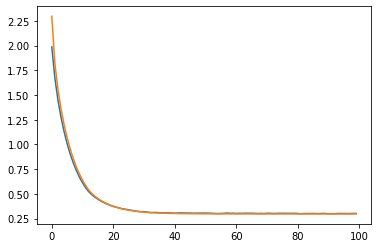

In [23]:
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])


In [24]:
# Build a new model for embedding
for layer in [4]:
    print (kerasModel.get_config()['layers'][layer]['name'])
    intermediate_layer_model = Model(inputs=kerasModel.input,
                                     outputs=kerasModel.get_layer(kerasModel.get_config()['layers'][layer]['name']).output)
    encoding_result = pd.DataFrame(intermediate_layer_model.predict(input_data))
    encoding_result.columns = ['KERAS_'+str(layer)+"_"+str(i) for i in encoding_result.columns]
    #train_df = pd.concat([train_df,encoding_result],axis=1)
    
    encoding_result = pd.DataFrame(intermediate_layer_model.predict(input_data_test))
    encoding_result.columns = ['KERAS_'+str(layer)+"_"+str(i) for i in encoding_result.columns]
    #test_df = pd.concat([test_df,encoding_result],axis=1)

dense_2


In [25]:
cols = [col for col in train_df.columns if col not in ['id', 'label']]

In [19]:
from sklearn.model_selection import StratifiedKFold
from lightgbm.sklearn import LGBMClassifier
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
import time
from lightgbm.callback import reset_parameter
import math

/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [20]:
def tpr_weight_funtion(y_true,y_predict):
    d = pd.DataFrame()
    d['prob'] = list(y_predict)
    d['y'] = list(y_true)
    d = d.sort_values(['prob'], ascending=[0])
    y = d.y
    PosAll = pd.Series(y).value_counts()[1]
    NegAll = pd.Series(y).value_counts()[0]
    pCumsum = d['y'].cumsum()
    nCumsum = np.arange(len(y)) - pCumsum + 1
    pCumsumPer = pCumsum / PosAll
    nCumsumPer = nCumsum / NegAll
    TR1 = pCumsumPer[abs(nCumsumPer-0.001).idxmin()]
    TR2 = pCumsumPer[abs(nCumsumPer-0.005).idxmin()]
    TR3 = pCumsumPer[abs(nCumsumPer-0.01).idxmin()]
    
    return ('TPR',0.4 * TR1 + 0.3 * TR2 + 0.3 * TR3,True)

def AUC_PRE(y_true,y_predict):
    from sklearn.metrics import precision_recall_curve
    from sklearn.metrics import auc
    precision, recall, thresholds = precision_recall_curve(y_true, y_predict)
    auc_score = auc(recall, precision)   
    return ('AUC_PRE',auc_score,True)

def f1_loss(y, pred):
    beta = 2
    p = 1. / (1 + np.exp(-pred))
    grad = p * ((beta - 1) * y + 1) - beta * y
    hess = ((beta - 1) * y + 1) * p * (1.0 - p)
 
    return grad, hess
def logistic_obj(y_hat, pred):
    y = pred
    p = y_hat 
    p = 1. / (1. + np.exp(-y_hat)) # 用于避免hessian矩阵中很多0
    grad = p - y
    hess = p * (1. - p)
    grad = 4 * p * y + p - 5 * y
    hess = (4 * y + 1) * (p * (1.0 - p))
    return grad, hess

In [ ]:
import random
oof = np.zeros(train_df.shape[0])
feat_imp_df = pd.DataFrame({'feat': cols, 'imp': 0})
test_df['prob'] = 0
clf = LGBMClassifier(
    boosting_type = 'goss',
    learning_rate=0.03,
    n_estimators=4023,
    num_leaves=101,
 #   max_depth = 20,
    random_state=1023,
    metric=None,
    is_unbalance=True,
    reg_alpha=0.005,
    reg_lambda=0.01,
    #bagging_freq = 20,
    #bagging_fraction = 0.8,
    #feature_fraction = 0.8,
    min_data_in_leaf = 10,
)
reset_parameters = {
    'learning_rate' : [ 0.05*math.exp(-0.005*i) for i in range(2023)]
}

modellist = []
val_aucs = []
seeds = [ 1023]
for seed in seeds:
    print(seed)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    for i, (trn_idx, val_idx) in enumerate(skf.split(train_df, train_df['label'])):
        print('--------------------- {}rd fold ---------------------'.format(i))
        t = time.time()
        trn_x, trn_y = train_df[cols].iloc[trn_idx].reset_index(drop=True), train_df['label'].values[trn_idx]
        val_x, val_y = train_df[cols].iloc[val_idx].reset_index(drop=True), train_df['label'].values[val_idx]
        clf.fit(
            trn_x, trn_y,
            eval_set=[(val_x, val_y)],
             categorical_feature=cate_cols,
            eval_metric='binary_error',
           early_stopping_rounds=200,
           verbose=200,
      #      callbacks = [reset_parameter(**reset_parameters)]
        )
        modellist.append(clf)
        feat_imp_df['imp'] += clf.feature_importances_ / skf.n_splits
        oof[val_idx] = clf.predict_proba(val_x)[:, 1]
        test_df['prob'] += clf.predict_proba(test_df[cols])[:, 1] / skf.n_splits / len(seeds)

    cv_auc = roc_auc_score(train_df['label'], oof)
    val_aucs.append(cv_auc)
    print('\ncv_auc: ', cv_auc)
print(val_aucs, np.mean(val_aucs))

1023
--------------------- 0rd fold ---------------------


/home/ubuntu/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1038: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is ['DKZS', 'DWJJLX', 'DWSSHY', 'GJZS', 'GRZHZT', 'NOUSAGE', 'SNZS', 'TOP_USER', 'TOP_USER1', 'USAGEOVER', 'WITHSIGN', 'YEZS', 'YJZS', 'ZHZS']
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ubuntu/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1038: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is ['DKZS', 'DWJJLX', 'DWSSHY', 'GJZS', 'GRZHZT', 'NOUSAGE', 'SNZS', 'TOP_USER', 'TOP_USER1', 'USAGEOVER', 'WITHSIGN', 'YEZS', 'YJZS', 'ZHZS']
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 200 rounds.
[200]	valid_0's binary_error: 0.04825
[400]	valid_0's binary_error: 0.037125


In [51]:
clf.fit(
    train_df[cols],train_df['label'],
             categorical_feature=cate_cols,
            eval_metric='binary_error',
       #     early_stopping_rounds=200,
           verbose=200,
        #    callbacks = [reset_parameter(**reset_parameters)]
        )
test_df['prob'] += clf.predict_proba(test_df[cols])[:, 1]

/home/ubuntu/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1038: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is ['DKZS', 'DWJJLX', 'DWSSHY', 'GJZS', 'GRZHZT', 'SNZS', 'YEZS', 'YJZS', 'ZHZS']
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


In [49]:
print(val_aucs, np.mean(val_aucs))
tpr = round(tpr_weight_funtion(train_df['label'], oof)[1], 6)
tpr, round(np.mean(val_aucs), 5)

[0.9440269125186805] 0.9440269125186805


(0.563729, 0.94403)

In [36]:
#指标重要性分析
dImp = pd.DataFrame({
        'column': cols,
        'importance': [sum(i)/len(i) for i in np.array([ i.feature_importances_ for i in modellist ]).transpose()] ,
    }).sort_values(by='importance',ascending=False).reset_index()

In [200]:
print([i for i in dImp[dImp.importance>10].column.values.tolist() if i not in validIndics ])

['GRZHYE_diff_GRZHDNGJYE', 'HDZYF', 'GRZHDNGJYE_GRZHSNJZYE1', 'GRZHYE_diff_GRZHSNJZYE', 'YEARPURINCM', 'GRZHYE_diff_GRZHDNGJYE1', 'GRZHDNGJYE', 'HDYF', 'GRZHDNGJYE_GRZHSNJZYE', 'GRZHSNJZYE', 'HDSYYF', 'DKFFE_DKY_multi_DKLL', 'GRZHYE_diff_GRZHSNJZYE1', 'DKFFE_DKYE', 'GRZHDNGJYE_GRZHSNJZYE2', 'HDSYYF_HDZYF', 'DKYE', 'JS_YE', 'DKFFE_DKYE251', 'GRZHYE', 'age', 'DKFFE', 'GRJCJS', 'HDSYYFZE', 'GRZHZT_in_DWJJLX_prop', 'HDZYFZE', 'DKFFE_multi_DKLL_ratio', 'XINGBIE', 'DKYE_multi_DKLL_ratio', 'GRYJCE', 'DWJJLX_in_GRZHZT_prop', 'DWSSHY_in_GRZHZT_prop', 'DWSSHY_16', 'DWJJLX_2', 'DWJJLX_3', 'DKLL', 'DWSSHY_8', 'USAGE_RATE']


In [201]:
print(len(dImp[dImp['importance']<1]['column'].values.tolist()))

43


In [52]:
submit['id'] = test_df['id']
submit['label'] = test_df['prob']
submit = pd.merge(test,submit,on='id',how='left')[['id','label']]
submit['label'] = submit['label'].apply(lambda x: 0 if pd.isnull(x) else x)


submit.to_csv('../sub/submission{}_{}.csv'.format(tpr, round(np.mean(val_aucs), 6)), index = False)
submit.shape


(15000, 2)

In [1]:
import lightgbm as lgb
lgb.__version__

'2.1.1'